# <span style='color:SteelBlue'>P7 - Implémentez un modèle de scoring</span>

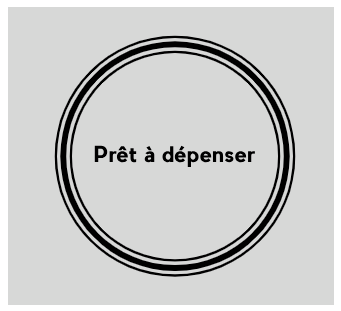

 # <span class='bg-primary'>P7_01_05 - MODELISATION</span>

Ce notebook traite de la modélisation

En particulier :

- **choix algorithme** : utilisation de Pycaret pour lancer les différents modèles de classification installés dans nos environnements pour classer les modèles qui semblent être les plus performants pour notre jeu de données et en prenant en compte les différents scores, sélectionner le modèle le plus prometteur.
- **choix du jeu de données** : utilisation de Pycaret pour entraîner les modèles de classification sur nos différents jeux de données issus du feature engineering et du feature selection (imputation avec la médiane/mode avec ou sans la variable magique Kaggle, étendu ou réduit ; imputation avec les constantes 0/XNA ou imputation avec NanImputer/ constante XNA) pour sélectionner le jeu de données à utiliser.
- **choix des métriques** : adaptées aux contraintes métiers de notre problématique.
- **optimisation modèle** : en traitant le déséquilibrage des classes, en sélectionnant les meilleurs hyperparamètres de notre modèle pour défavoriser le nombre de faux négatifs (prêt accordé non remboursé donc énormer perte d'argent pour Home Crédit).

***
Sources
***
- [Métriques_classification_théorie](https://www.deepl.com/fr/translator#en/fr/10.%20F-score%0ASimply%20put%2C%20it%20combines%20precision%20and%20recall%20into%20one%20metric.%20The%20higher%20the%20score%20the%20better%20our%20model%20is.%20You%20can%20calculate%20it%20in%20the%20following%20way%3A%0A)
- [Métriques_sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
- [Pycaret](https://pycaret.readthedocs.io/en/latest/api/classification.html)
- [Pycaret_classification](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)
- [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
- [BayesianOptimisation](https://github.com/fmfn/BayesianOptimization)

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span style='background:Thistle'>1. Introduction</span>

*****
**Mission**
*****
**Développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

*****
**Objectifs**
*****
- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/c/home-credit-default-risk/data)

In [2]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
import jyquickhelper
import numpy as np
import pandas as pd
import os
import outils_model
import outils_data
import pickle
from collections import Counter

# Visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Data pré-processing
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
    PowerTransformer, RobustScaler
# Oversampling
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
# UnderSampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Modelisation
# Préparation
from sklearn.model_selection import train_test_split, StratifiedKFold


# Modèles
import pycaret
from pycaret.classification import *
import lightgbm as lgb
from lightgbm import LGBMClassifier
# Optimisation bayésienne
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback
from skopt.space import Real, Categorical, Integer
# Optimisation optuna
import optuna
from optuna.distributions import IntUniformDistribution as IntUniDist
from optuna.distributions import UniformDistribution as UniDist
from optuna.distributions import LogUniformDistribution as LogUniDist
from optuna.distributions import CategoricalDistribution as CatDist
# Métriques
from sklearn.metrics import roc_auc_score, average_precision_score, \
    fbeta_score, make_scorer

# Interprétation
import shap

# Warnings
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Scikit-learn          : ' + sklearn.__version__)
print('Matplotlib            : ' + matplotlib.__version__)
print('Seaborn               : ' + sns.__version__)
print('Pycaret               : ' + pycaret.__version__)
print('Shape                 : ' + shap.__version__)
print('Lightgbm              : ' + lgb.__version__)
print('Optuna                : ' + optuna.__version__)
print('Outils data           : ' + outils_data.__version__)
print('Outils model          : ' + outils_model.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


Version des librairies utilisées :
jyquickhelper         : 0.4.220
Python                : 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
NumPy                 : 1.19.5
Pandas                : 1.2.4
Scikit-learn          : 0.23.2
Matplotlib            : 3.3.4
Seaborn               : 0.11.0
Pycaret               : 2.3.0
Shape                 : 0.36.0
Lightgbm              : 3.1.1
Optuna                : 2.6.0
Outils data           : 0.0.4
Outils model          : 0.0.1
Lancé le           : 2021-08-13T09:18:10.438915


In [3]:
dico_pd_option = {
    'display.max_rows': 500,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span style='background:Thistle'>2. Chargement des jeux de données</span>

**Chargement des dataframes issus du pré-processing**

<span style='background:Moccasin'>**Train_set/test_set**</span>

<span style='background:LightGreen'>**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

- **train_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [54]:
fic_sav_train_set = \
    '../sauvegarde/features-selection/train_set.pickle'
# Chargement de train_set
with open(fic_sav_train_set, 'rb') as df_appli_train_set:
    train_set = pickle.load(df_appli_train_set)
train_set.shape

(307507, 104)

- **test_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [55]:
fic_sav_test_set = \
    '../sauvegarde/features-selection/test_set.pickle'
# Chargement de test_set
with open(fic_sav_test_set, 'rb') as df_appli_test_set:
    test_set = pickle.load(df_appli_test_set)
test_set.shape

(48744, 103)

<span style='background:LightGreen'>**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

- **train_set_sans_var_magique** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [4]:
fic_sav_train_set_sans = \
    '../sauvegarde/features-selection/train_set_sans_var_magique.pickle'
# Chargement de train_set
with open(fic_sav_train_set_sans, 'rb') as df_appli_train_set_sans:
    train_set_sans_var_magique = pickle.load(df_appli_train_set_sans)
train_set_sans_var_magique.shape

(307507, 108)

- **test_set_sans_var_magique** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [5]:
fic_sav_test_set_sans = \
    '../sauvegarde/features-selection/test_set_sans_var_magique.pickle'
# Chargement de test_set
with open(fic_sav_test_set_sans, 'rb') as df_appli_test_set_sans:
    test_set_sans_var_magique = pickle.load(df_appli_test_set_sans)
test_set_sans_var_magique.shape

(48744, 107)

***Note*** :
***
- l'imputation est effectuée :
    - valeurs quantitatives : médiane,
    - valeurs qualitatives : mode.

<span style='background:Moccasin'>**Train_imp1_set/test_imp1_set**</span>

- **train_imp1_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [58]:
fic_sav_train_imp1_set = \
    '../sauvegarde/features-selection/train_imp1_set.pickle'
# Chargement de train_imp1_set
with open(fic_sav_train_imp1_set, 'rb') as df_appli_train_imp1_set:
    train_imp1_set = pickle.load(df_appli_train_imp1_set)
train_imp1_set.shape

(307507, 108)

- **test_imp1_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [59]:
fic_sav_test_imp1_set = \
    '../sauvegarde/features-selection/test_imp1_set.pickle'
# Chargement de test_imp1_set
with open(fic_sav_test_imp1_set, 'rb') as df_appli_test_imp1_set:
    test_imp1_set = pickle.load(df_appli_test_imp1_set)
test_imp1_set.shape

(48744, 107)

***Note*** :
***
- l'imputation est effectuée :
    - valeurs quantitatives : constante 0,
    - valeurs qualitatives : constante XNA.

<span style='background:Moccasin'>**Train_imp2_set/test_imp2_set**</span>

- **train_imp2_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [60]:
fic_sav_train_imp2_set = \
    '../sauvegarde/features-selection/train_imp2_set.pickle'
# Chargement de train_imp2_set
with open(fic_sav_train_imp2_set, 'rb') as df_appli_train_imp2_set:
    train_imp2_set = pickle.load(df_appli_train_imp2_set)
train_imp2_set.shape

(307507, 97)

- **test_imp2_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [61]:
fic_sav_test_imp2_set = \
    '../sauvegarde/features-selection/test_imp2_set.pickle'
# Chargement de test_imp2_set
with open(fic_sav_test_imp2_set, 'rb') as df_appli_test_imp2_set:
    test_imp2_set = pickle.load(df_appli_test_imp2_set)
test_imp2_set.shape

(48744, 96)

***Note*** :
***
- l'imputation est effectuée :
    - valeurs quantitatives : NaNImputer de la librairie Verstack,
    - valeurs qualitatives : constante XNA.

## <span style='background:Thistle'>3. Première idée sur les modèles avec pycaret</span>

L'idée d'utiliser pycaret est :
- d'avoir une **première impression sur les modèles** avec les hyperparamètres de base pour choisir le modèle à optimiser,
- et de voir l'**impact sur les scores** en fonction des différentes imputation effectuées lors du pré-processing pour choisir le jeu de données à conserver qui donne les meilleurs résultats.

***Note*** :
***
 Paramètre d'initialisation pour les jeux de données déséquilibrés comme c'est notre cas :
- **fix_imbalance** : bool, défaut = False. Lorsque l'ensemble de données d'apprentissage présente une distribution inégale de la classe cible, il peut être équilibré à l'aide de ce paramètre. Lorsqu'il est défini sur True, SMOTE (Synthetic Minority Over-sampling Technique) est appliqué par défaut pour créer des points de données synthétiques pour la classe minoritaire.
- **data_split_stratify** : bool ou liste, par défaut = False. Contrôle la stratification pendant 'train_test_split'. Si la valeur est True, la stratification se fera sur la colonne cible. Pour stratifier sur d'autres colonnes, passez une liste de noms de colonnes. Ignoré lorsque data_split_shuffle est False.

[Source](https://pycaret.readthedocs.io/en/latest/api/classification.html)

### <span style='background:PowderBlue'>3.1. Pycaret : train_set</span>

<span style='background:LightGreen'>**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

In [45]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set_sans_var_magique,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_sans',
                      silent=True)

In [46]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models = compare_models(sort='AUC')

In [47]:
# Le meilleur modèle ?
print(best_models)

In [48]:
# Sauvegarde des scores
df_best_models_scores_sans = pull()
df_best_models_scores_sans

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9179  0.7685  0.0683  0.4452  0.1184  0.0991  0.1498    65.995
xgboost         Extreme Gradient Boosting    0.9158  0.7562  0.0800  0.3930  0.1329  0.1086  0.1481    51.939
lightgbm  Light Gradient Boosting Machine    0.9162  0.7550  0.0503  0.3640  0.0883  0.0701  0.1104    10.222
rf               Random Forest Classifier    0.9124  0.7342  0.0586  0.2897  0.0974  0.0722  0.0987    49.923
gbc          Gradient Boosting Classifier    0.9019  0.7168  0.1046  0.2466  0.1468  0.1037  0.1146   125.717
et                 Extra Trees Classifier    0.9018  0.7124  0.0947  0.2331  0.1347  0.0924  0.1030    42.072
ada                  Ada Boost Classifier    0.8723  0.6979  0.1959  0.2010  0.1984  0.1290  0.1291    32.810
lda          Linear Discriminant Analysis    0.7316  0.6739  0.4904  0.1484  0.2278  0.1185  0.1498     7.882
knn                K Neighbors Classifier    0.6839  0.5661  0.3829  0.1040  0.1636  0.0419  0.0556   116.716
nb                            Naive Bayes    0.1113  0.5592  0.9762  0.0816  0.1506  0.0019  0.0174     5.304
qda       Quadratic Discriminant Analysis    0.1459  0.5553  0.9502  0.0828  0.1523  0.0044  0.0266    10.489
dt               Decision Tree Classifier    0.8286  0.5473  0.2119  0.1370  0.1664  0.0758  0.0780    10.933
lr                    Logistic Regression    0.6327  0.4720  0.1981  0.0948  0.1270  0.0455  0.0500    22.488
svm                   SVM - Linear Kernel    0.5116  0.0000  0.5890  0.0956  0.1613  0.0286  0.0541     9.513
ridge                    Ridge Classifier    0.7315  0.0000  0.4898  0.1482  0.2275  0.1182  0.1493     5.319

In [49]:
# Sauvegarde des scores des best models du train_set
fic_sav_train_set_scores_sans = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_sans.pickle'
with open(fic_sav_train_set_scores_sans, 'wb') as f:
    pickle.dump(df_best_models_scores_sans, f, pickle.HIGHEST_PROTOCOL)

**Test jeu de données réduit avec les 3 modèles les plus performants obtenus précédemment sur le train_set**

Quels sont les scores pour un jeu de données réduits à 80 variables au lieu des 104 variables du train_set ?

In [6]:
fic_sav_train_set_sans_small = \
    '../sauvegarde/features-selection/train_set_sans_var_magique_small.pickle'
# Chargement de train_set réduit
with open(fic_sav_train_set_sans_small, 'rb') as df_appli_train_set_sans_small:
    train_set_sans_var_magique_small = \
        pickle.load(df_appli_train_set_sans_small)
train_set_sans_var_magique_small.shape

(307507, 80)

In [7]:
fic_sav_test_set_sans_small = \
    '../sauvegarde/features-selection/test_set_sans_var_magique_small.pickle'
# Chargement de test_set réduit
with open(fic_sav_test_set_sans_small, 'rb') as df_appli_test_sans_set_small:
    test_set_sans_var_magique_small = \
        pickle.load(df_appli_test_sans_set_small)
test_set_sans_var_magique_small.shape

(48744, 79)

In [23]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set_sans_var_magique_small,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_sans_small',
                      silent=True)

In [24]:
# Lance pycaret sur les 3 modèles les plus performants sur le train_set
# Tri par score AUC
best_models_sans_small = compare_models(
    include=['catboost', 'xgboost', 'lightgbm'],
    sort='AUC')

In [25]:
# Le meilleur modèle ?
print(best_models_sans_small)

In [26]:
# Sauvegarde des scores
df_best_models_scores_sans_small = pull()
df_best_models_scores_sans_small

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9174  0.7665  0.0725  0.4318  0.1241  0.1033  0.1510    63.187
xgboost         Extreme Gradient Boosting    0.9149  0.7564  0.0824  0.3757  0.1351  0.1093  0.1453    41.241
lightgbm  Light Gradient Boosting Machine    0.9152  0.7520  0.0541  0.3390  0.0932  0.0727  0.1083     7.044

In [27]:
# Sauvegarde des scores des best models du train_set réduit
fic_sav_train_set_scores_sans_small = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_sans_small.pickle'
with open(fic_sav_train_set_scores_sans_small, 'wb') as f:
    pickle.dump(df_best_models_scores_sans_small, f, pickle.HIGHEST_PROTOCOL)

<span style='background:LightGreen'>**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

In [10]:
# Classification PyCaret - Initialisation
exp_name = setup(data=train_set,
                 target='TARGET',
                 fix_imbalance=True,
                 data_split_stratify=True,
                 session_id=21,
                 log_experiment=True,
                 experiment_name='train_set',
                 silent=True)

In [11]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models = compare_models(sort='AUC')

3:40: E261 at least two spaces before inline comment
4:29: E124 29


In [12]:
# Le meilleur modèle ?
print(best_models)

In [15]:
# Sauvegarde des scores
df_best_models_scores = pull()
df_best_models_scores

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9180  0.7763  0.0716  0.4501  0.1236  0.1037  0.1546    64.293
lightgbm  Light Gradient Boosting Machine    0.9166  0.7674  0.0487  0.3737  0.0862  0.0688  0.1108     9.127
xgboost         Extreme Gradient Boosting    0.9159  0.7647  0.0819  0.3981  0.1359  0.1114  0.1514    49.868
rf               Random Forest Classifier    0.9124  0.7500  0.0634  0.2994  0.1046  0.0786  0.1058    48.377
gbc          Gradient Boosting Classifier    0.9013  0.7365  0.1135  0.2525  0.1566  0.1121  0.1223   118.792
et                 Extra Trees Classifier    0.8999  0.7317  0.1147  0.2445  0.1561  0.1103  0.1193    40.710
ada                  Ada Boost Classifier    0.8745  0.7102  0.1853  0.2005  0.1925  0.1247  0.1248    31.374
lda          Linear Discriminant Analysis    0.7544  0.6942  0.5061  0.1657  0.2496  0.1457  0.1784     6.703
knn                K Neighbors Classifier    0.6853  0.5642  0.3798  0.1039  0.1631  0.0416  0.0549   103.852
nb                            Naive Bayes    0.1102  0.5599  0.9765  0.0815  0.1505  0.0018  0.0163     4.590
qda       Quadratic Discriminant Analysis    0.1444  0.5561  0.9513  0.0827  0.1522  0.0043  0.0261     9.376
dt               Decision Tree Classifier    0.8337  0.5559  0.2247  0.1489  0.1791  0.0908  0.0932     9.990
lr                    Logistic Regression    0.3691  0.2947  0.1751  0.0597  0.0882  0.0324  0.0393    36.165
svm                   SVM - Linear Kernel    0.5382  0.0000  0.5570  0.1021  0.1608  0.0355  0.0603     8.672
ridge                    Ridge Classifier    0.7545  0.0000  0.5054  0.1656  0.2495  0.1456  0.1781     4.542

In [17]:
# Sauvegarde des scores des best models du train_set
fic_sav_train_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_set_scores.pickle'
with open(fic_sav_train_set_scores, 'wb') as f:
    pickle.dump(df_best_models_scores, f, pickle.HIGHEST_PROTOCOL)

**Test jeu de données réduit avec les 3 modèles les plus performants obtenus précédemment sur le train_set**

Quels sont les scores pour un jeu de données réduits à 70 variables au lieu des 108 variables du train_set ?

In [8]:
fic_sav_train_set_small = \
    '../sauvegarde/features-selection/train_set_small.pickle'
# Chargement de train_set réduit
with open(fic_sav_train_set_small, 'rb') as df_appli_train_set_small:
    train_set_small = \
        pickle.load(df_appli_train_set_small)
train_set_small.shape

(307507, 70)

In [9]:
fic_sav_test_set_small = \
    '../sauvegarde/features-selection/test_set_small.pickle'
# Chargement de test_set réduit
with open(fic_sav_test_set_small, 'rb') as df_appli_test_set_small:
    test_set_small = \
        pickle.load(df_appli_test_set_small)
test_set_small.shape

(48744, 69)

In [31]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set_small,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_small',
                      silent=True)

In [32]:
# Lance pycaret sur les 3 modèles les plus performants sur le train_set
# Tri par score AUC
best_models_small = compare_models(
    include=['catboost', 'xgboost', 'lightgbm'],
    sort='AUC')

In [33]:
# Le meilleur modèle ?
print(best_models_small)

In [34]:
# Sauvegarde des scores
df_best_models_scores_small = pull()
df_best_models_scores_small

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9171  0.7714  0.0742  0.4215  0.1262  0.1046  0.1502    57.557
lightgbm  Light Gradient Boosting Machine    0.9146  0.7635  0.0579  0.3326  0.0987  0.0766  0.1104     6.449
xgboost         Extreme Gradient Boosting    0.9141  0.7600  0.0865  0.3652  0.1398  0.1123  0.1457    34.970

In [35]:
# Sauvegarde des scores des best models du train_set réduit
fic_sav_train_set_scores_small = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_small.pickle'
with open(fic_sav_train_set_scores_small, 'wb') as f:
    pickle.dump(df_best_models_scores_small, f, pickle.HIGHEST_PROTOCOL)

### <span style='background:PowderBlue'>3.2. Pycaret : train_imp1_set</span>

In [19]:
# Classification PyCaret - Initialisation
exp_name_imp1 = setup(data=train_imp1_set,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_imp1_set',
                      silent=True)

In [20]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models_imp1 = compare_models(sort='AUC')

In [21]:
# Le meilleur modèle ?
print(best_models_imp1)

In [22]:
# Sauvegarde des scores
df_best_models_scores_imp1 = pull()
df_best_models_scores_imp1

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9179  0.7769  0.0735  0.4477  0.1263  0.1060  0.1561    65.299
lightgbm  Light Gradient Boosting Machine    0.9169  0.7672  0.0539  0.3937  0.0947  0.0768  0.1214     8.570
xgboost         Extreme Gradient Boosting    0.9157  0.7645  0.0838  0.3948  0.1382  0.1133  0.1523    52.706
rf               Random Forest Classifier    0.9098  0.7490  0.0844  0.2954  0.1313  0.0989  0.1210    47.561
gbc          Gradient Boosting Classifier    0.9008  0.7294  0.1248  0.2605  0.1687  0.1228  0.1323   138.763
et                 Extra Trees Classifier    0.8976  0.7281  0.1250  0.2411  0.1646  0.1158  0.1230    40.175
ada                  Ada Boost Classifier    0.8700  0.7092  0.2073  0.2024  0.2048  0.1341  0.1341    31.856
lda          Linear Discriminant Analysis    0.7599  0.6885  0.4791  0.1634  0.2437  0.1401  0.1690     5.820
knn                K Neighbors Classifier    0.6922  0.5717  0.3834  0.1071  0.1675  0.0472  0.0618   138.401
lr                    Logistic Regression    0.6909  0.5708  0.3764  0.1050  0.1641  0.0435  0.0570    10.338
dt               Decision Tree Classifier    0.8311  0.5581  0.2324  0.1493  0.1818  0.0926  0.0954     9.331
nb                            Naive Bayes    0.0952  0.5508  0.9871  0.0810  0.1498  0.0007  0.0087     3.628
qda       Quadratic Discriminant Analysis    0.1382  0.5482  0.9646  0.0831  0.1530  0.0052  0.0339     8.836
svm                   SVM - Linear Kernel    0.4937  0.0000  0.5472  0.0850  0.1382  0.0095  0.0252    11.386
ridge                    Ridge Classifier    0.7602  0.0000  0.4793  0.1636  0.2440  0.1405  0.1694     3.629

In [23]:
# Sauvegarde des scores des best models du train_imp1_set
fic_sav_train_imp1_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_imp1_set_scores.pickle'
with open(fic_sav_train_imp1_set_scores, 'wb') as f:
    pickle.dump(df_best_models_scores_imp1, f, pickle.HIGHEST_PROTOCOL)

### <span style='background:PowderBlue'>3.3. Pycaret : train_imp2_set</span>

In [24]:
# Classification PyCaret - Initialisation
exp_name_imp2 = setup(data=train_imp2_set,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_imp2_set',
                      silent=True)

In [26]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models_imp2 = compare_models(sort='AUC')

In [27]:
# Le meilleur modèle ?
print(best_models_imp2)

In [28]:
# Sauvegarde des scores
df_best_models_scores_imp2 = pull()
df_best_models_scores_imp2

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9183  0.7796  0.0723  0.4603  0.1250  0.1054  0.1579    63.151
lightgbm  Light Gradient Boosting Machine    0.9175  0.7731  0.0466  0.4025  0.0834  0.0679  0.1146     9.175
xgboost         Extreme Gradient Boosting    0.9162  0.7690  0.0808  0.4044  0.1346  0.1107  0.1521    49.295
rf               Random Forest Classifier    0.9127  0.7528  0.0614  0.3012  0.1020  0.0767  0.1047    44.741
gbc          Gradient Boosting Classifier    0.9052  0.7401  0.1025  0.2698  0.1485  0.1089  0.1234   125.906
et                 Extra Trees Classifier    0.9023  0.7371  0.1132  0.2596  0.1576  0.1142  0.1254    37.828
ada                  Ada Boost Classifier    0.8804  0.7253  0.1852  0.2175  0.2000  0.1359  0.1364    30.103
lda          Linear Discriminant Analysis    0.7547  0.7065  0.5223  0.1694  0.2558  0.1525  0.1874     6.873
qda       Quadratic Discriminant Analysis    0.1474  0.5692  0.9504  0.0829  0.1525  0.0047  0.0283     8.833
knn                K Neighbors Classifier    0.6843  0.5652  0.3800  0.1035  0.1627  0.0410  0.0543   103.896
dt               Decision Tree Classifier    0.8359  0.5565  0.2233  0.1510  0.1802  0.0928  0.0950     9.783
nb                            Naive Bayes    0.1121  0.5560  0.9755  0.0816  0.1507  0.0020  0.0176     4.649
lr                    Logistic Regression    0.5238  0.4167  0.2285  0.0831  0.1188  0.0428  0.0515    25.788
svm                   SVM - Linear Kernel    0.5700  0.0000  0.4939  0.0982  0.1548  0.0293  0.0445     8.492
ridge                    Ridge Classifier    0.7550  0.0000  0.5221  0.1696  0.2560  0.1527  0.1876     4.644

In [29]:
# Sauvegarde des scores des best models du train_set
fic_sav_train_imp2_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_imp2_set_scores.pickle'
with open(fic_sav_train_imp2_set_scores, 'wb') as f:
    pickle.dump(df_best_models_scores_imp2, f, pickle.HIGHEST_PROTOCOL)

### <span style='background:PowderBlue'>3.4. Pycaret : bilan</span>

In [37]:
# Scores du train_set avec variable magique
fic_train_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_set_scores.pickle'
# Chargement de train_set
with open(fic_train_set_scores, 'rb') as df_pycaret_train_set:
    df_best_models_scores = pickle.load(df_pycaret_train_set)
df_best_models_scores.shape

(15, 9)

In [38]:
# Scores du train_set sans la variable magique
fic_train_set_scores_sans = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_sans.pickle'
# Chargement de train_set
with open(fic_train_set_scores_sans, 'rb') as df_pycaret_train_set_sans:
    df_best_models_scores_sans = pickle.load(df_pycaret_train_set_sans)
df_best_models_scores_sans.shape

(15, 9)

In [44]:
# Scores du train_set sans variable magique, réduit
fic_train_set_scores_sans_small = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_sans_small.pickle'
# Chargement de train_set
with open(fic_train_set_scores_sans_small, 'rb') as df_pycaret_trainsanssmall:
    df_best_models_scores_sans_small = \
        pickle.load(df_pycaret_trainsanssmall)
df_best_models_scores_sans_small.shape

(3, 9)

In [45]:
# Scores du train_set avec variable magique, réduit
fic_train_set_scores_small = \
    '../sauvegarde/modelisation/pycaret_train_set_scores_small.pickle'
# Chargement de train_set
with open(fic_train_set_scores_small, 'rb') as df_pycaret_train_small:
    df_best_models_scores_small = \
        pickle.load(df_pycaret_train_small)
df_best_models_scores_small.shape

(3, 9)

In [46]:
# Scores du train_imp1_set
fic_train_imp1_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_imp1_set_scores.pickle'
# Chargement de train_imp1_set
with open(fic_train_imp1_set_scores, 'rb') as df_pycaret_train_imp1_set:
    df_best_models_scores_imp1 = pickle.load(df_pycaret_train_imp1_set)
df_best_models_scores_imp1.shape

(15, 9)

In [47]:
# Scores du train_imp2_set
fic_train_imp2_set_scores = \
    '../sauvegarde/modelisation/pycaret_train_imp2_set_scores.pickle'
# Chargement de train_imp2_set
with open(fic_train_imp2_set_scores, 'rb') as df_pycaret_train_imp2_set:
    df_best_models_scores_imp2 = pickle.load(df_pycaret_train_imp2_set)
df_best_models_scores_imp2.shape

(15, 9)

In [48]:
# Ajout du jeu de données pour identifier les scores
df_best_models_scores['Jeu_donnees'] = 'train_set'
df_best_models_scores_sans['Jeu_donnees'] = 'train_set_sans'
df_best_models_scores_small['Jeu_donnees'] = 'train_set_small'
df_best_models_scores_sans_small['Jeu_donnees'] = 'train_set_sans_small'
df_best_models_scores_imp1['Jeu_donnees'] = 'train_imp1_set'
df_best_models_scores_imp2['Jeu_donnees'] = 'train_imp2_set'

In [49]:
# Constitution d'un seul dataframes
df_best_models_scores_all = \
    df_best_models_scores.append(df_best_models_scores_sans)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_small)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_sans_small)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_imp1)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_imp2)
df_best_models_scores_all.shape

(66, 10)

In [56]:
# Tri avec métrique AUC
df_tri = df_best_models_scores_all.sort_values(by='AUC', ascending=False)
df_tri

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)           Jeu_donnees
catboost              CatBoost Classifier    0.9183  0.7796  0.0723  0.4603  0.1250  0.1054  0.1579    63.151        train_imp2_set
catboost              CatBoost Classifier    0.9179  0.7769  0.0735  0.4477  0.1263  0.1060  0.1561    65.299        train_imp1_set
catboost              CatBoost Classifier    0.9180  0.7763  0.0716  0.4501  0.1236  0.1037  0.1546    64.293             train_set
lightgbm  Light Gradient Boosting Machine    0.9175  0.7731  0.0466  0.4025  0.0834  0.0679  0.1146     9.175        train_imp2_set
catboost              CatBoost Classifier    0.9171  0.7714  0.0742  0.4215  0.1262  0.1046  0.1502    57.557       train_set_small
xgboost         Extreme Gradient Boosting    0.9162  0.7690  0.0808  0.4044  0.1346  0.1107  0.1521    49.295        train_imp2_set
catboost              CatBoost Classifier    0.9179  0.7685  0.0683  0.4452  0.1184  0.0991  0.1498    65.995        train_set_sans
lightgbm  Light Gradient Boosting Machine    0.9166  0.7674  0.0487  0.3737  0.0862  0.0688  0.1108     9.127             train_set
lightgbm  Light Gradient Boosting Machine    0.9169  0.7672  0.0539  0.3937  0.0947  0.0768  0.1214     8.570        train_imp1_set
catboost              CatBoost Classifier    0.9174  0.7665  0.0725  0.4318  0.1241  0.1033  0.1510    63.187  train_set_sans_small
xgboost         Extreme Gradient Boosting    0.9159  0.7647  0.0819  0.3981  0.1359  0.1114  0.1514    49.868             train_set
xgboost         Extreme Gradient Boosting    0.9157  0.7645  0.0838  0.3948  0.1382  0.1133  0.1523    52.706        train_imp1_set
lightgbm  Light Gradient Boosting Machine    0.9146  0.7635  0.0579  0.3326  0.0987  0.0766  0.1104     6.449       train_set_small
xgboost         Extreme Gradient Boosting    0.9141  0.7600  0.0865  0.3652  0.1398  0.1123  0.1457    34.970       train_set_small
xgboost         Extreme Gradient Boosting    0.9149  0.7564  0.0824  0.3757  0.1351  0.1093  0.1453    41.241  train_set_sans_small
xgboost         Extreme Gradient Boosting    0.9158  0.7562  0.0800  0.3930  0.1329  0.1086  0.1481    51.939        train_set_sans
lightgbm  Light Gradient Boosting Machine    0.9162  0.7550  0.0503  0.3640  0.0883  0.0701  0.1104    10.222        train_set_sans
rf               Random Forest Classifier    0.9127  0.7528  0.0614  0.3012  0.1020  0.0767  0.1047    44.741        train_imp2_set
lightgbm  Light Gradient Boosting Machine    0.9152  0.7520  0.0541  0.3390  0.0932  0.0727  0.1083     7.044  train_set_sans_small
rf               Random Forest Classifier    0.9124  0.7500  0.0634  0.2994  0.1046  0.0786  0.1058    48.377             train_set
rf               Random Forest Classifier    0.9098  0.7490  0.0844  0.2954  0.1313  0.0989  0.1210    47.561        train_imp1_set
gbc          Gradient Boosting Classifier    0.9052  0.7401  0.1025  0.2698  0.1485  0.1089  0.1234   125.906        train_imp2_set
et                 Extra Trees Classifier    0.9023  0.7371  0.1132  0.2596  0.1576  0.1142  0.1254    37.828        train_imp2_set
gbc          Gradient Boosting Classifier    0.9013  0.7365  0.1135  0.2525  0.1566  0.1121  0.1223   118.792             train_set
rf               Random Forest Classifier    0.9124  0.7342  0.0586  0.2897  0.0974  0.0722  0.0987    49.923        train_set_sans
et                 Extra Trees Classifier    0.8999  0.7317  0.1147  0.2445  0.1561  0.1103  0.1193    40.710             train_set
gbc          Gradient Boosting Classifier    0.9008  0.7294  0.1248  0.2605  0.1687  0.1228  0.1323   138.763        train_imp1_set
et                 Extra Trees Classifier    0.8976  0.7281  0.1250  0.2411  0.1646  0.1158  0.1230    40.175        train_imp1_set
ada                  Ada Boost Classifier    0.8804  0.7253  0.1852  0.2175  0.2000  0.1359  0.1364    30.103        train_imp2_set
gbc          Gradient Boosting Classifier    0.9019  0.7168  0.1046  0.2466 

**Bilan** : 
***
- **Jeux de données** à utiliser (selon l'imputation effectuée) :
    - Les scores sont légèrement supérieurs pour le jeu de données train_imp2_set que pour le jeu de données train_set.
    - Mais il est difficile d'expliquer l'imputation avec NaNImputer par la librairie verstack à un utilisateur non datascientist alors qu'il est facile d'expliquer l'utilisation de la valeur moyenne pour les variables numériques et le mode ou la valeur la plus utilisée pour les variables catégorielles.
    - L'imputation par la librairie verstack est également beaucoup plus longues (presque 25 minutes au lieu de quelques secondes pour la médiane).
    - les jeux de données train_set/test_set seront utilisés pour entraîner et valider le modèle.
- **Modèles** : en se basant sur la métrique AUC, 3 modèles se détachent :
    - Catboost Classifier,
    - Light Gradient Boosting Machine,
    - Extreme Gradient Boosting Machine.
    - Observons les autres métriques pour départager nos 3 modèles.

In [57]:
mask_model = df_best_models_scores_all['Model'] \
    .isin(['CatBoost Classifier', 'Light Gradient Boosting Machine',
           'Extreme Gradient Boosting'])
mask_jeu = \
    df_best_models_scores_all['Jeu_donnees'].isin(['train_set',
                                                   'train_set_sans',
                                                   'train_set_sans_small',
                                                   'train_set_small'])
df_compare = df_best_models_scores_all[mask_model & mask_jeu]

- Pour notre problématique :
    - les **défaillants** forment la classe **positive**,
    - les **non-défaillants** forment la classe **négative**.
- Pour minimiser les pertes d'argent, nous devons :
    - nous efforcer de ne pas prédire un client non-défaillant s'il est défaillant ==> **minimiser le nombre de faux négatifs** (prédit non-défaillant mais client défaillant). Si un défaillant est prédit non défaillant, le groupe Home Crédit aura perdu toute la somme prêtée à l'emprunteur. Cela constitue les plus grosses pertes pour l'entreprise.
    - nous efforcer de ne pas prédire de défaillant si le client n'est pas défaillant donc **minimiser les faux positifs** (classe 1 défaillant alors que non-défaillant dans la réalité). Si un non-défaillant est prédit défaillant, le groupe Home Crédit aura perdu les intérêts de la somme prêtée à l'emprunteur. 
- La métrique pour déterminer le **taux de vrais positif** est le Rappel/**Recall**, elle mesure parmi toutes les observations positives combien ont été classées comme positives. Pour ne pas avoir de pertes, il faut détecter tous les défaillants (classe positive) donc **maximiser la métrique recall**.
- La métrique **Precision**  mesure le nombre d'observations prédites comme positives (client défaillant) qui le sont en réalité. Si le client est prédit défaillant alors qu'il ne le sera pas le prêt ne sera pas accordé et les intérêts ne seront pas empochés. Il faut donc **maximiser la 'Precision'**.

***Note :***
***
- Si on augmente le recall, la précision diminue, il s'agit de faire un compromis entre ces 2 métriques qui dépendent l'une de l'autre, en prenant en compte le métier/problème de l'entreprise et les coûts associés pour répondre à ces questions.
- Dans notre cas, il faut trouver le plus grand nombre d'observations réellement positives (client prédit défaillant et bien défaillant) et la perte est moins grande si on prédit un client défaillant mais qu'il n'est pas défaillant (faux positifs), donc **on donnera priorité à maximise le recall au dépend de la précision** (on parle bien de Precision pas d'accuracy).
- Le réglage du paramètre beta pour le Fbeta score permet de donner plus de poids au recall (beta>1) qu'à la précision (0<beta<1). Le score F1 est la moyenne harmonique entre le recall et la précision.

[Source](https://towardsdatascience.com/the-ultimate-guide-to-binary-classification-metrics-c25c3627dd0a)

**Choix du modèle**

In [87]:
# Tri avec métrique AUC
df_compare.groupby(['Model','Jeu_donnees']).agg({'AUC' : max}) \
    .sort_values(by=['Model', 'AUC'], ascending=[True, False]).unstack()

AUC                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.7763         0.7685               0.7665          0.7714
Extreme Gradient Boosting          0.7647         0.7562               0.7564          0.7600
Light Gradient Boosting Machine    0.7674         0.7550               0.7520          0.7635

- Léger avantage au modèle Catboost, Lightgbm et xgboost ont des résultats proches.
- Les meilleurs résultats sont obtenus par le train_set et le train_set_small mais les résultats sont assez proches pour tous les jeux de données.

In [89]:
# Tri avec métrique Recall
df_compare.groupby(['Model','Jeu_donnees']).agg({'Recall' : max}) \
    .sort_values(by=['Model', 'Recall'], ascending=[True, False]).unstack()

Recall                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.0716         0.0683               0.0725          0.0742
Extreme Gradient Boosting          0.0819         0.0800               0.0824          0.0865
Light Gradient Boosting Machine    0.0487         0.0503               0.0541          0.0579

- Le meilleur résultat est obtenu par Xgboost, suivi par CatBoost avec un résultat 2 fois meilleur que pour Lightgbm mais le recall peut-être affiné en optimisant le modèle et le seuil de probabilité.
- Au niveau des jeux de données, avantage pour le train_set_small suivi par  le train_set_sans_small mais les résultats sont assez proches pour tous les jeux de données.

In [91]:
# Tri avec métrique Precision
df_compare.groupby(['Model','Jeu_donnees']).agg({'Prec.' : max}) \
    .sort_values(by=['Model', 'Prec.'], ascending=[True, False]).unstack()

Prec.                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.4501         0.4452               0.4318          0.4215
Extreme Gradient Boosting          0.3981         0.3930               0.3757          0.3652
Light Gradient Boosting Machine    0.3737         0.3640               0.3390          0.3326

- Le meilleur résultat est obtenu par CatBoost, suivi par les 2 autres modèles qui ont des résultats proches.
- Au niveau des jeux de données, avantage pour le train_set suivi par  le train_set_sans mais les résultats sont assez proches pour tous les jeux de données.

In [92]:
# Tri avec métrique F1-Score
df_compare.groupby(['Model','Jeu_donnees']).agg({'F1' : max}) \
    .sort_values(by=['Model', 'F1'], ascending=[True, False]).unstack()

F1                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.1236         0.1184               0.1241          0.1262
Extreme Gradient Boosting          0.1359         0.1329               0.1351          0.1398
Light Gradient Boosting Machine    0.0862         0.0883               0.0932          0.0987

- Le meilleur résultat est obtenu par Xgboost, suivi par Catboost, Lightgbm est légèrement à la traîne sauf pour les train_set_small et  train_set_sans_small.
- Au niveau des jeux de données, avantage pour le train_set_small suivi par  le train_set_sans_small mais les résultats sont assez proches pour tous les jeux de données.

In [93]:
# Tri avec métrique Temps
df_compare.groupby(['Model','Jeu_donnees']).agg({'TT (Sec)' : max}) \
    .sort_values(by=['Model', 'TT (Sec)'], ascending=[True, False]).unstack()

TT (Sec)                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                64.293         65.995               63.187          57.557
Extreme Gradient Boosting          49.868         51.939               41.241          34.970
Light Gradient Boosting Machine     9.127         10.222                7.044           6.449

- Lightgbm est le plus rapide (5 fois plus rapide que xgboost et 7 fois plus que Catboost qui est très lent).
- Sans surprise les jeux de données avec moins de variables (small) ont des temps de réponse plus rapides.

**Bilan** :
***
- Les résultats sont meilleurs pour Catboost mais légèrement supérieur pour Xgboost par rapport à Lightgbm, mais le modèle Lightgbm est 7 fois plus rapide que Catboost. Puisque le but est un dashboard interactif, si de nouvelles données sont fournies ou si les données des clients évoluent, le temps d'exécution sera un facteur essentiel pour notre problématique.
- Les métriques peuvent être optimisées en jouant sur l'équilibrage du jeu de données, sur l'optimisation du modèle et sur le réglage du seuil de probabilité.
- Après analyse des résultats et des contraintes de notre problématique, **le modèle retenu sera Lightgbm**.

**Choix du jeu de données**

In [96]:
mask_model = df_best_models_scores_all['Model'] == 'Light Gradient Boosting Machine'
mask_jeu = \
    df_best_models_scores_all['Jeu_donnees'].isin(['train_set',
                                                   'train_set_sans',
                                                   'train_set_sans_small',
                                                   'train_set_small'])
df_compare_jeu = df_best_models_scores_all[mask_model & mask_jeu]
df_compare_jeu

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)           Jeu_donnees
lightgbm  Light Gradient Boosting Machine    0.9166  0.7674  0.0487  0.3737  0.0862  0.0688  0.1108     9.127             train_set
lightgbm  Light Gradient Boosting Machine    0.9162  0.7550  0.0503  0.3640  0.0883  0.0701  0.1104    10.222        train_set_sans
lightgbm  Light Gradient Boosting Machine    0.9146  0.7635  0.0579  0.3326  0.0987  0.0766  0.1104     6.449       train_set_small
lightgbm  Light Gradient Boosting Machine    0.9152  0.7520  0.0541  0.3390  0.0932  0.0727  0.1083     7.044  train_set_sans_small

- La variable magique qui a permis de gagner le concours Kaggle offre un avantage sur l'accuracy mais a de moins bon résultat sur la métrique recall qui est très importante pour notre problématique. Comme elle est difficilement explicable et peut être controversée (comparaison avec d'autres individus) nous utiliserons les datasets sans cette variable sur **le jeu de données non réduit sans la variable magique Kaggle(train_set_sans_var_magique)**.

**Bilan** :
- Modèle : **Light Gradient Boosting Machine**.
- Jeu de données : **train_set_sans_var_magique**.

## <span style='background:Thistle'>4. Préparation du jeu de données</span>

**Nombre aléatoire**

In [6]:
# Nombre aléatoire pour la reproductibilité des résultats
seed = 21
print(f'Nombre aléatoire : {seed}')

Nombre aléatoire : 21


### <span style='background:PowderBlue'>4.1. Split du jeu d'entraînement en entraînement/validation</span>

**Vecteur y**

In [7]:
# Vecteur y cible
y = train_set_sans_var_magique['TARGET']
print(f'y : {y.shape}')

y : (307507,)


**Matrice X**

In [8]:
# Matrice X
# Copie du jeu de données
train_set = train_set_sans_var_magique.copy(deep=True)
# Passage de l'identifiant du client en index pour la modélisation
train_set.set_index('SK_ID_CURR', inplace=True)
# Suppression de la variable cible pour la modélisation
X = train_set.drop(['TARGET'], axis=1)
print(f'X : {X.shape}')

X : (307507, 106)


**Découpage du jeu d'entraînement**

In [9]:
# Découpage du jeu d'entraînement en :
# X_train : pour entraîner le modèle et trouver les meilleurs
#           hyperparamètres
# X_valid : pour évaluer les performances du modèle
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      shuffle=True,
                                                      stratify=y,
                                                      random_state=seed)
print(f'X_train : {X_train.shape} - y_train : {y_train.shape}')
print(f'X_valid : {X_valid.shape} - y_valid : {y_valid.shape}')

X_train : (246005, 106) - y_train : (246005,)
X_valid : (61502, 106) - y_valid : (61502,)


## <span style='background:Thistle'>5. Choix des métriques</span>

### <span style='background:PowderBlue'>5.1. Métriques de classification binaire</span>

Comme nous en avons déjà discuté dans la partie ***3.4. Pycaret : bilan***, différentes métriques existent pour les modélisations de classification binaire.

**Problématique**
***
- Pour notre problématique :
    - les **défaillants** forment la classe **positive**,
    - les **non-défaillants** forment la classe **négative**.
- Pour minimiser les pertes d'argent, nous devons :
    - nous efforcer de ne pas prédire un client non-défaillant s'il est défaillant ==> **minimiser le nombre de faux négatifs (erreur de type II)** (prédit non-défaillant mais client défaillant). Si un défaillant est prédit non défaillant, le groupe Home Crédit aura perdu toute la somme prêtée à l'emprunteur. Cela constitue les plus grosses pertes pour l'entreprise.
    - nous efforcer de ne pas prédire de défaillant si le client n'est pas défaillant donc **minimiser les faux positifs (erreur de type I)** (classe 1 défaillant alors que non-défaillant dans la réalité). Si un non-défaillant est prédit défaillant, le groupe Home Crédit aura perdu les intérêts de la somme prêtée à l'emprunteur.
    
**Métriques**
***
-  **Recall** : la métrique pour déterminer le **taux de vrais positif** est le Rappel(Sensibilité)/**Recall**, elle mesure parmi toutes les observations positives combien ont été classées comme positives. Pour ne pas avoir de pertes, il faut détecter tous les défaillants (classe positive) donc **maximiser la métrique recall**.
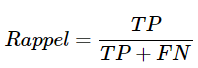

- **Precision** : elle mesure le nombre d'observations prédites comme positives (client défaillant) qui le sont en réalité. Si le client est prédit défaillant alors qu'il ne le sera pas le prêt ne sera pas accordé et les intérêts ne seront pas empochés. Il faut donc **maximiser la 'Precision'**.
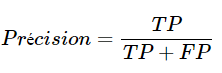

- **F-mesure ou F1** : compromis entre le rappel et précision.
    -  Si on augmente le recall, la précision diminue, il s'agit de faire un compromis entre ces 2 métriques qui dépendent l'une de l'autre, en prenant en compte le métier/problème de l'entreprise et les coûts associés pour répondre à ces questions.
    - Dans notre cas, il faut trouver le plus grand nombre d'observations réellement positives (client prédit défaillant et bien défaillant) et la perte est moins grande si on prédit un client défaillant mais qu'il n'est pas défaillant (faux positifs), donc **on donnera priorité à maximiser le recall au dépend de la précision** (on parle bien de Precision pas d'accuracy).
    - Le réglage du paramètre beta pour le Fbeta score permet de donner plus de poids au recall (beta>1) qu'à la précision (0<beta<1). Le score F1 est la moyenne harmonique entre le recall et la précision.

- **Score ROC AUC** : le score ROC AUC est équivalent au calcul de la corrélation de rang entre les prédictions et la cible. Du point de vue de l'interprétation, il est plus utile car il nous indique que cette métrique montre à quel point votre modèle est bon pour classer les prédictions. Elle vous indique la probabilité qu'une instance positive choisie au hasard soit classée plus haut qu'une instance négative choisie au hasard.

- **Score PR AUC** : calcule de l'aire sous la courbe précision-rappel pour obtenir un nombre qui vous donne des informations sur la performance du modèle. A utiliser : 
    - lorsque vous voulez communiquer la décision de précision/rappel à d'autres parties prenantes et que vous voulez choisir le seuil qui correspond au problème de l'entreprise.
    - lorsque vos données sont fortement déséquilibrées. Puisque l'AUC de PR se concentre principalement sur la classe positive (PPV et TPR), elle se soucie moins de la classe négative fréquente.
    - quand vous vous souciez plus de la classe positive que de la classe négative. Si vous vous souciez davantage de la classe positive et donc du PPV et du TPR, vous devriez opter pour la courbe Precision-Recall et la PR AUC (précision moyenne).


**Notes :**
***
- La librairie sklearn permet de calculer tous ses scores.
- Une fonction permettra d calculer et de sauvegarder ses différents scores lors de la modélisation : <span style='background:PaleGreen'>**outils_model.calculer_scores**</span>.

[Source](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

### <span style='background:PowderBlue'>5.2. Métriques métiers</span>

**Score pénalisant les faux négatifs**
- Les métriques ci-dessus ne pénalisent pas les faux négatifs sauf le Fbeta qui en utilisant une valeur supérieure à 1 pénalise plus les faux négatifs.
- Nous allons donc créer une métrique métier tentant d'optimiser notre modèle de classification grâce à la personnalisation de la fonction de perte pour définir à la main le coût des faux positifs/négatifs et des vrais positifs/négatifs.
- Cette métrique métier est définie dans la fonction <span style='background:PaleGreen'>**outils_model.custom_score**</span>.

**Seuil de probabilité**
- La valeur du seuil de probabilité à 0.5 par défaut pourra également être réglée pour tenter d'optimiser les performances du modèles pour notre métrique métier. Le seuil optimal de bascule de la classe 0 à la classe 1 devra être déterminée pour chacun des modèles entraînés avec la métrique métier comme score.
- Cette fonction sera appelée: <span style='background:PaleGreen'>**outils_model.determiner_seuil_probabilte**</span>.

## <span style='background:Thistle'>6. Modélisation</span>

In [26]:
df_resultats = pd.DataFrame({})

In [27]:
df_taux = pd.DataFrame({})

In [10]:
# Chargement du dataframe de sauvegardes des scores des modèles
fic_df_resultat_scores = \
    '../sauvegarde/modelisation/df_resultat_scores.pickle'
with open(fic_df_resultat_scores, 'rb') as df_resultat_scores:
    df_resultats = pickle.load(df_resultat_scores)

In [11]:
# Chargement du dataframe de sauvegardes des différents taux :
# TN : vrais négatifs, TP : vrais positifs
# FP : faux positifs, FN : faux négatifs
fic_df_taux = '../sauvegarde/modelisation/df_taux.pickle'
with open(fic_df_taux, 'rb') as df_taux:
    df_taux = pickle.load(df_taux)

In [12]:
# Métriques
roc_auc = make_scorer(roc_auc_score, greater_is_better=True,
                      needs_proba=True)
pr_auc = make_scorer(average_precision_score, greater_is_better=True,
                     needs_proba=True)
f1_score = make_scorer(fbeta_score, beta=1, greater_is_better=True)
f5_score = make_scorer(fbeta_score, beta=5, greater_is_better=True)
f10_score = make_scorer(fbeta_score, beta=10, greater_is_better=True)
custom_score = make_scorer(outils_model.custom_score,
                           greater_is_better=True)
custom_score_2 = make_scorer(outils_model.custom_score_2,
                           greater_is_better=True)
custom_score_3 = make_scorer(outils_model.custom_score_3,
                           greater_is_better=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

### <span style='background:PowderBlue'>6.1. Modèle LGBM de base</span>

Les résultats constitue la baseline pour comparer les modèles optimisés.

**Sans rééquilibrage**

In [28]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base = LGBMClassifier(random_state=seed, verbose=0,
                           force_col_wise=True)

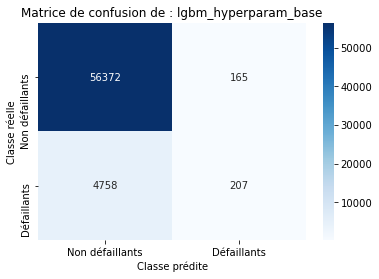

In [29]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base, X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_hyperparam_base')

In [30]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_hyperparam_base',
                                        4758, 165, 207, 56372, df_taux)

**Avec rééquilibrage**

In [31]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_bal = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True,
                               class_weight='balanced')

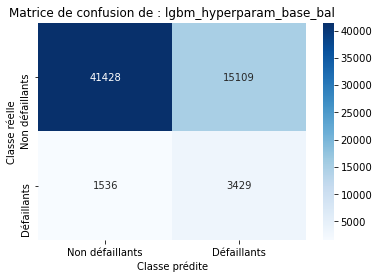

In [32]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_bal, X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_hyperparam_base_bal')

In [33]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_hyperparam_base_bal',
                                        1536, 15109, 3429, 41428, df_taux)

### <span style='background:PowderBlue'>6.2. Optimisation LGBM - Standardisation</span>

Normalement les modèles à base d'arbres décisionnels n'utilisant pas les distances ne nécessitent pas de données standardisées. La plupart des notebooks Kaggle utilisant la modélisation LightGBM utilise les données standardisées sans l'expliquer. Est-ce que cela peut avoir un fort impact sur notre modèle? Nous observerons l'impact de la standardisation sur notre jeu de données standardisé avec le modèle LightGBM de base.

<span style='background:Moccasin'>**6.2.1. Standardisation - StandardScaler**</span>

In [13]:
# StandardScaler
scaler_std = StandardScaler()

# Jeu d'entraînement du jeu d'entraînement
X_train_std = scaler_std.fit_transform(X_train.copy(deep=True))
# Jeu de validation du jeu d'entraînement
X_valid_std = scaler_std.transform(X_valid.copy(deep=True))

# Sauvegarde de la standardisation
with open('../sauvegarde/modelisation/standardisation_std.pickle', 'wb') as f:
    pickle.dump(scaler_std, f, pickle.HIGHEST_PROTOCOL)

**Sans rééquilibrage**

In [37]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_std = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True)

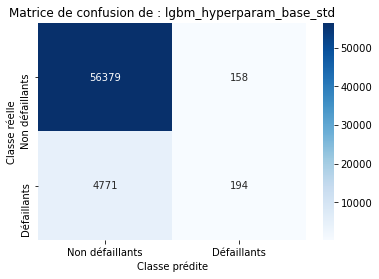

In [36]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_std, X_train_std,
                                        X_valid_std, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_std')

In [38]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_hyperparam_base_std',
                                        4771, 158, 194, 56379, df_taux)

**Avec rééquilibrage**

In [39]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_std_bal = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True,
                                   class_weight='balanced')

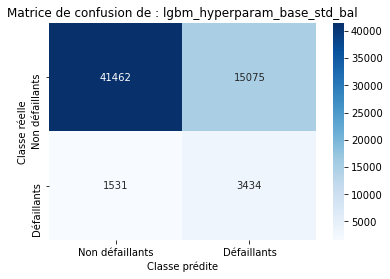

In [40]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_std_bal, X_train_std,
                                        X_valid_std, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_std_bal')

In [41]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_hyperparam_base_std_bal',
                                        1531, 15075, 3434, 41462, df_taux)

<span style='background:Moccasin'>**6.2.2. Standardisation - MinMaxScaler**</span>

In [14]:
# MinMaxScaler
scaler_min = MinMaxScaler()

# Jeu de la target de consommation d'énergie non transformée en log10
X_train_min = scaler_min.fit_transform(X_train.copy(deep=True))
X_valid_min = scaler_min.transform(X_valid.copy(deep=True))

# Sauvegarde de la standardisation
with open('../sauvegarde/modelisation/scaler_min.pickle', 'wb') as f:
    pickle.dump(scaler_min, f, pickle.HIGHEST_PROTOCOL)

In [43]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_min = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True)

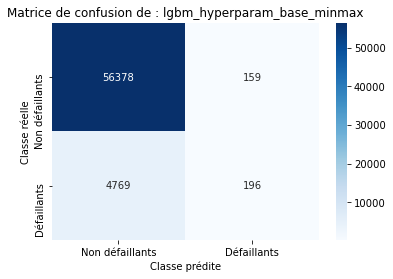

In [44]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_min, X_train_min,
                                        X_valid_min, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_minmax')

In [45]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_hyperparam_base_minmax',
                                        4769, 159, 196, 56378, df_taux)

<span style='background:Moccasin'>**6.2.3. Standardisation - RobustScaler**</span>

In [46]:
# RobustScaler
scaler_rob = RobustScaler()

X_train_rob = scaler_rob.fit_transform(X_train.copy(deep=True))
X_valid_rob = scaler_rob.transform(X_valid.copy(deep=True))

# Sauvegarde de la standardisation
with open('../sauvegarde/modelisation/scaler_rob.pickle', 'wb') as f:
    pickle.dump(scaler_rob, f, pickle.HIGHEST_PROTOCOL)

In [47]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_rob = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True)

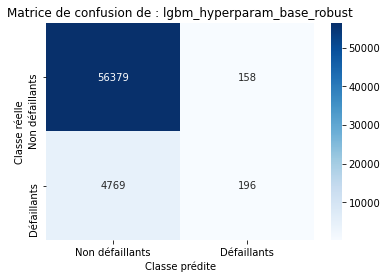

In [48]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_rob, X_train_rob,
                                        X_valid_rob, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_robust')

In [49]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_hyperparam_base_robust',
                                        4769, 158, 196, 56379, df_taux)

**Bilan** :
Le nombre de faux négatifs est légèrement plus faible(4758 au lieu de 4771 et 4769) pour le jeux d'entraînement non standardisé. Ce résultat nous conforte sur la connaissance théorique, à savoir que les algorithmes non basés sur des calculs de distances peuvent manipuler les données non standardisées.  

### <span style='background:PowderBlue'>6.3. Optimisation LGBM : Pycaret</span>

[Source](https://pycaret.readthedocs.io/en/latest/api/classification.html)
[Source](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

#### <span style='background:Moccasin'>6.3.1. Optimisation LGBM : Pycaret - hyperopt</span>

In [95]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set,
                      target='TARGET',
                      fix_imbalance=True,  # SMOTE
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_sans',
                      silent=True,
                      n_jobs=1)

In [96]:
# Instanciation du modèle
# Cette fonction entraîne et évalue la performance d'un estimateur donné
# en utilisant la validation croisée.
# La sortie de cette fonction est une grille de score avec les scores CV
# par pli.
lgbm_pycaret = create_model('lightgbm')

In [12]:
lgbm_tuned_hyperopt = tune_model(lgbm_pycaret,
                                 optimize='AUC',
                                 choose_better=True,
                                 search_library='tune-sklearn',
                                 search_algorithm='hyperopt',
                                 n_iter=20)

IntProgress(value=0, description='Processing: ', max=7)

Initiated  . . . . . . . . . . . . . . . . . .                         19:31:56
Status     . . . . . . . . . . . . . . . . . .        Searching Hyperparameters
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine

Empty DataFrame
Columns: [Accuracy, AUC, Recall, Prec., F1, Kappa, MCC]
Index: []

[LightGBM] [Warning] feature_fraction is set=0.4305605727209208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4305605727209208
[LightGBM] [Warning] bagging_fraction is set=0.7001497403926249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7001497403926249
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4305605727209208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4305605727209208
[LightGBM] [Warning] bagging_fraction is set=0.7001497403926249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7001497403926249
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4305605727209208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4305605727209208
[LightGBM] [Warning] bagging

Log sync requires rsync to be installed.
The `start_trial` operation took 706.956 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.9858777345382205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9858777345382205
[LightGBM] [Warning] bagging_fraction is set=0.49882897929868447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49882897929868447
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9858777345382205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9858777345382205
[LightGBM] [Warning] bagging_fraction is set=0.49882897929868447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49882897929868447
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9858777345382205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.985877

The `start_trial` operation took 634.339 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.7448984016196125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7448984016196125
[LightGBM] [Warning] bagging_fraction is set=0.41980061890727116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41980061890727116
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7448984016196125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7448984016196125
[LightGBM] [Warning] bagging_fraction is set=0.41980061890727116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41980061890727116
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7448984016196125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.744898

The `start_trial` operation took 448.984 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.8487483010508616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8487483010508616
[LightGBM] [Warning] bagging_fraction is set=0.8979314484338562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8979314484338562
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8487483010508616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8487483010508616
[LightGBM] [Warning] bagging_fraction is set=0.8979314484338562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8979314484338562
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8487483010508616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8487483010

The `start_trial` operation took 689.271 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5717526319235438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5717526319235438
[LightGBM] [Warning] bagging_fraction is set=0.4239862219236935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4239862219236935
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5717526319235438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5717526319235438
[LightGBM] [Warning] bagging_fraction is set=0.4239862219236935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4239862219236935
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5717526319235438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5717526319

The `start_trial` operation took 515.014 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5051529433870879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5051529433870879
[LightGBM] [Warning] bagging_fraction is set=0.9400199674939479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9400199674939479
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5051529433870879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5051529433870879
[LightGBM] [Warning] bagging_fraction is set=0.9400199674939479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9400199674939479
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5051529433870879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5051529433

The `start_trial` operation took 388.535 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5813599438713424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5813599438713424
[LightGBM] [Warning] bagging_fraction is set=0.4565081120224003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4565081120224003
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5813599438713424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5813599438713424
[LightGBM] [Warning] bagging_fraction is set=0.4565081120224003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4565081120224003
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5813599438713424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5813599438

The `start_trial` operation took 269.272 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6448544147770647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6448544147770647
[LightGBM] [Warning] bagging_fraction is set=0.7384005371375841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384005371375841
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6448544147770647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6448544147770647
[LightGBM] [Warning] bagging_fraction is set=0.7384005371375841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7384005371375841
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6448544147770647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6448544147

The `start_trial` operation took 625.573 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging_fraction is set=0.8955202084365773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955202084365773
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging_fraction is set=0.8955202084365773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955202084365773
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133

The `start_trial` operation took 667.491 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6222650148923962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6222650148923962
[LightGBM] [Warning] bagging_fraction is set=0.7365444520865639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7365444520865639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6222650148923962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6222650148923962
[LightGBM] [Warning] bagging_fraction is set=0.7365444520865639, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7365444520865639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6222650148923962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6222650148

The `start_trial` operation took 446.898 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.49960694791475285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49960694791475285
[LightGBM] [Warning] bagging_fraction is set=0.9642695711490155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9642695711490155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.49960694791475285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49960694791475285
[LightGBM] [Warning] bagging_fraction is set=0.9642695711490155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9642695711490155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.49960694791475285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49960

The `start_trial` operation took 294.519 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.9196412248942574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9196412248942574
[LightGBM] [Warning] bagging_fraction is set=0.7938441401122143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7938441401122143
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9196412248942574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9196412248942574
[LightGBM] [Warning] bagging_fraction is set=0.7938441401122143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7938441401122143
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9196412248942574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9196412248

The `start_trial` operation took 667.201 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.7311804178502637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7311804178502637
[LightGBM] [Warning] bagging_fraction is set=0.5132597822929917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5132597822929917
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7311804178502637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7311804178502637
[LightGBM] [Warning] bagging_fraction is set=0.5132597822929917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5132597822929917
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7311804178502637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7311804178

The `start_trial` operation took 319.340 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6984551774008598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6984551774008598
[LightGBM] [Warning] bagging_fraction is set=0.4935607125341918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4935607125341918
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6984551774008598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6984551774008598
[LightGBM] [Warning] bagging_fraction is set=0.4935607125341918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4935607125341918
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6984551774008598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6984551774

The `start_trial` operation took 346.901 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.45025410986801867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45025410986801867
[LightGBM] [Warning] bagging_fraction is set=0.6981172412244331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6981172412244331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.45025410986801867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45025410986801867
[LightGBM] [Warning] bagging_fraction is set=0.6981172412244331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6981172412244331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.45025410986801867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45025

The `start_trial` operation took 410.799 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.9453975098439079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9453975098439079
[LightGBM] [Warning] bagging_fraction is set=0.9819141482891017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9819141482891017
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9453975098439079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9453975098439079
[LightGBM] [Warning] bagging_fraction is set=0.9819141482891017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9819141482891017
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9453975098439079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9453975098

The `start_trial` operation took 735.791 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.7336550055306819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7336550055306819
[LightGBM] [Warning] bagging_fraction is set=0.5511674930484717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5511674930484717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7336550055306819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7336550055306819
[LightGBM] [Warning] bagging_fraction is set=0.5511674930484717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5511674930484717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7336550055306819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7336550055

The `start_trial` operation took 423.322 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.92474840270367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.92474840270367
[LightGBM] [Warning] bagging_fraction is set=0.6572773224068174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6572773224068174
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.92474840270367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.92474840270367
[LightGBM] [Warning] bagging_fraction is set=0.6572773224068174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6572773224068174
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.92474840270367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.92474840270367
[Ligh

The `start_trial` operation took 527.343 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6399507688006452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6399507688006452
[LightGBM] [Warning] bagging_fraction is set=0.48718675425953417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48718675425953417
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6399507688006452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6399507688006452
[LightGBM] [Warning] bagging_fraction is set=0.48718675425953417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48718675425953417
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6399507688006452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.639950

The `start_trial` operation took 523.406 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.9552882575867422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9552882575867422
[LightGBM] [Warning] bagging_fraction is set=0.9313554266152752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9313554266152752
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9552882575867422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9552882575867422
[LightGBM] [Warning] bagging_fraction is set=0.9313554266152752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9313554266152752
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9552882575867422, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9552882575

The `start_trial` operation took 769.071 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging_fraction is set=0.8955202084365773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955202084365773
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         19:31:56
Status     . . . . . . . . . . . . . . . . . .              Selecting Estimator
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine
                                                                               
                                         

                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         19:31:56
Status     . . . . . . . . . . . . . . . . . .                    Creating Logs
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine
                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         19:31:56
Status     . . . . . . . . . . . . . . . . . .                    Creating Logs
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine


In [16]:
print(lgbm_tuned_hyperopt)

LGBMClassifier(bagging_fraction=0.8955202084365773, bagging_freq=3,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.6343758133045186, importance_type='split',
               learning_rate=0.059644510589006425, max_depth=-1,
               min_child_samples=57, min_child_weight=0.001,
               min_split_gain=0.8461300971585886, n_estimators=238, n_jobs=1,
               num_leaves=92, objective=None, random_state=21,
               reg_alpha=9.476669457133356e-10,
               reg_lambda=0.0025378487047783864, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [17]:
plot_model(estimator=lgbm_tuned_hyperopt, plot='auc', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 238 iterations


'AUC.png'

In [18]:
plot_model(estimator=lgbm_tuned_hyperopt,
           plot='confusion_matrix', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 238 iterations


'Confusion Matrix.png'

In [19]:
plot_model(estimator=lgbm_tuned_hyperopt, plot='error', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 238 iterations


'Prediction Error.png'

In [20]:
plot_model(estimator=lgbm_tuned_hyperopt, plot='class_report', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 238 iterations


'Class Report.png'

In [22]:
print(lgbm_pycaret)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [23]:
print(lgbm_tuned_hyperopt)

LGBMClassifier(bagging_fraction=0.8955202084365773, bagging_freq=3,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.6343758133045186, importance_type='split',
               learning_rate=0.059644510589006425, max_depth=-1,
               min_child_samples=57, min_child_weight=0.001,
               min_split_gain=0.8461300971585886, n_estimators=238, n_jobs=1,
               num_leaves=92, objective=None, random_state=21,
               reg_alpha=9.476669457133356e-10,
               reg_lambda=0.0025378487047783864, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [32]:
# Sauvegarde du model pycaret optimisé hyperopt
fic_pycaret_lgbm_hyperopt = \
    '../sauvegarde/modelisation/pycaret_lgbm_hyperopt.pickle'
with open(fic_pycaret_lgbm_hyperopt, 'wb') as f:
    pickle.dump(lgbm_tuned_hyperopt, f, pickle.HIGHEST_PROTOCOL)

In [33]:
# Sauvegarde du model pycaret de base
fic_pycaret_lgbm = \
    '../sauvegarde/modelisation/pycaret_lgbm.pickle'
with open(fic_pycaret_lgbm, 'wb') as f:
    pickle.dump(lgbm_pycaret, f, pickle.HIGHEST_PROTOCOL)

**Visualisation**

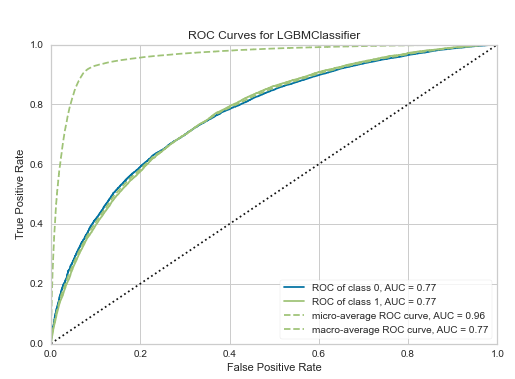
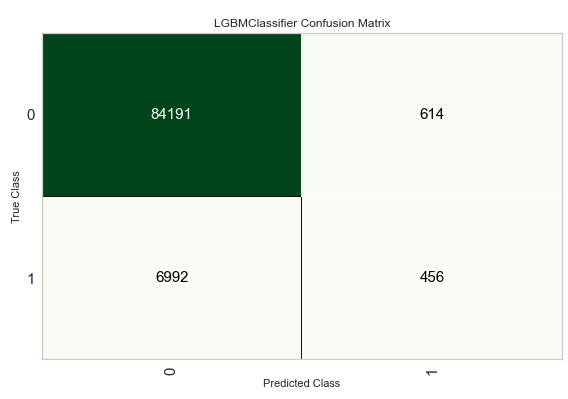
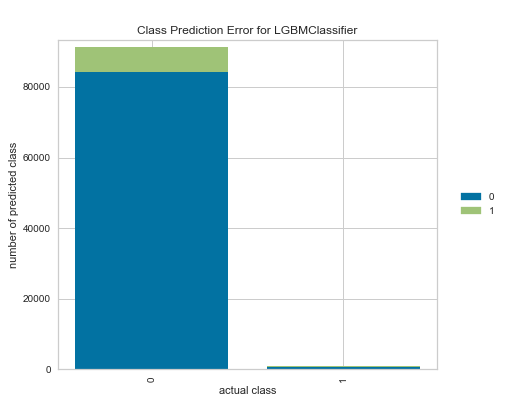
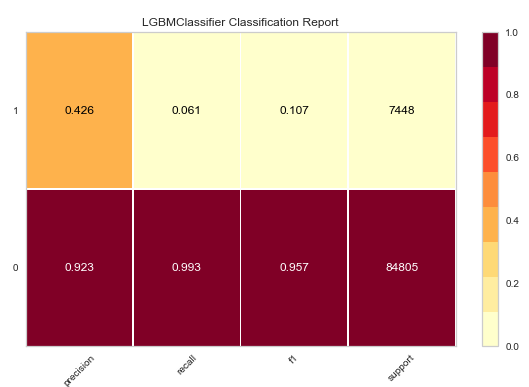

In [53]:
# Chargement du modèle pycaret LightGBM optimisé avec hyperopt
fic_pycaret_lgbm_hyperopt = \
    '../sauvegarde/modelisation/pycaret_lgbm_hyperopt.pickle'
with open(fic_pycaret_lgbm_hyperopt, 'rb') as model_pycaret_lgbm_hyperopt:
    pycaret_lgbm_hyperopt = pickle.load(model_pycaret_lgbm_hyperopt)

[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging_fraction is set=0.8955202084365773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955202084365773
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging_fraction is set=0.8955202084365773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955202084365773
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging

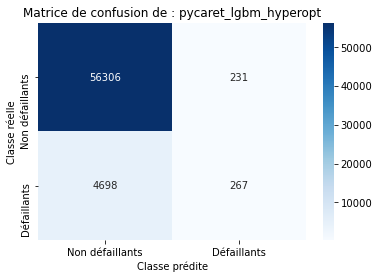

In [54]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(pycaret_lgbm_hyperopt,
                                        X_train, X_valid, y_train, y_valid,
                                        df_resultats,
                                        'pycaret_lgbm_hyperopt')

In [56]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('pycaret_lgbm_hyperopt',
                                        4698, 231, 267, 56306, df_taux)

#### <span style='background:Moccasin'>6.3.2. Optimisation LGBM : Pycaret - optuna</span>

In [24]:
lgbm_tuned_optuna = tune_model(lgbm_pycaret,
                               optimize='AUC',
                               choose_better=True,
                               search_library='tune-sklearn',
                               search_algorithm='optuna',
                               n_iter=20)

IntProgress(value=0, description='Processing: ', max=7)
                                                                    
                                                                    
Initiated  . . . . . . . . . . . . . . . . . .              23:46:49
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
Empty DataFrame
Columns: [Accuracy, AUC, Recall, Prec., F1, Kappa, MCC]
Index: []
                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         23:46:49
Status     . . . . . . . . . . . . . . . . . .             Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine
                                                                               
                                     

[I 2021-08-01 23:46:58,815] A new study created in memory with name: optuna


[LightGBM] [Warning] feature_fraction is set=0.4304639540172261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4304639540172261
[LightGBM] [Warning] bagging_fraction is set=0.5813631363787701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5813631363787701
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4304639540172261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4304639540172261
[LightGBM] [Warning] bagging_fraction is set=0.5813631363787701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5813631363787701
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4304639540172261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4304639540172261
[LightGBM] [Warning] bagging

The `start_trial` operation took 630.940 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699

The `start_trial` operation took 652.343 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.9254575547754903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9254575547754903
[LightGBM] [Warning] bagging_fraction is set=0.9558787026439736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9558787026439736
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9254575547754903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9254575547754903
[LightGBM] [Warning] bagging_fraction is set=0.9558787026439736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9558787026439736
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9254575547754903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9254575547

The `start_trial` operation took 639.306 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5963275459706385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5963275459706385
[LightGBM] [Warning] bagging_fraction is set=0.6760842002757856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6760842002757856
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5963275459706385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5963275459706385
[LightGBM] [Warning] bagging_fraction is set=0.6760842002757856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6760842002757856
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5963275459706385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5963275459

The `start_trial` operation took 749.535 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.7688948266890607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7688948266890607
[LightGBM] [Warning] bagging_fraction is set=0.7916536439163935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7916536439163935
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7688948266890607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7688948266890607
[LightGBM] [Warning] bagging_fraction is set=0.7916536439163935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7916536439163935
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7688948266890607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7688948266

The `start_trial` operation took 491.203 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.8603637733707851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603637733707851
[LightGBM] [Warning] bagging_fraction is set=0.6539935251553883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6539935251553883
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8603637733707851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603637733707851
[LightGBM] [Warning] bagging_fraction is set=0.6539935251553883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6539935251553883
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8603637733707851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603637733

The `start_trial` operation took 684.815 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.8397489073930524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8397489073930524
[LightGBM] [Warning] bagging_fraction is set=0.5682600910866811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5682600910866811
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8397489073930524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8397489073930524
[LightGBM] [Warning] bagging_fraction is set=0.5682600910866811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5682600910866811
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8397489073930524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8397489073

The `start_trial` operation took 329.401 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.8366723156017117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8366723156017117
[LightGBM] [Warning] bagging_fraction is set=0.6352248344083521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6352248344083521
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8366723156017117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8366723156017117
[LightGBM] [Warning] bagging_fraction is set=0.6352248344083521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6352248344083521
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8366723156017117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8366723156

The `start_trial` operation took 547.178 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6190673481051913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6190673481051913
[LightGBM] [Warning] bagging_fraction is set=0.628621083646526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.628621083646526
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6190673481051913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6190673481051913
[LightGBM] [Warning] bagging_fraction is set=0.628621083646526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.628621083646526
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6190673481051913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.61906734810519

The `start_trial` operation took 410.166 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5060377376384351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060377376384351
[LightGBM] [Warning] bagging_fraction is set=0.624112659190208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624112659190208
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5060377376384351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060377376384351
[LightGBM] [Warning] bagging_fraction is set=0.624112659190208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624112659190208
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5060377376384351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50603773763843

The `start_trial` operation took 503.004 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.4102708887717488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4102708887717488
[LightGBM] [Warning] bagging_fraction is set=0.4224171746596046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4224171746596046
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4102708887717488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4102708887717488
[LightGBM] [Warning] bagging_fraction is set=0.4224171746596046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4224171746596046
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4102708887717488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4102708887

The `start_trial` operation took 492.706 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.4010455018829906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4010455018829906
[LightGBM] [Warning] bagging_fraction is set=0.8208561568064587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8208561568064587
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4010455018829906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4010455018829906
[LightGBM] [Warning] bagging_fraction is set=0.8208561568064587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8208561568064587
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4010455018829906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4010455018

The `start_trial` operation took 751.459 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.481457076877615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.481457076877615
[LightGBM] [Warning] bagging_fraction is set=0.4671990549101478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4671990549101478
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.481457076877615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.481457076877615
[LightGBM] [Warning] bagging_fraction is set=0.4671990549101478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4671990549101478
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.481457076877615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.481457076877615

The `start_trial` operation took 689.888 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5168278464947769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168278464947769
[LightGBM] [Warning] bagging_fraction is set=0.521973068660046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.521973068660046
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5168278464947769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168278464947769
[LightGBM] [Warning] bagging_fraction is set=0.521973068660046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.521973068660046
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5168278464947769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51682784649477

The `start_trial` operation took 625.606 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6517448547863733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6517448547863733
[LightGBM] [Warning] bagging_fraction is set=0.7677387718182775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7677387718182775
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6517448547863733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6517448547863733
[LightGBM] [Warning] bagging_fraction is set=0.7677387718182775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7677387718182775
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6517448547863733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6517448547

The `start_trial` operation took 632.015 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.40193924937309866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40193924937309866
[LightGBM] [Warning] bagging_fraction is set=0.8878956275023774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878956275023774
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.40193924937309866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40193924937309866
[LightGBM] [Warning] bagging_fraction is set=0.8878956275023774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878956275023774
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.40193924937309866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40193

The `start_trial` operation took 503.272 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5597558177409473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597558177409473
[LightGBM] [Warning] bagging_fraction is set=0.5343833537411452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5343833537411452
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5597558177409473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597558177409473
[LightGBM] [Warning] bagging_fraction is set=0.5343833537411452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5343833537411452
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5597558177409473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597558177

The `start_trial` operation took 277.683 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6848930511089657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6848930511089657
[LightGBM] [Warning] bagging_fraction is set=0.7227471820669408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7227471820669408
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6848930511089657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6848930511089657
[LightGBM] [Warning] bagging_fraction is set=0.7227471820669408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7227471820669408
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6848930511089657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6848930511

The `start_trial` operation took 632.424 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.4517496730384321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4517496730384321
[LightGBM] [Warning] bagging_fraction is set=0.40276819338279735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40276819338279735
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4517496730384321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4517496730384321
[LightGBM] [Warning] bagging_fraction is set=0.40276819338279735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40276819338279735
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4517496730384321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.451749

The `start_trial` operation took 521.802 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5568326432387583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5568326432387583
[LightGBM] [Warning] bagging_fraction is set=0.7220613749535476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7220613749535476
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5568326432387583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5568326432387583
[LightGBM] [Warning] bagging_fraction is set=0.7220613749535476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7220613749535476
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5568326432387583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5568326432

The `start_trial` operation took 457.085 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         23:46:49
Status     . . . . . . . . . . . . . . . . . .              Selecting Estimator
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine
                                                                               
                                           

                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         23:46:49
Status     . . . . . . . . . . . . . . . . . .                    Creating Logs
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine
                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         23:46:49
Status     . . . . . . . . . . . . . . . . . .                    Creating Logs
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine


In [25]:
print(lgbm_tuned_optuna)

LGBMClassifier(bagging_fraction=0.6975577298956934, bagging_freq=4,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.506874796935699, importance_type='split',
               learning_rate=0.0498838441998684, max_depth=-1,
               min_child_samples=57, min_child_weight=0.001,
               min_split_gain=0.06957095461260054, n_estimators=243, n_jobs=1,
               num_leaves=174, objective=None, random_state=21,
               reg_alpha=0.3478959107062774, reg_lambda=2.921767889068947e-09,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [26]:
plot_model(estimator=lgbm_tuned_optuna, plot='auc', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 243 iterations


'AUC.png'

In [27]:
plot_model(estimator=lgbm_tuned_optuna,
           plot='confusion_matrix', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 243 iterations


'Confusion Matrix.png'

In [28]:
plot_model(estimator=lgbm_tuned_optuna, plot='error', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 243 iterations


'Prediction Error.png'

In [29]:
plot_model(estimator=lgbm_tuned_optuna, plot='class_report', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 243 iterations


'Class Report.png'

In [30]:
print(lgbm_pycaret)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [31]:
print(lgbm_tuned_optuna)

LGBMClassifier(bagging_fraction=0.6975577298956934, bagging_freq=4,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.506874796935699, importance_type='split',
               learning_rate=0.0498838441998684, max_depth=-1,
               min_child_samples=57, min_child_weight=0.001,
               min_split_gain=0.06957095461260054, n_estimators=243, n_jobs=1,
               num_leaves=174, objective=None, random_state=21,
               reg_alpha=0.3478959107062774, reg_lambda=2.921767889068947e-09,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [34]:
# Sauvegarde du model pycaret optimisé optuna
fic_pycaret_lgbm_optuna = \
    '../sauvegarde/modelisation/pycaret_lgbm_optuna.pickle'
with open(fic_pycaret_lgbm_optuna, 'wb') as f:
    pickle.dump(lgbm_tuned_optuna, f, pickle.HIGHEST_PROTOCOL)

**Visualisation**

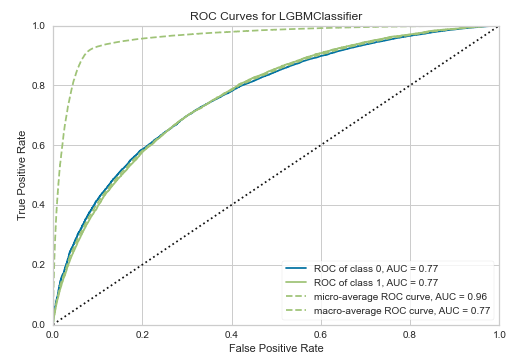
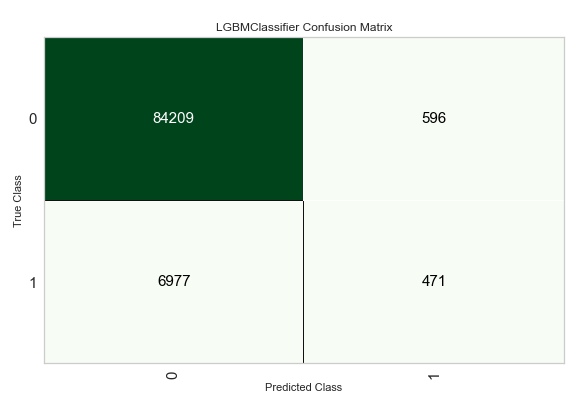
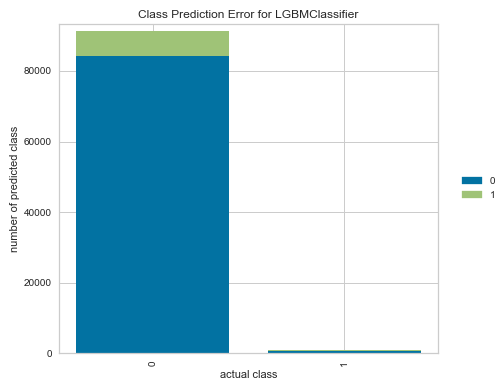
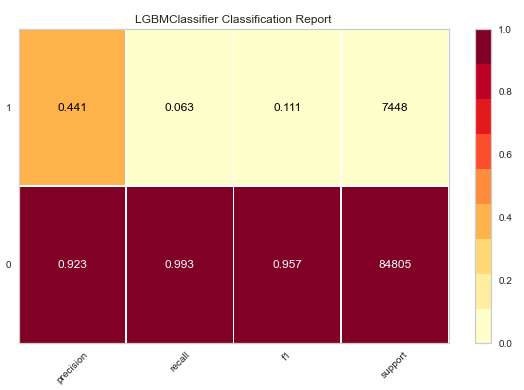

In [57]:
# Chargement du modèle pycaret LightGBM optimisé avec optuna
fic_pycaret_lgbm_optuna = \
    '../sauvegarde/modelisation/pycaret_lgbm_optuna.pickle'
with open(fic_pycaret_lgbm_optuna, 'rb') as model_pycaret_lgbm_optuna:
    pycaret_lgbm_optuna = pickle.load(model_pycaret_lgbm_optuna)

[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fract

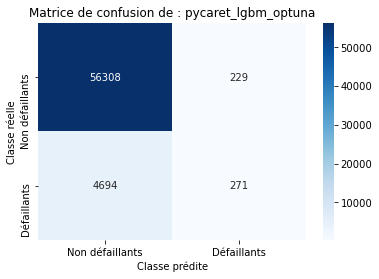

In [58]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(pycaret_lgbm_optuna,
                                        X_train, X_valid, y_train, y_valid,
                                        df_resultats,
                                        'pycaret_lgbm_optuna')

In [60]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('pycaret_lgbm_optuna',
                                        4694, 229, 271, 56308, df_taux)

### <span style='background:PowderBlue'>6.4. Optimisation LGBM : meilleurs hyperparamètres BayesianOptimization</span>

Lors du projet 4, nous avons explorer l'optimisation en réglant les paramètres pas à pas, en utlisant RandomizedSearchCV, GridSearchCV et hyperopt. Nous allons découvrir l'optimisation Bayésienne en utilisant la librairie bayes_opt du MIT.

[Source](https://github.com/fmfn/BayesianOptimization)

#### <span style='background:Moccasin'>6.4.1. Optimisation LGBM : BayesianOptimization - Score ROC_AUC</span>

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_1**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
    - class_weight

In [64]:
# Définition de l'objective fonction
def lgbm_eval_1(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                subsample_freq, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
#         'learning_rate' : 0.005,
#         'n_estimators' : 10000,
        'n_jobs' : -1,
#         'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : int(round(subsample_freq)),
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y_train, cv_preds)

In [65]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_1 = \
    BayesianOptimization(lgbm_eval_1,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'subsample_freq' : (1, 7),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)})

bayesian_opt_1 = lgbm_bayesian_opt_1.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.784    |  0.9751   |  8.163    |  79.88    |  69.21    |  0.02489  |  37.34    |  0.2518   |  0.0273   |  0.8797   |  2.325    |
|  2        |  0.7823   |  0.7176   |  7.024    |  35.7     |  62.11    |  0.009573 |  34.18    |  0.06939  |  0.008093 |  0.5369   |  6.295    |
|  3        |  0.783    |  0.5815   |  10.46    |  16.48    |  46.41    |  0.0398   |  40.09    |  0.1556   |  0.1433   |  0.6981   |  6.334    |
|  4        |  0.7836   |  0.6102   |  8.331    |  42.2     |  70.07    |  0.01686  |  37.58    |  0.2421   |  0.001922 |  0.9125   |  1.595    |
|  5        |  0.7832   |  0.5581   |  7.246    |  40.9     |  70.68    |  0.09014  |  37.68    |  0.08156  |  0.2883   |  0

In [66]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_1.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.7588991266619178, 'max_depth': 9.36218757384389, 'min_child_samples': 79.45074965756659, 'min_child_weight': 70.74188671599465, 'min_split_gain': 0.003475987645386258, 'num_leaves': 39.75869289835248, 'reg_alpha': 0.23044907011714402, 'reg_lambda': 0.258249657639505, 'subsample': 0.8227077148381376, 'subsample_freq': 1.8398805929535222}


In [67]:
param_lgbm_bayesian_opt_1 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'colsample_bytree': 0.7588991266619178,
                             'max_depth': 9,
                             'min_child_samples': 79,
                             'min_child_weight': 70.74188671599465,
                             'min_split_gain': 0.003475987645386258,
                             'num_leaves': 40,
                             'reg_alpha': 0.23044907011714402,
                             'reg_lambda': 0.258249657639505,
                             'subsample': 0.8227077148381376,
                             'subsample_freq' : 2,
                             'verbosity' : -1,
                             'seed' : seed}

**Sans le paramètre class_weight='balanced'**

In [68]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_1 = LGBMClassifier(**param_lgbm_bayesian_opt_1,
                                     #class_weight='balanced',
                                     force_col_wise=True)

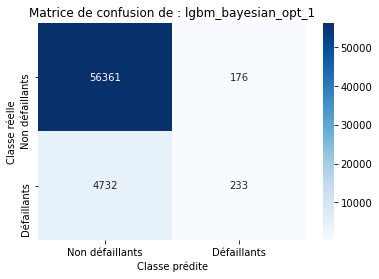

In [69]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_1,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_1')

In [70]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_1',
                                        4732, 176, 233, 56361, df_taux)

**Avec le paramètre class_weight='balanced'**

In [71]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_1_bal = LGBMClassifier(**param_lgbm_bayesian_opt_1,
                                         class_weight='balanced',
                                         force_col_wise=True)

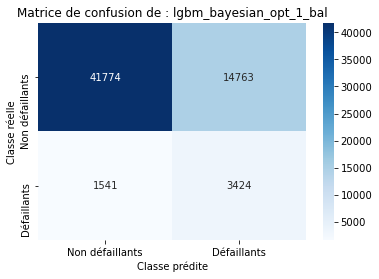

In [72]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_1_bal,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_1_bal')

In [73]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_1_bal',
                                        1541, 14763, 3424, 41774, df_taux)

In [76]:
param_lgbm_bayesian_opt_1_bis = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'colsample_bytree': 0.7588991266619178,
                             'max_depth': 9,
                             'min_child_samples': 80,
                             'min_child_weight': 70.74188671599465,
                             'min_split_gain': 0.003475987645386258,
                             'num_leaves': 39,
                             'reg_alpha': 0.23044907011714402,
                             'reg_lambda': 0.258249657639505,
                             'subsample': 0.8227077148381376,
                             'subsample_freq' : 2,
                             'verbosity' : -1,
                             'seed' : seed}

**Sans le paramètre class_weight='balanced'**

In [77]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_1_bis = LGBMClassifier(**param_lgbm_bayesian_opt_1_bis,
                                         #class_weight='balanced',
                                         force_col_wise=True)

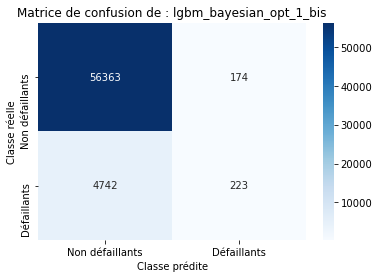

In [78]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_1_bis,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_1_bis')

In [79]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_1_bis',
                                        4742, 174, 223, 56363, df_taux)

**Avec le paramètre class_weight='balanced'**

In [80]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_1_bis_bal = LGBMClassifier(**param_lgbm_bayesian_opt_1_bis,
                                             class_weight='balanced',
                                             force_col_wise=True)

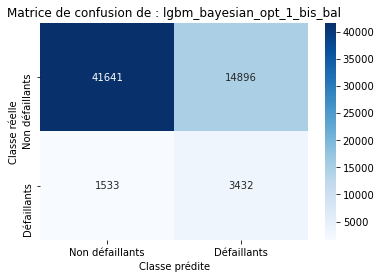

In [81]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_1_bis_bal,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_1_bis_bal')

In [82]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_1_bis_bal',
                                        1533, 14896, 3432, 41641, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_2**</span>
***
- en initialisant les paramètres :
    - learning_rate,
    - n_estimators
- sans forcer le paramètre :    
    - class_weight.

In [296]:
# Définition de l'objective fonction
def lgbm_eval_2(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                subsample_freq, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
#         'class_weight' : 'balanced', # Balanced
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : int(round(subsample_freq)),
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y_train, cv_preds)

In [297]:
# Objective fonction 
lgbm_bayesian_opt_2 = \
    BayesianOptimization(lgbm_eval_2,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'subsample_freq' : (1, 7),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                          random_state = 21)

bayesian_opt_2 = lgbm_bayesian_opt_2.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7906   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |  4.502    |
|  2        |  0.7908   |  0.5348   |  10.34    |  14.99    |  18.36    |  0.04959  |  46.59    |  0.2279   |  0.2912   |  0.8797   |  3.306    |
|  3        |  0.7905   |  0.7044   |  9.567    |  25.3     |  69.06    |  0.09132  |  44.02    |  0.1555   |  0.05118  |  0.6493   |  2.704    |
|  4        |  0.7907   |  0.6636   |  8.301    |  45.83    |  21.31    |  0.07999  |  43.17    |  0.2549   |  0.08099  |  0.8074   |  4.917    |
|  5        |  0.7906   |  0.7589   |  10.61    |  14.14    |  19.53    |  0.02771  |  46.51    |  0.22     |  0.1816   |  0

In [298]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_2.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.6572444671016864, 'max_depth': 6.725368912391493, 'min_child_samples': 21.798266653578562, 'min_child_weight': 6.877453971458381, 'min_split_gain': 0.0063894515090233365, 'num_leaves': 35.38010803943543, 'reg_alpha': 0.04446350586910105, 'reg_lambda': 0.051640348086451224, 'subsample': 0.6095326147567048, 'subsample_freq': 1.1312051919957602}


In [299]:
param_lgbm_bayesian_opt_2 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'learning_rate' : 0.005,
                             'n_estimators' : 10000,
                             'n_jobs' : -1,
                             'colsample_bytree': 0.6572444671016864,
                             'max_depth': 6,
                             'min_child_samples': 22,
                             'min_child_weight': 6.877453971458381,
                             'min_split_gain': 0.0063894515090233365,
                             'num_leaves': 35,
                             'reg_alpha': 0.04446350586910105,
                             'reg_lambda': 0.051640348086451224,
                             'subsample': 0.6095326147567048,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

In [300]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_2 = LGBMClassifier(**param_lgbm_bayesian_opt_2,
                                     force_col_wise=True)

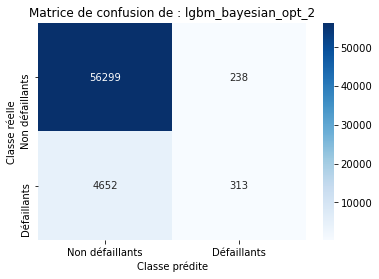

In [301]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_2,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_2')

In [302]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_2',
                                        4652, 238, 312, 56299, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_3**</span>
***
- en initialisant les paramètres :
    - learning_rate,
    - n_estimators,
    - class_weight.
- et en utilisant les hyperparamètres précedemment trouvés.    

Best Hyperparamètres :

{'colsample_bytree': 0.6572444671016864, 'max_depth': 6.725368912391493, 'min_child_samples': 21.798266653578562, 'min_child_weight': 6.877453971458381, 'min_split_gain': 0.0063894515090233365, 'num_leaves': 35.38010803943543, 'reg_alpha': 0.04446350586910105, 'reg_lambda': 0.051640348086451224, 'subsample': 0.6095326147567048, 'subsample_freq': 1.1312051919957602}

In [342]:
param_lgbm_bayesian_opt_3 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'learning_rate' : 0.005,
                             'n_estimators' : 10000,
                             'n_jobs' : -1,
                             'colsample_bytree': 0.6572444671016864,
                             'max_depth': 6,
                             'min_child_samples': 22,
                             'min_child_weight': 6.877453971458381,
                             'min_split_gain': 0.0063894515090233365,
                             'num_leaves': 35,
                             'reg_alpha': 0.04446350586910105,
                             'reg_lambda': 0.051640348086451224,
                             'subsample': 0.6095326147567048,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

In [343]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_3 = LGBMClassifier(**param_lgbm_bayesian_opt_3,
                                     force_col_wise=True,
                                     class_weight='balanced'
                                    )

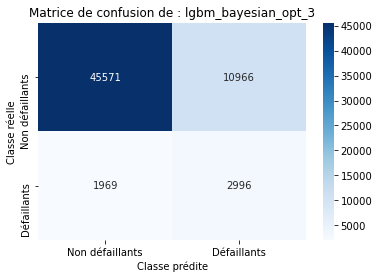

In [344]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_3,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_3')

In [345]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_3',
                                        1969, 10966, 2996, 45571, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_4**</span>
***
- sans initialiser les paramètres :
    - learning_rate,
    - n_estimators
- en forcant le paramètre suivant avant de lancer la recherche bayésienne :
    - class_weight='balanced'.

In [84]:
# Définition de l'objective fonction
def lgbm_eval_4(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                subsample_freq, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
#         'learning_rate' : 0.005,
#         'n_estimators' : 10000,
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : int(round(subsample_freq)),
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y_train, cv_preds)

In [85]:
# Objective fonction 
lgbm_bayesian_opt_4 = \
    BayesianOptimization(lgbm_eval_4,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6,11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'subsample_freq' : (1, 7),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                          random_state = seed)

bayesian_opt_4 = lgbm_bayesian_opt_4.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7825   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |  4.502    |
|  2        |  0.7839   |  0.5348   |  10.34    |  14.99    |  18.36    |  0.04959  |  46.59    |  0.2279   |  0.2912   |  0.8797   |  3.306    |
|  3        |  0.7829   |  0.7044   |  9.567    |  25.3     |  69.06    |  0.09132  |  44.02    |  0.1555   |  0.05118  |  0.6493   |  2.704    |
|  4        |  0.7829   |  0.6636   |  8.301    |  45.83    |  21.31    |  0.07999  |  43.17    |  0.2549   |  0.08099  |  0.8074   |  4.917    |
|  5        |  0.7826   |  0.7589   |  10.61    |  14.14    |  19.53    |  0.02771  |  46.51    |  0.22     |  0.1816   |  0

In [86]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_4.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.993365418293884, 'max_depth': 9.8667441313362, 'min_child_samples': 27.66171939960289, 'min_child_weight': 40.756818935577414, 'min_split_gain': 0.03077477611960172, 'num_leaves': 35.095128691057475, 'reg_alpha': 0.20376145272188176, 'reg_lambda': 0.27341883368247033, 'subsample': 0.9020590257150711, 'subsample_freq': 4.539903292148306}


In [87]:
param_lgbm_bayesian_opt_4 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced
                             'colsample_bytree': 0.993365418293884,
                             'max_depth': 10,
                             'min_child_samples': 28,
                             'min_child_weight': 40.756818935577414,
                             'min_split_gain': 0.03077477611960172,
                             'num_leaves': 35,
                             'reg_alpha': 0.20376145272188176,
                             'reg_lambda': 0.27341883368247033,
                             'subsample': 0.9020590257150711,
                             'subsample_freq' : 4,
                             'verbosity' : -1,
                             'seed' : seed}

In [88]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_4 = LGBMClassifier(**param_lgbm_bayesian_opt_4,
                                     force_col_wise=True)

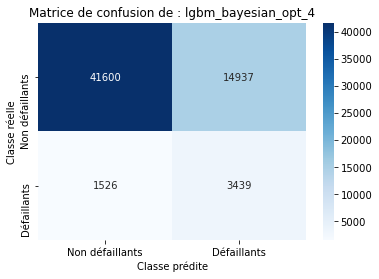

In [89]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_4,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_4')

In [90]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_4',
                                        1526, 14937, 3439, 41600, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_9**</span>
***
- sans initialiser les paramètres :
    - learning_rate,
    - n_estimators
    - subsample_freq
- en forcant le paramètre suivant avant de lancer la recherche bayésienne :
    - class_weight='balanced'.
- en augmentant le nombre d'itérations de 20 à 100.    

In [91]:
# Définition de l'objective fonction
def lgbm_eval_9(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                subsample_freq, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : int(round(subsample_freq)),
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1
    }
    
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y_train, cv_preds)

In [92]:
# Objective fonction 
lgbm_bayesian_opt_9 = \
    BayesianOptimization(lgbm_eval_9,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'subsample_freq' : (1, 7),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                          random_state = 42)

bayesian_opt_9 = lgbm_bayesian_opt_9.maximize(n_iter=100,
                                              init_points=5)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7853   |  0.6873   |  10.75    |  59.9     |  49.9     |  0.0156   |  28.9     |  0.01837  |  0.26     |  0.8006   |  5.248    |
|  2        |  0.7843   |  0.5103   |  10.85    |  67.43    |  20.93    |  0.01818  |  29.59    |  0.09197  |  0.1579   |  0.716    |  2.747    |
|  3        |  0.7842   |  0.8059   |  6.697    |  26.91    |  32.48    |  0.04561  |  44.63    |  0.0607   |  0.1548   |  0.7962   |  1.279    |
|  4        |  0.7847   |  0.8038   |  6.853    |  9.879    |  76.17    |  0.09656  |  45.21    |  0.09208  |  0.0302   |  0.8421   |  3.641    |
|  5        |  0.7846   |  0.561    |  8.476    |  7.579    |  73.2     |  0.02588  |  41.56    |  0.0942   |  0.1565   |  0

|  31       |  0.7836   |  0.8232   |  7.729    |  21.19    |  58.29    |  0.01296  |  42.11    |  0.03246  |  0.211    |  0.7652   |  6.54     |
|  32       |  0.7856   |  0.9517   |  8.57     |  66.13    |  9.829    |  0.0473   |  30.15    |  0.166    |  0.1253   |  0.9385   |  4.655    |
|  33       |  0.7849   |  0.6287   |  8.031    |  67.51    |  6.846    |  0.02123  |  26.7     |  0.04587  |  0.06194  |  0.8717   |  5.454    |
|  34       |  0.7832   |  0.715    |  8.104    |  7.231    |  48.1     |  0.09925  |  49.7     |  0.2705   |  0.07836  |  0.5973   |  2.74     |
|  35       |  0.7835   |  0.9596   |  9.201    |  28.49    |  21.79    |  0.08483  |  44.37    |  0.1876   |  0.2487   |  0.6387   |  5.979    |
|  36       |  0.7843   |  0.7018   |  6.85     |  11.89    |  64.75    |  0.078    |  45.35    |  0.01591  |  0.01723  |  0.7719   |  3.632    |
|  37       |  0.7826   |  0.7538   |  6.832    |  70.73    |  79.27    |  0.06118  |  26.99    |  0.2275   |  0.1044   |  0

|  63       |  0.7848   |  0.6629   |  8.011    |  68.31    |  12.24    |  0.01527  |  34.48    |  0.2499   |  0.2662   |  0.7742   |  3.466    |
|  64       |  0.784    |  0.7851   |  7.063    |  36.71    |  69.3     |  0.05436  |  26.48    |  0.09025  |  0.1119   |  0.6502   |  4.273    |
|  65       |  0.7848   |  0.6327   |  8.738    |  13.6     |  36.49    |  0.01804  |  34.66    |  0.2174   |  0.1135   |  0.8326   |  4.105    |
|  66       |  0.7839   |  0.6667   |  10.68    |  79.61    |  38.4     |  0.04366  |  36.16    |  0.2723   |  0.2497   |  0.6622   |  5.052    |
|  67       |  0.7838   |  0.9275   |  6.643    |  48.0     |  42.88    |  0.06902  |  41.59    |  0.1466   |  0.03815  |  0.7377   |  4.869    |
|  68       |  0.7847   |  0.9917   |  9.463    |  72.1     |  64.23    |  0.01411  |  28.38    |  0.06642  |  0.03226  |  0.6606   |  3.998    |
|  69       |  0.7845   |  0.6766   |  7.788    |  68.22    |  67.33    |  0.03653  |  29.31    |  0.2922   |  0.2687   |  0

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
|  97       |  0.7832   |  0.6207   |  8.69     |  51.65    |  36.04    |  0.06762  |  31.19    |  0.04036  |  0.1324   |  0.6041   |  3.386    |
|  98       |  0.784    |  0.7007   |  8.849    |  47.25    |  64.37    |  0.05007  |  42.44    |  0.08629  |  0.226    |  0.6422   |  4.177    |
|  99       |  0.7837   |  0.8839   |  9.539    |  10.38  

In [93]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_9.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.6423746414812384, 'max_depth': 9.38502516115323, 'min_child_samples': 71.58146129500588, 'min_child_weight': 28.86619177064622, 'min_split_gain': 0.03170556012864323, 'num_leaves': 36.88463476666496, 'reg_alpha': 0.1149297532030942, 'reg_lambda': 0.19105766160985452, 'subsample': 0.9428711683043284, 'subsample_freq': 3.5529876097014403}


In [95]:
param_lgbm_bayesian_opt_9 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced
                             'colsample_bytree': 0.6423746414812384,
                             'max_depth': 9,
                             'min_child_samples': 72,
                             'min_child_weight': 28.86619177064622,
                             'min_split_gain': 0.03170556012864323,
                             'num_leaves': 37,
                             'reg_alpha': 0.1149297532030942,
                             'reg_lambda': 0.19105766160985452,
                             'subsample': 0.9428711683043284,
                             'subsample_freq': 3,
                             'verbosity' : -1}

In [96]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_9 = LGBMClassifier(**param_lgbm_bayesian_opt_9,
                                     force_col_wise=True)

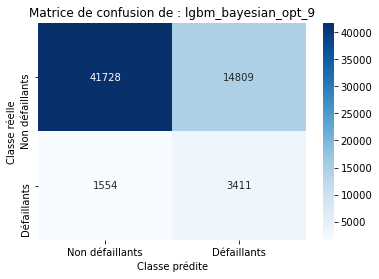

In [97]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_9,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_9')

In [98]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_9',
                                        1554, 14809, 3411, 41728, df_taux)

#### <span style='background:Moccasin'>6.4.2. Optimisation LGBM : BayesianOptimization - Score la métrique métier</span>

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_5**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
- en utilisant : class_weight='balanced' pour le déséquilibrage des classes
- en utilisant la métrique métier pour récupérer les meilleurs paramètres lors de la recherche bayésienne.
- avec les poids de pénalisation : taux_tn=1, taux_fp=0, taux_fn=-10, taux_tp=0

[Source](https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9)

In [99]:
# Définition de l'objective fonction
def lgbm_eval_5(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                subsample_freq, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : int(round(subsample_freq)),
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='custom_score', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict(x_cv,
                             num_iteration=lgbm_clf.best_iteration_)
#         display(cv_preds)
    return outils_model.custom_score(y_train, np.rint(cv_preds))

In [100]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_5 = \
    BayesianOptimization(lgbm_eval_5,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'subsample_freq' : (1, 7),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                         random_state=seed)

bayesian_opt_5 = lgbm_bayesian_opt_5.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.723    |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |  4.502    |
|  2        |  0.7322   |  0.5348   |  10.34    |  14.99    |  18.36    |  0.04959  |  46.59    |  0.2279   |  0.2912   |  0.8797   |  3.306    |
|  3        |  0.732    |  0.7044   |  9.567    |  25.3     |  69.06    |  0.09132  |  44.02    |  0.1555   |  0.05118  |  0.6493   |  2.704    |
|  4        |  0.7326   |  0.6636   |  8.301    |  45.83    |  21.31    |  0.07999  |  43.17    |  0.2549   |  0.08099  |  0.8074   |  4.917    |
|  5        |  0.7311   |  0.9905   |  7.455    |  46.24    |  22.09    |  0.03311  |  44.74    |  0.1525   |  0.06423  |  0

In [101]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_5.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.9495570629283576, 'max_depth': 9.677421126287168, 'min_child_samples': 7.038288564883475, 'min_child_weight': 24.337223689063514, 'min_split_gain': 0.05174019340760336, 'num_leaves': 49.80108340815996, 'reg_alpha': 0.11094719620206274, 'reg_lambda': 0.22929733789434573, 'subsample': 0.8954245162104233, 'subsample_freq': 2.0778674453927684}


In [102]:
param_lgbm_bayesian_opt_5 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 0.9495570629283576,
                             'max_depth': 10,
                             'min_child_samples': 7,
                             'min_child_weight': 24.337223689063514,
                             'min_split_gain': 0.05174019340760336,
                             'num_leaves': 50,
                             'reg_alpha': 0.11094719620206274,
                             'reg_lambda': 0.22929733789434573,
                             'subsample': 0.8954245162104233,
                             'subsample_freq' : 2,
                             'verbosity' : -1,
                             'seed' : seed}

In [103]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_5 = LGBMClassifier(**param_lgbm_bayesian_opt_5,
                                     force_col_wise=True)

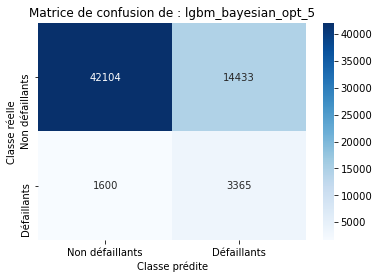

In [104]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_5,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_5')

In [131]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_5',
                                        1600, 14433, 3365, 42104, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_6**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
- en utilisant : class_weight='balanced' pour le déséquilibrage des classes
- en utilisant la métrique métier pour récupérer les meilleurs paramètres lors de la recherche bayésienne.
- avec les poids de pénalisation : taux_tn=1, taux_fp=-1, taux_fn=-10, taux_tp=0

[Source](https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9)

In [105]:
# Définition de l'objective fonction
def lgbm_eval_6(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                subsample_freq, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : int(round(subsample_freq)),
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='custom_score_2', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict(x_cv,
                             num_iteration=lgbm_clf.best_iteration_)
        
    return outils_model.custom_score_2(y_train, np.rint(cv_preds))

In [106]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_6 = \
    BayesianOptimization(lgbm_eval_6,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'subsample_freq' : (1, 7),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                         random_state=seed)

bayesian_opt_6 = lgbm_bayesian_opt_6.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7199   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |  4.502    |
|  2        |  0.7262   |  0.5348   |  10.34    |  14.99    |  18.36    |  0.04959  |  46.59    |  0.2279   |  0.2912   |  0.8797   |  3.306    |
|  3        |  0.7263   |  0.7044   |  9.567    |  25.3     |  69.06    |  0.09132  |  44.02    |  0.1555   |  0.05118  |  0.6493   |  2.704    |
|  4        |  0.7265   |  0.6636   |  8.301    |  45.83    |  21.31    |  0.07999  |  43.17    |  0.2549   |  0.08099  |  0.8074   |  4.917    |
|  5        |  0.7245   |  0.9905   |  7.455    |  46.24    |  22.09    |  0.03311  |  44.74    |  0.1525   |  0.06423  |  0

In [107]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_6.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.7468565222217374, 'max_depth': 10.349684409014966, 'min_child_samples': 41.14791632613863, 'min_child_weight': 13.777194653759024, 'min_split_gain': 0.041489043191464084, 'num_leaves': 49.930502191274854, 'reg_alpha': 0.041038136776446146, 'reg_lambda': 0.14331753950844098, 'subsample': 0.9104417331114183, 'subsample_freq': 2.6565415963890464}


In [132]:
param_lgbm_bayesian_opt_6 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 0.7468565222217374,
                             'max_depth': 10,
                             'min_child_samples': 41,
                             'min_child_weight': 13.777194653759024,
                             'min_split_gain': 0.041489043191464084,
                             'num_leaves': 50,
                             'reg_alpha': 0.041038136776446146,
                             'reg_lambda': 0.14331753950844098,
                             'subsample': 0.9104417331114183,
                             'subsample_freq' : 2,
                             'verbosity' : -1,
                             'seed' : seed}

In [133]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_6 = LGBMClassifier(**param_lgbm_bayesian_opt_6,
                                     force_col_wise=True)

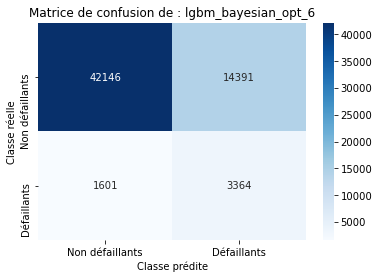

In [134]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_6,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_6')

In [135]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_6',
                                        1601, 14391, 3364, 42146, df_taux)

#### <span style='background:Moccasin'>6.4.3. Optimisation LGBM : BayesianOptimization - Score PR_AUC</span>

***
<span style='background:LightGreen'>**Modèle 7lgbm_bayesian_opt_7**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
- en utilisant : class_weight='balanced' pour le déséquilibrage des classes
- avec la métrique PR_AUC comme métrique d'évaluation lors de la recherche bayésienne.

In [108]:
# Définition de l'objective fonction
def lgbm_eval_7(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='pr_auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return average_precision_score(y_train, cv_preds)

In [109]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_7 = \
    BayesianOptimization(lgbm_eval_7,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                         random_state=seed)

bayesian_opt_7 = lgbm_bayesian_opt_7.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.2725   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |
|  2        |  0.2729   |  0.7918   |  6.348    |  70.06    |  14.99    |  0.01781  |  37.4     |  0.2592   |  0.2279   |  0.9852   |
|  3        |  0.2732   |  0.8797   |  7.921    |  35.65    |  58.5     |  0.02707  |  46.35    |  0.274    |  0.2285   |  0.7583   |
|  4        |  0.2725   |  0.5839   |  7.493    |  26.3     |  29.54    |  0.04601  |  38.61    |  0.066    |  0.2402   |  0.8633   |
|  5        |  0.2731   |  0.6062   |  7.244    |  31.84    |  38.34    |  0.08193  |  35.66    |  0.09261  |  0.1534   |  0.8499   |
|  6        |  0.2732   |  0.6227   |  8.424    |  19.81    | 

In [110]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_7.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.5758803179549261, 'max_depth': 9.312608872642194, 'min_child_samples': 47.64556389081002, 'min_child_weight': 16.41659788012688, 'min_split_gain': 0.07210580045795105, 'num_leaves': 49.40433266864818, 'reg_alpha': 0.22654087809017773, 'reg_lambda': 0.2356252144823949, 'subsample': 0.965619834468096}


In [136]:
param_lgbm_bayesian_opt_7 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 0.5758803179549261,
                             'max_depth': 9,
                             'min_child_samples': 48,
                             'min_child_weight': 16.41659788012688,
                             'min_split_gain': 0.07210580045795105,
                             'num_leaves': 49,
                             'reg_alpha': 0.22654087809017773,
                             'reg_lambda': 0.2356252144823949,
                             'subsample': 0.965619834468096,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

In [137]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_7 = LGBMClassifier(**param_lgbm_bayesian_opt_7,
                                     force_col_wise=True)

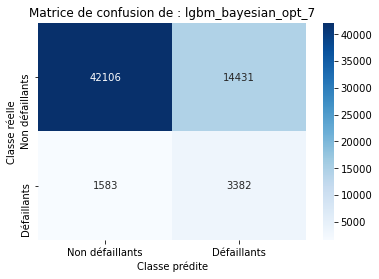

In [138]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_7,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_7')

In [139]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_7',
                                        1583, 14431, 3382, 42106, df_taux)

#### <span style='background:Moccasin'>6.4.3. Optimisation LGBM : BayesianOptimization - Score F10</span>

***
<span style='background:LightGreen'>**Modèle 7 lgbm_bayesian_opt_8**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
- en utilisant : class_weight='balanced' pour le déséquilibrage des classes
- avec la métrique F-mesure beta = 10 qui pénalise plus les faux négaifs que les faux positifs comme métrique d'évaluation lors de la recherche bayésienne.

In [111]:
# Définition de l'objective fonction
def lgbm_eval_8(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='pr_auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict(x_cv, num_iteration=lgbm_clf.best_iteration_)

    return fbeta_score(y_train, cv_preds, 10)

In [112]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_8 = \
    BayesianOptimization(lgbm_eval_8,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                         random_state=seed)

bayesian_opt_8 = lgbm_bayesian_opt_8.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6776   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |
|  2        |  0.6683   |  0.7918   |  6.348    |  70.06    |  14.99    |  0.01781  |  37.4     |  0.2592   |  0.2279   |  0.9852   |
|  3        |  0.6652   |  0.8797   |  7.921    |  35.65    |  58.5     |  0.02707  |  46.35    |  0.274    |  0.2285   |  0.7583   |
|  4        |  0.6684   |  0.5839   |  7.493    |  26.3     |  29.54    |  0.04601  |  38.61    |  0.066    |  0.2402   |  0.8633   |
|  5        |  0.6696   |  0.6062   |  7.244    |  31.84    |  38.34    |  0.08193  |  35.66    |  0.09261  |  0.1534   |  0.8499   |
|  6        |  0.6757   |  0.9861   |  7.364    |  56.39    | 

In [113]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_8.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.5, 'max_depth': 11.0, 'min_child_samples': 5.0, 'min_child_weight': 80.0, 'min_split_gain': 0.1, 'num_leaves': 25.0, 'reg_alpha': 0.3, 'reg_lambda': 0.1414004766286997, 'subsample': 0.5}


In [142]:
param_lgbm_bayesian_opt_8 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 0.5,
                             'max_depth': 11,
                             'min_child_samples': 5,
                             'min_child_weight': 80.0,
                             'min_split_gain': 0.1,
                             'num_leaves': 25,
                             'reg_alpha': 0.3,
                             'reg_lambda': 0.1414004766286997,
                             'subsample': 0.5,
                             'verbosity' : -1}

In [143]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_8 = LGBMClassifier(**param_lgbm_bayesian_opt_8,
                                     force_col_wise=True)

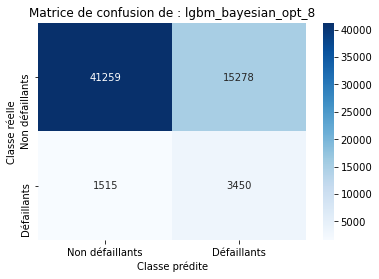

In [144]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_8,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_8')

In [145]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_8',
                                        1515, 15278, 3450, 41259, df_taux)

***
**Bilan** :
- L'optimisation avec la librairie bayes_opt égale celui du modèle LightGBM avec ces hyperparamètres de base avec le paramètre class_weight='balanced'.
- Soit la librairie n'est pas performante ou mal réglée par nos soins, soit les hyperparamètres de base sont très bien réglés.
- Nous tenterons d'utiliser la librairie d'optimisation bayésienne de scikit-learn : BayesSearchCV.

In [146]:
df_taux.sort_values(by='FN')

Modèle    FN     FP    TP     TN
17           lgbm_bayesian_opt_8  1515  15278  3450  41259
12           lgbm_bayesian_opt_4  1526  14937  3439  41600
3   lgbm_hyperparam_base_std_bal  1531  15075  3434  41462
11   lgbm_bayesian_opt_1_bis_bal  1533  14896  3432  41641
1       lgbm_hyperparam_base_bal  1536  15109  3429  41428
9        lgbm_bayesian_opt_1_bal  1541  14763  3424  41774
13           lgbm_bayesian_opt_9  1554  14809  3411  41728
16           lgbm_bayesian_opt_7  1583  14431  3382  42106
14           lgbm_bayesian_opt_5  1600  14433  3365  42104
15           lgbm_bayesian_opt_6  1601  14391  3364  42146
7            pycaret_lgbm_optuna  4694    229   271  56308
6          pycaret_lgbm_hyperopt  4698    231   267  56306
8            lgbm_bayesian_opt_1  4732    176   233  56361
10       lgbm_bayesian_opt_1_bis  4742    174   223  56363
0           lgbm_hyperparam_base  4758    165   207  56372
5    lgbm_hyperparam_base_robust  4769    158   196  56379
4    lgbm_hyperparam_base_minmax  4769    159   196  56378
2       lgbm_hyperparam_base_std  4771    158   194  56379

### <span style='background:PowderBlue'>6.5. Optimisation LGBM : BayesSearchCV</span>

In [15]:
# Lancer la recherche avec BayesSearchCV
def lancer_optimise_baysearch(optimizer, X, y):
    optimizer.fit(X_train, y_train)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print(f'Best CV score : {best_score} +/- {best_score_std}')
    print('Best Hyperparamètres :\n')
    print(best_params)

#### <span style='background:Moccasin'>6.5.1. Optimisation LGBM : BayesSearchCV - ROC_AUC</span>

In [115]:
# Modèle lgbm
lgbm_baysearch_opt_1 = LGBMClassifier(objective='binary')

In [116]:
# Hyperparamètres à optimiser
params_search_spaces = {'num_leaves': Integer(25, 50),
                        'max_depth': Integer(6, 11),
                        'min_split_gain' : Real(0, 0.1),
                        'min_child_weight' : Integer(5,80),
                        'min_child_samples' : Integer(5,80),
                        'colsample_bytree' : Real(0.5,1),
                        'reg_alpha' : Real(0.001, 0.3),
                        'reg_lambda' : Real(0.001, 0.3),
                        'subsample': Real(0.5, 1.0)}

In [117]:
# Initialisation de BayesSearchCV
baysearch_opt_1 = BayesSearchCV(lgbm_baysearch_opt_1,
                                params_search_spaces,
                                scoring=roc_auc,
                                cv=skf,
                                n_iter=100,
                                n_jobs=-1,  
                                return_train_score=False,
                                refit=True,
                                optimizer_kwargs={'base_estimator': 'GP'},
                                random_state=seed)

In [118]:
lancer_optimise_baysearch(baysearch_opt_1, X_train, y_train)

Best CV score : 0.7869737502543007 +/- 0.0022613289092364864
Best Hyperparamètres :

OrderedDict([('colsample_bytree', 0.681439488663085), ('max_depth', 11), ('min_child_samples', 6), ('min_child_weight', 80), ('min_split_gain', 0.1), ('num_leaves', 50), ('reg_alpha', 0.10528227997166746), ('reg_lambda', 0.001), ('subsample', 0.7380739528121625)])


In [147]:
param_lgbm_baysearch_opt_1 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 0.681439488663085,
                             'max_depth': 11,
                             'min_child_samples': 6,
                             'min_child_weight': 80,
                             'min_split_gain': 0.1,
                             'num_leaves': 50,
                             'reg_alpha': 0.10528227997166746,
                             'reg_lambda': 0.001,
                             'subsample': 0.7380739528121625,
                             'verbosity' : -1}

In [148]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_baysearch_opt_1 = LGBMClassifier(**param_lgbm_baysearch_opt_1,
                                      force_col_wise=True)

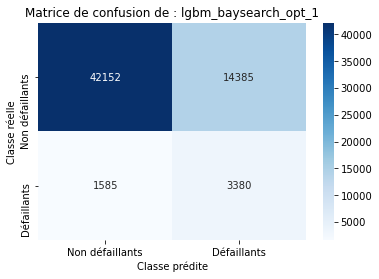

In [149]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_baysearch_opt_1,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_baysearch_opt_1')

In [150]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_baysearch_opt_1',
                                        1585, 14385, 3380, 42152, df_taux)

#### <span style='background:Moccasin'>6.5.2. Optimisation LGBM : BayesSearchCV - Métrique métier</span>

In [119]:
# Modèle lgbm
lgbm_baysearch_opt_2 = LGBMClassifier(objective='binary')

In [120]:
# Hyperparamètres à optimiser
params_search_spaces_2 = {'num_leaves': Integer(25, 50),
                          'max_depth': Integer(6, 11),
                          'min_split_gain' : Real(0, 0.1),
                          'min_child_weight' : Integer(5,80),
                          'min_child_samples' : Integer(5,80),
                          'colsample_bytree' : Real(0.5,1),
                          'reg_alpha' : Real(0.001, 0.3),
                          'reg_lambda' : Real(0.001, 0.3),
                          'subsample': Real(0.5, 1.0)}

In [121]:
# Initialisation de BayesSearchCV
baysearch_opt_2 = BayesSearchCV(lgbm_baysearch_opt_2,
                                params_search_spaces_2,
                                scoring=custom_score,
                                cv=skf,
                                n_iter=100,
                                n_jobs=-1,  
                                return_train_score=False,
                                refit=True,
                                optimizer_kwargs={'base_estimator': 'GP'},
                                random_state=seed)

In [122]:
lancer_optimise_baysearch(baysearch_opt_2, X_train, y_train)

Best CV score : 0.781809163830406 +/- 0.0007726555100356897
Best Hyperparamètres :

OrderedDict([('colsample_bytree', 1.0), ('max_depth', 11), ('min_child_samples', 69), ('min_child_weight', 43), ('min_split_gain', 0.01917879119594402), ('num_leaves', 50), ('reg_alpha', 0.3), ('reg_lambda', 0.0891289246294373), ('subsample', 1.0)])


In [151]:
param_lgbm_baysearch_opt_2 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 1.0,
                             'max_depth': 11,
                             'min_child_samples': 69,
                             'min_child_weight': 43,
                             'min_split_gain': 0.01917879119594402,
                             'num_leaves': 50,
                             'reg_alpha': 0.3,
                             'reg_lambda': 0.0891289246294373,
                             'subsample': 1.0,
                             'verbosity' : -1}

In [152]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_baysearch_opt_2 = LGBMClassifier(**param_lgbm_baysearch_opt_2,
                                      force_col_wise=True)

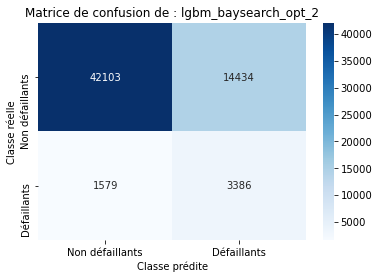

In [153]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_baysearch_opt_2,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_baysearch_opt_2')

In [154]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_baysearch_opt_2',
                                        1579, 14434, 3386, 42103, df_taux)

#### <span style='background:Moccasin'>6.5.3. Optimisation LGBM : BayesSearchCV - Score PR_AUC</span>

In [123]:
# Modèle lgbm
lgbm_baysearch_opt_3 = LGBMClassifier(objective='binary')

In [124]:
# Hyperparamètres à optimiser
params_search_spaces_3 = {'num_leaves': Integer(25, 50),
                          'max_depth': Integer(6, 11),
                          'min_split_gain' : Real(0, 0.1),
                          'min_child_weight' : Integer(5,80),
                          'min_child_samples' : Integer(5,80),
                          'colsample_bytree' : Real(0.5,1),
                          'reg_alpha' : Real(0.001, 0.3),
                          'reg_lambda' : Real(0.001, 0.3),
                          'subsample': Real(0.5, 1.0)}

In [125]:
# Initialisation de BayesSearchCV
baysearch_opt_3 = BayesSearchCV(lgbm_baysearch_opt_3,
                                params_search_spaces_3,
                                scoring=pr_auc,
                                cv=skf,
                                n_iter=100,
                                n_jobs=-1,  
                                return_train_score=False,
                                refit=True,
                                optimizer_kwargs={'base_estimator': 'GP'},
                                random_state=seed)

In [126]:
lancer_optimise_baysearch(baysearch_opt_3, X_train, y_train)

Best CV score : 0.27814163205811177 +/- 0.006267234903396196
Best Hyperparamètres :

OrderedDict([('colsample_bytree', 0.6492827143721486), ('max_depth', 9), ('min_child_samples', 80), ('min_child_weight', 80), ('min_split_gain', 0.0245433345723119), ('num_leaves', 50), ('reg_alpha', 0.3), ('reg_lambda', 0.29636273961282233), ('subsample', 0.5)])


In [155]:
param_lgbm_baysearch_opt_3 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 0.6492827143721486,
                             'max_depth': 9,
                             'min_child_samples': 80,
                             'min_child_weight': 80,
                             'min_split_gain': 0.0245433345723119,
                             'num_leaves': 50,
                             'reg_alpha': 0.3,
                             'reg_lambda': 0.29636273961282233,
                             'subsample': 0.5,
                             'verbosity' : -1}

In [156]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_baysearch_opt_3 = LGBMClassifier(**param_lgbm_baysearch_opt_3,
                                      force_col_wise=True)

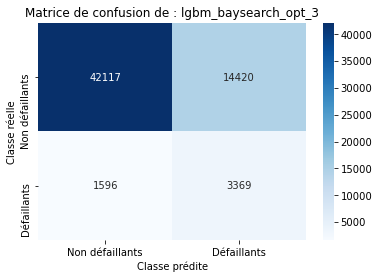

In [157]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_baysearch_opt_3,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_baysearch_opt_3')

In [158]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_baysearch_opt_3',
                                        1596, 14420, 3369, 42117, df_taux)

#### <span style='background:Moccasin'>6.5.4. Optimisation LGBM : BayesSearchCV - Score F10</span>

In [127]:
# Modèle lgbm
lgbm_baysearch_opt_4 = LGBMClassifier(objective='binary')

In [128]:
# Hyperparamètres à optimiser
params_search_spaces_4 = {'num_leaves': Integer(25, 50),
                          'max_depth': Integer(6, 11),
                          'min_split_gain' : Real(0, 0.1),
                          'min_child_weight' : Integer(5,80),
                          'min_child_samples' : Integer(5,80),
                          'colsample_bytree' : Real(0.5,1),
                          'reg_alpha' : Real(0.001, 0.3),
                          'reg_lambda' : Real(0.001, 0.3),
                          'subsample': Real(0.5, 1.0)}

In [129]:
# Initialisation de BayesSearchCV
baysearch_opt_4 = BayesSearchCV(lgbm_baysearch_opt_4,
                                params_search_spaces_4,
                                scoring=f10_score,
                                cv=skf,
                                n_iter=100,
                                n_jobs=-1,  
                                return_train_score=False,
                                refit=True,
                                optimizer_kwargs={'base_estimator': 'GP'},
                                random_state=seed)

In [130]:
lancer_optimise_baysearch(baysearch_opt_4, X_train, y_train)

Best CV score : 0.049185066443319235 +/- 0.0016181871906991777
Best Hyperparamètres :

OrderedDict([('colsample_bytree', 1.0), ('max_depth', 11), ('min_child_samples', 80), ('min_child_weight', 47), ('min_split_gain', 0.0), ('num_leaves', 50), ('reg_alpha', 0.001), ('reg_lambda', 0.001), ('subsample', 1.0)])


In [159]:
param_lgbm_baysearch_opt_4 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 1.0,
                             'max_depth': 11,
                             'min_child_samples': 80,
                             'min_child_weight': 47,
                             'min_split_gain': 0.0,
                             'num_leaves': 50,
                             'reg_alpha': 0.001,
                             'reg_lambda': 0.001,
                             'subsample': 1.0,
                             'verbosity' : -1}

In [160]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_baysearch_opt_4 = LGBMClassifier(**param_lgbm_baysearch_opt_4,
                                      force_col_wise=True)

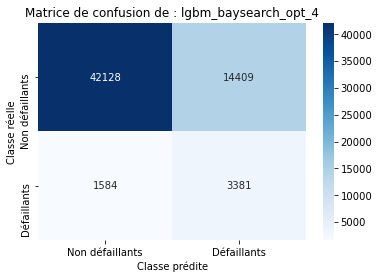

In [161]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_baysearch_opt_4,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_baysearch_opt_4')

In [162]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_baysearch_opt_4',
                                        1584, 14409, 3381, 42128, df_taux)

***
**Bilan** :
- L'optimisation avec la librairie BayesSearchCV égale celui du modèle LightGBM avec ces hyperparamètres de base avec le paramètre class_weight='balanced' mais les résultats pour les différents scores sont légèrement plus faibles avec la librairie de sckit-learn skopt que celle du MIT bayes_opt. 
- Soit la librairie n'est pas performante ou mal réglée par nos soins, soit les hyperparamètres de base sont très bien réglés.
- Nous tenterons d'utiliser la librairie d'optimisation bayésienne Optuna intégrée directement au modèle LightGBM.

In [163]:
mask = df_taux['FN']< 2000
df_taux[mask].sort_values(by='FN')

Modèle    FN     FP    TP     TN
17           lgbm_bayesian_opt_8  1515  15278  3450  41259
12           lgbm_bayesian_opt_4  1526  14937  3439  41600
3   lgbm_hyperparam_base_std_bal  1531  15075  3434  41462
11   lgbm_bayesian_opt_1_bis_bal  1533  14896  3432  41641
1       lgbm_hyperparam_base_bal  1536  15109  3429  41428
9        lgbm_bayesian_opt_1_bal  1541  14763  3424  41774
13           lgbm_bayesian_opt_9  1554  14809  3411  41728
19          lgbm_baysearch_opt_2  1579  14434  3386  42103
16           lgbm_bayesian_opt_7  1583  14431  3382  42106
21          lgbm_baysearch_opt_4  1584  14409  3381  42128
18          lgbm_baysearch_opt_1  1585  14385  3380  42152
20          lgbm_baysearch_opt_3  1596  14420  3369  42117
14           lgbm_bayesian_opt_5  1600  14433  3365  42104
15           lgbm_bayesian_opt_6  1601  14391  3364  42146

### <span style='background:PowderBlue'>6.5. Optimisation : OPTUNA intégré à LGBM</span>

LightGBM Tuner est l'un des modules d'intégration d'Optuna permettant d'optimiser les hyperparamètres de LightGBM.

Les seules paramètres supportés :

`supported_param_names = [ 
     "lambda_l1", 
     "lambda_l2", 
     "num_leaves", 
     "feature_fraction", 
     "bagging_fraction", 
     "bagging_freq", 
     "min_child_samples", 
 ]` 

[Source](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.lightgbm.LightGBMTunerCV.html) [Source](https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258)

#### <span style='background:Moccasin'>6.5.1. Optimisation LGBM : Optuna intégrée à LightGBM - Score ROC_AUC</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [164]:
# Modèle et hyperparamètres à étudier
def create_model(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 10000)
    max_depth = trial.suggest_int('max_depth', 3, 11)
#     learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    lambda_l1 = trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
    lambda_l2 = trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.4, 1.0),
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        class_weight='balanced',
#         n_estimators=n_estimators, 
        max_depth=max_depth, 
#         learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        num_leaves=num_leaves,
        feature_fraction=feature_fraction,
        bagging_fraction=bagging_fraction,
        bagging_freq=bagging_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [165]:
# Objective fonction
def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_proba)
    return score

In [166]:
# Recherche des p
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-08-11 15:59:36,757] A new study created in memory with name: no-name-f002a8b2-50a9-4523-9f56-697bb517c1b5


[LightGBM] [Warning] feature_fraction is set=0.5422561836351654, colsample_bytree=0.6359346653165009 will be ignored. Current value: feature_fraction=0.5422561836351654
[LightGBM] [Warning] lambda_l1 is set=0.0059677372008836915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0059677372008836915
[LightGBM] [Warning] bagging_fraction is set=0.5521888656056795, subsample=0.16376888767716696 will be ignored. Current value: bagging_fraction=0.5521888656056795
[LightGBM] [Warning] lambda_l2 is set=4.486648544104892e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.486648544104892e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 15:59:45,592] Trial 0 finished with value: 0.777346101059647 and parameters: {'max_depth': 6, 'subsample': 0.16376888767716696, 'colsample_bytree': 0.6359346653165009, 'lambda_l1': 0.0059677372008836915, 'lambda_l2': 4.486648544104892e-05, 'num_leaves': 134, 'feature_fraction': 0.5422561836351654, 'bagging_fraction': 0.5521888656056795, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 0 with value: 0.777346101059647.


[LightGBM] [Warning] feature_fraction is set=0.6007283194257651, colsample_bytree=0.3542697909209087 will be ignored. Current value: feature_fraction=0.6007283194257651
[LightGBM] [Warning] lambda_l1 is set=2.733105360732862e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.733105360732862e-05
[LightGBM] [Warning] bagging_fraction is set=0.7997862457911808, subsample=0.7515270119022779 will be ignored. Current value: bagging_fraction=0.7997862457911808
[LightGBM] [Warning] lambda_l2 is set=0.0013269210023226295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013269210023226295
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:00:02,135] Trial 1 finished with value: 0.7789234263631614 and parameters: {'max_depth': 11, 'subsample': 0.7515270119022779, 'colsample_bytree': 0.3542697909209087, 'lambda_l1': 2.733105360732862e-05, 'lambda_l2': 0.0013269210023226295, 'num_leaves': 161, 'feature_fraction': 0.6007283194257651, 'bagging_fraction': 0.7997862457911808, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 1 with value: 0.7789234263631614.


[LightGBM] [Warning] feature_fraction is set=0.4094600983474152, colsample_bytree=0.600821840790622 will be ignored. Current value: feature_fraction=0.4094600983474152
[LightGBM] [Warning] lambda_l1 is set=0.05035420747878061, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05035420747878061
[LightGBM] [Warning] bagging_fraction is set=0.9778232696527444, subsample=0.7571739859439116 will be ignored. Current value: bagging_fraction=0.9778232696527444
[LightGBM] [Warning] lambda_l2 is set=0.004701752379547444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004701752379547444
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:00:09,537] Trial 2 finished with value: 0.7723329557321328 and parameters: {'max_depth': 3, 'subsample': 0.7571739859439116, 'colsample_bytree': 0.600821840790622, 'lambda_l1': 0.05035420747878061, 'lambda_l2': 0.004701752379547444, 'num_leaves': 18, 'feature_fraction': 0.4094600983474152, 'bagging_fraction': 0.9778232696527444, 'bagging_freq': 7, 'min_child_samples': 32}. Best is trial 1 with value: 0.7789234263631614.


[LightGBM] [Warning] feature_fraction is set=0.7370421197325008, colsample_bytree=0.17207384943844473 will be ignored. Current value: feature_fraction=0.7370421197325008
[LightGBM] [Warning] lambda_l1 is set=1.427295470471459e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.427295470471459e-07
[LightGBM] [Warning] bagging_fraction is set=0.9462794255703957, subsample=0.5827444386917752 will be ignored. Current value: bagging_fraction=0.9462794255703957
[LightGBM] [Warning] lambda_l2 is set=0.12688726274201614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12688726274201614
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:00:23,532] Trial 3 finished with value: 0.783210410329191 and parameters: {'max_depth': 7, 'subsample': 0.5827444386917752, 'colsample_bytree': 0.17207384943844473, 'lambda_l1': 1.427295470471459e-07, 'lambda_l2': 0.12688726274201614, 'num_leaves': 137, 'feature_fraction': 0.7370421197325008, 'bagging_fraction': 0.9462794255703957, 'bagging_freq': 4, 'min_child_samples': 97}. Best is trial 3 with value: 0.783210410329191.


[LightGBM] [Warning] feature_fraction is set=0.8607403951342654, colsample_bytree=0.11768344073665711 will be ignored. Current value: feature_fraction=0.8607403951342654
[LightGBM] [Warning] lambda_l1 is set=1.8413286626046008e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8413286626046008e-07
[LightGBM] [Warning] bagging_fraction is set=0.850683894877055, subsample=0.11676096451580381 will be ignored. Current value: bagging_fraction=0.850683894877055
[LightGBM] [Warning] lambda_l2 is set=0.0001270147989186772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001270147989186772
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:00:36,086] Trial 4 finished with value: 0.7821672306816303 and parameters: {'max_depth': 6, 'subsample': 0.11676096451580381, 'colsample_bytree': 0.11768344073665711, 'lambda_l1': 1.8413286626046008e-07, 'lambda_l2': 0.0001270147989186772, 'num_leaves': 122, 'feature_fraction': 0.8607403951342654, 'bagging_fraction': 0.850683894877055, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 3 with value: 0.783210410329191.


[LightGBM] [Warning] feature_fraction is set=0.41699836693696535, colsample_bytree=0.2700732194909423 will be ignored. Current value: feature_fraction=0.41699836693696535
[LightGBM] [Warning] lambda_l1 is set=3.9042500585402456e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9042500585402456e-08
[LightGBM] [Warning] bagging_fraction is set=0.4784953187147582, subsample=0.33690968266515586 will be ignored. Current value: bagging_fraction=0.4784953187147582
[LightGBM] [Warning] lambda_l2 is set=0.26639476478995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26639476478995
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-11 16:00:43,464] Trial 5 finished with value: 0.7790362168873325 and parameters: {'max_depth': 5, 'subsample': 0.33690968266515586, 'colsample_bytree': 0.2700732194909423, 'lambda_l1': 3.9042500585402456e-08, 'lambda_l2': 0.26639476478995, 'num_leaves': 29, 'feature_fraction': 0.41699836693696535, 'bagging_fraction': 0.4784953187147582, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 3 with value: 0.783210410329191.


[LightGBM] [Warning] feature_fraction is set=0.43309938665030345, colsample_bytree=0.31541681147776757 will be ignored. Current value: feature_fraction=0.43309938665030345
[LightGBM] [Warning] lambda_l1 is set=9.626964450176855e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.626964450176855e-08
[LightGBM] [Warning] bagging_fraction is set=0.4001509902557634, subsample=0.4924286027568594 will be ignored. Current value: bagging_fraction=0.4001509902557634
[LightGBM] [Warning] lambda_l2 is set=1.6260245918398002e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6260245918398002e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-08-11 16:00:50,253] Trial 6 finished with value: 0.7750095121694941 and parameters: {'max_depth': 4, 'subsample': 0.4924286027568594, 'colsample_bytree': 0.31541681147776757, 'lambda_l1': 9.626964450176855e-08, 'lambda_l2': 1.6260245918398002e-07, 'num_leaves': 239, 'feature_fraction': 0.43309938665030345, 'bagging_fraction': 0.4001509902557634, 'bagging_freq': 2, 'min_child_samples': 71}. Best is trial 3 with value: 0.783210410329191.


[LightGBM] [Warning] feature_fraction is set=0.8432357907859036, colsample_bytree=0.721194828545989 will be ignored. Current value: feature_fraction=0.8432357907859036
[LightGBM] [Warning] lambda_l1 is set=1.3002359992138524e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3002359992138524e-08
[LightGBM] [Warning] bagging_fraction is set=0.9937226118157604, subsample=0.14068274298186037 will be ignored. Current value: bagging_fraction=0.9937226118157604
[LightGBM] [Warning] lambda_l2 is set=3.3565414036725496e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3565414036725496e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:01:01,793] Trial 7 finished with value: 0.7819723365217381 and parameters: {'max_depth': 5, 'subsample': 0.14068274298186037, 'colsample_bytree': 0.721194828545989, 'lambda_l1': 1.3002359992138524e-08, 'lambda_l2': 3.3565414036725496e-06, 'num_leaves': 219, 'feature_fraction': 0.8432357907859036, 'bagging_fraction': 0.9937226118157604, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 3 with value: 0.783210410329191.


[LightGBM] [Warning] feature_fraction is set=0.8448452959868376, colsample_bytree=0.9041395476795879 will be ignored. Current value: feature_fraction=0.8448452959868376
[LightGBM] [Warning] lambda_l1 is set=0.0015497702383605117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015497702383605117
[LightGBM] [Warning] bagging_fraction is set=0.520340767003681, subsample=0.2504096390147554 will be ignored. Current value: bagging_fraction=0.520340767003681
[LightGBM] [Warning] lambda_l2 is set=3.648410898062007e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.648410898062007e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-08-11 16:01:15,176] Trial 8 finished with value: 0.7755403376280905 and parameters: {'max_depth': 8, 'subsample': 0.2504096390147554, 'colsample_bytree': 0.9041395476795879, 'lambda_l1': 0.0015497702383605117, 'lambda_l2': 3.648410898062007e-08, 'num_leaves': 256, 'feature_fraction': 0.8448452959868376, 'bagging_fraction': 0.520340767003681, 'bagging_freq': 2, 'min_child_samples': 84}. Best is trial 3 with value: 0.783210410329191.


[LightGBM] [Warning] feature_fraction is set=0.8556033485014168, colsample_bytree=0.1682494094149801 will be ignored. Current value: feature_fraction=0.8556033485014168
[LightGBM] [Warning] lambda_l1 is set=0.0004846759761525496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004846759761525496
[LightGBM] [Warning] bagging_fraction is set=0.88801793230524, subsample=0.30211209736370426 will be ignored. Current value: bagging_fraction=0.88801793230524
[LightGBM] [Warning] lambda_l2 is set=3.144121210191597e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.144121210191597e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:01:26,107] Trial 9 finished with value: 0.780912057145299 and parameters: {'max_depth': 5, 'subsample': 0.30211209736370426, 'colsample_bytree': 0.1682494094149801, 'lambda_l1': 0.0004846759761525496, 'lambda_l2': 3.144121210191597e-08, 'num_leaves': 205, 'feature_fraction': 0.8556033485014168, 'bagging_fraction': 0.88801793230524, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 3 with value: 0.783210410329191.


[LightGBM] [Warning] feature_fraction is set=0.9956448109535607, colsample_bytree=0.45653949769582736 will be ignored. Current value: feature_fraction=0.9956448109535607
[LightGBM] [Warning] lambda_l1 is set=8.141024126010059e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.141024126010059e-06
[LightGBM] [Warning] bagging_fraction is set=0.7022422638886802, subsample=0.9241758461189248 will be ignored. Current value: bagging_fraction=0.7022422638886802
[LightGBM] [Warning] lambda_l2 is set=7.103168776252835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.103168776252835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-08-11 16:01:41,495] Trial 10 finished with value: 0.7830964441986595 and parameters: {'max_depth': 9, 'subsample': 0.9241758461189248, 'colsample_bytree': 0.45653949769582736, 'lambda_l1': 8.141024126010059e-06, 'lambda_l2': 7.103168776252835, 'num_leaves': 73, 'feature_fraction': 0.9956448109535607, 'bagging_fraction': 0.7022422638886802, 'bagging_freq': 1, 'min_child_samples': 96}. Best is trial 3 with value: 0.783210410329191.


[LightGBM] [Warning] feature_fraction is set=0.9654756635671918, colsample_bytree=0.43969726654835084 will be ignored. Current value: feature_fraction=0.9654756635671918
[LightGBM] [Warning] lambda_l1 is set=4.096802063456579e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.096802063456579e-06
[LightGBM] [Warning] bagging_fraction is set=0.6546224612414739, subsample=0.9968991265670702 will be ignored. Current value: bagging_fraction=0.6546224612414739
[LightGBM] [Warning] lambda_l2 is set=9.340309051694897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.340309051694897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-08-11 16:01:56,563] Trial 11 finished with value: 0.7828834742003654 and parameters: {'max_depth': 9, 'subsample': 0.9968991265670702, 'colsample_bytree': 0.43969726654835084, 'lambda_l1': 4.096802063456579e-06, 'lambda_l2': 9.340309051694897, 'num_leaves': 81, 'feature_fraction': 0.9654756635671918, 'bagging_fraction': 0.6546224612414739, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 3 with value: 0.783210410329191.


[LightGBM] [Warning] feature_fraction is set=0.7144050714315703, colsample_bytree=0.4682421732636341 will be ignored. Current value: feature_fraction=0.7144050714315703
[LightGBM] [Warning] lambda_l1 is set=4.762708178495562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.762708178495562
[LightGBM] [Warning] bagging_fraction is set=0.6591421642850542, subsample=0.9575709430334953 will be ignored. Current value: bagging_fraction=0.6591421642850542
[LightGBM] [Warning] lambda_l2 is set=6.536898606808597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.536898606808597
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:02:09,461] Trial 12 finished with value: 0.7829247344211716 and parameters: {'max_depth': 10, 'subsample': 0.9575709430334953, 'colsample_bytree': 0.4682421732636341, 'lambda_l1': 4.762708178495562, 'lambda_l2': 6.536898606808597, 'num_leaves': 71, 'feature_fraction': 0.7144050714315703, 'bagging_fraction': 0.6591421642850542, 'bagging_freq': 4, 'min_child_samples': 99}. Best is trial 3 with value: 0.783210410329191.


[LightGBM] [Warning] feature_fraction is set=0.9693351924711588, colsample_bytree=0.10561316026480025 will be ignored. Current value: feature_fraction=0.9693351924711588
[LightGBM] [Warning] lambda_l1 is set=5.156281090561321e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.156281090561321e-06
[LightGBM] [Warning] bagging_fraction is set=0.7636247489786012, subsample=0.7942773709154187 will be ignored. Current value: bagging_fraction=0.7636247489786012
[LightGBM] [Warning] lambda_l2 is set=0.1191876381182393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1191876381182393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-08-11 16:02:24,404] Trial 13 finished with value: 0.7805027608848192 and parameters: {'max_depth': 8, 'subsample': 0.7942773709154187, 'colsample_bytree': 0.10561316026480025, 'lambda_l1': 5.156281090561321e-06, 'lambda_l2': 0.1191876381182393, 'num_leaves': 80, 'feature_fraction': 0.9693351924711588, 'bagging_fraction': 0.7636247489786012, 'bagging_freq': 1, 'min_child_samples': 79}. Best is trial 3 with value: 0.783210410329191.


[LightGBM] [Warning] feature_fraction is set=0.7351560544888229, colsample_bytree=0.7833036373649469 will be ignored. Current value: feature_fraction=0.7351560544888229
[LightGBM] [Warning] lambda_l1 is set=1.1139880426294322e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1139880426294322e-06
[LightGBM] [Warning] bagging_fraction is set=0.9376639257827402, subsample=0.5727476326009446 will be ignored. Current value: bagging_fraction=0.9376639257827402
[LightGBM] [Warning] lambda_l2 is set=0.2810871042893049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2810871042893049
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-11 16:02:41,245] Trial 14 finished with value: 0.7800117386076306 and parameters: {'max_depth': 8, 'subsample': 0.5727476326009446, 'colsample_bytree': 0.7833036373649469, 'lambda_l1': 1.1139880426294322e-06, 'lambda_l2': 0.2810871042893049, 'num_leaves': 161, 'feature_fraction': 0.7351560544888229, 'bagging_fraction': 0.9376639257827402, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 3 with value: 0.783210410329191.


[LightGBM] [Warning] feature_fraction is set=0.6132582872425396, colsample_bytree=0.22293186718399038 will be ignored. Current value: feature_fraction=0.6132582872425396
[LightGBM] [Warning] lambda_l1 is set=1.4057829282922495e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4057829282922495e-05
[LightGBM] [Warning] bagging_fraction is set=0.7333100763679377, subsample=0.5951238834645224 will be ignored. Current value: bagging_fraction=0.7333100763679377
[LightGBM] [Warning] lambda_l2 is set=0.04069571268579062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04069571268579062
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:02:53,069] Trial 15 finished with value: 0.7832127544170246 and parameters: {'max_depth': 11, 'subsample': 0.5951238834645224, 'colsample_bytree': 0.22293186718399038, 'lambda_l1': 1.4057829282922495e-05, 'lambda_l2': 0.04069571268579062, 'num_leaves': 53, 'feature_fraction': 0.6132582872425396, 'bagging_fraction': 0.7333100763679377, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 15 with value: 0.7832127544170246.


[LightGBM] [Warning] feature_fraction is set=0.6117409588488588, colsample_bytree=0.18997636815666152 will be ignored. Current value: feature_fraction=0.6117409588488588
[LightGBM] [Warning] lambda_l1 is set=0.0001463964279179991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001463964279179991
[LightGBM] [Warning] bagging_fraction is set=0.7449885668073104, subsample=0.6100650054016772 will be ignored. Current value: bagging_fraction=0.7449885668073104
[LightGBM] [Warning] lambda_l2 is set=0.019323200705913233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019323200705913233
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:03:07,360] Trial 16 finished with value: 0.7807983475107007 and parameters: {'max_depth': 11, 'subsample': 0.6100650054016772, 'colsample_bytree': 0.18997636815666152, 'lambda_l1': 0.0001463964279179991, 'lambda_l2': 0.019323200705913233, 'num_leaves': 117, 'feature_fraction': 0.6117409588488588, 'bagging_fraction': 0.7449885668073104, 'bagging_freq': 5, 'min_child_samples': 88}. Best is trial 15 with value: 0.7832127544170246.


[LightGBM] [Warning] feature_fraction is set=0.6379862993293852, colsample_bytree=0.23131799165084044 will be ignored. Current value: feature_fraction=0.6379862993293852
[LightGBM] [Warning] lambda_l1 is set=2.991145769348474e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.991145769348474e-07
[LightGBM] [Warning] bagging_fraction is set=0.6109447716263913, subsample=0.4606246496797993 will be ignored. Current value: bagging_fraction=0.6109447716263913
[LightGBM] [Warning] lambda_l2 is set=0.032987347825953015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032987347825953015
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:03:17,698] Trial 17 finished with value: 0.7813404160410349 and parameters: {'max_depth': 10, 'subsample': 0.4606246496797993, 'colsample_bytree': 0.23131799165084044, 'lambda_l1': 2.991145769348474e-07, 'lambda_l2': 0.032987347825953015, 'num_leaves': 44, 'feature_fraction': 0.6379862993293852, 'bagging_fraction': 0.6109447716263913, 'bagging_freq': 5, 'min_child_samples': 51}. Best is trial 15 with value: 0.7832127544170246.


[LightGBM] [Warning] feature_fraction is set=0.5038641931317439, colsample_bytree=0.10019620495333362 will be ignored. Current value: feature_fraction=0.5038641931317439
[LightGBM] [Warning] lambda_l1 is set=4.593058878409738e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.593058878409738e-05
[LightGBM] [Warning] bagging_fraction is set=0.8774660496241129, subsample=0.6663722207866826 will be ignored. Current value: bagging_fraction=0.8774660496241129
[LightGBM] [Warning] lambda_l2 is set=0.4917917861093314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4917917861093314
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:03:25,187] Trial 18 finished with value: 0.772710621056631 and parameters: {'max_depth': 3, 'subsample': 0.6663722207866826, 'colsample_bytree': 0.10019620495333362, 'lambda_l1': 4.593058878409738e-05, 'lambda_l2': 0.4917917861093314, 'num_leaves': 173, 'feature_fraction': 0.5038641931317439, 'bagging_fraction': 0.8774660496241129, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 15 with value: 0.7832127544170246.


[LightGBM] [Warning] feature_fraction is set=0.7644313342335498, colsample_bytree=0.3802938919472916 will be ignored. Current value: feature_fraction=0.7644313342335498
[LightGBM] [Warning] lambda_l1 is set=0.07520934559571281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07520934559571281
[LightGBM] [Warning] bagging_fraction is set=0.8199432308191089, subsample=0.3873174339595674 will be ignored. Current value: bagging_fraction=0.8199432308191089
[LightGBM] [Warning] lambda_l2 is set=0.0006210745193920769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006210745193920769
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-11 16:03:38,630] Trial 19 finished with value: 0.7813363691052001 and parameters: {'max_depth': 7, 'subsample': 0.3873174339595674, 'colsample_bytree': 0.3802938919472916, 'lambda_l1': 0.07520934559571281, 'lambda_l2': 0.0006210745193920769, 'num_leaves': 104, 'feature_fraction': 0.7644313342335498, 'bagging_fraction': 0.8199432308191089, 'bagging_freq': 3, 'min_child_samples': 93}. Best is trial 15 with value: 0.7832127544170246.


[LightGBM] [Warning] feature_fraction is set=0.6611764999639174, colsample_bytree=0.24362029274111063 will be ignored. Current value: feature_fraction=0.6611764999639174
[LightGBM] [Warning] lambda_l1 is set=1.1323745889636637e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1323745889636637e-08
[LightGBM] [Warning] bagging_fraction is set=0.954515453105179, subsample=0.6742536731930098 will be ignored. Current value: bagging_fraction=0.954515453105179
[LightGBM] [Warning] lambda_l2 is set=1.8596286438637746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8596286438637746
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:03:52,519] Trial 20 finished with value: 0.7838466021796703 and parameters: {'max_depth': 10, 'subsample': 0.6742536731930098, 'colsample_bytree': 0.24362029274111063, 'lambda_l1': 1.1323745889636637e-08, 'lambda_l2': 1.8596286438637746, 'num_leaves': 52, 'feature_fraction': 0.6611764999639174, 'bagging_fraction': 0.954515453105179, 'bagging_freq': 4, 'min_child_samples': 78}. Best is trial 20 with value: 0.7838466021796703.


[LightGBM] [Warning] feature_fraction is set=0.6708785288789922, colsample_bytree=0.24886763837478754 will be ignored. Current value: feature_fraction=0.6708785288789922
[LightGBM] [Warning] lambda_l1 is set=1.2764514880098545e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2764514880098545e-08
[LightGBM] [Warning] bagging_fraction is set=0.9365562070161882, subsample=0.681016949839236 will be ignored. Current value: bagging_fraction=0.9365562070161882
[LightGBM] [Warning] lambda_l2 is set=1.573344621293449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.573344621293449
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:04:00,468] Trial 21 finished with value: 0.7683607172132159 and parameters: {'max_depth': 11, 'subsample': 0.681016949839236, 'colsample_bytree': 0.24886763837478754, 'lambda_l1': 1.2764514880098545e-08, 'lambda_l2': 1.573344621293449, 'num_leaves': 4, 'feature_fraction': 0.6708785288789922, 'bagging_fraction': 0.9365562070161882, 'bagging_freq': 4, 'min_child_samples': 78}. Best is trial 20 with value: 0.7838466021796703.


[LightGBM] [Warning] feature_fraction is set=0.7843902445956258, colsample_bytree=0.14923062170888485 will be ignored. Current value: feature_fraction=0.7843902445956258
[LightGBM] [Warning] lambda_l1 is set=4.650727779751599e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.650727779751599e-07
[LightGBM] [Warning] bagging_fraction is set=0.9284447541192707, subsample=0.8640445515094672 will be ignored. Current value: bagging_fraction=0.9284447541192707
[LightGBM] [Warning] lambda_l2 is set=0.008958209998655244, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008958209998655244
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:04:14,351] Trial 22 finished with value: 0.7840552117471005 and parameters: {'max_depth': 10, 'subsample': 0.8640445515094672, 'colsample_bytree': 0.14923062170888485, 'lambda_l1': 4.650727779751599e-07, 'lambda_l2': 0.008958209998655244, 'num_leaves': 44, 'feature_fraction': 0.7843902445956258, 'bagging_fraction': 0.9284447541192707, 'bagging_freq': 5, 'min_child_samples': 88}. Best is trial 22 with value: 0.7840552117471005.


[LightGBM] [Warning] feature_fraction is set=0.5437907227424663, colsample_bytree=0.30349672355739704 will be ignored. Current value: feature_fraction=0.5437907227424663
[LightGBM] [Warning] lambda_l1 is set=1.6945299798504787e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6945299798504787e-06
[LightGBM] [Warning] bagging_fraction is set=0.9057495195873293, subsample=0.8730974915230745 will be ignored. Current value: bagging_fraction=0.9057495195873293
[LightGBM] [Warning] lambda_l2 is set=0.006102180694391429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006102180694391429
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:04:26,596] Trial 23 finished with value: 0.7837183649004126 and parameters: {'max_depth': 10, 'subsample': 0.8730974915230745, 'colsample_bytree': 0.30349672355739704, 'lambda_l1': 1.6945299798504787e-06, 'lambda_l2': 0.006102180694391429, 'num_leaves': 52, 'feature_fraction': 0.5437907227424663, 'bagging_fraction': 0.9057495195873293, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 22 with value: 0.7840552117471005.


[LightGBM] [Warning] feature_fraction is set=0.5296665420881064, colsample_bytree=0.3064736078293072 will be ignored. Current value: feature_fraction=0.5296665420881064
[LightGBM] [Warning] lambda_l1 is set=1.0092648488291862e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0092648488291862e-06
[LightGBM] [Warning] bagging_fraction is set=0.9960268510913208, subsample=0.8663671748664233 will be ignored. Current value: bagging_fraction=0.9960268510913208
[LightGBM] [Warning] lambda_l2 is set=1.4153563737145886e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4153563737145886e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:04:32,942] Trial 24 finished with value: 0.7520825359026175 and parameters: {'max_depth': 10, 'subsample': 0.8663671748664233, 'colsample_bytree': 0.3064736078293072, 'lambda_l1': 1.0092648488291862e-06, 'lambda_l2': 1.4153563737145886e-05, 'num_leaves': 2, 'feature_fraction': 0.5296665420881064, 'bagging_fraction': 0.9960268510913208, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 22 with value: 0.7840552117471005.


[LightGBM] [Warning] feature_fraction is set=0.7847346927164403, colsample_bytree=0.3870670266184958 will be ignored. Current value: feature_fraction=0.7847346927164403
[LightGBM] [Warning] lambda_l1 is set=1.421987547849709e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.421987547849709e-08
[LightGBM] [Warning] bagging_fraction is set=0.8935365977054044, subsample=0.8582498665389429 will be ignored. Current value: bagging_fraction=0.8935365977054044
[LightGBM] [Warning] lambda_l2 is set=0.0034173771876623194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034173771876623194
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:04:45,881] Trial 25 finished with value: 0.7842085927526966 and parameters: {'max_depth': 9, 'subsample': 0.8582498665389429, 'colsample_bytree': 0.3870670266184958, 'lambda_l1': 1.421987547849709e-08, 'lambda_l2': 0.0034173771876623194, 'num_leaves': 39, 'feature_fraction': 0.7847346927164403, 'bagging_fraction': 0.8935365977054044, 'bagging_freq': 5, 'min_child_samples': 74}. Best is trial 25 with value: 0.7842085927526966.


[LightGBM] [Warning] feature_fraction is set=0.7845791812934046, colsample_bytree=0.39457579138335563 will be ignored. Current value: feature_fraction=0.7845791812934046
[LightGBM] [Warning] lambda_l1 is set=2.382629982817331e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.382629982817331e-08
[LightGBM] [Warning] bagging_fraction is set=0.8413055323380871, subsample=0.8055183488735485 will be ignored. Current value: bagging_fraction=0.8413055323380871
[LightGBM] [Warning] lambda_l2 is set=0.0033959694024053117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0033959694024053117
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:04:57,408] Trial 26 finished with value: 0.7845765611059434 and parameters: {'max_depth': 9, 'subsample': 0.8055183488735485, 'colsample_bytree': 0.39457579138335563, 'lambda_l1': 2.382629982817331e-08, 'lambda_l2': 0.0033959694024053117, 'num_leaves': 26, 'feature_fraction': 0.7845791812934046, 'bagging_fraction': 0.8413055323380871, 'bagging_freq': 5, 'min_child_samples': 77}. Best is trial 26 with value: 0.7845765611059434.


[LightGBM] [Warning] feature_fraction is set=0.7967404523837166, colsample_bytree=0.5457192524284741 will be ignored. Current value: feature_fraction=0.7967404523837166
[LightGBM] [Warning] lambda_l1 is set=3.4422268723891094e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4422268723891094e-08
[LightGBM] [Warning] bagging_fraction is set=0.8124316787254636, subsample=0.8198926970004353 will be ignored. Current value: bagging_fraction=0.8124316787254636
[LightGBM] [Warning] lambda_l2 is set=0.002161695917712042, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002161695917712042
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:05:08,490] Trial 27 finished with value: 0.7819699674967997 and parameters: {'max_depth': 9, 'subsample': 0.8198926970004353, 'colsample_bytree': 0.5457192524284741, 'lambda_l1': 3.4422268723891094e-08, 'lambda_l2': 0.002161695917712042, 'num_leaves': 24, 'feature_fraction': 0.7967404523837166, 'bagging_fraction': 0.8124316787254636, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 26 with value: 0.7845765611059434.


[LightGBM] [Warning] feature_fraction is set=0.9253725998705286, colsample_bytree=0.41082537191055746 will be ignored. Current value: feature_fraction=0.9253725998705286
[LightGBM] [Warning] lambda_l1 is set=4.5164186518741205e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5164186518741205e-07
[LightGBM] [Warning] bagging_fraction is set=0.8430691039204337, subsample=0.9968143475421789 will be ignored. Current value: bagging_fraction=0.8430691039204337
[LightGBM] [Warning] lambda_l2 is set=0.0006033966269531495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006033966269531495
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:05:15,846] Trial 28 finished with value: 0.7638223066711332 and parameters: {'max_depth': 9, 'subsample': 0.9968143475421789, 'colsample_bytree': 0.41082537191055746, 'lambda_l1': 4.5164186518741205e-07, 'lambda_l2': 0.0006033966269531495, 'num_leaves': 3, 'feature_fraction': 0.9253725998705286, 'bagging_fraction': 0.8430691039204337, 'bagging_freq': 5, 'min_child_samples': 40}. Best is trial 26 with value: 0.7845765611059434.


[LightGBM] [Warning] feature_fraction is set=0.7977873898259702, colsample_bytree=0.5462593034316136 will be ignored. Current value: feature_fraction=0.7977873898259702
[LightGBM] [Warning] lambda_l1 is set=3.895197719684011e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.895197719684011e-08
[LightGBM] [Warning] bagging_fraction is set=0.9065699978827877, subsample=0.8982951400843505 will be ignored. Current value: bagging_fraction=0.9065699978827877
[LightGBM] [Warning] lambda_l2 is set=7.255786406694571e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.255786406694571e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:05:30,945] Trial 29 finished with value: 0.7814129580783581 and parameters: {'max_depth': 8, 'subsample': 0.8982951400843505, 'colsample_bytree': 0.5462593034316136, 'lambda_l1': 3.895197719684011e-08, 'lambda_l2': 7.255786406694571e-05, 'num_leaves': 99, 'feature_fraction': 0.7977873898259702, 'bagging_fraction': 0.9065699978827877, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 26 with value: 0.7845765611059434.


[LightGBM] [Warning] feature_fraction is set=0.9085116177272501, colsample_bytree=0.5051539093825923 will be ignored. Current value: feature_fraction=0.9085116177272501
[LightGBM] [Warning] lambda_l1 is set=1.4940541801861323e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4940541801861323e-08
[LightGBM] [Warning] bagging_fraction is set=0.862210480613423, subsample=0.8362741724480377 will be ignored. Current value: bagging_fraction=0.862210480613423
[LightGBM] [Warning] lambda_l2 is set=1.3019388601577825e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3019388601577825e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:05:44,251] Trial 30 finished with value: 0.7851265631979886 and parameters: {'max_depth': 9, 'subsample': 0.8362741724480377, 'colsample_bytree': 0.5051539093825923, 'lambda_l1': 1.4940541801861323e-08, 'lambda_l2': 1.3019388601577825e-05, 'num_leaves': 35, 'feature_fraction': 0.9085116177272501, 'bagging_fraction': 0.862210480613423, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.9070564642462803, colsample_bytree=0.5105480786392159 will be ignored. Current value: feature_fraction=0.9070564642462803
[LightGBM] [Warning] lambda_l1 is set=1.036227414858203e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.036227414858203e-08
[LightGBM] [Warning] bagging_fraction is set=0.7763301950854254, subsample=0.8239961991054766 will be ignored. Current value: bagging_fraction=0.7763301950854254
[LightGBM] [Warning] lambda_l2 is set=1.2600883801907728e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2600883801907728e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:05:56,824] Trial 31 finished with value: 0.782686357075719 and parameters: {'max_depth': 9, 'subsample': 0.8239961991054766, 'colsample_bytree': 0.5105480786392159, 'lambda_l1': 1.036227414858203e-08, 'lambda_l2': 1.2600883801907728e-05, 'num_leaves': 36, 'feature_fraction': 0.9070564642462803, 'bagging_fraction': 0.7763301950854254, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.7861949596716322, colsample_bytree=0.6211783734944997 will be ignored. Current value: feature_fraction=0.7861949596716322
[LightGBM] [Warning] lambda_l1 is set=6.406144707296289e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.406144707296289e-08
[LightGBM] [Warning] bagging_fraction is set=0.8534158063462608, subsample=0.7252244564100803 will be ignored. Current value: bagging_fraction=0.8534158063462608
[LightGBM] [Warning] lambda_l2 is set=1.4671542125813825e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4671542125813825e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:06:07,308] Trial 32 finished with value: 0.7815293573578113 and parameters: {'max_depth': 8, 'subsample': 0.7252244564100803, 'colsample_bytree': 0.6211783734944997, 'lambda_l1': 6.406144707296289e-08, 'lambda_l2': 1.4671542125813825e-06, 'num_leaves': 16, 'feature_fraction': 0.7861949596716322, 'bagging_fraction': 0.8534158063462608, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8867214991199481, colsample_bytree=0.36574944353027483 will be ignored. Current value: feature_fraction=0.8867214991199481
[LightGBM] [Warning] lambda_l1 is set=1.218102771346113e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.218102771346113e-08
[LightGBM] [Warning] bagging_fraction is set=0.8003503940920481, subsample=0.9386201690453173 will be ignored. Current value: bagging_fraction=0.8003503940920481
[LightGBM] [Warning] lambda_l2 is set=0.007935778907693397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007935778907693397
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:06:21,303] Trial 33 finished with value: 0.7837507617617502 and parameters: {'max_depth': 9, 'subsample': 0.9386201690453173, 'colsample_bytree': 0.36574944353027483, 'lambda_l1': 1.218102771346113e-08, 'lambda_l2': 0.007935778907693397, 'num_leaves': 57, 'feature_fraction': 0.8867214991199481, 'bagging_fraction': 0.8003503940920481, 'bagging_freq': 5, 'min_child_samples': 88}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8064714019508921, colsample_bytree=0.6882876541613314 will be ignored. Current value: feature_fraction=0.8064714019508921
[LightGBM] [Warning] lambda_l1 is set=2.9677688643123964e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9677688643123964e-07
[LightGBM] [Warning] bagging_fraction is set=0.880560350088366, subsample=0.7606131002710745 will be ignored. Current value: bagging_fraction=0.880560350088366
[LightGBM] [Warning] lambda_l2 is set=0.00024982220636080526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024982220636080526
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:06:32,315] Trial 34 finished with value: 0.782443989793528 and parameters: {'max_depth': 10, 'subsample': 0.7606131002710745, 'colsample_bytree': 0.6882876541613314, 'lambda_l1': 2.9677688643123964e-07, 'lambda_l2': 0.00024982220636080526, 'num_leaves': 18, 'feature_fraction': 0.8064714019508921, 'bagging_fraction': 0.880560350088366, 'bagging_freq': 7, 'min_child_samples': 67}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.7539104008527813, colsample_bytree=0.48545191741858223 will be ignored. Current value: feature_fraction=0.7539104008527813
[LightGBM] [Warning] lambda_l1 is set=4.611969899747282e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.611969899747282e-08
[LightGBM] [Warning] bagging_fraction is set=0.9727589562955623, subsample=0.8514412787678369 will be ignored. Current value: bagging_fraction=0.9727589562955623
[LightGBM] [Warning] lambda_l2 is set=0.001978020983816309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001978020983816309
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:06:44,870] Trial 35 finished with value: 0.7839282961343872 and parameters: {'max_depth': 7, 'subsample': 0.8514412787678369, 'colsample_bytree': 0.48545191741858223, 'lambda_l1': 4.611969899747282e-08, 'lambda_l2': 0.001978020983816309, 'num_leaves': 37, 'feature_fraction': 0.7539104008527813, 'bagging_fraction': 0.9727589562955623, 'bagging_freq': 5, 'min_child_samples': 91}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.7071752559086275, colsample_bytree=0.5971195457963313 will be ignored. Current value: feature_fraction=0.7071752559086275
[LightGBM] [Warning] lambda_l1 is set=0.02400323276876867, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02400323276876867
[LightGBM] [Warning] bagging_fraction is set=0.9154364898851849, subsample=0.7756864274677601 will be ignored. Current value: bagging_fraction=0.9154364898851849
[LightGBM] [Warning] lambda_l2 is set=2.4334978669945744e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4334978669945744e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:06:59,466] Trial 36 finished with value: 0.7850831405739677 and parameters: {'max_depth': 11, 'subsample': 0.7756864274677601, 'colsample_bytree': 0.5971195457963313, 'lambda_l1': 0.02400323276876867, 'lambda_l2': 2.4334978669945744e-05, 'num_leaves': 65, 'feature_fraction': 0.7071752559086275, 'bagging_fraction': 0.9154364898851849, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.7035508797432312, colsample_bytree=0.6027145435898367 will be ignored. Current value: feature_fraction=0.7035508797432312
[LightGBM] [Warning] lambda_l1 is set=0.0468017186221127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0468017186221127
[LightGBM] [Warning] bagging_fraction is set=0.8501622250863036, subsample=0.7433970628821955 will be ignored. Current value: bagging_fraction=0.8501622250863036
[LightGBM] [Warning] lambda_l2 is set=2.12436897786971e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.12436897786971e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:07:10,882] Trial 37 finished with value: 0.7834429559546074 and parameters: {'max_depth': 6, 'subsample': 0.7433970628821955, 'colsample_bytree': 0.6027145435898367, 'lambda_l1': 0.0468017186221127, 'lambda_l2': 2.12436897786971e-05, 'num_leaves': 95, 'feature_fraction': 0.7035508797432312, 'bagging_fraction': 0.8501622250863036, 'bagging_freq': 4, 'min_child_samples': 80}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8251025189953244, colsample_bytree=0.6696566884484232 will be ignored. Current value: feature_fraction=0.8251025189953244
[LightGBM] [Warning] lambda_l1 is set=1.0043094806737107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0043094806737107
[LightGBM] [Warning] bagging_fraction is set=0.8293471760571437, subsample=0.7930138854815857 will be ignored. Current value: bagging_fraction=0.8293471760571437
[LightGBM] [Warning] lambda_l2 is set=1.2987384414313254e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2987384414313254e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:07:25,597] Trial 38 finished with value: 0.7842801658053835 and parameters: {'max_depth': 11, 'subsample': 0.7930138854815857, 'colsample_bytree': 0.6696566884484232, 'lambda_l1': 1.0043094806737107, 'lambda_l2': 1.2987384414313254e-06, 'num_leaves': 62, 'feature_fraction': 0.8251025189953244, 'bagging_fraction': 0.8293471760571437, 'bagging_freq': 6, 'min_child_samples': 58}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.9257678792605395, colsample_bytree=0.6833102342530963 will be ignored. Current value: feature_fraction=0.9257678792605395
[LightGBM] [Warning] lambda_l1 is set=5.299234476209258, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.299234476209258
[LightGBM] [Warning] bagging_fraction is set=0.7865093262275048, subsample=0.7957290303632314 will be ignored. Current value: bagging_fraction=0.7865093262275048
[LightGBM] [Warning] lambda_l2 is set=5.988433534778184e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.988433534778184e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:07:41,174] Trial 39 finished with value: 0.7844892242406968 and parameters: {'max_depth': 11, 'subsample': 0.7957290303632314, 'colsample_bytree': 0.6833102342530963, 'lambda_l1': 5.299234476209258, 'lambda_l2': 5.988433534778184e-07, 'num_leaves': 61, 'feature_fraction': 0.9257678792605395, 'bagging_fraction': 0.7865093262275048, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.9433691240404655, colsample_bytree=0.7847840939060013 will be ignored. Current value: feature_fraction=0.9433691240404655
[LightGBM] [Warning] lambda_l1 is set=0.013685750837667677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013685750837667677
[LightGBM] [Warning] bagging_fraction is set=0.784173784749906, subsample=0.7013886894732181 will be ignored. Current value: bagging_fraction=0.784173784749906
[LightGBM] [Warning] lambda_l2 is set=1.1696005871796492e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1696005871796492e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:07:58,289] Trial 40 finished with value: 0.7813200388641214 and parameters: {'max_depth': 11, 'subsample': 0.7013886894732181, 'colsample_bytree': 0.7847840939060013, 'lambda_l1': 0.013685750837667677, 'lambda_l2': 1.1696005871796492e-07, 'num_leaves': 90, 'feature_fraction': 0.9433691240404655, 'bagging_fraction': 0.784173784749906, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8872307447381741, colsample_bytree=0.6930466246819857 will be ignored. Current value: feature_fraction=0.8872307447381741
[LightGBM] [Warning] lambda_l1 is set=1.414907127811083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.414907127811083
[LightGBM] [Warning] bagging_fraction is set=0.8302943756100886, subsample=0.8120779187053654 will be ignored. Current value: bagging_fraction=0.8302943756100886
[LightGBM] [Warning] lambda_l2 is set=5.78143869118535e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.78143869118535e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:08:13,784] Trial 41 finished with value: 0.7844201235238104 and parameters: {'max_depth': 11, 'subsample': 0.8120779187053654, 'colsample_bytree': 0.6930466246819857, 'lambda_l1': 1.414907127811083, 'lambda_l2': 5.78143869118535e-07, 'num_leaves': 64, 'feature_fraction': 0.8872307447381741, 'bagging_fraction': 0.8302943756100886, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8876460711477516, colsample_bytree=0.781540211827864 will be ignored. Current value: feature_fraction=0.8876460711477516
[LightGBM] [Warning] lambda_l1 is set=6.162298874992976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.162298874992976
[LightGBM] [Warning] bagging_fraction is set=0.8624766192870249, subsample=0.7725678972422073 will be ignored. Current value: bagging_fraction=0.8624766192870249
[LightGBM] [Warning] lambda_l2 is set=2.478300733370989e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.478300733370989e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:08:29,753] Trial 42 finished with value: 0.7846965477660175 and parameters: {'max_depth': 11, 'subsample': 0.7725678972422073, 'colsample_bytree': 0.781540211827864, 'lambda_l1': 6.162298874992976, 'lambda_l2': 2.478300733370989e-07, 'num_leaves': 64, 'feature_fraction': 0.8876460711477516, 'bagging_fraction': 0.8624766192870249, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.9972395992460383, colsample_bytree=0.900086905524601 will be ignored. Current value: feature_fraction=0.9972395992460383
[LightGBM] [Warning] lambda_l1 is set=0.47635850398348767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47635850398348767
[LightGBM] [Warning] bagging_fraction is set=0.8621006139440347, subsample=0.6405243992973186 will be ignored. Current value: bagging_fraction=0.8621006139440347
[LightGBM] [Warning] lambda_l2 is set=4.575553780671163e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.575553780671163e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:08:41,432] Trial 43 finished with value: 0.780940606567639 and parameters: {'max_depth': 11, 'subsample': 0.6405243992973186, 'colsample_bytree': 0.900086905524601, 'lambda_l1': 0.47635850398348767, 'lambda_l2': 4.575553780671163e-06, 'num_leaves': 14, 'feature_fraction': 0.9972395992460383, 'bagging_fraction': 0.8621006139440347, 'bagging_freq': 7, 'min_child_samples': 30}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8719971265376011, colsample_bytree=0.7744658903820879 will be ignored. Current value: feature_fraction=0.8719971265376011
[LightGBM] [Warning] lambda_l1 is set=0.22710635540348445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22710635540348445
[LightGBM] [Warning] bagging_fraction is set=0.7370584622399147, subsample=0.7558526892864926 will be ignored. Current value: bagging_fraction=0.7370584622399147
[LightGBM] [Warning] lambda_l2 is set=1.1965393895668784e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1965393895668784e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:08:53,091] Trial 44 finished with value: 0.7840905511867826 and parameters: {'max_depth': 10, 'subsample': 0.7558526892864926, 'colsample_bytree': 0.7744658903820879, 'lambda_l1': 0.22710635540348445, 'lambda_l2': 1.1965393895668784e-08, 'num_leaves': 30, 'feature_fraction': 0.8719971265376011, 'bagging_fraction': 0.7370584622399147, 'bagging_freq': 7, 'min_child_samples': 45}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.9293207447712821, colsample_bytree=0.8307588728072443 will be ignored. Current value: feature_fraction=0.9293207447712821
[LightGBM] [Warning] lambda_l1 is set=0.003869425045310941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003869425045310941
[LightGBM] [Warning] bagging_fraction is set=0.7066611641843298, subsample=0.9150461625798656 will be ignored. Current value: bagging_fraction=0.7066611641843298
[LightGBM] [Warning] lambda_l2 is set=2.881148633487576e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.881148633487576e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:09:11,748] Trial 45 finished with value: 0.77869675164466 and parameters: {'max_depth': 11, 'subsample': 0.9150461625798656, 'colsample_bytree': 0.8307588728072443, 'lambda_l1': 0.003869425045310941, 'lambda_l2': 2.881148633487576e-07, 'num_leaves': 137, 'feature_fraction': 0.9293207447712821, 'bagging_fraction': 0.7066611641843298, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.950368522320417, colsample_bytree=0.6514257820356697 will be ignored. Current value: feature_fraction=0.950368522320417
[LightGBM] [Warning] lambda_l1 is set=3.032167667692935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.032167667692935
[LightGBM] [Warning] bagging_fraction is set=0.9156598137659729, subsample=0.9616166055985857 will be ignored. Current value: bagging_fraction=0.9156598137659729
[LightGBM] [Warning] lambda_l2 is set=5.018582329007776e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.018582329007776e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:09:29,928] Trial 46 finished with value: 0.7835814637585229 and parameters: {'max_depth': 10, 'subsample': 0.9616166055985857, 'colsample_bytree': 0.6514257820356697, 'lambda_l1': 3.032167667692935, 'lambda_l2': 5.018582329007776e-06, 'num_leaves': 80, 'feature_fraction': 0.950368522320417, 'bagging_fraction': 0.9156598137659729, 'bagging_freq': 6, 'min_child_samples': 12}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8422189742886386, colsample_bytree=0.9748151423225875 will be ignored. Current value: feature_fraction=0.8422189742886386
[LightGBM] [Warning] lambda_l1 is set=9.333987136385263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.333987136385263
[LightGBM] [Warning] bagging_fraction is set=0.7958435346923379, subsample=0.5000463463651454 will be ignored. Current value: bagging_fraction=0.7958435346923379
[LightGBM] [Warning] lambda_l2 is set=5.735393413471953e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.735393413471953e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:09:43,083] Trial 47 finished with value: 0.7825980547882796 and parameters: {'max_depth': 7, 'subsample': 0.5000463463651454, 'colsample_bytree': 0.9748151423225875, 'lambda_l1': 9.333987136385263, 'lambda_l2': 5.735393413471953e-05, 'num_leaves': 69, 'feature_fraction': 0.8422189742886386, 'bagging_fraction': 0.7958435346923379, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.9041677134140323, colsample_bytree=0.5766045118653378 will be ignored. Current value: feature_fraction=0.9041677134140323
[LightGBM] [Warning] lambda_l1 is set=9.339664123056805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.339664123056805
[LightGBM] [Warning] bagging_fraction is set=0.757732565588088, subsample=0.7958708873370671 will be ignored. Current value: bagging_fraction=0.757732565588088
[LightGBM] [Warning] lambda_l2 is set=6.054116100156942e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.054116100156942e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:10:01,776] Trial 48 finished with value: 0.78250378540795 and parameters: {'max_depth': 11, 'subsample': 0.7958708873370671, 'colsample_bytree': 0.5766045118653378, 'lambda_l1': 9.339664123056805, 'lambda_l2': 6.054116100156942e-08, 'num_leaves': 112, 'feature_fraction': 0.9041677134140323, 'bagging_fraction': 0.757732565588088, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.9752164651126304, colsample_bytree=0.7271467941069782 will be ignored. Current value: feature_fraction=0.9752164651126304
[LightGBM] [Warning] lambda_l1 is set=0.011899381355062168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011899381355062168
[LightGBM] [Warning] bagging_fraction is set=0.9663200534619951, subsample=0.7045478471835187 will be ignored. Current value: bagging_fraction=0.9663200534619951
[LightGBM] [Warning] lambda_l2 is set=0.00013173245790478933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013173245790478933
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:10:15,627] Trial 49 finished with value: 0.7808723501498658 and parameters: {'max_depth': 6, 'subsample': 0.7045478471835187, 'colsample_bytree': 0.7271467941069782, 'lambda_l1': 0.011899381355062168, 'lambda_l2': 0.00013173245790478933, 'num_leaves': 83, 'feature_fraction': 0.9752164651126304, 'bagging_fraction': 0.9663200534619951, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.6758221641748625, colsample_bytree=0.5228200382454204 will be ignored. Current value: feature_fraction=0.6758221641748625
[LightGBM] [Warning] lambda_l1 is set=0.0006383596158647761, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006383596158647761
[LightGBM] [Warning] bagging_fraction is set=0.8669277299766215, subsample=0.6268918381110989 will be ignored. Current value: bagging_fraction=0.8669277299766215
[LightGBM] [Warning] lambda_l2 is set=3.4826275209548385e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4826275209548385e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:10:26,678] Trial 50 finished with value: 0.7836489293138356 and parameters: {'max_depth': 8, 'subsample': 0.6268918381110989, 'colsample_bytree': 0.5228200382454204, 'lambda_l1': 0.0006383596158647761, 'lambda_l2': 3.4826275209548385e-07, 'num_leaves': 27, 'feature_fraction': 0.6758221641748625, 'bagging_fraction': 0.8669277299766215, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8731602584110115, colsample_bytree=0.716934591771392 will be ignored. Current value: feature_fraction=0.8731602584110115
[LightGBM] [Warning] lambda_l1 is set=2.0819652617940925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0819652617940925
[LightGBM] [Warning] bagging_fraction is set=0.8279973012353454, subsample=0.7718286894008632 will be ignored. Current value: bagging_fraction=0.8279973012353454
[LightGBM] [Warning] lambda_l2 is set=5.057898237425574e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.057898237425574e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:10:42,288] Trial 51 finished with value: 0.7823938875879142 and parameters: {'max_depth': 11, 'subsample': 0.7718286894008632, 'colsample_bytree': 0.716934591771392, 'lambda_l1': 2.0819652617940925, 'lambda_l2': 5.057898237425574e-07, 'num_leaves': 64, 'feature_fraction': 0.8731602584110115, 'bagging_fraction': 0.8279973012353454, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.9018084780211373, colsample_bytree=0.5913904162465309 will be ignored. Current value: feature_fraction=0.9018084780211373
[LightGBM] [Warning] lambda_l1 is set=1.2203624586327615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2203624586327615
[LightGBM] [Warning] bagging_fraction is set=0.831875283208018, subsample=0.8227379902552561 will be ignored. Current value: bagging_fraction=0.831875283208018
[LightGBM] [Warning] lambda_l2 is set=1.7558922151180696e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7558922151180696e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:10:56,899] Trial 52 finished with value: 0.7841623771729592 and parameters: {'max_depth': 11, 'subsample': 0.8227379902552561, 'colsample_bytree': 0.5913904162465309, 'lambda_l1': 1.2203624586327615, 'lambda_l2': 1.7558922151180696e-06, 'num_leaves': 48, 'feature_fraction': 0.9018084780211373, 'bagging_fraction': 0.831875283208018, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8373399611635021, colsample_bytree=0.8370567943164076 will be ignored. Current value: feature_fraction=0.8373399611635021
[LightGBM] [Warning] lambda_l1 is set=0.20763105749173988, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20763105749173988
[LightGBM] [Warning] bagging_fraction is set=0.8874898165122919, subsample=0.7250183582329128 will be ignored. Current value: bagging_fraction=0.8874898165122919
[LightGBM] [Warning] lambda_l2 is set=1.689466726161908e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.689466726161908e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:11:13,057] Trial 53 finished with value: 0.7840530386565555 and parameters: {'max_depth': 10, 'subsample': 0.7250183582329128, 'colsample_bytree': 0.8370567943164076, 'lambda_l1': 0.20763105749173988, 'lambda_l2': 1.689466726161908e-08, 'num_leaves': 72, 'feature_fraction': 0.8373399611635021, 'bagging_fraction': 0.8874898165122919, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8211818519460143, colsample_bytree=0.6361571221511285 will be ignored. Current value: feature_fraction=0.8211818519460143
[LightGBM] [Warning] lambda_l1 is set=0.5744167116567103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5744167116567103
[LightGBM] [Warning] bagging_fraction is set=0.7165682682009353, subsample=0.900908542795376 will be ignored. Current value: bagging_fraction=0.7165682682009353
[LightGBM] [Warning] lambda_l2 is set=7.908747343377025e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.908747343377025e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:11:26,984] Trial 54 finished with value: 0.7822316289730753 and parameters: {'max_depth': 11, 'subsample': 0.900908542795376, 'colsample_bytree': 0.6361571221511285, 'lambda_l1': 0.5744167116567103, 'lambda_l2': 7.908747343377025e-07, 'num_leaves': 59, 'feature_fraction': 0.8211818519460143, 'bagging_fraction': 0.7165682682009353, 'bagging_freq': 4, 'min_child_samples': 53}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.724677597721641, colsample_bytree=0.7470441778555554 will be ignored. Current value: feature_fraction=0.724677597721641
[LightGBM] [Warning] lambda_l1 is set=6.832784895399824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.832784895399824
[LightGBM] [Warning] bagging_fraction is set=0.7997512595081321, subsample=0.7926560607778482 will be ignored. Current value: bagging_fraction=0.7997512595081321
[LightGBM] [Warning] lambda_l2 is set=1.244770229761869e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.244770229761869e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:11:43,880] Trial 55 finished with value: 0.782112475924784 and parameters: {'max_depth': 10, 'subsample': 0.7926560607778482, 'colsample_bytree': 0.7470441778555554, 'lambda_l1': 6.832784895399824, 'lambda_l2': 1.244770229761869e-07, 'num_leaves': 130, 'feature_fraction': 0.724677597721641, 'bagging_fraction': 0.7997512595081321, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.7544385147547131, colsample_bytree=0.6870256579313168 will be ignored. Current value: feature_fraction=0.7544385147547131
[LightGBM] [Warning] lambda_l1 is set=0.08968081707068803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08968081707068803
[LightGBM] [Warning] bagging_fraction is set=0.9184818553388192, subsample=0.8295838429967491 will be ignored. Current value: bagging_fraction=0.9184818553388192
[LightGBM] [Warning] lambda_l2 is set=2.4790184637414504e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4790184637414504e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:12:00,288] Trial 56 finished with value: 0.7830754614063483 and parameters: {'max_depth': 11, 'subsample': 0.8295838429967491, 'colsample_bytree': 0.6870256579313168, 'lambda_l1': 0.08968081707068803, 'lambda_l2': 2.4790184637414504e-05, 'num_leaves': 87, 'feature_fraction': 0.7544385147547131, 'bagging_fraction': 0.9184818553388192, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.86790538632778, colsample_bytree=0.847806150233941 will be ignored. Current value: feature_fraction=0.86790538632778
[LightGBM] [Warning] lambda_l1 is set=3.4357389370007385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4357389370007385
[LightGBM] [Warning] bagging_fraction is set=0.8668996993315493, subsample=0.6469889409675844 will be ignored. Current value: bagging_fraction=0.8668996993315493
[LightGBM] [Warning] lambda_l2 is set=8.856192723341688e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.856192723341688e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:12:13,620] Trial 57 finished with value: 0.7844264397361648 and parameters: {'max_depth': 10, 'subsample': 0.6469889409675844, 'colsample_bytree': 0.847806150233941, 'lambda_l1': 3.4357389370007385, 'lambda_l2': 8.856192723341688e-06, 'num_leaves': 32, 'feature_fraction': 0.86790538632778, 'bagging_fraction': 0.8668996993315493, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8630604794078389, colsample_bytree=0.8638891072886464 will be ignored. Current value: feature_fraction=0.8630604794078389
[LightGBM] [Warning] lambda_l1 is set=3.5194894944084805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5194894944084805
[LightGBM] [Warning] bagging_fraction is set=0.6732293069447486, subsample=0.5738181066315429 will be ignored. Current value: bagging_fraction=0.6732293069447486
[LightGBM] [Warning] lambda_l2 is set=6.309952279939352e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.309952279939352e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-11 16:12:25,591] Trial 58 finished with value: 0.7837300639649202 and parameters: {'max_depth': 9, 'subsample': 0.5738181066315429, 'colsample_bytree': 0.8638891072886464, 'lambda_l1': 3.5194894944084805, 'lambda_l2': 6.309952279939352e-06, 'num_leaves': 34, 'feature_fraction': 0.8630604794078389, 'bagging_fraction': 0.6732293069447486, 'bagging_freq': 3, 'min_child_samples': 42}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.9819473524519045, colsample_bytree=0.9475186213038016 will be ignored. Current value: feature_fraction=0.9819473524519045
[LightGBM] [Warning] lambda_l1 is set=0.0001400609988373975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001400609988373975
[LightGBM] [Warning] bagging_fraction is set=0.4079718127722631, subsample=0.650252545970885 will be ignored. Current value: bagging_fraction=0.4079718127722631
[LightGBM] [Warning] lambda_l2 is set=9.096110155997929e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.096110155997929e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:12:33,081] Trial 59 finished with value: 0.7761125301807987 and parameters: {'max_depth': 10, 'subsample': 0.650252545970885, 'colsample_bytree': 0.9475186213038016, 'lambda_l1': 0.0001400609988373975, 'lambda_l2': 9.096110155997929e-06, 'num_leaves': 9, 'feature_fraction': 0.9819473524519045, 'bagging_fraction': 0.4079718127722631, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.9540137841797695, colsample_bytree=0.4148402295486808 will be ignored. Current value: feature_fraction=0.9540137841797695
[LightGBM] [Warning] lambda_l1 is set=0.0018061262551119285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018061262551119285
[LightGBM] [Warning] bagging_fraction is set=0.9495020494004792, subsample=0.7291491557897183 will be ignored. Current value: bagging_fraction=0.9495020494004792
[LightGBM] [Warning] lambda_l2 is set=3.028662284971459e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.028662284971459e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:12:43,552] Trial 60 finished with value: 0.7788588641993147 and parameters: {'max_depth': 4, 'subsample': 0.7291491557897183, 'colsample_bytree': 0.4148402295486808, 'lambda_l1': 0.0018061262551119285, 'lambda_l2': 3.028662284971459e-06, 'num_leaves': 22, 'feature_fraction': 0.9540137841797695, 'bagging_fraction': 0.9495020494004792, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.9289065447357754, colsample_bytree=0.8022509719273948 will be ignored. Current value: feature_fraction=0.9289065447357754
[LightGBM] [Warning] lambda_l1 is set=1.6594901842476126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6594901842476126
[LightGBM] [Warning] bagging_fraction is set=0.8758741611702657, subsample=0.6985547908027654 will be ignored. Current value: bagging_fraction=0.8758741611702657
[LightGBM] [Warning] lambda_l2 is set=5.296001353236193e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.296001353236193e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:12:58,708] Trial 61 finished with value: 0.7841495238767523 and parameters: {'max_depth': 11, 'subsample': 0.6985547908027654, 'colsample_bytree': 0.8022509719273948, 'lambda_l1': 1.6594901842476126, 'lambda_l2': 5.296001353236193e-08, 'num_leaves': 45, 'feature_fraction': 0.9289065447357754, 'bagging_fraction': 0.8758741611702657, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8984415153481065, colsample_bytree=0.7069071262474936 will be ignored. Current value: feature_fraction=0.8984415153481065
[LightGBM] [Warning] lambda_l1 is set=4.357507164590573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.357507164590573
[LightGBM] [Warning] bagging_fraction is set=0.813493036196827, subsample=0.5364613508518555 will be ignored. Current value: bagging_fraction=0.813493036196827
[LightGBM] [Warning] lambda_l2 is set=7.249177328493179e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.249177328493179e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:13:14,728] Trial 62 finished with value: 0.7841533356913147 and parameters: {'max_depth': 9, 'subsample': 0.5364613508518555, 'colsample_bytree': 0.7069071262474936, 'lambda_l1': 4.357507164590573, 'lambda_l2': 7.249177328493179e-07, 'num_leaves': 76, 'feature_fraction': 0.8984415153481065, 'bagging_fraction': 0.813493036196827, 'bagging_freq': 5, 'min_child_samples': 37}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8865563516186005, colsample_bytree=0.7579861338618819 will be ignored. Current value: feature_fraction=0.8865563516186005
[LightGBM] [Warning] lambda_l1 is set=0.6243011932075732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6243011932075732
[LightGBM] [Warning] bagging_fraction is set=0.8431494147582599, subsample=0.8869000350316486 will be ignored. Current value: bagging_fraction=0.8431494147582599
[LightGBM] [Warning] lambda_l2 is set=2.6386928838746042e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6386928838746042e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:13:30,311] Trial 63 finished with value: 0.7824714170461605 and parameters: {'max_depth': 10, 'subsample': 0.8869000350316486, 'colsample_bytree': 0.7579861338618819, 'lambda_l1': 0.6243011932075732, 'lambda_l2': 2.6386928838746042e-06, 'num_leaves': 66, 'feature_fraction': 0.8865563516186005, 'bagging_fraction': 0.8431494147582599, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8557396380226153, colsample_bytree=0.4777104687161008 will be ignored. Current value: feature_fraction=0.8557396380226153
[LightGBM] [Warning] lambda_l1 is set=0.1846977978875122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1846977978875122
[LightGBM] [Warning] bagging_fraction is set=0.8945518934140438, subsample=0.7729323555422785 will be ignored. Current value: bagging_fraction=0.8945518934140438
[LightGBM] [Warning] lambda_l2 is set=2.4236707188504364e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4236707188504364e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:13:45,217] Trial 64 finished with value: 0.7838602926501037 and parameters: {'max_depth': 10, 'subsample': 0.7729323555422785, 'colsample_bytree': 0.4777104687161008, 'lambda_l1': 0.1846977978875122, 'lambda_l2': 2.4236707188504364e-07, 'num_leaves': 52, 'feature_fraction': 0.8557396380226153, 'bagging_fraction': 0.8945518934140438, 'bagging_freq': 5, 'min_child_samples': 95}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.9280005520885262, colsample_bytree=0.33818964828594994 will be ignored. Current value: feature_fraction=0.9280005520885262
[LightGBM] [Warning] lambda_l1 is set=0.025123816055622503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025123816055622503
[LightGBM] [Warning] bagging_fraction is set=0.7689049850117657, subsample=0.8340979377844292 will be ignored. Current value: bagging_fraction=0.7689049850117657
[LightGBM] [Warning] lambda_l2 is set=3.2423283498412596e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2423283498412596e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:13:58,755] Trial 65 finished with value: 0.7838170303360412 and parameters: {'max_depth': 11, 'subsample': 0.8340979377844292, 'colsample_bytree': 0.33818964828594994, 'lambda_l1': 0.025123816055622503, 'lambda_l2': 3.2423283498412596e-05, 'num_leaves': 42, 'feature_fraction': 0.9280005520885262, 'bagging_fraction': 0.7689049850117657, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8145715569878011, colsample_bytree=0.5767682914564789 will be ignored. Current value: feature_fraction=0.8145715569878011
[LightGBM] [Warning] lambda_l1 is set=9.132915108585284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.132915108585284
[LightGBM] [Warning] bagging_fraction is set=0.8636556687982606, subsample=0.7897734238691776 will be ignored. Current value: bagging_fraction=0.8636556687982606
[LightGBM] [Warning] lambda_l2 is set=0.00016814142768701383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016814142768701383
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:14:11,056] Trial 66 finished with value: 0.7842990895053423 and parameters: {'max_depth': 10, 'subsample': 0.7897734238691776, 'colsample_bytree': 0.5767682914564789, 'lambda_l1': 9.132915108585284, 'lambda_l2': 0.00016814142768701383, 'num_leaves': 26, 'feature_fraction': 0.8145715569878011, 'bagging_fraction': 0.8636556687982606, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 30 with value: 0.7851265631979886.


[LightGBM] [Warning] feature_fraction is set=0.8819583488520861, colsample_bytree=0.9036989559027298 will be ignored. Current value: feature_fraction=0.8819583488520861
[LightGBM] [Warning] lambda_l1 is set=2.1143419829862897, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1143419829862897
[LightGBM] [Warning] bagging_fraction is set=0.9353900616711412, subsample=0.9349146297169308 will be ignored. Current value: bagging_fraction=0.9353900616711412
[LightGBM] [Warning] lambda_l2 is set=5.766580182413945e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.766580182413945e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:14:27,114] Trial 67 finished with value: 0.7851613290842644 and parameters: {'max_depth': 9, 'subsample': 0.9349146297169308, 'colsample_bytree': 0.9036989559027298, 'lambda_l1': 2.1143419829862897, 'lambda_l2': 5.766580182413945e-05, 'num_leaves': 54, 'feature_fraction': 0.8819583488520861, 'bagging_fraction': 0.9353900616711412, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.6387985490052586, colsample_bytree=0.9422366795347997 will be ignored. Current value: feature_fraction=0.6387985490052586
[LightGBM] [Warning] lambda_l1 is set=5.239636531115421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.239636531115421
[LightGBM] [Warning] bagging_fraction is set=0.9359546783990439, subsample=0.9625435280524135 will be ignored. Current value: bagging_fraction=0.9359546783990439
[LightGBM] [Warning] lambda_l2 is set=0.0007019178518662208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007019178518662208
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-11 16:14:39,907] Trial 68 finished with value: 0.7835918090944943 and parameters: {'max_depth': 9, 'subsample': 0.9625435280524135, 'colsample_bytree': 0.9422366795347997, 'lambda_l1': 5.239636531115421, 'lambda_l2': 0.0007019178518662208, 'num_leaves': 33, 'feature_fraction': 0.6387985490052586, 'bagging_fraction': 0.9359546783990439, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.8367393083276277, colsample_bytree=0.8579229893529741 will be ignored. Current value: feature_fraction=0.8367393083276277
[LightGBM] [Warning] lambda_l1 is set=1.2402506860698983e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2402506860698983e-07
[LightGBM] [Warning] bagging_fraction is set=0.9018410008833107, subsample=0.9848187351149421 will be ignored. Current value: bagging_fraction=0.9018410008833107
[LightGBM] [Warning] lambda_l2 is set=8.810515685074538e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.810515685074538e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:14:54,328] Trial 69 finished with value: 0.7846475570427807 and parameters: {'max_depth': 8, 'subsample': 0.9848187351149421, 'colsample_bytree': 0.8579229893529741, 'lambda_l1': 1.2402506860698983e-07, 'lambda_l2': 8.810515685074538e-05, 'num_leaves': 56, 'feature_fraction': 0.8367393083276277, 'bagging_fraction': 0.9018410008833107, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.7651908994206158, colsample_bytree=0.891645926221451 will be ignored. Current value: feature_fraction=0.7651908994206158
[LightGBM] [Warning] lambda_l1 is set=1.1639400321488612e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1639400321488612e-07
[LightGBM] [Warning] bagging_fraction is set=0.9977110770024137, subsample=0.9798281377601601 will be ignored. Current value: bagging_fraction=0.9977110770024137
[LightGBM] [Warning] lambda_l2 is set=0.00045607124267682206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00045607124267682206
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:15:08,849] Trial 70 finished with value: 0.7827755784735859 and parameters: {'max_depth': 8, 'subsample': 0.9798281377601601, 'colsample_bytree': 0.891645926221451, 'lambda_l1': 1.1639400321488612e-07, 'lambda_l2': 0.00045607124267682206, 'num_leaves': 55, 'feature_fraction': 0.7651908994206158, 'bagging_fraction': 0.9977110770024137, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.843812624302204, colsample_bytree=0.8237974198872104 will be ignored. Current value: feature_fraction=0.843812624302204
[LightGBM] [Warning] lambda_l1 is set=2.890656742872082e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.890656742872082e-08
[LightGBM] [Warning] bagging_fraction is set=0.8996000291981272, subsample=0.9442851516540504 will be ignored. Current value: bagging_fraction=0.8996000291981272
[LightGBM] [Warning] lambda_l2 is set=9.321881705366033e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.321881705366033e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:15:27,407] Trial 71 finished with value: 0.7804327196828442 and parameters: {'max_depth': 9, 'subsample': 0.9442851516540504, 'colsample_bytree': 0.8237974198872104, 'lambda_l1': 2.890656742872082e-08, 'lambda_l2': 9.321881705366033e-05, 'num_leaves': 155, 'feature_fraction': 0.843812624302204, 'bagging_fraction': 0.8996000291981272, 'bagging_freq': 4, 'min_child_samples': 70}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.9184275126240282, colsample_bytree=0.8608171554889295 will be ignored. Current value: feature_fraction=0.9184275126240282
[LightGBM] [Warning] lambda_l1 is set=2.4850911034909067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4850911034909067
[LightGBM] [Warning] bagging_fraction is set=0.9172931811576776, subsample=0.9979341965989619 will be ignored. Current value: bagging_fraction=0.9172931811576776
[LightGBM] [Warning] lambda_l2 is set=1.7105443563953887e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7105443563953887e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:15:38,586] Trial 72 finished with value: 0.7792568212020821 and parameters: {'max_depth': 8, 'subsample': 0.9979341965989619, 'colsample_bytree': 0.8608171554889295, 'lambda_l1': 2.4850911034909067, 'lambda_l2': 1.7105443563953887e-05, 'num_leaves': 11, 'feature_fraction': 0.9184275126240282, 'bagging_fraction': 0.9172931811576776, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.8300429587058554, colsample_bytree=0.984572240125123 will be ignored. Current value: feature_fraction=0.8300429587058554
[LightGBM] [Warning] lambda_l1 is set=1.9013734544232183e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9013734544232183e-07
[LightGBM] [Warning] bagging_fraction is set=0.9535742234072629, subsample=0.8448697059807337 will be ignored. Current value: bagging_fraction=0.9535742234072629
[LightGBM] [Warning] lambda_l2 is set=3.882586314955019e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.882586314955019e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-11 16:15:53,558] Trial 73 finished with value: 0.7840780933218059 and parameters: {'max_depth': 9, 'subsample': 0.8448697059807337, 'colsample_bytree': 0.984572240125123, 'lambda_l1': 1.9013734544232183e-07, 'lambda_l2': 3.882586314955019e-05, 'num_leaves': 47, 'feature_fraction': 0.8300429587058554, 'bagging_fraction': 0.9535742234072629, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.8640024061973528, colsample_bytree=0.8766150129185071 will be ignored. Current value: feature_fraction=0.8640024061973528
[LightGBM] [Warning] lambda_l1 is set=0.3962025980020527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3962025980020527
[LightGBM] [Warning] bagging_fraction is set=0.8791779242484042, subsample=0.9077226009837313 will be ignored. Current value: bagging_fraction=0.8791779242484042
[LightGBM] [Warning] lambda_l2 is set=0.0011602681600743222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011602681600743222
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:16:07,040] Trial 74 finished with value: 0.7842679858110013 and parameters: {'max_depth': 8, 'subsample': 0.9077226009837313, 'colsample_bytree': 0.8766150129185071, 'lambda_l1': 0.3962025980020527, 'lambda_l2': 0.0011602681600743222, 'num_leaves': 39, 'feature_fraction': 0.8640024061973528, 'bagging_fraction': 0.8791779242484042, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.8802743928922845, colsample_bytree=0.9495395094481258 will be ignored. Current value: feature_fraction=0.8802743928922845
[LightGBM] [Warning] lambda_l1 is set=1.941835625827905e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.941835625827905e-08
[LightGBM] [Warning] bagging_fraction is set=0.9822126113843082, subsample=0.8704367480327747 will be ignored. Current value: bagging_fraction=0.9822126113843082
[LightGBM] [Warning] lambda_l2 is set=0.0002581366112912636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002581366112912636
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:16:23,171] Trial 75 finished with value: 0.7844047195180456 and parameters: {'max_depth': 9, 'subsample': 0.8704367480327747, 'colsample_bytree': 0.9495395094481258, 'lambda_l1': 1.941835625827905e-08, 'lambda_l2': 0.0002581366112912636, 'num_leaves': 60, 'feature_fraction': 0.8802743928922845, 'bagging_fraction': 0.9822126113843082, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.9137664760998514, colsample_bytree=0.9156355959354406 will be ignored. Current value: feature_fraction=0.9137664760998514
[LightGBM] [Warning] lambda_l1 is set=2.5486845119808993e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5486845119808993e-05
[LightGBM] [Warning] bagging_fraction is set=0.9297924072040884, subsample=0.7502476171995924 will be ignored. Current value: bagging_fraction=0.9297924072040884
[LightGBM] [Warning] lambda_l2 is set=5.875549302774251e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.875549302774251e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-08-11 16:16:36,761] Trial 76 finished with value: 0.7829134022883462 and parameters: {'max_depth': 8, 'subsample': 0.7502476171995924, 'colsample_bytree': 0.9156355959354406, 'lambda_l1': 2.5486845119808993e-05, 'lambda_l2': 5.875549302774251e-05, 'num_leaves': 20, 'feature_fraction': 0.9137664760998514, 'bagging_fraction': 0.9297924072040884, 'bagging_freq': 2, 'min_child_samples': 87}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.6874464829669826, colsample_bytree=0.43706786663644387 will be ignored. Current value: feature_fraction=0.6874464829669826
[LightGBM] [Warning] lambda_l1 is set=0.9396217551540803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9396217551540803
[LightGBM] [Warning] bagging_fraction is set=0.8486730565620986, subsample=0.9417787142669236 will be ignored. Current value: bagging_fraction=0.8486730565620986
[LightGBM] [Warning] lambda_l2 is set=1.0201999147870332e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0201999147870332e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:16:51,803] Trial 77 finished with value: 0.7815623883340947 and parameters: {'max_depth': 9, 'subsample': 0.9417787142669236, 'colsample_bytree': 0.43706786663644387, 'lambda_l1': 0.9396217551540803, 'lambda_l2': 1.0201999147870332e-05, 'num_leaves': 106, 'feature_fraction': 0.6874464829669826, 'bagging_fraction': 0.8486730565620986, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.9396474129269449, colsample_bytree=0.8085415138542847 will be ignored. Current value: feature_fraction=0.9396474129269449
[LightGBM] [Warning] lambda_l1 is set=2.773852219181739e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.773852219181739e-06
[LightGBM] [Warning] bagging_fraction is set=0.9012606571289614, subsample=0.6772454948537269 will be ignored. Current value: bagging_fraction=0.9012606571289614
[LightGBM] [Warning] lambda_l2 is set=0.000191260557941553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000191260557941553
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:17:08,165] Trial 78 finished with value: 0.7818069180195001 and parameters: {'max_depth': 8, 'subsample': 0.6772454948537269, 'colsample_bytree': 0.8085415138542847, 'lambda_l1': 2.773852219181739e-06, 'lambda_l2': 0.000191260557941553, 'num_leaves': 75, 'feature_fraction': 0.9396474129269449, 'bagging_fraction': 0.9012606571289614, 'bagging_freq': 4, 'min_child_samples': 75}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.775672035221798, colsample_bytree=0.9242636151128738 will be ignored. Current value: feature_fraction=0.775672035221798
[LightGBM] [Warning] lambda_l1 is set=0.13143937470266456, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13143937470266456
[LightGBM] [Warning] bagging_fraction is set=0.8624901705976906, subsample=0.22331865577931825 will be ignored. Current value: bagging_fraction=0.8624901705976906
[LightGBM] [Warning] lambda_l2 is set=0.00011145336241501867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011145336241501867
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:17:21,279] Trial 79 finished with value: 0.7831416052951163 and parameters: {'max_depth': 7, 'subsample': 0.22331865577931825, 'colsample_bytree': 0.9242636151128738, 'lambda_l1': 0.13143937470266456, 'lambda_l2': 0.00011145336241501867, 'num_leaves': 50, 'feature_fraction': 0.775672035221798, 'bagging_fraction': 0.8624901705976906, 'bagging_freq': 5, 'min_child_samples': 77}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.8014577869197167, colsample_bytree=0.7441966295765478 will be ignored. Current value: feature_fraction=0.8014577869197167
[LightGBM] [Warning] lambda_l1 is set=1.9711176935067328e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9711176935067328e-08
[LightGBM] [Warning] bagging_fraction is set=0.9657537386184667, subsample=0.8729698240348152 will be ignored. Current value: bagging_fraction=0.9657537386184667
[LightGBM] [Warning] lambda_l2 is set=0.015354929668407553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015354929668407553
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-08-11 16:17:38,703] Trial 80 finished with value: 0.7828162045794463 and parameters: {'max_depth': 9, 'subsample': 0.8729698240348152, 'colsample_bytree': 0.7441966295765478, 'lambda_l1': 1.9711176935067328e-08, 'lambda_l2': 0.015354929668407553, 'num_leaves': 92, 'feature_fraction': 0.8014577869197167, 'bagging_fraction': 0.9657537386184667, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.8818177803453158, colsample_bytree=0.6626060576098192 will be ignored. Current value: feature_fraction=0.8818177803453158
[LightGBM] [Warning] lambda_l1 is set=1.3263766157001238, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3263766157001238
[LightGBM] [Warning] bagging_fraction is set=0.8393467091468875, subsample=0.8023892896909093 will be ignored. Current value: bagging_fraction=0.8393467091468875
[LightGBM] [Warning] lambda_l2 is set=8.489900186108597e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.489900186108597e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-08-11 16:17:54,782] Trial 81 finished with value: 0.7835561775344438 and parameters: {'max_depth': 11, 'subsample': 0.8023892896909093, 'colsample_bytree': 0.6626060576098192, 'lambda_l1': 1.3263766157001238, 'lambda_l2': 8.489900186108597e-06, 'num_leaves': 67, 'feature_fraction': 0.8818177803453158, 'bagging_fraction': 0.8393467091468875, 'bagging_freq': 5, 'min_child_samples': 39}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.850960397632744, colsample_bytree=0.5067426248044129 will be ignored. Current value: feature_fraction=0.850960397632744
[LightGBM] [Warning] lambda_l1 is set=8.870798076560628e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.870798076560628e-08
[LightGBM] [Warning] bagging_fraction is set=0.7852693372708639, subsample=0.8079076182899381 will be ignored. Current value: bagging_fraction=0.7852693372708639
[LightGBM] [Warning] lambda_l2 is set=1.726998440247327e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.726998440247327e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:18:08,689] Trial 82 finished with value: 0.7825871323364583 and parameters: {'max_depth': 10, 'subsample': 0.8079076182899381, 'colsample_bytree': 0.5067426248044129, 'lambda_l1': 8.870798076560628e-08, 'lambda_l2': 1.726998440247327e-06, 'num_leaves': 56, 'feature_fraction': 0.850960397632744, 'bagging_fraction': 0.7852693372708639, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 67 with value: 0.7851613290842644.


[LightGBM] [Warning] feature_fraction is set=0.8906276235582508, colsample_bytree=0.624271596901296 will be ignored. Current value: feature_fraction=0.8906276235582508
[LightGBM] [Warning] lambda_l1 is set=0.3594315599980607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3594315599980607
[LightGBM] [Warning] bagging_fraction is set=0.8078241529425154, subsample=0.9272920164356852 will be ignored. Current value: bagging_fraction=0.8078241529425154
[LightGBM] [Warning] lambda_l2 is set=9.712199429465308e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.712199429465308e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-11 16:18:21,308] Trial 83 finished with value: 0.7856924466632292 and parameters: {'max_depth': 10, 'subsample': 0.9272920164356852, 'colsample_bytree': 0.624271596901296, 'lambda_l1': 0.3594315599980607, 'lambda_l2': 9.712199429465308e-07, 'num_leaves': 31, 'feature_fraction': 0.8906276235582508, 'bagging_fraction': 0.8078241529425154, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.9624177170274113, colsample_bytree=0.6074511552652008 will be ignored. Current value: feature_fraction=0.9624177170274113
[LightGBM] [Warning] lambda_l1 is set=5.990438633194838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.990438633194838
[LightGBM] [Warning] bagging_fraction is set=0.8800096463043123, subsample=0.9291639445882266 will be ignored. Current value: bagging_fraction=0.8800096463043123
[LightGBM] [Warning] lambda_l2 is set=1.6977448643704652e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6977448643704652e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-11 16:18:35,251] Trial 84 finished with value: 0.7845627958241963 and parameters: {'max_depth': 10, 'subsample': 0.9291639445882266, 'colsample_bytree': 0.6074511552652008, 'lambda_l1': 5.990438633194838, 'lambda_l2': 1.6977448643704652e-05, 'num_leaves': 31, 'feature_fraction': 0.9624177170274113, 'bagging_fraction': 0.8800096463043123, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.9578210736353363, colsample_bytree=0.6218381806149408 will be ignored. Current value: feature_fraction=0.9578210736353363
[LightGBM] [Warning] lambda_l1 is set=0.2926979378381824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2926979378381824
[LightGBM] [Warning] bagging_fraction is set=0.8134725429643802, subsample=0.925062179058616 will be ignored. Current value: bagging_fraction=0.8134725429643802
[LightGBM] [Warning] lambda_l2 is set=3.1978377233252574e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1978377233252574e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:18:49,138] Trial 85 finished with value: 0.7839114208394503 and parameters: {'max_depth': 9, 'subsample': 0.925062179058616, 'colsample_bytree': 0.6218381806149408, 'lambda_l1': 0.2926979378381824, 'lambda_l2': 3.1978377233252574e-05, 'num_leaves': 43, 'feature_fraction': 0.9578210736353363, 'bagging_fraction': 0.8134725429643802, 'bagging_freq': 7, 'min_child_samples': 59}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.8951623247015532, colsample_bytree=0.5641605046991313 will be ignored. Current value: feature_fraction=0.8951623247015532
[LightGBM] [Warning] lambda_l1 is set=0.04422164962514569, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04422164962514569
[LightGBM] [Warning] bagging_fraction is set=0.9126480476904226, subsample=0.8509856797444219 will be ignored. Current value: bagging_fraction=0.9126480476904226
[LightGBM] [Warning] lambda_l2 is set=0.00037298571809015634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00037298571809015634
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:18:59,073] Trial 86 finished with value: 0.7774249414971073 and parameters: {'max_depth': 10, 'subsample': 0.8509856797444219, 'colsample_bytree': 0.5641605046991313, 'lambda_l1': 0.04422164962514569, 'lambda_l2': 0.00037298571809015634, 'num_leaves': 8, 'feature_fraction': 0.8951623247015532, 'bagging_fraction': 0.9126480476904226, 'bagging_freq': 7, 'min_child_samples': 63}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.9831490462472376, colsample_bytree=0.6054658752194924 will be ignored. Current value: feature_fraction=0.9831490462472376
[LightGBM] [Warning] lambda_l1 is set=7.141008079372248, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.141008079372248
[LightGBM] [Warning] bagging_fraction is set=0.8882806345359455, subsample=0.9813328304673681 will be ignored. Current value: bagging_fraction=0.8882806345359455
[LightGBM] [Warning] lambda_l2 is set=1.7678237937847912e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7678237937847912e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:19:13,861] Trial 87 finished with value: 0.7851078532446406 and parameters: {'max_depth': 9, 'subsample': 0.9813328304673681, 'colsample_bytree': 0.6054658752194924, 'lambda_l1': 7.141008079372248, 'lambda_l2': 1.7678237937847912e-07, 'num_leaves': 39, 'feature_fraction': 0.9831490462472376, 'bagging_fraction': 0.8882806345359455, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.9957666599753584, colsample_bytree=0.5268964755407675 will be ignored. Current value: feature_fraction=0.9957666599753584
[LightGBM] [Warning] lambda_l1 is set=0.8447804743751439, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8447804743751439
[LightGBM] [Warning] bagging_fraction is set=0.8873151992443995, subsample=0.9745959150984107 will be ignored. Current value: bagging_fraction=0.8873151992443995
[LightGBM] [Warning] lambda_l2 is set=2.4164249009271444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4164249009271444e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:19:27,355] Trial 88 finished with value: 0.7836377503660811 and parameters: {'max_depth': 9, 'subsample': 0.9745959150984107, 'colsample_bytree': 0.5268964755407675, 'lambda_l1': 0.8447804743751439, 'lambda_l2': 2.4164249009271444e-08, 'num_leaves': 25, 'feature_fraction': 0.9957666599753584, 'bagging_fraction': 0.8873151992443995, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.9767397245472696, colsample_bytree=0.6022230327348397 will be ignored. Current value: feature_fraction=0.9767397245472696
[LightGBM] [Warning] lambda_l1 is set=9.630448583446256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.630448583446256
[LightGBM] [Warning] bagging_fraction is set=0.9266879914284062, subsample=0.8900522537486968 will be ignored. Current value: bagging_fraction=0.9266879914284062
[LightGBM] [Warning] lambda_l2 is set=1.859540492491135e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.859540492491135e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:19:39,917] Trial 89 finished with value: 0.7825267204193082 and parameters: {'max_depth': 9, 'subsample': 0.8900522537486968, 'colsample_bytree': 0.6022230327348397, 'lambda_l1': 9.630448583446256, 'lambda_l2': 1.859540492491135e-05, 'num_leaves': 17, 'feature_fraction': 0.9767397245472696, 'bagging_fraction': 0.9266879914284062, 'bagging_freq': 7, 'min_child_samples': 60}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.938662803460089, colsample_bytree=0.6336071785646266 will be ignored. Current value: feature_fraction=0.938662803460089
[LightGBM] [Warning] lambda_l1 is set=2.160195292715265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.160195292715265
[LightGBM] [Warning] bagging_fraction is set=0.6182850343713607, subsample=0.9909548534156961 will be ignored. Current value: bagging_fraction=0.6182850343713607
[LightGBM] [Warning] lambda_l2 is set=1.7832600663792807e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7832600663792807e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:19:51,309] Trial 90 finished with value: 0.7836927901184088 and parameters: {'max_depth': 8, 'subsample': 0.9909548534156961, 'colsample_bytree': 0.6336071785646266, 'lambda_l1': 2.160195292715265, 'lambda_l2': 1.7832600663792807e-07, 'num_leaves': 38, 'feature_fraction': 0.938662803460089, 'bagging_fraction': 0.6182850343713607, 'bagging_freq': 7, 'min_child_samples': 65}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.962502408238809, colsample_bytree=0.5466248642116971 will be ignored. Current value: feature_fraction=0.962502408238809
[LightGBM] [Warning] lambda_l1 is set=5.943694665246887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.943694665246887
[LightGBM] [Warning] bagging_fraction is set=0.8546733599535677, subsample=0.9281775933411449 will be ignored. Current value: bagging_fraction=0.8546733599535677
[LightGBM] [Warning] lambda_l2 is set=1.0014032732839e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0014032732839e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:20:06,614] Trial 91 finished with value: 0.7840013547260204 and parameters: {'max_depth': 10, 'subsample': 0.9281775933411449, 'colsample_bytree': 0.5466248642116971, 'lambda_l1': 5.943694665246887, 'lambda_l2': 1.0014032732839e-06, 'num_leaves': 48, 'feature_fraction': 0.962502408238809, 'bagging_fraction': 0.8546733599535677, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.9091058714142205, colsample_bytree=0.6541600802291373 will be ignored. Current value: feature_fraction=0.9091058714142205
[LightGBM] [Warning] lambda_l1 is set=6.250419377971368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.250419377971368
[LightGBM] [Warning] bagging_fraction is set=0.8729313849394531, subsample=0.9461680626562229 will be ignored. Current value: bagging_fraction=0.8729313849394531
[LightGBM] [Warning] lambda_l2 is set=5.9976585838505795e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9976585838505795e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:20:19,890] Trial 92 finished with value: 0.7846033863056215 and parameters: {'max_depth': 9, 'subsample': 0.9461680626562229, 'colsample_bytree': 0.6541600802291373, 'lambda_l1': 6.250419377971368, 'lambda_l2': 5.9976585838505795e-05, 'num_leaves': 30, 'feature_fraction': 0.9091058714142205, 'bagging_fraction': 0.8729313849394531, 'bagging_freq': 7, 'min_child_samples': 69}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.9156248455018888, colsample_bytree=0.6510956039984929 will be ignored. Current value: feature_fraction=0.9156248455018888
[LightGBM] [Warning] lambda_l1 is set=2.7003815530669617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7003815530669617
[LightGBM] [Warning] bagging_fraction is set=0.9435119111245125, subsample=0.956806136765121 will be ignored. Current value: bagging_fraction=0.9435119111245125
[LightGBM] [Warning] lambda_l2 is set=6.576342528792697e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.576342528792697e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:20:33,750] Trial 93 finished with value: 0.7837322121183604 and parameters: {'max_depth': 9, 'subsample': 0.956806136765121, 'colsample_bytree': 0.6510956039984929, 'lambda_l1': 2.7003815530669617, 'lambda_l2': 6.576342528792697e-05, 'num_leaves': 29, 'feature_fraction': 0.9156248455018888, 'bagging_fraction': 0.9435119111245125, 'bagging_freq': 7, 'min_child_samples': 69}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.8940813288435667, colsample_bytree=0.6186786248906659 will be ignored. Current value: feature_fraction=0.8940813288435667
[LightGBM] [Warning] lambda_l1 is set=6.282910770464336e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.282910770464336e-08
[LightGBM] [Warning] bagging_fraction is set=0.8793164665425862, subsample=0.9084837362294443 will be ignored. Current value: bagging_fraction=0.8793164665425862
[LightGBM] [Warning] lambda_l2 is set=5.053529862860768e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.053529862860768e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:20:40,137] Trial 94 finished with value: 0.7524073131906721 and parameters: {'max_depth': 8, 'subsample': 0.9084837362294443, 'colsample_bytree': 0.6186786248906659, 'lambda_l1': 6.282910770464336e-08, 'lambda_l2': 5.053529862860768e-05, 'num_leaves': 2, 'feature_fraction': 0.8940813288435667, 'bagging_fraction': 0.8793164665425862, 'bagging_freq': 7, 'min_child_samples': 53}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.7383429150211255, colsample_bytree=0.4946738340624304 will be ignored. Current value: feature_fraction=0.7383429150211255
[LightGBM] [Warning] lambda_l1 is set=9.630162330281342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.630162330281342
[LightGBM] [Warning] bagging_fraction is set=0.9048039245916026, subsample=0.8834982910641841 will be ignored. Current value: bagging_fraction=0.9048039245916026
[LightGBM] [Warning] lambda_l2 is set=5.245043304406433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.245043304406433e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:20:54,710] Trial 95 finished with value: 0.7844655482410872 and parameters: {'max_depth': 9, 'subsample': 0.8834982910641841, 'colsample_bytree': 0.4946738340624304, 'lambda_l1': 9.630162330281342, 'lambda_l2': 5.245043304406433e-06, 'num_leaves': 36, 'feature_fraction': 0.7383429150211255, 'bagging_fraction': 0.9048039245916026, 'bagging_freq': 7, 'min_child_samples': 82}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.9906693807707334, colsample_bytree=0.5905798006224257 will be ignored. Current value: feature_fraction=0.9906693807707334
[LightGBM] [Warning] lambda_l1 is set=0.0053292184868372365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0053292184868372365
[LightGBM] [Warning] bagging_fraction is set=0.8720942863940716, subsample=0.9966994843538256 will be ignored. Current value: bagging_fraction=0.8720942863940716
[LightGBM] [Warning] lambda_l2 is set=9.264245418489907e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.264245418489907e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:21:14,572] Trial 96 finished with value: 0.7827409408352765 and parameters: {'max_depth': 9, 'subsample': 0.9966994843538256, 'colsample_bytree': 0.5905798006224257, 'lambda_l1': 0.0053292184868372365, 'lambda_l2': 9.264245418489907e-05, 'num_leaves': 20, 'feature_fraction': 0.9906693807707334, 'bagging_fraction': 0.8720942863940716, 'bagging_freq': 7, 'min_child_samples': 76}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.9097914454422359, colsample_bytree=0.4505423844886169 will be ignored. Current value: feature_fraction=0.9097914454422359
[LightGBM] [Warning] lambda_l1 is set=6.381088242102594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.381088242102594
[LightGBM] [Warning] bagging_fraction is set=0.9234484856843641, subsample=0.9718286444207338 will be ignored. Current value: bagging_fraction=0.9234484856843641
[LightGBM] [Warning] lambda_l2 is set=7.312224248260354e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.312224248260354e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-08-11 16:21:28,264] Trial 97 finished with value: 0.7839702332194616 and parameters: {'max_depth': 8, 'subsample': 0.9718286444207338, 'colsample_bytree': 0.4505423844886169, 'lambda_l1': 6.381088242102594, 'lambda_l2': 7.312224248260354e-08, 'num_leaves': 30, 'feature_fraction': 0.9097914454422359, 'bagging_fraction': 0.9234484856843641, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.9440379202792692, colsample_bytree=0.5229318269029783 will be ignored. Current value: feature_fraction=0.9440379202792692
[LightGBM] [Warning] lambda_l1 is set=1.7581715294386215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7581715294386215
[LightGBM] [Warning] bagging_fraction is set=0.8212140496906228, subsample=0.9475704564739708 will be ignored. Current value: bagging_fraction=0.8212140496906228
[LightGBM] [Warning] lambda_l2 is set=3.980720331249485e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.980720331249485e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-08-11 16:21:42,585] Trial 98 finished with value: 0.7831440990055778 and parameters: {'max_depth': 10, 'subsample': 0.9475704564739708, 'colsample_bytree': 0.5229318269029783, 'lambda_l1': 1.7581715294386215, 'lambda_l2': 3.980720331249485e-07, 'num_leaves': 43, 'feature_fraction': 0.9440379202792692, 'bagging_fraction': 0.8212140496906228, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 83 with value: 0.7856924466632292.


[LightGBM] [Warning] feature_fraction is set=0.574277537175901, colsample_bytree=0.5584627064666061 will be ignored. Current value: feature_fraction=0.574277537175901
[LightGBM] [Warning] lambda_l1 is set=0.379044569162193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.379044569162193
[LightGBM] [Warning] bagging_fraction is set=0.8860001611248461, subsample=0.9260679155352102 will be ignored. Current value: bagging_fraction=0.8860001611248461
[LightGBM] [Warning] lambda_l2 is set=0.0034209690067967045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034209690067967045
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-08-11 16:21:59,718] Trial 99 finished with value: 0.7763556491385717 and parameters: {'max_depth': 10, 'subsample': 0.9260679155352102, 'colsample_bytree': 0.5584627064666061, 'lambda_l1': 0.379044569162193, 'lambda_l2': 0.0034209690067967045, 'num_leaves': 221, 'feature_fraction': 0.574277537175901, 'bagging_fraction': 0.8860001611248461, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 83 with value: 0.7856924466632292.


In [167]:
params = study.best_params
print(f'Nombre d\'essai terminés : {len(study.trials)}')
print('Best hyperparamètres:\n')
print(params)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 10, 'subsample': 0.9272920164356852, 'colsample_bytree': 0.624271596901296, 'lambda_l1': 0.3594315599980607, 'lambda_l2': 9.712199429465308e-07, 'num_leaves': 31, 'feature_fraction': 0.8906276235582508, 'bagging_fraction': 0.8078241529425154, 'bagging_freq': 7, 'min_child_samples': 57}


Score_roc_auc=0.7844755408951506 

In [168]:
param_lgbm_optuna_opt_1 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced                                 
                           'max_depth': 10,
                           'subsample': 0.9272920164356852,               
                           'colsample_bytree': 0.624271596901296,                          
                           'reg_alpha': 0.3594315599980607,
                           'reg_lambda': 9.712199429465308e-07,
                           'num_leaves': 31,
                           'min_child_weight': 0.8906276235582508,
                           'subsample':0.8078241529425154,
                           'subsample_freq':7,
                           'min_child_samples': 57,
                           'verbosity' : -1}

In [169]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_1 = LGBMClassifier(**param_lgbm_optuna_opt_1,
                                      force_col_wise=True)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

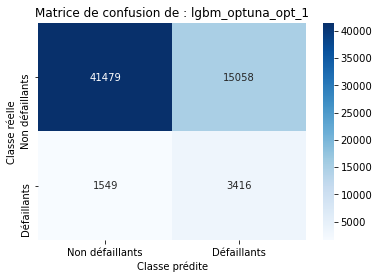

In [170]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_1,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_1')

In [171]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_1',
                                        1549, 15058, 3416, 41479, df_taux)

Best hyperparamètres:

{'max_depth': 10, 'subsample': 0.9272920164356852, 'colsample_bytree': 0.624271596901296, 'lambda_l1': 0.3594315599980607, 'lambda_l2': 9.712199429465308e-07, 'num_leaves': 31, 'feature_fraction': 0.8906276235582508, 'bagging_fraction': 0.8078241529425154, 'bagging_freq': 7, 'min_child_samples': 57}

In [172]:
param_lgbm_optuna_opt_1_bis = {'objective' : 'binary',
                               'boosting_type' : 'gbdt',
                               'n_jobs' : -1,
                               'class_weight' : 'balanced', # Balanced                                 
                               'max_depth': 10,
                               'subsample': 0.9272920164356852,               
                               'colsample_bytree': 0.624271596901296,                          
                               'reg_alpha': 0.3594315599980607,
                               'reg_lambda': 9.712199429465308e-07,
                               'num_leaves': 31,
                               'min_child_weight': 0.8906276235582508,
#                                'subsample':0.8078241529425154,
#                                'subsample_freq':7,
                               'min_child_samples': 57,
                               'verbosity' : -1}

In [173]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_1_bis = LGBMClassifier(**param_lgbm_optuna_opt_1_bis,
                                       force_col_wise=True)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

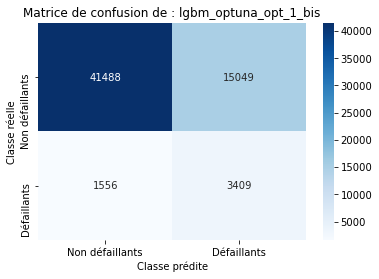

In [174]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_1_bis,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_1_bis')

In [175]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_1_bis',
                                        1556, 15049, 3409, 41488, df_taux)

**Avec les hyperparamètres n_estimators et learning_rate**

In [176]:
# Modèle et hyperparamètres à étudier
def create_model_2(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 11)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        class_weight='balanced',
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [177]:
# Objective fonction
def objective_2(trial):
    model = create_model_2(trial)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_proba)
    return score

In [178]:
# Recherche des p
study_2 = optuna.create_study(direction='maximize')
study_2.optimize(objective_2, n_trials=100)

[I 2021-08-11 16:40:22,049] A new study created in memory with name: no-name-74520925-7397-4bb4-924f-aeed8e252c93
[I 2021-08-11 16:40:50,850] Trial 0 finished with value: 0.7560308864565354 and parameters: {'n_estimators': 378, 'max_depth': 7, 'learning_rate': 0.1970490058766896, 'subsample': 0.7160966501603007, 'colsample_bytree': 0.5527173255798328, 'reg_alpha': 0.0880606937069609, 'reg_lambda': 2.449189442219991e-07, 'num_leaves': 115, 'min_child_weight': 0.9474913463511969, 'subsample_freq': 6, 'min_child_samples': 90}. Best is trial 0 with value: 0.7560308864565354.
[I 2021-08-11 16:41:25,078] Trial 1 finished with value: 0.715669794331764 and parameters: {'n_estimators': 961, 'max_depth': 10, 'learning_rate': 0.5639745503787855, 'subsample': 0.7952723588652865, 'colsample_bytree': 0.2337492242981062, 'reg_alpha': 6.544331893095873e-06, 'reg_lambda': 4.922846775717064, 'num_leaves': 27, 'min_child_weight': 0.7374818666720082, 'subsample_freq': 1, 'min_child_samples': 19}. Best is 

[I 2021-08-11 16:49:02,720] Trial 17 finished with value: 0.7777593088831078 and parameters: {'n_estimators': 598, 'max_depth': 4, 'learning_rate': 0.15042319056707865, 'subsample': 0.6022078763773051, 'colsample_bytree': 0.8049008530231648, 'reg_alpha': 1.7001815742762506e-08, 'reg_lambda': 1.7639586273212742e-08, 'num_leaves': 159, 'min_child_weight': 0.5713588598705527, 'subsample_freq': 7, 'min_child_samples': 79}. Best is trial 7 with value: 0.7852541485500829.
[I 2021-08-11 16:50:11,911] Trial 18 finished with value: 0.6918441542822326 and parameters: {'n_estimators': 874, 'max_depth': 6, 'learning_rate': 0.9683238377380787, 'subsample': 0.997249029763221, 'colsample_bytree': 0.6426782475501144, 'reg_alpha': 0.0004237799941753718, 'reg_lambda': 0.12524807479294678, 'num_leaves': 93, 'min_child_weight': 0.8193076293844808, 'subsample_freq': 6, 'min_child_samples': 53}. Best is trial 7 with value: 0.7852541485500829.
[I 2021-08-11 16:50:43,132] Trial 19 finished with value: 0.73833

[I 2021-08-11 17:02:13,862] Trial 35 finished with value: 0.727730272296617 and parameters: {'n_estimators': 908, 'max_depth': 7, 'learning_rate': 0.15688062126910343, 'subsample': 0.3342144078621373, 'colsample_bytree': 0.9659214724963423, 'reg_alpha': 0.009332558980255026, 'reg_lambda': 0.0004292738580986849, 'num_leaves': 137, 'min_child_weight': 0.5629827389094347, 'subsample_freq': 1, 'min_child_samples': 58}. Best is trial 31 with value: 0.7854775850074279.
[I 2021-08-11 17:02:57,312] Trial 36 finished with value: 0.7837741919527572 and parameters: {'n_estimators': 766, 'max_depth': 6, 'learning_rate': 0.044885505547701515, 'subsample': 0.6498272626870428, 'colsample_bytree': 0.5096029933816419, 'reg_alpha': 0.0010560137273805143, 'reg_lambda': 5.910724473057652e-05, 'num_leaves': 39, 'min_child_weight': 0.4464929151210594, 'subsample_freq': 6, 'min_child_samples': 24}. Best is trial 31 with value: 0.7854775850074279.
[I 2021-08-11 17:03:39,665] Trial 37 finished with value: 0.77

[I 2021-08-11 17:13:59,365] Trial 53 finished with value: 0.6933644804894854 and parameters: {'n_estimators': 684, 'max_depth': 6, 'learning_rate': 0.5967103561789628, 'subsample': 0.6446640356143619, 'colsample_bytree': 0.16386781651821086, 'reg_alpha': 0.26238339271699757, 'reg_lambda': 5.987381660711265e-06, 'num_leaves': 77, 'min_child_weight': 0.5974497704788764, 'subsample_freq': 4, 'min_child_samples': 28}. Best is trial 43 with value: 0.7874611749319897.
[I 2021-08-11 17:14:42,811] Trial 54 finished with value: 0.7867826826271974 and parameters: {'n_estimators': 795, 'max_depth': 5, 'learning_rate': 0.038425115386995605, 'subsample': 0.5544464906105476, 'colsample_bytree': 0.6634284907778043, 'reg_alpha': 0.06346027643715164, 'reg_lambda': 1.2508629688820857e-05, 'num_leaves': 50, 'min_child_weight': 0.6569674326117774, 'subsample_freq': 3, 'min_child_samples': 38}. Best is trial 43 with value: 0.7874611749319897.
[I 2021-08-11 17:15:38,708] Trial 55 finished with value: 0.7477

[I 2021-08-11 17:25:19,563] Trial 71 finished with value: 0.7870955079172546 and parameters: {'n_estimators': 505, 'max_depth': 3, 'learning_rate': 0.1015900312915799, 'subsample': 0.7890663843167023, 'colsample_bytree': 0.5726030275180263, 'reg_alpha': 7.082966591552517, 'reg_lambda': 2.8361627444130052e-08, 'num_leaves': 24, 'min_child_weight': 0.7470149410020295, 'subsample_freq': 2, 'min_child_samples': 42}. Best is trial 69 with value: 0.7875131652326675.
[I 2021-08-11 17:25:42,811] Trial 72 finished with value: 0.7877588028380064 and parameters: {'n_estimators': 507, 'max_depth': 3, 'learning_rate': 0.09579106431711815, 'subsample': 0.8561541398008475, 'colsample_bytree': 0.5439502702932943, 'reg_alpha': 8.58069453173145, 'reg_lambda': 1.022446940061388e-08, 'num_leaves': 24, 'min_child_weight': 0.7768531993458027, 'subsample_freq': 1, 'min_child_samples': 41}. Best is trial 72 with value: 0.7877588028380064.
[I 2021-08-11 17:26:03,422] Trial 73 finished with value: 0.78768916419

[I 2021-08-11 17:32:30,726] Trial 89 finished with value: 0.7870729434000221 and parameters: {'n_estimators': 822, 'max_depth': 3, 'learning_rate': 0.06432842395064253, 'subsample': 0.837811831957772, 'colsample_bytree': 0.6410050759123382, 'reg_alpha': 0.00016228612878283226, 'reg_lambda': 4.289524203699781e-07, 'num_leaves': 35, 'min_child_weight': 0.7653034065526123, 'subsample_freq': 2, 'min_child_samples': 48}. Best is trial 72 with value: 0.7877588028380064.
[I 2021-08-11 17:32:57,102] Trial 90 finished with value: 0.7845462411491759 and parameters: {'n_estimators': 485, 'max_depth': 3, 'learning_rate': 0.06184357199650471, 'subsample': 0.8730109833440441, 'colsample_bytree': 0.5419102089065672, 'reg_alpha': 0.00015172369452593818, 'reg_lambda': 1.0418057924142228e-06, 'num_leaves': 34, 'min_child_weight': 0.7637175200671453, 'subsample_freq': 3, 'min_child_samples': 49}. Best is trial 72 with value: 0.7877588028380064.
[I 2021-08-11 17:33:43,929] Trial 91 finished with value: 0.

In [179]:
params_2 = study_2.best_params
print(f'Nombre d\'essai terminés : {len(study_2.trials)}')
print('Best hyperparamètres:\n')
print(params_2)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'n_estimators': 894, 'max_depth': 3, 'learning_rate': 0.10807549985394013, 'subsample': 0.8283035655543509, 'colsample_bytree': 0.6359443936021497, 'reg_alpha': 0.00016719906189680456, 'reg_lambda': 3.6038119193864505e-07, 'num_leaves': 26, 'min_child_weight': 0.8601964066073932, 'subsample_freq': 2, 'min_child_samples': 42}


In [180]:
param_lgbm_optuna_opt_2 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.6359443936021497,
                           'max_depth': 3,
                           'min_child_weight': 0.8601964066073932,
                           'num_leaves': 26,
                           'reg_alpha': 0.00016719906189680456,
                           'reg_lambda': 3.6038119193864505e-07,
                           'subsample': 0.8283035655543509,
                           'subsample_freq': 2,
                           'min_child_samples': 42,
                           'n_estimators': 844,
                           'learning_rate': 0.10807549985394013,
                           'verbosity' : -1}

In [181]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_2 = LGBMClassifier(**param_lgbm_optuna_opt_2,
                                   force_col_wise=True)

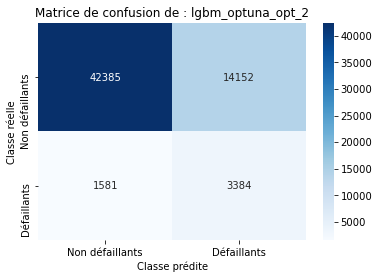

In [182]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_2,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_2')

In [183]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_2',
                                        1581, 14152, 3384, 42385, df_taux)

#### <span style='background:Moccasin'>6.5.2. Optimisation LGBM : Optuna intégrée à LightGBM - Score Métrique métier</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [184]:
# Modèle et hyperparamètres à étudier
def create_model_3(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'custom_score',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [185]:
# Objective fonction
def objective_3(trial):
    model = create_model_3(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = outils_model.custom_score(y_valid, y_pred)
    return score

In [186]:
# Recherche des paramètres
study_3 = optuna.create_study(direction='maximize')
study_3.optimize(objective_3, n_trials=100)

[I 2021-08-11 18:09:07,544] A new study created in memory with name: no-name-72c35fe5-771a-440e-abd6-0f082501cf0f
[I 2021-08-11 18:09:19,389] Trial 0 finished with value: 0.732186754598401 and parameters: {'max_depth': 6, 'subsample': 0.9814326805331169, 'colsample_bytree': 0.5595403512367135, 'reg_alpha': 0.8166580969512415, 'reg_lambda': 0.00036068801518614, 'num_leaves': 78, 'min_child_weight': 0.9968522195156628, 'subsample_freq': 4, 'min_child_samples': 7}. Best is trial 0 with value: 0.732186754598401.
[I 2021-08-11 18:09:27,162] Trial 1 finished with value: 0.7139482169651694 and parameters: {'max_depth': 4, 'subsample': 0.7124432699687566, 'colsample_bytree': 0.5435912835746475, 'reg_alpha': 5.981690235280597e-08, 'reg_lambda': 9.068626221558112e-07, 'num_leaves': 162, 'min_child_weight': 0.438468727445254, 'subsample_freq': 7, 'min_child_samples': 82}. Best is trial 0 with value: 0.732186754598401.
[I 2021-08-11 18:09:35,352] Trial 2 finished with value: 0.7144909491428024 and

[I 2021-08-11 18:13:03,319] Trial 20 finished with value: 0.7587487058802067 and parameters: {'max_depth': 10, 'subsample': 0.6023829081382228, 'colsample_bytree': 0.630622104720544, 'reg_alpha': 8.904568252372928e-05, 'reg_lambda': 5.094490315844886e-06, 'num_leaves': 220, 'min_child_weight': 0.6326734484904575, 'subsample_freq': 7, 'min_child_samples': 68}. Best is trial 18 with value: 0.7587806313024203.
[I 2021-08-11 18:13:18,321] Trial 21 finished with value: 0.7581056366613306 and parameters: {'max_depth': 10, 'subsample': 0.6396132770401843, 'colsample_bytree': 0.6221651066251872, 'reg_alpha': 0.00016420008859892998, 'reg_lambda': 5.116598006172602e-06, 'num_leaves': 214, 'min_child_weight': 0.6113060479514439, 'subsample_freq': 7, 'min_child_samples': 66}. Best is trial 18 with value: 0.7587806313024203.
[I 2021-08-11 18:13:35,891] Trial 22 finished with value: 0.7604361924829313 and parameters: {'max_depth': 11, 'subsample': 0.5703362653142148, 'colsample_bytree': 0.8354933109

[I 2021-08-11 18:17:57,776] Trial 40 finished with value: 0.7197039145128409 and parameters: {'max_depth': 5, 'subsample': 0.5658054465711947, 'colsample_bytree': 0.7011422960944901, 'reg_alpha': 7.230199622331354e-05, 'reg_lambda': 7.588393093740661e-06, 'num_leaves': 241, 'min_child_weight': 0.5163637910870171, 'subsample_freq': 6, 'min_child_samples': 49}. Best is trial 22 with value: 0.7604361924829313.
[I 2021-08-11 18:18:15,757] Trial 41 finished with value: 0.7595559629847534 and parameters: {'max_depth': 11, 'subsample': 0.5976513992256501, 'colsample_bytree': 0.8434054919610592, 'reg_alpha': 0.0010426308527809783, 'reg_lambda': 1.6160391466137342e-06, 'num_leaves': 208, 'min_child_weight': 0.6512676902393969, 'subsample_freq': 7, 'min_child_samples': 62}. Best is trial 22 with value: 0.7604361924829313.
[I 2021-08-11 18:18:33,429] Trial 42 finished with value: 0.7583519184898363 and parameters: {'max_depth': 10, 'subsample': 0.6251186500584665, 'colsample_bytree': 0.8464069351

[I 2021-08-11 18:24:26,051] Trial 60 finished with value: 0.764860143846831 and parameters: {'max_depth': 9, 'subsample': 0.9876256117049109, 'colsample_bytree': 0.9560103060225755, 'reg_alpha': 1.1038839802999074, 'reg_lambda': 0.03400763047281506, 'num_leaves': 251, 'min_child_weight': 0.8366885438251556, 'subsample_freq': 1, 'min_child_samples': 13}. Best is trial 51 with value: 0.7654895307419012.
[I 2021-08-11 18:24:48,591] Trial 61 finished with value: 0.7634143782980102 and parameters: {'max_depth': 9, 'subsample': 0.9024505885297713, 'colsample_bytree': 0.9691754505616442, 'reg_alpha': 1.0577747628289793, 'reg_lambda': 0.034411329504685166, 'num_leaves': 255, 'min_child_weight': 0.9445037872091755, 'subsample_freq': 1, 'min_child_samples': 10}. Best is trial 51 with value: 0.7654895307419012.
[I 2021-08-11 18:25:11,637] Trial 62 finished with value: 0.7622331376761029 and parameters: {'max_depth': 9, 'subsample': 0.885949012927146, 'colsample_bytree': 0.9981595687372025, 'reg_a

[I 2021-08-11 18:31:28,404] Trial 80 finished with value: 0.7662648624242341 and parameters: {'max_depth': 10, 'subsample': 0.9827900852249203, 'colsample_bytree': 0.8778066938212113, 'reg_alpha': 0.07153481110237454, 'reg_lambda': 0.00017014772537503255, 'num_leaves': 227, 'min_child_weight': 0.8197906084565919, 'subsample_freq': 3, 'min_child_samples': 28}. Best is trial 77 with value: 0.76672093988443.
[I 2021-08-11 18:31:53,142] Trial 81 finished with value: 0.7661143568623695 and parameters: {'max_depth': 10, 'subsample': 0.9889819106347859, 'colsample_bytree': 0.8591005269557603, 'reg_alpha': 0.0634438177150501, 'reg_lambda': 0.00016338459054512274, 'num_leaves': 227, 'min_child_weight': 0.8174012434050902, 'subsample_freq': 3, 'min_child_samples': 28}. Best is trial 77 with value: 0.76672093988443.
[I 2021-08-11 18:32:17,600] Trial 82 finished with value: 0.7641304199105176 and parameters: {'max_depth': 10, 'subsample': 0.9949169251095631, 'colsample_bytree': 0.8671592811726258,

In [187]:
params_3 = study_3.best_params
print(f'Nombre d\'essai terminés : {len(study_3.trials)}')
print('Best hyperparamètres:\n')
print(params_3)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.8716693058311116, 'colsample_bytree': 0.6997552584011694, 'reg_alpha': 0.17143555957265424, 'reg_lambda': 0.0004247636649460249, 'num_leaves': 229, 'min_child_weight': 0.7415701043743851, 'subsample_freq': 3, 'min_child_samples': 42}


In [188]:
param_lgbm_optuna_opt_3 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.6997552584011694,
                           'max_depth': 11,
                           'min_child_weight': 0.7415701043743851,
                           'num_leaves': 229,
                           'reg_alpha': 0.17143555957265424,
                           'reg_lambda': 0.0004247636649460249,
                           'subsample': 0.8716693058311116,
                           'subsample_freq': 3,
                           'min_child_samples': 42,
                           'verbosity' : -1}

In [189]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_3 = LGBMClassifier(**param_lgbm_optuna_opt_3,
                                      force_col_wise=True)

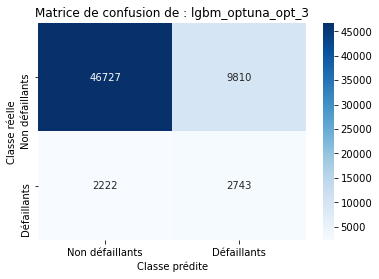

In [190]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_3,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_3')

In [191]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_3',
                                        2222, 9810, 2743, 46727, df_taux)

#### <span style='background:Moccasin'>6.5.3. Optimisation LGBM : Optuna intégrée à LightGBM - Score PR_AUC</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [192]:
# Modèle et hyperparamètres à étudier
def create_model_4(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'pr_auc',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [193]:
# Objective fonction
def objective_4(trial):
    model = create_model_3(trial)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_valid)[:,1]
    score = average_precision_score(y_valid, y_proba)
    return score

In [194]:
# Recherche des paramètres
study_4 = optuna.create_study(direction='maximize')
study_4.optimize(objective_4, n_trials=100)

[I 2021-08-11 19:15:25,502] A new study created in memory with name: no-name-a8a9cf3a-1ff5-4194-b0a7-536f2e589385
[I 2021-08-11 19:15:32,345] Trial 0 finished with value: 0.260696108557335 and parameters: {'max_depth': 3, 'subsample': 0.9850007604358308, 'colsample_bytree': 0.17861345826852254, 'reg_alpha': 3.396465552598251e-05, 'reg_lambda': 0.717231197786559, 'num_leaves': 226, 'min_child_weight': 0.7463731384675973, 'subsample_freq': 5, 'min_child_samples': 77}. Best is trial 0 with value: 0.260696108557335.
[I 2021-08-11 19:15:40,733] Trial 1 finished with value: 0.25099400175471165 and parameters: {'max_depth': 8, 'subsample': 0.16861184935937518, 'colsample_bytree': 0.7862464493300689, 'reg_alpha': 8.500671762104698, 'reg_lambda': 1.477674202681655e-07, 'num_leaves': 98, 'min_child_weight': 0.6163598463412564, 'subsample_freq': 7, 'min_child_samples': 88}. Best is trial 0 with value: 0.260696108557335.
[I 2021-08-11 19:15:50,376] Trial 2 finished with value: 0.2640015094934371 a

[I 2021-08-11 19:19:06,068] Trial 20 finished with value: 0.2756582851064905 and parameters: {'max_depth': 9, 'subsample': 0.8787562047154469, 'colsample_bytree': 0.6503504624852742, 'reg_alpha': 0.06157971337053492, 'reg_lambda': 1.1218733821322602e-08, 'num_leaves': 66, 'min_child_weight': 0.5219100439108857, 'subsample_freq': 6, 'min_child_samples': 13}. Best is trial 6 with value: 0.2757997767038822.
[I 2021-08-11 19:19:20,148] Trial 21 finished with value: 0.2727242972313044 and parameters: {'max_depth': 10, 'subsample': 0.8939829187009357, 'colsample_bytree': 0.6460068323521817, 'reg_alpha': 0.04388091969986897, 'reg_lambda': 1.5389305657299755e-08, 'num_leaves': 70, 'min_child_weight': 0.508387677667671, 'subsample_freq': 6, 'min_child_samples': 13}. Best is trial 6 with value: 0.2757997767038822.
[I 2021-08-11 19:19:29,359] Trial 22 finished with value: 0.27276081835374855 and parameters: {'max_depth': 9, 'subsample': 0.7414997778325428, 'colsample_bytree': 0.47541474669606054,

[I 2021-08-11 19:22:56,723] Trial 40 finished with value: 0.2678363218786803 and parameters: {'max_depth': 8, 'subsample': 0.5540494080004253, 'colsample_bytree': 0.3943779169071639, 'reg_alpha': 2.9983884209291456, 'reg_lambda': 2.5269861851163876e-07, 'num_leaves': 254, 'min_child_weight': 0.49395385834655914, 'subsample_freq': 5, 'min_child_samples': 27}. Best is trial 24 with value: 0.27982974019450446.
[I 2021-08-11 19:23:07,089] Trial 41 finished with value: 0.2772772521486161 and parameters: {'max_depth': 9, 'subsample': 0.9964238162908599, 'colsample_bytree': 0.23952308947005668, 'reg_alpha': 4.54072106790499, 'reg_lambda': 5.258126802377555e-05, 'num_leaves': 77, 'min_child_weight': 0.4473357303099229, 'subsample_freq': 5, 'min_child_samples': 20}. Best is trial 24 with value: 0.27982974019450446.
[I 2021-08-11 19:23:14,032] Trial 42 finished with value: 0.2597311528563191 and parameters: {'max_depth': 9, 'subsample': 0.21430343636040483, 'colsample_bytree': 0.1657413574742529

[I 2021-08-11 19:27:15,855] Trial 60 finished with value: 0.27794549584195716 and parameters: {'max_depth': 8, 'subsample': 0.9018471195653073, 'colsample_bytree': 0.653009263500191, 'reg_alpha': 1.182290356272018, 'reg_lambda': 0.006125033652990249, 'num_leaves': 44, 'min_child_weight': 0.6220595144302048, 'subsample_freq': 7, 'min_child_samples': 29}. Best is trial 24 with value: 0.27982974019450446.
[I 2021-08-11 19:27:32,429] Trial 61 finished with value: 0.2795315552983396 and parameters: {'max_depth': 10, 'subsample': 0.9515799904021635, 'colsample_bytree': 0.7173839497157023, 'reg_alpha': 9.921481036747455, 'reg_lambda': 0.00022356394880825313, 'num_leaves': 91, 'min_child_weight': 0.5649913753318938, 'subsample_freq': 7, 'min_child_samples': 36}. Best is trial 24 with value: 0.27982974019450446.
[I 2021-08-11 19:27:44,370] Trial 62 finished with value: 0.27594914909410756 and parameters: {'max_depth': 10, 'subsample': 0.9599260172443295, 'colsample_bytree': 0.6319294689142131, 

[I 2021-08-11 19:31:22,558] Trial 80 finished with value: 0.27724025179479783 and parameters: {'max_depth': 10, 'subsample': 0.7963154517343165, 'colsample_bytree': 0.8052293967812861, 'reg_alpha': 5.284931957877558, 'reg_lambda': 0.019878078058061244, 'num_leaves': 85, 'min_child_weight': 0.5827457712431859, 'subsample_freq': 7, 'min_child_samples': 33}. Best is trial 24 with value: 0.27982974019450446.
[I 2021-08-11 19:31:36,294] Trial 81 finished with value: 0.2784135983950068 and parameters: {'max_depth': 9, 'subsample': 0.9546012971170212, 'colsample_bytree': 0.6563546540452817, 'reg_alpha': 9.640436353695174, 'reg_lambda': 5.7004231697390635e-06, 'num_leaves': 47, 'min_child_weight': 0.5667936926282644, 'subsample_freq': 6, 'min_child_samples': 26}. Best is trial 24 with value: 0.27982974019450446.
[I 2021-08-11 19:31:50,427] Trial 82 finished with value: 0.2750559017039205 and parameters: {'max_depth': 8, 'subsample': 0.9807214168069529, 'colsample_bytree': 0.6312122624142094, '

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-11 19:33:46,783] Trial 90 finished with value: 0.2785680176632383 and parameters: {'max_depth': 11, 'subsample': 0.9246871539024775, 'colsample_bytree': 0.8448802796083106, 'reg_alpha': 1.008669805649608, 'reg_lambda': 4.833193428333548e-08, 'num_leaves': 31, 'min_child_weight': 0.7516560080195013, 'subsample_freq': 3, 'min_child_samples': 41}. Best is trial 84 with value: 0.27996498821382965.
[I 2021-08-11 19:33:59,873] Trial 91 finished with value: 0.2791893778102529 and parameters: {'max_depth': 10, 'subsample': 0.9451664523296208, 'colsample_bytree': 0.6752563379444537, 'reg_alpha': 6.114772377092805, 'reg_lambda': 3.426253832930273e-08, 'num_leaves': 41, 'min_child_weight': 0.7794064668670506, 'subsample_freq': 7, 'min_child_samples': 37}. Best is trial 84 with value: 0.27996498821382965.
[I 2021-08-11 19:34:09,562] Trial 92 finished with value: 0.2726409451369084 and parameters: {'max_depth': 10, 'subsample': 0.3902147330789758, 'colsample_bytree': 0.9180771174330049, 

In [195]:
params_4 = study_4.best_params
print(f'Nombre d\'essai terminés : {len(study_4.trials)}')
print('Best hyperparamètres:\n')
print(params_4)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.9277277987694873, 'colsample_bytree': 0.7235669008843322, 'reg_alpha': 5.75159527561415, 'reg_lambda': 1.057471694503438e-07, 'num_leaves': 62, 'min_child_weight': 0.672166188785165, 'subsample_freq': 7, 'min_child_samples': 38}


In [196]:
param_lgbm_optuna_opt_4 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.7235669008843322,
                           'max_depth': 11,
                           'min_child_weight': 0.672166188785165,
                           'num_leaves': 62,
                           'reg_alpha': 5.75159527561415,
                           'reg_lambda': 1.057471694503438e-07,
                           'subsample': 0.9277277987694873,
                           'subsample_freq': 7,
                           'min_child_samples': 38,
                           'verbosity' : -1}

In [197]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_4 = LGBMClassifier(**param_lgbm_optuna_opt_4,
                                      force_col_wise=True)

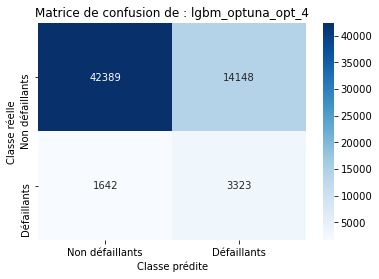

In [198]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_4,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_4')

In [201]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_4',
                                        1642, 14148, 3323, 42389, df_taux)

#### <span style='background:Moccasin'>6.5.4. Optimisation LGBM : Optuna intégrée à LightGBM - Score F10</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [202]:
# Modèle et hyperparamètres à étudier
def create_model_5(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f10_score',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [203]:
# Objective fonction
def objective_5(trial):
    model = create_model_3(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = fbeta_score(y_valid, y_pred, 10)
    return score

In [204]:
# Recherche des paramètres
study_5 = optuna.create_study(direction='maximize')
study_5.optimize(objective_5, n_trials=100)

[I 2021-08-11 19:46:11,312] A new study created in memory with name: no-name-4146142a-6615-431f-a5ee-23fbd7667bed
[I 2021-08-11 19:46:18,811] Trial 0 finished with value: 0.6750442539576788 and parameters: {'max_depth': 3, 'subsample': 0.570268426369228, 'colsample_bytree': 0.8871600186345197, 'reg_alpha': 0.00021017301853000226, 'reg_lambda': 1.9507571844958124e-07, 'num_leaves': 162, 'min_child_weight': 0.7604620079019347, 'subsample_freq': 3, 'min_child_samples': 86}. Best is trial 0 with value: 0.6750442539576788.
[I 2021-08-11 19:46:29,848] Trial 1 finished with value: 0.6729490151312187 and parameters: {'max_depth': 5, 'subsample': 0.8040860872807638, 'colsample_bytree': 0.8914625921670127, 'reg_alpha': 0.1616003186457212, 'reg_lambda': 4.588585195274666e-07, 'num_leaves': 174, 'min_child_weight': 0.7314780444816402, 'subsample_freq': 3, 'min_child_samples': 31}. Best is trial 0 with value: 0.6750442539576788.
[I 2021-08-11 19:46:39,273] Trial 2 finished with value: 0.63972453152

[I 2021-08-11 19:49:54,829] Trial 20 finished with value: 0.6609636647490323 and parameters: {'max_depth': 6, 'subsample': 0.8967133533455968, 'colsample_bytree': 0.7187851931925344, 'reg_alpha': 8.853988248134513e-05, 'reg_lambda': 0.0007889389677965315, 'num_leaves': 102, 'min_child_weight': 0.6591031325253771, 'subsample_freq': 4, 'min_child_samples': 71}. Best is trial 9 with value: 0.6812819489282214.
[I 2021-08-11 19:50:02,187] Trial 21 finished with value: 0.685736306808059 and parameters: {'max_depth': 11, 'subsample': 0.5273526482127859, 'colsample_bytree': 0.552942078228463, 'reg_alpha': 1.1166063763414869e-07, 'reg_lambda': 0.008734603014712584, 'num_leaves': 8, 'min_child_weight': 0.5706346420380645, 'subsample_freq': 3, 'min_child_samples': 7}. Best is trial 21 with value: 0.685736306808059.
[I 2021-08-11 19:50:07,728] Trial 22 finished with value: 0.6630252458104013 and parameters: {'max_depth': 10, 'subsample': 0.5119019681161713, 'colsample_bytree': 0.5215618167036361, 

[I 2021-08-11 19:52:23,246] Trial 40 finished with value: 0.6635732119767175 and parameters: {'max_depth': 9, 'subsample': 0.4406420896951203, 'colsample_bytree': 0.557181840282021, 'reg_alpha': 1.047037393013575e-06, 'reg_lambda': 9.26977602358117, 'num_leaves': 38, 'min_child_weight': 0.5399694963717072, 'subsample_freq': 4, 'min_child_samples': 74}. Best is trial 21 with value: 0.685736306808059.
[I 2021-08-11 19:52:33,054] Trial 41 finished with value: 0.6812301215817844 and parameters: {'max_depth': 10, 'subsample': 0.7360492166905652, 'colsample_bytree': 0.67281773649445, 'reg_alpha': 0.25137502407982326, 'reg_lambda': 0.00014833493997298342, 'num_leaves': 12, 'min_child_weight': 0.5164028844819267, 'subsample_freq': 2, 'min_child_samples': 10}. Best is trial 21 with value: 0.685736306808059.
[I 2021-08-11 19:52:39,928] Trial 42 finished with value: 0.6624122194065425 and parameters: {'max_depth': 11, 'subsample': 0.8101727164257405, 'colsample_bytree': 0.7477025504458132, 'reg_a

[I 2021-08-11 19:55:38,014] Trial 60 finished with value: 0.6409358205467717 and parameters: {'max_depth': 9, 'subsample': 0.43242885591384617, 'colsample_bytree': 0.7977754906584833, 'reg_alpha': 0.538392575196806, 'reg_lambda': 3.2170196799030986e-07, 'num_leaves': 71, 'min_child_weight': 0.40165441023621684, 'subsample_freq': 4, 'min_child_samples': 22}. Best is trial 21 with value: 0.685736306808059.
[I 2021-08-11 19:55:46,649] Trial 61 finished with value: 0.6858120081885457 and parameters: {'max_depth': 10, 'subsample': 0.6077908090096453, 'colsample_bytree': 0.6718874008033578, 'reg_alpha': 0.27940103094622726, 'reg_lambda': 2.3713012117773568e-06, 'num_leaves': 9, 'min_child_weight': 0.5265626953374176, 'subsample_freq': 2, 'min_child_samples': 11}. Best is trial 61 with value: 0.6858120081885457.
[I 2021-08-11 19:55:56,400] Trial 62 finished with value: 0.6805911437067325 and parameters: {'max_depth': 10, 'subsample': 0.6199575237805498, 'colsample_bytree': 0.572875175488571, 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-11 19:56:15,906] Trial 65 finished with value: 0.6595399813259362 and parameters: {'max_depth': 9, 'subsample': 0.1521810501801493, 'colsample_bytree': 0.5132287197033233, 'reg_alpha': 0.29824270842884915, 'reg_lambda': 5.486303741985889e-07, 'num_leaves': 31, 'min_child_weight': 0.45856638054104637, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 61 with value: 0.6858120081885457.
[I 2021-08-11 19:56:21,577] Trial 66 finished with value: 0.673419293440416 and parameters: {'max_depth': 9, 'subsample': 0.19027178780931436, 'colsample_bytree': 0.760410182311705, 'reg_alpha': 0.03981120409833338, 'reg_lambda': 1.5250988174928815e-07, 'num_leaves': 3, 'min_child_weight': 0.47828109867985547, 'subsample_freq': 1, 'min_child_samples': 28}. Best is trial 61 with value: 0.6858120081885457.
[I 2021-08-11 19:56:31,756] Trial 67 finished with value: 0.584182119257026 and parameters: {'max_depth': 8, 'subsample': 0.265503198712985, 'colsample_bytree': 0.7165661869665088, 'r

[I 2021-08-11 19:59:15,514] Trial 85 finished with value: 0.6797428974848331 and parameters: {'max_depth': 8, 'subsample': 0.5324076015528343, 'colsample_bytree': 0.7000586217263037, 'reg_alpha': 4.589063873097874e-07, 'reg_lambda': 0.04431999600922528, 'num_leaves': 22, 'min_child_weight': 0.47063048480445663, 'subsample_freq': 2, 'min_child_samples': 5}. Best is trial 61 with value: 0.6858120081885457.
[I 2021-08-11 19:59:25,905] Trial 86 finished with value: 0.670247227670855 and parameters: {'max_depth': 8, 'subsample': 0.5637273996466888, 'colsample_bytree': 0.7740304649684839, 'reg_alpha': 0.48079712487188536, 'reg_lambda': 0.21032437923653813, 'num_leaves': 35, 'min_child_weight': 0.4941865504323539, 'subsample_freq': 3, 'min_child_samples': 6}. Best is trial 61 with value: 0.6858120081885457.
[I 2021-08-11 19:59:34,822] Trial 87 finished with value: 0.6821176780654938 and parameters: {'max_depth': 7, 'subsample': 0.5887876298181054, 'colsample_bytree': 0.6804106934136991, 'reg_

In [205]:
params_5 = study_5.best_params
print(f'Nombre d\'essai terminés : {len(study_5.trials)}')
print('Best hyperparamètres:\n')
print(params_5)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 9, 'subsample': 0.8190208924749053, 'colsample_bytree': 0.65731418761953, 'reg_alpha': 1.7033609851586964e-06, 'reg_lambda': 0.012745771755334187, 'num_leaves': 13, 'min_child_weight': 0.5685528790757488, 'subsample_freq': 1, 'min_child_samples': 96}


In [206]:
param_lgbm_optuna_opt_5 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.65731418761953,
                           'max_depth': 9,
                           'min_child_samples': 96,
                           'min_child_weight': 0.5685528790757488,
                           'num_leaves': 13,
                           'reg_alpha': 1.7033609851586964e-06,
                           'reg_lambda': 0.012745771755334187,
                           'subsample': 0.8190208924749053,
                           'subsample_freq': 1,
                           'verbosity' : -1}

In [207]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_5 = LGBMClassifier(**param_lgbm_optuna_opt_5,
                                      force_col_wise=True)

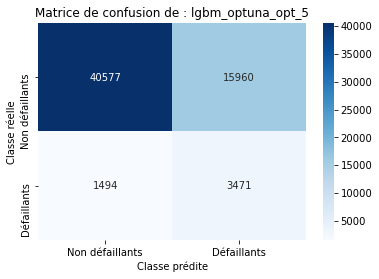

In [208]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_5,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_5')

In [209]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_5',
                                        1494, 15960, 3471, 40577, df_taux)

#### <span style='background:Moccasin'>6.5.5. Optimisation LGBM : Optuna intégrée à LightGBM - Score F1</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [210]:
# Modèle et hyperparamètres à étudier
def create_model_F1(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f1_score',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [212]:
# Objective fonction
def objective_F1(trial):
    model = create_model_F1(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = fbeta_score(y_valid, y_pred, 1)
    return score

In [213]:
# Recherche des paramètres
study_F1 = optuna.create_study(direction='maximize')
study_F1.optimize(objective_F1, n_trials=100)

[I 2021-08-11 20:10:09,059] A new study created in memory with name: no-name-f191f39e-c490-4e51-a1f7-7f2e3f0a9d81
[I 2021-08-11 20:10:19,981] Trial 0 finished with value: 0.2949362023740719 and parameters: {'max_depth': 6, 'subsample': 0.6358377204711492, 'colsample_bytree': 0.882872866864507, 'reg_alpha': 8.688346137920405e-05, 'reg_lambda': 1.204093976167686e-07, 'num_leaves': 142, 'min_child_weight': 0.9832601589982737, 'subsample_freq': 1, 'min_child_samples': 39}. Best is trial 0 with value: 0.2949362023740719.
[I 2021-08-11 20:10:26,352] Trial 1 finished with value: 0.2768218826454899 and parameters: {'max_depth': 3, 'subsample': 0.5258881069038428, 'colsample_bytree': 0.613109255463659, 'reg_alpha': 1.1790259573641696e-06, 'reg_lambda': 0.515391388645908, 'num_leaves': 242, 'min_child_weight': 0.5695552255502089, 'subsample_freq': 7, 'min_child_samples': 24}. Best is trial 0 with value: 0.2949362023740719.
[I 2021-08-11 20:10:37,063] Trial 2 finished with value: 0.29568641489171

[I 2021-08-11 20:14:44,928] Trial 20 finished with value: 0.30586913214486383 and parameters: {'max_depth': 10, 'subsample': 0.8862893360898763, 'colsample_bytree': 0.4751742537632689, 'reg_alpha': 0.0007170131696690346, 'reg_lambda': 0.0017856874857690116, 'num_leaves': 150, 'min_child_weight': 0.5026229302977182, 'subsample_freq': 5, 'min_child_samples': 73}. Best is trial 13 with value: 0.313481711716712.
[I 2021-08-11 20:15:05,346] Trial 21 finished with value: 0.31422935437436683 and parameters: {'max_depth': 10, 'subsample': 0.8735863064901961, 'colsample_bytree': 0.851772738257339, 'reg_alpha': 9.87510297549966, 'reg_lambda': 0.0022038498062851106, 'num_leaves': 228, 'min_child_weight': 0.41372705123566966, 'subsample_freq': 6, 'min_child_samples': 90}. Best is trial 21 with value: 0.31422935437436683.
[I 2021-08-11 20:15:23,523] Trial 22 finished with value: 0.3136787340125731 and parameters: {'max_depth': 10, 'subsample': 0.6914160604744518, 'colsample_bytree': 0.8174410832258

[I 2021-08-11 20:20:07,936] Trial 40 finished with value: 0.3113577023498695 and parameters: {'max_depth': 10, 'subsample': 0.9387061794953352, 'colsample_bytree': 0.6049161496929111, 'reg_alpha': 0.2804120323247421, 'reg_lambda': 0.030577612404576168, 'num_leaves': 205, 'min_child_weight': 0.5937402877145307, 'subsample_freq': 7, 'min_child_samples': 78}. Best is trial 39 with value: 0.31763215478521245.
[I 2021-08-11 20:20:26,595] Trial 41 finished with value: 0.31670084301663254 and parameters: {'max_depth': 11, 'subsample': 0.8249862230554471, 'colsample_bytree': 0.6394360462860083, 'reg_alpha': 0.05454710753928124, 'reg_lambda': 0.012727392694354314, 'num_leaves': 245, 'min_child_weight': 0.6427265835418575, 'subsample_freq': 7, 'min_child_samples': 70}. Best is trial 39 with value: 0.31763215478521245.
[I 2021-08-11 20:20:43,233] Trial 42 finished with value: 0.31511581808914313 and parameters: {'max_depth': 11, 'subsample': 0.832465608619029, 'colsample_bytree': 0.51801966328709

[I 2021-08-11 20:24:59,261] Trial 60 finished with value: 0.3009451091764049 and parameters: {'max_depth': 11, 'subsample': 0.8900116592279862, 'colsample_bytree': 0.2026268186266834, 'reg_alpha': 0.30851281986680545, 'reg_lambda': 0.000704468104104829, 'num_leaves': 92, 'min_child_weight': 0.6839092143302108, 'subsample_freq': 5, 'min_child_samples': 79}. Best is trial 39 with value: 0.31763215478521245.
[I 2021-08-11 20:25:12,524] Trial 61 finished with value: 0.3166657292311154 and parameters: {'max_depth': 11, 'subsample': 0.7345807741377339, 'colsample_bytree': 0.37202404313283444, 'reg_alpha': 0.11106927701057139, 'reg_lambda': 0.00017571839047360687, 'num_leaves': 247, 'min_child_weight': 0.6369639186061986, 'subsample_freq': 7, 'min_child_samples': 73}. Best is trial 39 with value: 0.31763215478521245.
[I 2021-08-11 20:25:27,526] Trial 62 finished with value: 0.31594219072596397 and parameters: {'max_depth': 11, 'subsample': 0.9636363821481431, 'colsample_bytree': 0.37955421488

[I 2021-08-11 20:29:24,349] Trial 80 finished with value: 0.3124039633338632 and parameters: {'max_depth': 11, 'subsample': 0.7737726416711306, 'colsample_bytree': 0.34563235513886986, 'reg_alpha': 2.1028177172058338, 'reg_lambda': 0.00012980424355904372, 'num_leaves': 201, 'min_child_weight': 0.6059050943753057, 'subsample_freq': 7, 'min_child_samples': 94}. Best is trial 39 with value: 0.31763215478521245.
[I 2021-08-11 20:29:40,156] Trial 81 finished with value: 0.3167296838182914 and parameters: {'max_depth': 11, 'subsample': 0.8523423061453247, 'colsample_bytree': 0.494802174086164, 'reg_alpha': 0.3669004507986688, 'reg_lambda': 7.080746425060999e-05, 'num_leaves': 212, 'min_child_weight': 0.5819009427730101, 'subsample_freq': 7, 'min_child_samples': 78}. Best is trial 39 with value: 0.31763215478521245.
[I 2021-08-11 20:29:55,754] Trial 82 finished with value: 0.3110398289227479 and parameters: {'max_depth': 11, 'subsample': 0.8590365874693077, 'colsample_bytree': 0.4922419294760

In [218]:
params_F1 = study_F1.best_params
print(f'Nombre d\'essai terminés : {len(study_F1.trials)}')
print('Best hyperparamètres:\n')
print(params_F1)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.9357224669857652, 'colsample_bytree': 0.6298436780635843, 'reg_alpha': 0.3502190097565543, 'reg_lambda': 0.01752167744778438, 'num_leaves': 244, 'min_child_weight': 0.5846755061624288, 'subsample_freq': 7, 'min_child_samples': 70}


In [215]:
param_lgbm_optuna_opt_F1 = {'objective' : 'binary',
                            'boosting_type' : 'gbdt',
                            'n_jobs' : -1,
                            'class_weight' : 'balanced', # Balanced        
                            'colsample_bytree': 0.6298436780635843,
                            'max_depth': 11,
                            'min_child_samples': 70,
                            'min_child_weight': 0.5846755061624288,
                            'num_leaves': 244,
                            'reg_alpha': 0.3502190097565543,
                            'reg_lambda': 0.01752167744778438,
                            'subsample': 0.9357224669857652,
                            'subsample_freq': 7,
                            'verbosity' : -1}

In [216]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_F1 = LGBMClassifier(**param_lgbm_optuna_opt_F1,
                                    force_col_wise=True)

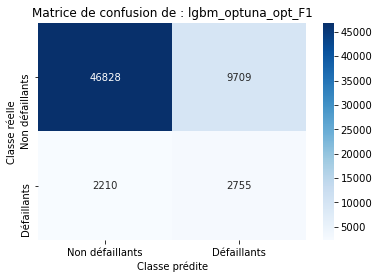

In [217]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_F1,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_F1')

In [219]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_F1',
                                        2210, 9709, 2755, 46828, df_taux)

#### <span style='background:Moccasin'>6.5.6. Optimisation LGBM : Optuna intégrée à LightGBM - Score F5</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [220]:
# Modèle et hyperparamètres à étudier
def create_model_F5(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f5_score',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [221]:
# Objective fonction
def objective_F5(trial):
    model = create_model_F5(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = fbeta_score(y_valid, y_pred, 5)
    return score

In [222]:
# Recherche des paramètres
study_F5 = optuna.create_study(direction='maximize')
study_F5.optimize(objective_F5, n_trials=100)

[I 2021-08-11 20:40:30,262] A new study created in memory with name: no-name-e0b1d900-b148-401a-ba37-7f91144c443a
[I 2021-08-11 20:40:50,346] Trial 0 finished with value: 0.5545456520637035 and parameters: {'max_depth': 11, 'subsample': 0.7539859092462925, 'colsample_bytree': 0.8915917101809953, 'reg_alpha': 0.0007831459644177945, 'reg_lambda': 0.0006804023362113571, 'num_leaves': 164, 'min_child_weight': 0.5429437257425589, 'subsample_freq': 6, 'min_child_samples': 19}. Best is trial 0 with value: 0.5545456520637035.
[I 2021-08-11 20:40:58,002] Trial 1 finished with value: 0.6193383760138522 and parameters: {'max_depth': 9, 'subsample': 0.3418584385015164, 'colsample_bytree': 0.5637444478555912, 'reg_alpha': 4.850285266064646e-07, 'reg_lambda': 0.010117216179427447, 'num_leaves': 30, 'min_child_weight': 0.476456316184162, 'subsample_freq': 7, 'min_child_samples': 15}. Best is trial 1 with value: 0.6193383760138522.
[I 2021-08-11 20:41:05,578] Trial 2 finished with value: 0.62481182046

[I 2021-08-11 20:43:36,848] Trial 20 finished with value: 0.6230607672920749 and parameters: {'max_depth': 5, 'subsample': 0.9601028021835614, 'colsample_bytree': 0.1802464272692632, 'reg_alpha': 6.406655770121646e-05, 'reg_lambda': 0.061078128332070096, 'num_leaves': 226, 'min_child_weight': 0.7103047620573779, 'subsample_freq': 2, 'min_child_samples': 89}. Best is trial 11 with value: 0.6282947000339963.
[I 2021-08-11 20:43:42,916] Trial 21 finished with value: 0.6267907067091234 and parameters: {'max_depth': 3, 'subsample': 0.13915325634923295, 'colsample_bytree': 0.9327768161909833, 'reg_alpha': 2.919781548114236e-06, 'reg_lambda': 4.828567930064356, 'num_leaves': 256, 'min_child_weight': 0.8076241964655123, 'subsample_freq': 1, 'min_child_samples': 94}. Best is trial 11 with value: 0.6282947000339963.
[I 2021-08-11 20:43:49,149] Trial 22 finished with value: 0.626138932419876 and parameters: {'max_depth': 3, 'subsample': 0.16553254834341477, 'colsample_bytree': 0.8083639388625325,

[I 2021-08-11 20:46:10,273] Trial 40 finished with value: 0.5579940481793366 and parameters: {'max_depth': 10, 'subsample': 0.6623226479385302, 'colsample_bytree': 0.795185864799585, 'reg_alpha': 0.023082511174647245, 'reg_lambda': 9.871011334931469, 'num_leaves': 205, 'min_child_weight': 0.6290491264364707, 'subsample_freq': 4, 'min_child_samples': 58}. Best is trial 11 with value: 0.6282947000339963.
[I 2021-08-11 20:46:15,687] Trial 41 finished with value: 0.6243268312267247 and parameters: {'max_depth': 3, 'subsample': 0.14695711902410033, 'colsample_bytree': 0.9524463106177717, 'reg_alpha': 1.75482254620551e-06, 'reg_lambda': 2.7491690089927547, 'num_leaves': 242, 'min_child_weight': 0.6815957752906181, 'subsample_freq': 3, 'min_child_samples': 95}. Best is trial 11 with value: 0.6282947000339963.
[I 2021-08-11 20:46:21,243] Trial 42 finished with value: 0.6311003292323688 and parameters: {'max_depth': 3, 'subsample': 0.20527705550476355, 'colsample_bytree': 0.9080490355316312, 'r

[I 2021-08-11 20:48:18,447] Trial 60 finished with value: 0.613784171851685 and parameters: {'max_depth': 6, 'subsample': 0.5059738008805841, 'colsample_bytree': 0.9399587087176636, 'reg_alpha': 3.202603959940823e-05, 'reg_lambda': 9.840739317545696, 'num_leaves': 234, 'min_child_weight': 0.9609183366275356, 'subsample_freq': 4, 'min_child_samples': 70}. Best is trial 42 with value: 0.6311003292323688.
[I 2021-08-11 20:48:23,876] Trial 61 finished with value: 0.6260159224645205 and parameters: {'max_depth': 3, 'subsample': 0.14451500394598352, 'colsample_bytree': 0.967143832162972, 'reg_alpha': 2.963075958500412e-05, 'reg_lambda': 2.6598483913432096, 'num_leaves': 54, 'min_child_weight': 0.8100136599332084, 'subsample_freq': 3, 'min_child_samples': 97}. Best is trial 42 with value: 0.6311003292323688.
[I 2021-08-11 20:48:29,145] Trial 62 finished with value: 0.6298032643846904 and parameters: {'max_depth': 3, 'subsample': 0.12242324012173118, 'colsample_bytree': 0.972100407463599, 'reg

[I 2021-08-11 20:50:16,413] Trial 80 finished with value: 0.6287401492940761 and parameters: {'max_depth': 3, 'subsample': 0.12275542467540662, 'colsample_bytree': 0.773065454685518, 'reg_alpha': 2.2770986325809015e-05, 'reg_lambda': 9.255661593313964e-08, 'num_leaves': 230, 'min_child_weight': 0.9967775732485336, 'subsample_freq': 3, 'min_child_samples': 92}. Best is trial 74 with value: 0.6332153813127991.
[I 2021-08-11 20:50:21,505] Trial 81 finished with value: 0.6214636783983696 and parameters: {'max_depth': 3, 'subsample': 0.10042549320551541, 'colsample_bytree': 0.8970985965917793, 'reg_alpha': 4.842757595372873e-06, 'reg_lambda': 8.096452408875782e-07, 'num_leaves': 254, 'min_child_weight': 0.9299917353214071, 'subsample_freq': 3, 'min_child_samples': 94}. Best is trial 74 with value: 0.6332153813127991.
[I 2021-08-11 20:50:27,052] Trial 82 finished with value: 0.6250337929170046 and parameters: {'max_depth': 3, 'subsample': 0.17122480197775333, 'colsample_bytree': 0.8725875879

In [223]:
params_F5 = study_F5.best_params
print(f'Nombre d\'essai terminés : {len(study_F5.trials)}')
print('Best hyperparamètres:\n')
print(params_F5)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 3, 'subsample': 0.15752124665437, 'colsample_bytree': 0.9730207467268496, 'reg_alpha': 1.5792386607935058e-05, 'reg_lambda': 4.467168765287726e-08, 'num_leaves': 225, 'min_child_weight': 0.9108029529213437, 'subsample_freq': 3, 'min_child_samples': 98}


In [224]:
param_lgbm_optuna_opt_F5 = {'objective' : 'binary',
                            'boosting_type' : 'gbdt',
                            'n_jobs' : -1,
                            'class_weight' : 'balanced', # Balanced        
                            'colsample_bytree': 0.9730207467268496,
                            'max_depth': 3,
                            'min_child_samples': 98,
                            'min_child_weight': 0.9108029529213437,
                            'num_leaves': 225,
                            'reg_alpha': 1.5792386607935058e-05,
                            'reg_lambda': 4.467168765287726e-08,
                            'subsample': 0.15752124665437,
                            'subsample_freq': 3,
                            'verbosity' : -1}

In [225]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_F5 = LGBMClassifier(**param_lgbm_optuna_opt_F5,
                                    force_col_wise=True)

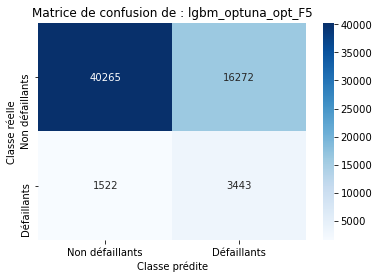

In [226]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_F5,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_F5')

In [227]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_F5',
                                        1522, 16272, 3443, 40265, df_taux)

### <span style='background:PowderBlue'>6.6. Optimisation : rééquilibrage des classes</span>

**Répartition variable cible?**

In [228]:
# Jeu d'entraînement du jeu d'entraînement
# Répartition des la cible 0 (non-défaillants) - 1 (défaillants)?
y_train_distrib = Counter(y_train)
print('Répartition des classes : ')
print(y_train_distrib)
# Pourcentage
y_train_distrib_norm = y_train.value_counts(normalize=True)*100
print('\nRépartition des classes (en %) :')
print(y_train_distrib_norm)

Répartition des classes : 
Counter({0: 226145, 1: 19860})

Répartition des classes (en %) :
0    91.927
1     8.073
Name: TARGET, dtype: float64


In [229]:
# Jeu de validation du jeu d'entraînement
# Répartition des la cible 0 (non-défaillants) - 1 (défaillants)?
y_valid_distrib = Counter(y_valid)
print('Répartition des classes : ')
print(y_valid_distrib)
# Pourcentage
y_valid_distrib_norm = y_valid.value_counts(normalize=True)*100
print('\nRépartition des classes (en %) :')
print(y_valid_distrib_norm)

Répartition des classes : 
Counter({0: 56537, 1: 4965})

Répartition des classes (en %) :
0    91.9271
1     8.0729
Name: TARGET, dtype: float64


**Bilan** :
- La variable cible est fortement déséquilibrée 90% de non défaillants et 10% de défaillants ==> on tentera un rééquilibrage de la variable cible pour optimiser le modèle.

Plusieurs méthodes de réquilibrage sont à notre disposition :
- undersampling : consiste en un sous-échantillonnage de la classe majoritaire.
- oversampling : sur-échantillonnage de la classe minoritaire (ex : SMOTE, ADASYN).
- une combinaison d'oversampling suivi d'undersampling (possible avec SMOTE).
- hyperparamètre du modèle Ligthgbm : class_weight='balanced'.

[Source](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

#### <span style='background:Moccasin'>6.6.1. Rééquilibrage - oversampling : SMOTE</span>

**SMOTE - paramètres par défaut**

In [230]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)
# Application de l'oversampling via SMOTE avec les paramètres par défaut
oversample = SMOTE()
X_train_smote, y_train_smote = \
    oversample.fit_resample(X_train, y_train)
X_valid_smote, y_valid_smote = \
    oversample.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_def = Counter(y_train_smote)
print(counter_smote_def)

Counter({0: 226145, 1: 19860})
Counter({0: 226145, 1: 226145})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [231]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base = LGBMClassifier(random_state=seed, verbose=0,
                                 force_col_wise=True)

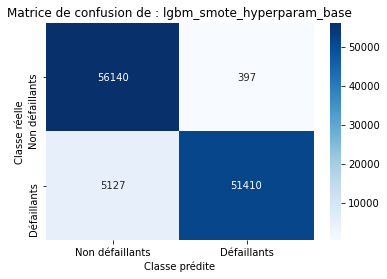

In [232]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_smote_hyperparam_base')

In [233]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_hyperparam_base',
                                        5127, 397, 51410, 56140, df_taux)

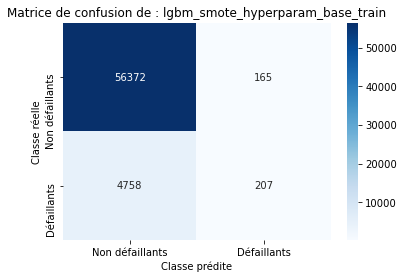

In [234]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_hyperparam_base_train')

In [235]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_hyperparam_base_train',
                                        4748, 165, 207, 56372, df_taux)

#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base + class_weight='balanced'**</span>

In [236]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base_bal = LGBMClassifier(class_weight='balanced',
                                     random_state=seed, verbose=0,
                                     force_col_wise=True)

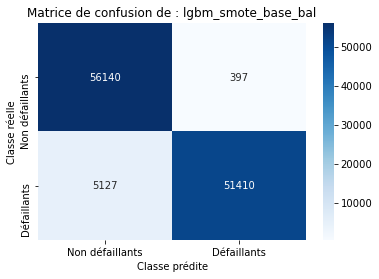

In [237]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_bal,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_smote_base_bal')

In [238]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_base_bal',
                                        5127, 397, 51410, 56140, df_taux)

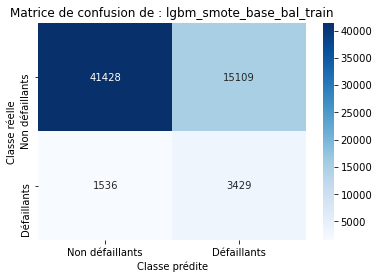

In [239]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_bal,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_base_bal_train')

In [240]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_base_bal_train',
                                        1536, 15109, 3429, 41428, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [241]:
# Modèle et hyperparamètres à étudier
def create_model_7(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [242]:
# Objective fonction
def objective_7(trial):
    model = create_model_7(trial)
    model.fit(X_train_smote, y_train_smote)
    y_proba_smote = model.predict_proba(X_valid_smote)[:,1]
    score = roc_auc_score(y_valid_smote, y_proba_smote)
    return score

In [243]:
# Recherche des paramètres
study_7 = optuna.create_study(direction='maximize')
study_7.optimize(objective_7, n_trials=100)

[I 2021-08-11 21:26:13,967] A new study created in memory with name: no-name-f45720f4-597f-489d-af72-7df1a9effeaf
[I 2021-08-11 21:26:24,018] Trial 0 finished with value: 0.9754133968976835 and parameters: {'max_depth': 6, 'subsample': 0.10933993841798176, 'colsample_bytree': 0.5995151444722225, 'reg_alpha': 3.3787426576908976e-05, 'reg_lambda': 0.0003829814523559478, 'num_leaves': 41, 'min_child_weight': 0.42284699189800407, 'subsample_freq': 3, 'min_child_samples': 63}. Best is trial 0 with value: 0.9754133968976835.
[I 2021-08-11 21:26:44,290] Trial 1 finished with value: 0.9774691719748381 and parameters: {'max_depth': 9, 'subsample': 0.5163400888164112, 'colsample_bytree': 0.8723475444641207, 'reg_alpha': 0.01066800142283567, 'reg_lambda': 0.0001759485317793551, 'num_leaves': 65, 'min_child_weight': 0.742665180382122, 'subsample_freq': 6, 'min_child_samples': 6}. Best is trial 1 with value: 0.9774691719748381.
[I 2021-08-11 21:27:06,641] Trial 2 finished with value: 0.977208762585

[I 2021-08-11 21:33:18,695] Trial 20 finished with value: 0.9765920991397643 and parameters: {'max_depth': 10, 'subsample': 0.7840687281818023, 'colsample_bytree': 0.11259976765843799, 'reg_alpha': 0.0013220036060194985, 'reg_lambda': 0.0025359718140058754, 'num_leaves': 165, 'min_child_weight': 0.9887180746958761, 'subsample_freq': 4, 'min_child_samples': 92}. Best is trial 12 with value: 0.978327924697599.
[I 2021-08-11 21:33:43,513] Trial 21 finished with value: 0.9780385248626545 and parameters: {'max_depth': 11, 'subsample': 0.6521112186255947, 'colsample_bytree': 0.5264053303258523, 'reg_alpha': 5.168680388831931e-05, 'reg_lambda': 0.02508975543305392, 'num_leaves': 255, 'min_child_weight': 0.5619941376874517, 'subsample_freq': 6, 'min_child_samples': 82}. Best is trial 12 with value: 0.978327924697599.
[I 2021-08-11 21:34:00,520] Trial 22 finished with value: 0.9768221956708636 and parameters: {'max_depth': 11, 'subsample': 0.24650229612048352, 'colsample_bytree': 0.506011937618

[I 2021-08-11 21:41:14,613] Trial 40 finished with value: 0.9749924066045521 and parameters: {'max_depth': 5, 'subsample': 0.8194037472257086, 'colsample_bytree': 0.633949950932558, 'reg_alpha': 0.08839867371833521, 'reg_lambda': 0.031338366448743146, 'num_leaves': 135, 'min_child_weight': 0.7813347198504843, 'subsample_freq': 5, 'min_child_samples': 46}. Best is trial 12 with value: 0.978327924697599.
[I 2021-08-11 21:41:44,432] Trial 41 finished with value: 0.9782705907768887 and parameters: {'max_depth': 10, 'subsample': 0.9912061153757912, 'colsample_bytree': 0.6250240093284233, 'reg_alpha': 0.3183701072308655, 'reg_lambda': 2.121254685506392e-05, 'num_leaves': 139, 'min_child_weight': 0.8001827177021114, 'subsample_freq': 4, 'min_child_samples': 60}. Best is trial 12 with value: 0.978327924697599.
[I 2021-08-11 21:42:17,228] Trial 42 finished with value: 0.9783963218900815 and parameters: {'max_depth': 11, 'subsample': 0.9992217153342589, 'colsample_bytree': 0.7658758647651529, 'r

[I 2021-08-11 21:50:58,219] Trial 60 finished with value: 0.9784437807387252 and parameters: {'max_depth': 11, 'subsample': 0.8575126241668453, 'colsample_bytree': 0.9569583490016287, 'reg_alpha': 7.274677625345233e-08, 'reg_lambda': 2.7825941396735586e-08, 'num_leaves': 105, 'min_child_weight': 0.9778754380253506, 'subsample_freq': 3, 'min_child_samples': 86}. Best is trial 56 with value: 0.9784868209110542.
[I 2021-08-11 21:51:31,621] Trial 61 finished with value: 0.978247208145451 and parameters: {'max_depth': 11, 'subsample': 0.8613075812719609, 'colsample_bytree': 0.9574317332228504, 'reg_alpha': 1.026559381281803e-07, 'reg_lambda': 1.5412520362879357e-07, 'num_leaves': 103, 'min_child_weight': 0.975174532978008, 'subsample_freq': 3, 'min_child_samples': 87}. Best is trial 56 with value: 0.9784868209110542.
[I 2021-08-11 21:52:09,558] Trial 62 finished with value: 0.9785098024703428 and parameters: {'max_depth': 11, 'subsample': 0.9600573073527832, 'colsample_bytree': 0.9606680191

[I 2021-08-11 22:02:18,597] Trial 80 finished with value: 0.9784590605864936 and parameters: {'max_depth': 11, 'subsample': 0.9790160325357886, 'colsample_bytree': 0.9015047498181735, 'reg_alpha': 1.7006316890967496e-08, 'reg_lambda': 3.2786824792104264e-07, 'num_leaves': 113, 'min_child_weight': 0.924172084475615, 'subsample_freq': 3, 'min_child_samples': 83}. Best is trial 65 with value: 0.9785463929520105.
[I 2021-08-11 22:02:53,255] Trial 81 finished with value: 0.9782807921502435 and parameters: {'max_depth': 11, 'subsample': 0.917282097529392, 'colsample_bytree': 0.8797709062017579, 'reg_alpha': 1.720028248919315e-08, 'reg_lambda': 2.385383397388296e-07, 'num_leaves': 127, 'min_child_weight': 0.9186063165433104, 'subsample_freq': 3, 'min_child_samples': 73}. Best is trial 65 with value: 0.9785463929520105.
[I 2021-08-11 22:03:28,349] Trial 82 finished with value: 0.9784292936497916 and parameters: {'max_depth': 11, 'subsample': 0.9547922530875098, 'colsample_bytree': 0.9033260709

In [244]:
params_7 = study_7.best_params
print(f'Nombre d\'essai terminés : {len(study_7.trials)}')
print('Best hyperparamètres:\n')
print(params_7)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.9562735575151824, 'colsample_bytree': 0.8859693255384036, 'reg_alpha': 2.9663187621936296e-07, 'reg_lambda': 1.007146768171987e-08, 'num_leaves': 113, 'min_child_weight': 0.8959824888254496, 'subsample_freq': 2, 'min_child_samples': 85}


In [245]:
param_lgbm_optuna_opt_7 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.8859693255384036,
                           'max_depth': 11,
                           'min_child_samples': 85,
                           'min_child_weight': 0.8959824888254496,
                           'num_leaves': 113,
                           'reg_alpha': 2.9663187621936296e-07,
                           'reg_lambda': 1.007146768171987e-08,
                           'subsample': 0.9562735575151824,
                           'subsample_freq': 2,
                           'verbosity' : -1}

In [246]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_7 = LGBMClassifier(**param_lgbm_optuna_opt_7,
                                         force_col_wise=True)

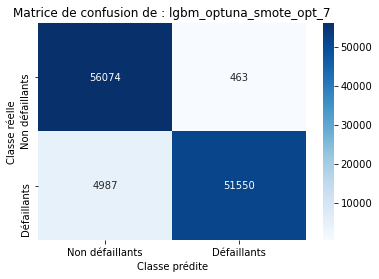

In [247]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_7,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_7')

In [248]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_7',
                                        4987, 43, 51550, 56074, df_taux)

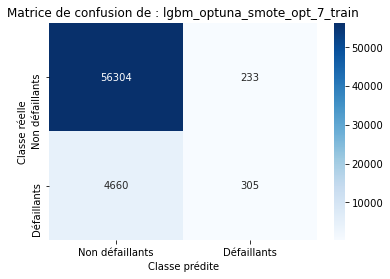

In [249]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_7,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_7_train')

In [250]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_7_train',
                                        4660, 233, 305, 56304, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score F10**</span>

In [251]:
# Modèle et hyperparamètres à étudier
def create_model_6(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f10_score',
#         class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [252]:
# Objective fonction
def objective_6(trial):
    model = create_model_6(trial)
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_valid_smote)
    score = fbeta_score(y_valid_smote, y_pred_smote, 10)
    return score

In [253]:
# Recherche des paramètres
study_6 = optuna.create_study(direction='maximize')
study_6.optimize(objective_6, n_trials=100)

[I 2021-08-11 22:28:05,871] A new study created in memory with name: no-name-6dc5b858-d47f-4a53-902e-4e3f540789d6
[I 2021-08-11 22:28:19,702] Trial 0 finished with value: 0.9081030490936145 and parameters: {'max_depth': 7, 'subsample': 0.4515727268144012, 'colsample_bytree': 0.2401557991674066, 'reg_alpha': 0.0007076889128910802, 'reg_lambda': 0.022698096131958962, 'num_leaves': 213, 'min_child_weight': 0.771346459851356, 'subsample_freq': 2, 'min_child_samples': 37}. Best is trial 0 with value: 0.9081030490936145.
[I 2021-08-11 22:28:42,101] Trial 1 finished with value: 0.9103516581087407 and parameters: {'max_depth': 10, 'subsample': 0.9784221798514771, 'colsample_bytree': 0.42511123956986085, 'reg_alpha': 6.835796533940549, 'reg_lambda': 0.12444689383452978, 'num_leaves': 60, 'min_child_weight': 0.841402649118878, 'subsample_freq': 2, 'min_child_samples': 10}. Best is trial 1 with value: 0.9103516581087407.
[I 2021-08-11 22:28:57,528] Trial 2 finished with value: 0.8995929198731346 

[I 2021-08-11 22:34:05,776] Trial 20 finished with value: 0.9080246395371437 and parameters: {'max_depth': 6, 'subsample': 0.7040264171567504, 'colsample_bytree': 0.10347297536703114, 'reg_alpha': 0.0024411843693156205, 'reg_lambda': 5.0607412906020293e-05, 'num_leaves': 238, 'min_child_weight': 0.46266901559617835, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 17 with value: 0.9140100083005239.
[I 2021-08-11 22:34:22,349] Trial 21 finished with value: 0.9121269129534542 and parameters: {'max_depth': 9, 'subsample': 0.8192304679157755, 'colsample_bytree': 0.19558797793784574, 'reg_alpha': 1.008901553950336, 'reg_lambda': 9.41263448504406e-05, 'num_leaves': 246, 'min_child_weight': 0.6452421583741007, 'subsample_freq': 5, 'min_child_samples': 46}. Best is trial 17 with value: 0.9140100083005239.
[I 2021-08-11 22:34:37,402] Trial 22 finished with value: 0.9127768078775566 and parameters: {'max_depth': 9, 'subsample': 0.8801462963999119, 'colsample_bytree': 0.12407746039490

[I 2021-08-11 22:40:09,645] Trial 40 finished with value: 0.9103545300773326 and parameters: {'max_depth': 8, 'subsample': 0.9094737030156808, 'colsample_bytree': 0.7271001955765625, 'reg_alpha': 0.02771185846346491, 'reg_lambda': 5.372375191525306e-08, 'num_leaves': 238, 'min_child_weight': 0.8481779863731861, 'subsample_freq': 6, 'min_child_samples': 76}. Best is trial 35 with value: 0.9141661966765713.
[I 2021-08-11 22:40:25,408] Trial 41 finished with value: 0.9129548869373617 and parameters: {'max_depth': 11, 'subsample': 0.7481955082009596, 'colsample_bytree': 0.16869599957598697, 'reg_alpha': 0.4402347063455724, 'reg_lambda': 2.0767169334999844e-06, 'num_leaves': 152, 'min_child_weight': 0.6724142040259843, 'subsample_freq': 5, 'min_child_samples': 10}. Best is trial 35 with value: 0.9141661966765713.
[I 2021-08-11 22:40:41,903] Trial 42 finished with value: 0.9130650352088052 and parameters: {'max_depth': 11, 'subsample': 0.6152922474029723, 'colsample_bytree': 0.21059207448688

[I 2021-08-11 22:44:46,102] Trial 60 finished with value: 0.8903309329971238 and parameters: {'max_depth': 4, 'subsample': 0.27187191070097416, 'colsample_bytree': 0.2200627729977509, 'reg_alpha': 0.0015775657220587092, 'reg_lambda': 0.0021697055431719424, 'num_leaves': 7, 'min_child_weight': 0.7660819838989908, 'subsample_freq': 6, 'min_child_samples': 15}. Best is trial 45 with value: 0.9141676386334221.
[I 2021-08-11 22:44:59,309] Trial 61 finished with value: 0.9143181372067917 and parameters: {'max_depth': 11, 'subsample': 0.4171862540157856, 'colsample_bytree': 0.12925965387028576, 'reg_alpha': 0.0006281111251611371, 'reg_lambda': 0.029708618459910442, 'num_leaves': 190, 'min_child_weight': 0.7975125887478652, 'subsample_freq': 7, 'min_child_samples': 43}. Best is trial 61 with value: 0.9143181372067917.
[I 2021-08-11 22:45:13,122] Trial 62 finished with value: 0.9133995977446216 and parameters: {'max_depth': 11, 'subsample': 0.41228996289450415, 'colsample_bytree': 0.17813475340

[I 2021-08-11 22:49:41,691] Trial 80 finished with value: 0.9083054103858291 and parameters: {'max_depth': 7, 'subsample': 0.6091322581495682, 'colsample_bytree': 0.26631076378657537, 'reg_alpha': 0.05485988741611642, 'reg_lambda': 0.007767418637457016, 'num_leaves': 122, 'min_child_weight': 0.8696590050941481, 'subsample_freq': 2, 'min_child_samples': 19}. Best is trial 73 with value: 0.9143560297624452.
[I 2021-08-11 22:49:55,239] Trial 81 finished with value: 0.9129551477083129 and parameters: {'max_depth': 11, 'subsample': 0.41089616945321905, 'colsample_bytree': 0.15211216876752962, 'reg_alpha': 0.13466933556541144, 'reg_lambda': 9.941300821250913, 'num_leaves': 201, 'min_child_weight': 0.6939263090812113, 'subsample_freq': 5, 'min_child_samples': 30}. Best is trial 73 with value: 0.9143560297624452.
[I 2021-08-11 22:50:08,635] Trial 82 finished with value: 0.9138281863696163 and parameters: {'max_depth': 11, 'subsample': 0.5566827351227945, 'colsample_bytree': 0.10084953911903949

In [254]:
params_6 = study_6.best_params
print(f'Nombre d\'essai terminés : {len(study_6.trials)}')
print('Best hyperparamètres:\n')
print(params_6)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.5824550271928287, 'colsample_bytree': 0.15487919565645963, 'reg_alpha': 0.004413221213311105, 'reg_lambda': 5.30035157304974e-05, 'num_leaves': 146, 'min_child_weight': 0.7932754735625628, 'subsample_freq': 5, 'min_child_samples': 72}


In [255]:
param_lgbm_optuna_opt_6 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.15487919565645963,
                           'max_depth': 11,
                           'min_child_samples': 72,
                           'min_child_weight': 0.7932754735625628,
                           'num_leaves': 146,
                           'reg_alpha': 0.004413221213311105,
                           'reg_lambda': 5.30035157304974e-05,
                           'subsample': 0.5824550271928287,
                           'subsample_freq': 5,
                           'verbosity' : -1}

In [256]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_6 = LGBMClassifier(**param_lgbm_optuna_opt_6,
                                         force_col_wise=True)

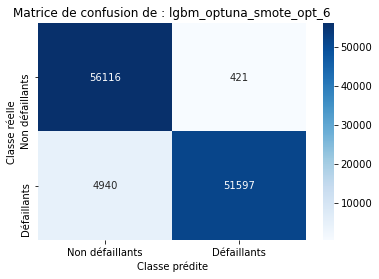

In [257]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_6,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_6')

In [258]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_6',
                                        4940, 421, 51597, 56116, df_taux)

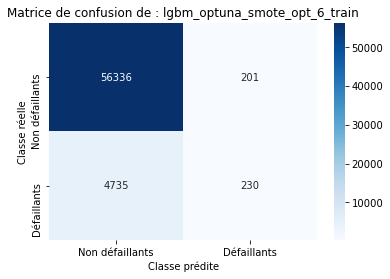

In [259]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_6,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_6_train')

In [260]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_6_train',
                                        4735, 201, 230, 56336, df_taux)

#### <span style='background:Moccasin'>6.6.2. Rééquilibrage - oversampling : SMOTE auto</span>

In [261]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)
# Application de l'oversampling via SMOTE avec les paramètres par défaut
oversample = SMOTE(sampling_strategy='auto', k_neighbors=5, n_jobs=-1,
                   random_state=seed)
X_train_smote_1, y_train_smote_1 = \
    oversample.fit_resample(X_train, y_train)
X_valid_smote_1, y_valid_smote_1 = \
    oversample.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_1 = Counter(y_train_smote_1)
print(counter_smote_1)

Counter({0: 226145, 1: 19860})
Counter({0: 226145, 1: 226145})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [262]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base_1 = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True)

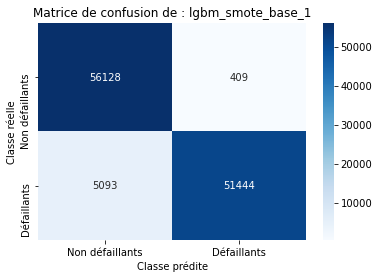

In [263]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_1,
                                        X_train_smote_1, X_valid_smote_1,
                                        y_train_smote_1, y_valid_smote_1,
                                        df_resultats,
                                        'lgbm_smote_base_1')

In [264]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_base_1',
                                        5093, 409, 51444, 56128, df_taux)

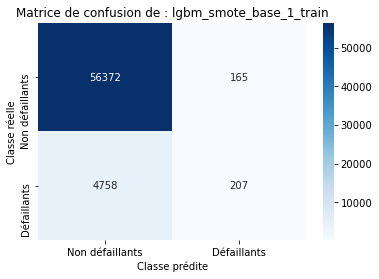

In [265]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_1,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_base_1_train')

In [266]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_base_1_train',
                                        4758, 165, 207, 56372, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [267]:
# Modèle et hyperparamètres à étudier
def create_model_8(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [268]:
# Objective fonction
def objective_8(trial):
    model = create_model_8(trial)
    model.fit(X_train_smote_1, y_train_smote_1)
    y_proba_smote_1 = model.predict_proba(X_valid_smote_1)[:,1]
    score = roc_auc_score(y_valid_smote_1, y_proba_smote_1)
    return score

In [269]:
# Recherche des paramètres
study_8 = optuna.create_study(direction='maximize')
study_8.optimize(objective_8, n_trials=100)

[I 2021-08-11 23:13:39,452] A new study created in memory with name: no-name-7012956c-3835-4310-af9c-2fd24df1ae30
[I 2021-08-11 23:14:04,585] Trial 0 finished with value: 0.9779053570208667 and parameters: {'max_depth': 10, 'subsample': 0.5414514019070844, 'colsample_bytree': 0.7153880761757581, 'reg_alpha': 0.057053441754142294, 'reg_lambda': 2.4206217663064796e-05, 'num_leaves': 225, 'min_child_weight': 0.8433569539564518, 'subsample_freq': 7, 'min_child_samples': 33}. Best is trial 0 with value: 0.9779053570208667.
[I 2021-08-11 23:14:26,220] Trial 1 finished with value: 0.9781704966835167 and parameters: {'max_depth': 11, 'subsample': 0.9177731328847298, 'colsample_bytree': 0.35984199070145606, 'reg_alpha': 7.54609693583333e-06, 'reg_lambda': 2.255954662388525e-07, 'num_leaves': 252, 'min_child_weight': 0.779014217322522, 'subsample_freq': 1, 'min_child_samples': 25}. Best is trial 1 with value: 0.9781704966835167.
[I 2021-08-11 23:14:40,194] Trial 2 finished with value: 0.97154798

[I 2021-08-11 23:21:09,485] Trial 20 finished with value: 0.9778060003120935 and parameters: {'max_depth': 8, 'subsample': 0.9992397856709432, 'colsample_bytree': 0.8443700080266275, 'reg_alpha': 6.972571472437676e-08, 'reg_lambda': 5.145006654265322e-07, 'num_leaves': 220, 'min_child_weight': 0.7537886684789228, 'subsample_freq': 5, 'min_child_samples': 5}. Best is trial 16 with value: 0.9782564675310981.
[I 2021-08-11 23:21:39,665] Trial 21 finished with value: 0.9782609944530942 and parameters: {'max_depth': 11, 'subsample': 0.8900881260435255, 'colsample_bytree': 0.6591479544670442, 'reg_alpha': 8.927172938035716e-07, 'reg_lambda': 1.6084741496852897e-07, 'num_leaves': 173, 'min_child_weight': 0.9275496890889995, 'subsample_freq': 7, 'min_child_samples': 15}. Best is trial 21 with value: 0.9782609944530942.
[I 2021-08-11 23:22:07,942] Trial 22 finished with value: 0.9782466594086727 and parameters: {'max_depth': 10, 'subsample': 0.8381880932900554, 'colsample_bytree': 0.66911159568

[I 2021-08-11 23:29:45,600] Trial 40 finished with value: 0.9783941034793093 and parameters: {'max_depth': 11, 'subsample': 0.9964751226192593, 'colsample_bytree': 0.9723893971299814, 'reg_alpha': 0.0001674459766104164, 'reg_lambda': 0.0021707829470796903, 'num_leaves': 71, 'min_child_weight': 0.7934362838305083, 'subsample_freq': 3, 'min_child_samples': 45}. Best is trial 34 with value: 0.9785698725665734.
[I 2021-08-11 23:30:18,517] Trial 41 finished with value: 0.9783411090841698 and parameters: {'max_depth': 11, 'subsample': 0.9974621425280997, 'colsample_bytree': 0.9763324988462314, 'reg_alpha': 0.00022531181657043463, 'reg_lambda': 0.0011308213253262245, 'num_leaves': 66, 'min_child_weight': 0.7899554606067303, 'subsample_freq': 3, 'min_child_samples': 56}. Best is trial 34 with value: 0.9785698725665734.
[I 2021-08-11 23:30:35,858] Trial 42 finished with value: 0.9775327825808287 and parameters: {'max_depth': 10, 'subsample': 0.312854069813968, 'colsample_bytree': 0.886717528809

[I 2021-08-11 23:39:04,640] Trial 60 finished with value: 0.9776986046408042 and parameters: {'max_depth': 10, 'subsample': 0.8551254933636823, 'colsample_bytree': 0.23936982750803665, 'reg_alpha': 2.9205653068043046e-05, 'reg_lambda': 0.03141853445747005, 'num_leaves': 103, 'min_child_weight': 0.7703674600269984, 'subsample_freq': 4, 'min_child_samples': 55}. Best is trial 57 with value: 0.9786983317212178.
[I 2021-08-11 23:39:39,183] Trial 61 finished with value: 0.9785738904835874 and parameters: {'max_depth': 11, 'subsample': 0.975017788863522, 'colsample_bytree': 0.977061376277127, 'reg_alpha': 0.0008409779847554698, 'reg_lambda': 0.013177170869393994, 'num_leaves': 116, 'min_child_weight': 0.8223381174629334, 'subsample_freq': 1, 'min_child_samples': 40}. Best is trial 57 with value: 0.9786983317212178.
[I 2021-08-11 23:40:11,763] Trial 62 finished with value: 0.9785259845740226 and parameters: {'max_depth': 11, 'subsample': 0.9355337854632227, 'colsample_bytree': 0.9465647159510

[I 2021-08-11 23:49:44,291] Trial 80 finished with value: 0.9784298048447151 and parameters: {'max_depth': 11, 'subsample': 0.7119006855657954, 'colsample_bytree': 0.9928435367691416, 'reg_alpha': 0.00038263490723792397, 'reg_lambda': 0.00017777824073182436, 'num_leaves': 135, 'min_child_weight': 0.8042050258202221, 'subsample_freq': 2, 'min_child_samples': 38}. Best is trial 57 with value: 0.9786983317212178.
[I 2021-08-11 23:50:17,283] Trial 81 finished with value: 0.9785646251538132 and parameters: {'max_depth': 11, 'subsample': 0.929100989465954, 'colsample_bytree': 0.9451682216641117, 'reg_alpha': 8.580428121630366e-05, 'reg_lambda': 0.004828836988478107, 'num_leaves': 120, 'min_child_weight': 0.8250994579654146, 'subsample_freq': 1, 'min_child_samples': 47}. Best is trial 57 with value: 0.9786983317212178.
[I 2021-08-11 23:50:55,090] Trial 82 finished with value: 0.9786830083874676 and parameters: {'max_depth': 11, 'subsample': 0.8800664892318504, 'colsample_bytree': 0.9996005733

In [270]:
params_8 = study_8.best_params
print(f'Nombre d\'essai terminés : {len(study_8.trials)}')
print('Best hyperparamètres:\n')
print(params_8)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.8136802004541983, 'colsample_bytree': 0.9175831290521934, 'reg_alpha': 8.106439817607536e-05, 'reg_lambda': 0.015593996505234223, 'num_leaves': 112, 'min_child_weight': 0.811733013820616, 'subsample_freq': 1, 'min_child_samples': 37}


In [303]:
param_lgbm_optuna_opt_8 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.9175831290521934,
                           'max_depth': 11,
                           'min_child_samples': 37,
                           'min_child_weight': 0.811733013820616,
                           'num_leaves': 112,
                           'reg_alpha': 8.106439817607536e-05,
                           'reg_lambda': 0.015593996505234223,
                           'subsample': 0.8136802004541983,
                           'subsample_freq': 1,
                           'verbosity' : -1}

In [304]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_8 = LGBMClassifier(**param_lgbm_optuna_opt_8,
                                         force_col_wise=True)

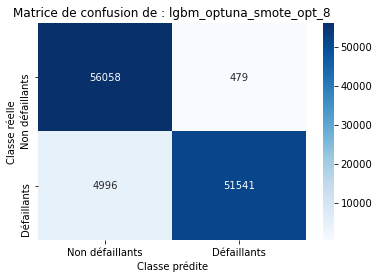

In [305]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_8,
                                        X_train_smote_1, X_valid_smote_1,
                                        y_train_smote_1, y_valid_smote_1,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_8')

In [306]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_8',
                                        4996, 479, 51541, 56058, df_taux)

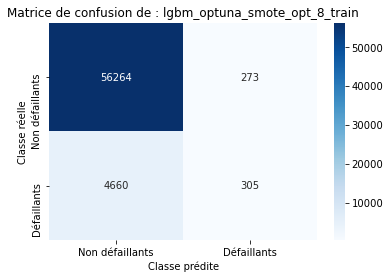

In [307]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_8,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_8_train')

In [308]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_8_train',
                                        4660, 273, 305, 56264, df_taux)

#### <span style='background:Moccasin'>6.6.3. Rééquilibrage - combinaison oversampling/undersampling : SMOTE</span>

In [271]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)

# define pipeline
over = SMOTE(sampling_strategy=0.1, random_state=seed)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=seed)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_train_smote_combi, y_train_smote_combi = \
    pipeline.fit_resample(X_train, y_train)
X_valid_smote_combi, y_valid_smote_combi = \
    pipeline.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_combi = Counter(y_train_smote_combi)
print(counter_smote_combi)

Counter({0: 226145, 1: 19860})
Counter({0: 45228, 1: 22614})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [272]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base_2 = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True)

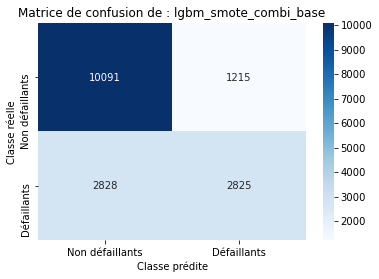

In [273]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_2,
                                        X_train_smote_combi,
                                        X_valid_smote_combi,
                                        y_train_smote_combi,
                                        y_valid_smote_combi,
                                        df_resultats,
                                        'lgbm_smote_combi_base')

In [309]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_combi_base',
                                        2828, 1215, 2825, 10091, df_taux)

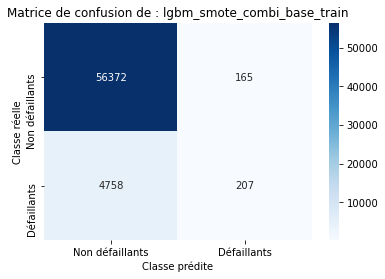

In [310]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_2,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_combi_base_train')

In [311]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_combi_base_train',
                                        4758, 165, 207, 56372, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [274]:
# Modèle et hyperparamètres à étudier
def create_model_9(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [275]:
# Objective fonction
def objective_9(trial):
    model = create_model_9(trial)
    model.fit(X_train_smote_combi, y_train_smote_combi)
    y_proba_smote_combi = model.predict_proba(X_valid_smote_combi)[:,1]
    score = roc_auc_score(y_valid_smote_combi, y_proba_smote_combi)
    return score

In [276]:
# Recherche des paramètres
study_9 = optuna.create_study(direction='maximize')
study_9.optimize(objective_9, n_trials=100)

[I 2021-08-12 00:01:10,734] A new study created in memory with name: no-name-9039410d-10a0-43c1-8832-7cddeab4dc4a
[I 2021-08-12 00:01:13,173] Trial 0 finished with value: 0.7979569450372224 and parameters: {'max_depth': 5, 'subsample': 0.5607271955625566, 'colsample_bytree': 0.5226939842216173, 'reg_alpha': 0.01808298981971181, 'reg_lambda': 1.1453032446224784e-05, 'num_leaves': 206, 'min_child_weight': 0.9988657573210904, 'subsample_freq': 4, 'min_child_samples': 85}. Best is trial 0 with value: 0.7979569450372224.
[I 2021-08-12 00:01:15,992] Trial 1 finished with value: 0.8001401690659299 and parameters: {'max_depth': 5, 'subsample': 0.7652018612179577, 'colsample_bytree': 0.48774216620025623, 'reg_alpha': 6.076539221000252e-08, 'reg_lambda': 0.0029077577308139592, 'num_leaves': 236, 'min_child_weight': 0.7315786263669075, 'subsample_freq': 2, 'min_child_samples': 80}. Best is trial 1 with value: 0.8001401690659299.
[I 2021-08-12 00:01:20,073] Trial 2 finished with value: 0.792870265

[I 2021-08-12 00:02:18,574] Trial 20 finished with value: 0.7922954203020747 and parameters: {'max_depth': 3, 'subsample': 0.889902964953031, 'colsample_bytree': 0.9470418834563481, 'reg_alpha': 3.832562833859465e-05, 'reg_lambda': 0.00023966379373950754, 'num_leaves': 145, 'min_child_weight': 0.9841435060364687, 'subsample_freq': 6, 'min_child_samples': 5}. Best is trial 18 with value: 0.8021284869648527.
[I 2021-08-12 00:02:22,487] Trial 21 finished with value: 0.8017880231786996 and parameters: {'max_depth': 6, 'subsample': 0.9872631078057565, 'colsample_bytree': 0.7209328771448258, 'reg_alpha': 0.00012462372009119729, 'reg_lambda': 0.022197259611772862, 'num_leaves': 255, 'min_child_weight': 0.8766479683222421, 'subsample_freq': 6, 'min_child_samples': 64}. Best is trial 18 with value: 0.8021284869648527.
[I 2021-08-12 00:02:25,458] Trial 22 finished with value: 0.799335291396477 and parameters: {'max_depth': 8, 'subsample': 0.9909972607991546, 'colsample_bytree': 0.103376828992923

[I 2021-08-12 00:03:36,980] Trial 40 finished with value: 0.7994085317909155 and parameters: {'max_depth': 10, 'subsample': 0.9483520520909062, 'colsample_bytree': 0.2267291442278171, 'reg_alpha': 0.05440601651794556, 'reg_lambda': 0.00010095579318857642, 'num_leaves': 220, 'min_child_weight': 0.8546683661066354, 'subsample_freq': 4, 'min_child_samples': 56}. Best is trial 24 with value: 0.8021587312892385.
[I 2021-08-12 00:03:42,317] Trial 41 finished with value: 0.8019805041298602 and parameters: {'max_depth': 8, 'subsample': 0.9992192241203756, 'colsample_bytree': 0.8674794136306111, 'reg_alpha': 0.0015572743626058045, 'reg_lambda': 1.1573893211196082, 'num_leaves': 72, 'min_child_weight': 0.7700750366881592, 'subsample_freq': 4, 'min_child_samples': 87}. Best is trial 24 with value: 0.8021587312892385.
[I 2021-08-12 00:03:46,139] Trial 42 finished with value: 0.801717348779708 and parameters: {'max_depth': 8, 'subsample': 0.9899970790712945, 'colsample_bytree': 0.8367227166723177, 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2021-08-12 00:04:21,891] Trial 51 finished with value: 0.8012025381199748 and parameters: {'max_depth': 9, 'subsample': 0.7798086184365954, 'colsample_bytree': 0.9155037698278237, 'reg_alpha': 2.4053240542630633e-06, 'reg_lambda': 0.000981803710036097, 'num_leaves': 31, 'min_child_weight': 0.5365176966874958, 'subsample_freq': 5, 'min_child_samples': 71}. Best is trial 45 with value: 0.8028859719501025.
[I 2021-08-12 00:04:26,860] Trial 52 finished with value: 0.8006804519243699 and parameters: {'max_depth': 10, 'subsample': 0.6662388917939155, 'colsample_bytree': 0.9918229556424613, 'reg_alpha': 1.5325472166477117e-05, 'reg_lambda': 0.0001457607494477914, 'num_leaves': 54, 'min_child_weight': 0.6301805726507992, 'subsample_freq': 3, 'min_child_samples': 67}. Best is trial 45 with value: 0.8028859719501025.
[I 2021-08-12 00:04:29,894] Trial 53 finished with value: 0.8014289246329273 and parameters: {'max_depth': 9, 'subsample': 0.4961695259121732, 'colsample_bytree': 0.7588639900806

[I 2021-08-12 00:05:41,949] Trial 71 finished with value: 0.8020159899693361 and parameters: {'max_depth': 8, 'subsample': 0.9704437392475721, 'colsample_bytree': 0.8866558739591729, 'reg_alpha': 9.844360764947594e-05, 'reg_lambda': 2.259020058623569, 'num_leaves': 114, 'min_child_weight': 0.7947525006256665, 'subsample_freq': 4, 'min_child_samples': 70}. Best is trial 45 with value: 0.8028859719501025.
[I 2021-08-12 00:05:46,875] Trial 72 finished with value: 0.800209497881943 and parameters: {'max_depth': 7, 'subsample': 0.8941655395466586, 'colsample_bytree': 0.9429007319898041, 'reg_alpha': 0.00011382874451759836, 'reg_lambda': 0.005114784720173707, 'num_leaves': 122, 'min_child_weight': 0.8731771719016989, 'subsample_freq': 3, 'min_child_samples': 73}. Best is trial 45 with value: 0.8028859719501025.
[I 2021-08-12 00:05:50,888] Trial 73 finished with value: 0.8012759662701776 and parameters: {'max_depth': 6, 'subsample': 0.9681300155272994, 'colsample_bytree': 0.8524994756108216, 

[I 2021-08-12 00:07:43,329] Trial 91 finished with value: 0.8012538736752305 and parameters: {'max_depth': 10, 'subsample': 0.9773125279153188, 'colsample_bytree': 0.5404111010568928, 'reg_alpha': 1.989751776797573e-06, 'reg_lambda': 0.0015595779554326782, 'num_leaves': 128, 'min_child_weight': 0.7373858300143433, 'subsample_freq': 1, 'min_child_samples': 66}. Best is trial 45 with value: 0.8028859719501025.
[I 2021-08-12 00:07:50,615] Trial 92 finished with value: 0.7995969134078864 and parameters: {'max_depth': 9, 'subsample': 0.9313847528619346, 'colsample_bytree': 0.9824342080880878, 'reg_alpha': 5.417655201108585e-05, 'reg_lambda': 0.007163535879911063, 'num_leaves': 241, 'min_child_weight': 0.6921859202827281, 'subsample_freq': 4, 'min_child_samples': 61}. Best is trial 45 with value: 0.8028859719501025.
[I 2021-08-12 00:07:53,244] Trial 93 finished with value: 0.7991215627513091 and parameters: {'max_depth': 8, 'subsample': 0.9541751745958503, 'colsample_bytree': 0.1550919387540

In [277]:
params_9 = study_9.best_params
print(f'Nombre d\'essai terminés : {len(study_9.trials)}')
print('Best hyperparamètres:\n')
print(params_9)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 9, 'subsample': 0.7756054355552997, 'colsample_bytree': 0.9420987378641661, 'reg_alpha': 0.021361918281006784, 'reg_lambda': 0.0023439174098878043, 'num_leaves': 45, 'min_child_weight': 0.6098741184464467, 'subsample_freq': 4, 'min_child_samples': 78}


In [312]:
param_lgbm_optuna_opt_9 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.9420987378641661,
                           'max_depth': 9,
                           'min_child_samples': 78,
                           'min_child_weight': 0.6098741184464467,
                           'num_leaves': 45,
                           'reg_alpha': 0.021361918281006784,
                           'reg_lambda': 0.0023439174098878043,
                           'subsample': 0.7756054355552997,
                           'subsample_freq': 4,
                           'verbosity' : -1}

In [313]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_9 = LGBMClassifier(**param_lgbm_optuna_opt_9,
                                         force_col_wise=True)

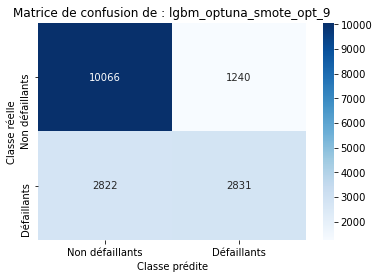

In [314]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_9,
                                        X_train_smote_combi,
                                        X_valid_smote_combi,
                                        y_train_smote_combi,
                                        y_valid_smote_combi,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_9')

In [315]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_9',
                                        2822, 1240, 2831, 10066, df_taux)

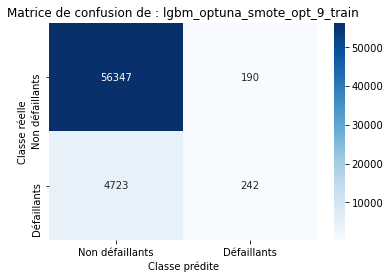

In [316]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_9,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_9_train')

In [317]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_9_train',
                                        4723, 190, 242, 56347, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score F10**</span>

In [278]:
# Modèle et hyperparamètres à étudier
def create_model_10(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f10_score',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [279]:
# Objective fonction
def objective_10(trial):
    model = create_model_10(trial)
    model.fit(X_train_smote_combi, y_train_smote_combi)
    y_pred_smote_combi = model.predict(X_valid_smote_combi)
    score = fbeta_score(y_valid_smote_combi, y_pred_smote_combi, 10)
    return score

In [280]:
# Recherche des paramètres
study_10 = optuna.create_study(direction='maximize')
study_10.optimize(objective_10, n_trials=100)

[I 2021-08-12 00:08:24,441] A new study created in memory with name: no-name-90e3d1e8-0a84-4a1d-8d60-f7a0ca1d5d27
[I 2021-08-12 00:08:29,653] Trial 0 finished with value: 0.5042860529851337 and parameters: {'max_depth': 8, 'subsample': 0.6547235972527472, 'colsample_bytree': 0.9838713602445452, 'reg_alpha': 8.38391026150636e-05, 'reg_lambda': 0.0005635449662679362, 'num_leaves': 231, 'min_child_weight': 0.8817305540236053, 'subsample_freq': 5, 'min_child_samples': 55}. Best is trial 0 with value: 0.5042860529851337.
[I 2021-08-12 00:08:31,119] Trial 1 finished with value: 0.43573975232590034 and parameters: {'max_depth': 3, 'subsample': 0.3558132605082305, 'colsample_bytree': 0.11057336843347565, 'reg_alpha': 0.015352213257451845, 'reg_lambda': 2.9512600769932844e-08, 'num_leaves': 91, 'min_child_weight': 0.9463157200180192, 'subsample_freq': 4, 'min_child_samples': 73}. Best is trial 0 with value: 0.5042860529851337.
[I 2021-08-12 00:08:33,447] Trial 2 finished with value: 0.474563345

[I 2021-08-12 00:09:48,790] Trial 20 finished with value: 0.5100875737317437 and parameters: {'max_depth': 10, 'subsample': 0.9061442856392002, 'colsample_bytree': 0.7403380090968, 'reg_alpha': 5.674744269391275, 'reg_lambda': 0.04526259398066173, 'num_leaves': 78, 'min_child_weight': 0.6020373111109047, 'subsample_freq': 3, 'min_child_samples': 22}. Best is trial 20 with value: 0.5100875737317437.
[I 2021-08-12 00:09:54,092] Trial 21 finished with value: 0.50079741735138 and parameters: {'max_depth': 10, 'subsample': 0.912082171867818, 'colsample_bytree': 0.7542841430514795, 'reg_alpha': 9.850688677639198, 'reg_lambda': 0.06041967548833388, 'num_leaves': 66, 'min_child_weight': 0.6057196040958064, 'subsample_freq': 3, 'min_child_samples': 19}. Best is trial 20 with value: 0.5100875737317437.
[I 2021-08-12 00:09:58,593] Trial 22 finished with value: 0.4988267528453 and parameters: {'max_depth': 9, 'subsample': 0.9165729712398727, 'colsample_bytree': 0.5538449812731396, 'reg_alpha': 0.2

[I 2021-08-12 00:11:28,310] Trial 40 finished with value: 0.5009378622361164 and parameters: {'max_depth': 8, 'subsample': 0.8464080215287912, 'colsample_bytree': 0.8614691497354203, 'reg_alpha': 0.07568361357869845, 'reg_lambda': 3.6346963898522647e-06, 'num_leaves': 80, 'min_child_weight': 0.6851142641757211, 'subsample_freq': 2, 'min_child_samples': 37}. Best is trial 20 with value: 0.5100875737317437.
[I 2021-08-12 00:11:31,568] Trial 41 finished with value: 0.49064258466985605 and parameters: {'max_depth': 8, 'subsample': 0.2523879039370667, 'colsample_bytree': 0.9412368370132456, 'reg_alpha': 8.26594520920985e-05, 'reg_lambda': 0.0008384766453612871, 'num_leaves': 171, 'min_child_weight': 0.878101323238976, 'subsample_freq': 5, 'min_child_samples': 77}. Best is trial 20 with value: 0.5100875737317437.
[I 2021-08-12 00:11:35,572] Trial 42 finished with value: 0.49423365382250967 and parameters: {'max_depth': 7, 'subsample': 0.7959103055618442, 'colsample_bytree': 0.702266539304876

[I 2021-08-12 00:13:40,025] Trial 60 finished with value: 0.4995152656203897 and parameters: {'max_depth': 10, 'subsample': 0.9705073561047369, 'colsample_bytree': 0.7742530983642439, 'reg_alpha': 0.000934924718567537, 'reg_lambda': 0.009563405396016866, 'num_leaves': 224, 'min_child_weight': 0.9412434979404125, 'subsample_freq': 1, 'min_child_samples': 5}. Best is trial 54 with value: 0.5106331043396412.
[I 2021-08-12 00:13:47,737] Trial 61 finished with value: 0.5039242166933314 and parameters: {'max_depth': 10, 'subsample': 0.9981406702691393, 'colsample_bytree': 0.8500655407211359, 'reg_alpha': 0.00015440389128736504, 'reg_lambda': 0.14005700463748402, 'num_leaves': 158, 'min_child_weight': 0.9714589647940203, 'subsample_freq': 1, 'min_child_samples': 14}. Best is trial 54 with value: 0.5106331043396412.
[I 2021-08-12 00:13:55,371] Trial 62 finished with value: 0.5044341965235899 and parameters: {'max_depth': 11, 'subsample': 0.9392443692447986, 'colsample_bytree': 0.83635690439305

[I 2021-08-12 00:16:16,346] Trial 80 finished with value: 0.5053228106407041 and parameters: {'max_depth': 10, 'subsample': 0.9532593055128358, 'colsample_bytree': 0.9740825956725787, 'reg_alpha': 0.1470057954955931, 'reg_lambda': 0.005984648802243924, 'num_leaves': 176, 'min_child_weight': 0.8499874957545668, 'subsample_freq': 2, 'min_child_samples': 12}. Best is trial 54 with value: 0.5106331043396412.
[I 2021-08-12 00:16:23,775] Trial 81 finished with value: 0.49775802868107455 and parameters: {'max_depth': 10, 'subsample': 0.9766492553032586, 'colsample_bytree': 0.8260156777212471, 'reg_alpha': 0.012064209987326215, 'reg_lambda': 0.03123887029272252, 'num_leaves': 163, 'min_child_weight': 0.8937785575609053, 'subsample_freq': 1, 'min_child_samples': 23}. Best is trial 54 with value: 0.5106331043396412.
[I 2021-08-12 00:16:31,664] Trial 82 finished with value: 0.5037282635037598 and parameters: {'max_depth': 10, 'subsample': 0.9945704878816845, 'colsample_bytree': 0.8602230375989544

In [281]:
params_10 = study_10.best_params
print(f'Nombre d\'essai terminés : {len(study_10.trials)}')
print('Best hyperparamètres:\n')
print(params_10)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 10, 'subsample': 0.996646242561465, 'colsample_bytree': 0.8198393560868127, 'reg_alpha': 0.0004966262194696634, 'reg_lambda': 0.1158716243857375, 'num_leaves': 176, 'min_child_weight': 0.9650088342361347, 'subsample_freq': 1, 'min_child_samples': 19}


In [318]:
param_lgbm_optuna_opt_10 = {'objective' : 'binary',
                            'boosting_type' : 'gbdt',
                            'n_jobs' : -1,    
                            'colsample_bytree': 0.8198393560868127,
                            'max_depth': 10,
                            'min_child_samples': 19,
                            'min_child_weight': 0.9650088342361347,
                            'num_leaves': 176,
                            'reg_alpha': 0.0004966262194696634,
                            'reg_lambda': 0.1158716243857375,
                            'subsample': 0.996646242561465,
                            'subsample_freq': 1,
                            'verbosity' : -1}

In [319]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_10 = LGBMClassifier(**param_lgbm_optuna_opt_10,
                                          force_col_wise=True)

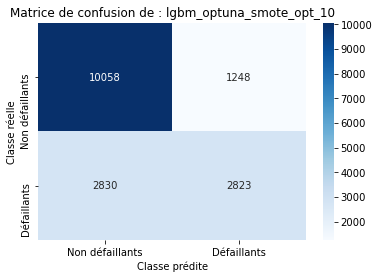

In [320]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_10,
                                        X_train_smote_combi,
                                        X_valid_smote_combi,
                                        y_train_smote_combi,
                                        y_valid_smote_combi,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_10')

In [321]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_10',
                                        2830, 1248, 2823, 10058, df_taux)

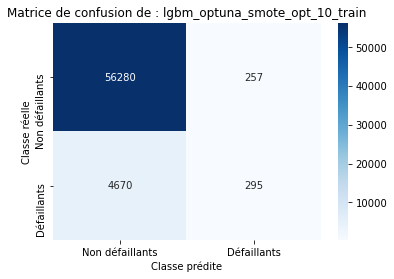

In [322]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_10,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_10_train')

In [323]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_10_train',
                                        4670, 257, 295, 56280, df_taux)

#### <span style='background:Moccasin'>6.6.4. Rééquilibrage - LigthGbm - BorderlineSMOTE</span>

In [282]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)
# Application de l'oversampling via SMOTE avec les paramètres par défaut
oversample = BorderlineSMOTE(random_state=seed)
X_train_smote_2, y_train_smote_2 = \
    oversample.fit_resample(X_train, y_train)
X_valid_smote_2, y_valid_smote_2 = \
    oversample.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_2 = Counter(y_train_smote_2)
print(counter_smote_2)

Counter({0: 226145, 1: 19860})
Counter({0: 226145, 1: 226145})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [283]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_bord_base_2 = LGBMClassifier(random_state=seed, verbose=0,
                                        force_col_wise=True) 

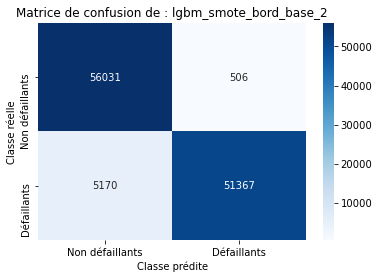

In [284]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_bord_base_2,
                                        X_train_smote_2, X_valid_smote_2,
                                        y_train_smote_2, y_valid_smote_2,
                                        df_resultats,
                                        'lgbm_smote_bord_base_2')

In [324]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_bord_base_2',
                                        5170, 506, 51367, 56031, df_taux)

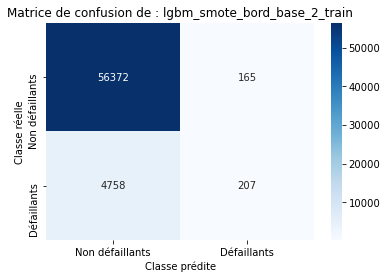

In [325]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_bord_base_2,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_bord_base_2_train')

In [326]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_bord_base_2_train',
                                        4758, 165, 207, 56372, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [285]:
# Modèle et hyperparamètres à étudier
def create_model_smote(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [286]:
# Objective fonction
def objective_smote(trial):
    model = create_model_smote(trial)
    model.fit(X_train_smote_2, y_train_smote_2)
    y_proba_smote_2 = model.predict_proba(X_valid_smote_2)[:,1]
    score = roc_auc_score(y_valid_smote_2, y_proba_smote_2)
    return score

In [287]:
# Recherche des paramètres
study_smote = optuna.create_study(direction='maximize')
study_smote.optimize(objective_smote, n_trials=100)

[I 2021-08-12 00:28:01,166] A new study created in memory with name: no-name-81baf653-8953-4d43-97fe-52f3766dfa25
[I 2021-08-12 00:28:18,244] Trial 0 finished with value: 0.9770067939766882 and parameters: {'max_depth': 7, 'subsample': 0.5077381748167618, 'colsample_bytree': 0.6068781520359424, 'reg_alpha': 1.5073888424150272e-06, 'reg_lambda': 0.014318109443169146, 'num_leaves': 142, 'min_child_weight': 0.7799930625276573, 'subsample_freq': 3, 'min_child_samples': 61}. Best is trial 0 with value: 0.9770067939766882.
[I 2021-08-12 00:28:39,344] Trial 1 finished with value: 0.9781265852273066 and parameters: {'max_depth': 10, 'subsample': 0.5819510121485607, 'colsample_bytree': 0.5260988713076296, 'reg_alpha': 1.7360413167235834e-07, 'reg_lambda': 0.0008442528967254018, 'num_leaves': 181, 'min_child_weight': 0.4383435537396762, 'subsample_freq': 5, 'min_child_samples': 9}. Best is trial 1 with value: 0.9781265852273066.
[I 2021-08-12 00:29:06,186] Trial 2 finished with value: 0.97786759

[I 2021-08-12 00:36:22,384] Trial 20 finished with value: 0.9785054701402944 and parameters: {'max_depth': 11, 'subsample': 0.9595853874305404, 'colsample_bytree': 0.853197024379807, 'reg_alpha': 0.13741601503197134, 'reg_lambda': 0.8903161548861735, 'num_leaves': 218, 'min_child_weight': 0.9041364716067648, 'subsample_freq': 6, 'min_child_samples': 82}. Best is trial 14 with value: 0.9785591493614362.
[I 2021-08-12 00:36:58,450] Trial 21 finished with value: 0.9784613409413262 and parameters: {'max_depth': 11, 'subsample': 0.9910975422042747, 'colsample_bytree': 0.8404697846307236, 'reg_alpha': 7.281846299378325, 'reg_lambda': 9.813116352276534, 'num_leaves': 222, 'min_child_weight': 0.9284862993779399, 'subsample_freq': 6, 'min_child_samples': 83}. Best is trial 14 with value: 0.9785591493614362.
[I 2021-08-12 00:37:38,526] Trial 22 finished with value: 0.978355544553053 and parameters: {'max_depth': 10, 'subsample': 0.9355894560445116, 'colsample_bytree': 0.9933104693640962, 'reg_al

[I 2021-08-12 00:45:43,221] Trial 40 finished with value: 0.9765399757156571 and parameters: {'max_depth': 10, 'subsample': 0.13004504075583512, 'colsample_bytree': 0.607206131070112, 'reg_alpha': 2.7024263442449704e-08, 'reg_lambda': 0.012217349689873707, 'num_leaves': 102, 'min_child_weight': 0.6714992200550919, 'subsample_freq': 7, 'min_child_samples': 86}. Best is trial 14 with value: 0.9785591493614362.
[I 2021-08-12 00:46:21,550] Trial 41 finished with value: 0.9785093447725627 and parameters: {'max_depth': 11, 'subsample': 0.9661821158012885, 'colsample_bytree': 0.8850659648830935, 'reg_alpha': 3.7976212342199016, 'reg_lambda': 9.274653698810704, 'num_leaves': 228, 'min_child_weight': 0.9147355087495503, 'subsample_freq': 6, 'min_child_samples': 81}. Best is trial 14 with value: 0.9785591493614362.
[I 2021-08-12 00:47:01,329] Trial 42 finished with value: 0.9785016840442339 and parameters: {'max_depth': 11, 'subsample': 0.9733558479308355, 'colsample_bytree': 0.9054929662380704,

[I 2021-08-12 00:56:46,854] Trial 60 finished with value: 0.9784894663604253 and parameters: {'max_depth': 11, 'subsample': 0.9369907059089952, 'colsample_bytree': 0.9254188451619102, 'reg_alpha': 2.4093155695891875e-07, 'reg_lambda': 4.306411743673437, 'num_leaves': 167, 'min_child_weight': 0.9327015458749768, 'subsample_freq': 4, 'min_child_samples': 51}. Best is trial 55 with value: 0.9786184977155072.
[I 2021-08-12 00:57:19,150] Trial 61 finished with value: 0.9782699006324573 and parameters: {'max_depth': 11, 'subsample': 0.7992636249184859, 'colsample_bytree': 0.9657730272392148, 'reg_alpha': 9.420484572392025, 'reg_lambda': 7.341549655021362, 'num_leaves': 142, 'min_child_weight': 0.9996851221151605, 'subsample_freq': 5, 'min_child_samples': 63}. Best is trial 55 with value: 0.9786184977155072.
[I 2021-08-12 00:57:52,041] Trial 62 finished with value: 0.9787010294163367 and parameters: {'max_depth': 11, 'subsample': 0.8661561877165942, 'colsample_bytree': 0.7874559955620002, 're

[I 2021-08-12 01:06:24,745] Trial 80 finished with value: 0.9784989253436008 and parameters: {'max_depth': 11, 'subsample': 0.9528831061276183, 'colsample_bytree': 0.8377552880683488, 'reg_alpha': 0.0009493520066931134, 'reg_lambda': 0.35812675587670817, 'num_leaves': 161, 'min_child_weight': 0.8771687202556745, 'subsample_freq': 1, 'min_child_samples': 42}. Best is trial 62 with value: 0.9787010294163367.
[I 2021-08-12 01:06:58,478] Trial 81 finished with value: 0.9785987582082329 and parameters: {'max_depth': 11, 'subsample': 0.9084576219007306, 'colsample_bytree': 0.8907834853378513, 'reg_alpha': 5.848430503276358, 'reg_lambda': 0.8588504818066411, 'num_leaves': 134, 'min_child_weight': 0.9836660225003256, 'subsample_freq': 6, 'min_child_samples': 65}. Best is trial 62 with value: 0.9787010294163367.
[I 2021-08-12 01:07:33,607] Trial 82 finished with value: 0.9785830284839041 and parameters: {'max_depth': 11, 'subsample': 0.9035651561514069, 'colsample_bytree': 0.9156483991735879, '

In [288]:
params_smote = study_smote.best_params
print(f'Nombre d\'essai terminés : {len(study_smote.trials)}')
print('Best hyperparamètres:\n')
print(params_smote)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.8661561877165942, 'colsample_bytree': 0.7874559955620002, 'reg_alpha': 2.1055044781764256e-05, 'reg_lambda': 2.0431994543605283, 'num_leaves': 160, 'min_child_weight': 0.9697865847250651, 'subsample_freq': 4, 'min_child_samples': 65}


In [327]:
param_lgbm_optuna_opt_smote = {'objective' : 'binary',
                               'boosting_type' : 'gbdt',
                               'n_jobs' : -1,    
                               'colsample_bytree': 0.7874559955620002,
                               'max_depth': 11,
                               'min_child_samples': 65,
                               'min_child_weight': 0.9697865847250651,
                               'num_leaves': 160,
                               'reg_alpha': 2.1055044781764256e-05,
                               'reg_lambda': 2.0431994543605283,
                               'subsample': 0.8661561877165942,
                               'subsample_freq': 4,
                               'verbosity' : -1}

In [328]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_smote = LGBMClassifier(**param_lgbm_optuna_opt_smote,
                                             force_col_wise=True)

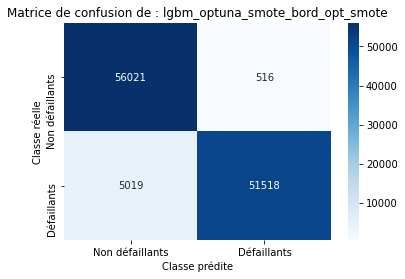

In [329]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_smote,
                                        X_train_smote_2, X_valid_smote_2,
                                        y_train_smote_2, y_valid_smote_2,
                                        df_resultats,
                                        'lgbm_optuna_smote_bord_opt_smote')

In [330]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_bord_opt_smote',
                                        5019, 516, 51518, 56021, df_taux)

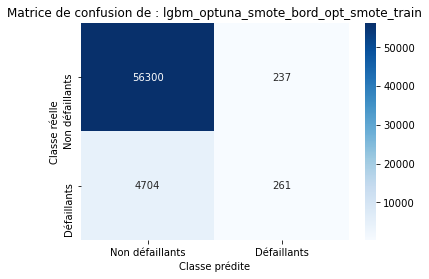

In [331]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_smote,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_bord_opt_smote_train')

In [332]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_bord_opt_smote_train',
                                        4704, 237, 261, 56300, df_taux)

#### <span style='background:Moccasin'>6.6.5. Rééquilibrage - LigthGbm - ADASYN</span>

In [289]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)
# Application de l'oversampling via SMOTE avec les paramètres par défaut
oversample = ADASYN(random_state=seed)
X_train_smote_3, y_train_smote_3 = \
    oversample.fit_resample(X_train, y_train)
X_valid_smote_3, y_valid_smote_3 = \
    oversample.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_3 = Counter(y_train_smote_3)
print(counter_smote_3)

Counter({0: 226145, 1: 19860})
Counter({1: 228270, 0: 226145})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [290]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_adasyn = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True) 

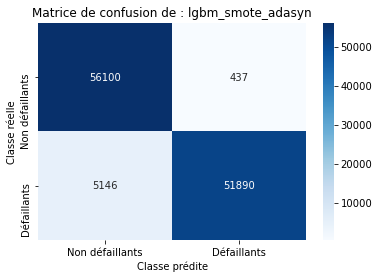

In [291]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_adasyn,
                                        X_train_smote_3, X_valid_smote_3,
                                        y_train_smote_3, y_valid_smote_3,
                                        df_resultats,
                                        'lgbm_smote_adasyn')

In [333]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_adasyn',
                                        5146, 437, 51890, 56100, df_taux)

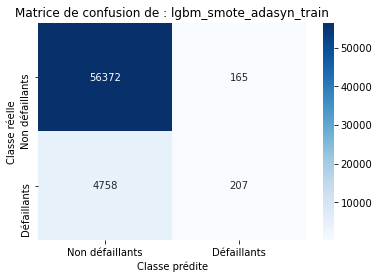

In [334]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_adasyn,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_adasyn_train')

In [335]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_adasyn_train',
                                        4758, 165, 207, 56372, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [292]:
# Modèle et hyperparamètres à étudier
def create_model_adasyn(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [293]:
# Objective fonction
def objective_adasyn(trial):
    model = create_model_adasyn(trial)
    model.fit(X_train_smote_3, y_train_smote_3)
    y_proba_smote_3 = model.predict_proba(X_valid_smote_3)[:,1]
    score = roc_auc_score(y_valid_smote_3, y_proba_smote_3)
    return score

In [294]:
# Recherche des paramètres
study_adasyn = optuna.create_study(direction='maximize')
study_adasyn.optimize(objective_adasyn, n_trials=100)

[I 2021-08-12 01:26:32,745] A new study created in memory with name: no-name-48368a6f-f4ee-46da-9b23-b51356c704b5
[I 2021-08-12 01:26:47,307] Trial 0 finished with value: 0.9753449510040414 and parameters: {'max_depth': 5, 'subsample': 0.6495220775686487, 'colsample_bytree': 0.7115103744571144, 'reg_alpha': 2.270855366957491e-05, 'reg_lambda': 7.497990726637202e-07, 'num_leaves': 233, 'min_child_weight': 0.9716100055763691, 'subsample_freq': 5, 'min_child_samples': 18}. Best is trial 0 with value: 0.9753449510040414.
[I 2021-08-12 01:27:08,552] Trial 1 finished with value: 0.9784634505855948 and parameters: {'max_depth': 11, 'subsample': 0.7091992212881608, 'colsample_bytree': 0.43856115274592333, 'reg_alpha': 4.789937291819532, 'reg_lambda': 0.5453161578299182, 'num_leaves': 199, 'min_child_weight': 0.7504777839058141, 'subsample_freq': 7, 'min_child_samples': 48}. Best is trial 1 with value: 0.9784634505855948.
[I 2021-08-12 01:27:25,681] Trial 2 finished with value: 0.97742956447080

[I 2021-08-12 01:32:53,705] Trial 20 finished with value: 0.971383015148599 and parameters: {'max_depth': 3, 'subsample': 0.7542268408423174, 'colsample_bytree': 0.5918284913857672, 'reg_alpha': 0.4419116044213993, 'reg_lambda': 0.4772123110204263, 'num_leaves': 212, 'min_child_weight': 0.7303538311185608, 'subsample_freq': 5, 'min_child_samples': 50}. Best is trial 18 with value: 0.978543933260048.
[I 2021-08-12 01:33:29,092] Trial 21 finished with value: 0.9784503558081085 and parameters: {'max_depth': 10, 'subsample': 0.887253213920753, 'colsample_bytree': 0.8828017099154535, 'reg_alpha': 1.1452561197736123e-08, 'reg_lambda': 0.008346707119785511, 'num_leaves': 203, 'min_child_weight': 0.5316754351555951, 'subsample_freq': 4, 'min_child_samples': 64}. Best is trial 18 with value: 0.978543933260048.
[I 2021-08-12 01:34:03,394] Trial 22 finished with value: 0.9785530272862353 and parameters: {'max_depth': 11, 'subsample': 0.8777613058950733, 'colsample_bytree': 0.7981572141180527, 're

[I 2021-08-12 01:41:14,344] Trial 40 finished with value: 0.9780210486171532 and parameters: {'max_depth': 10, 'subsample': 0.555881546625413, 'colsample_bytree': 0.8515705971914047, 'reg_alpha': 0.0016962611786806765, 'reg_lambda': 0.1486363883717328, 'num_leaves': 166, 'min_child_weight': 0.9315314226081777, 'subsample_freq': 6, 'min_child_samples': 55}. Best is trial 22 with value: 0.9785530272862353.
[I 2021-08-12 01:41:52,767] Trial 41 finished with value: 0.9787483477418124 and parameters: {'max_depth': 11, 'subsample': 0.9119965462113654, 'colsample_bytree': 0.9174436129277025, 'reg_alpha': 1.0242418384612605e-08, 'reg_lambda': 0.005702459711837674, 'num_leaves': 204, 'min_child_weight': 0.5282617198237809, 'subsample_freq': 4, 'min_child_samples': 66}. Best is trial 41 with value: 0.9787483477418124.
[I 2021-08-12 01:42:32,070] Trial 42 finished with value: 0.9787273938030074 and parameters: {'max_depth': 11, 'subsample': 0.9080455121005375, 'colsample_bytree': 0.92724244396275

[I 2021-08-12 01:54:11,254] Trial 60 finished with value: 0.9784293398469596 and parameters: {'max_depth': 10, 'subsample': 0.9991588743390355, 'colsample_bytree': 0.997612276535027, 'reg_alpha': 1.0388069905603637e-08, 'reg_lambda': 3.328895130939002e-05, 'num_leaves': 184, 'min_child_weight': 0.5303445970980516, 'subsample_freq': 3, 'min_child_samples': 81}. Best is trial 52 with value: 0.9788642675027269.
[I 2021-08-12 01:54:55,421] Trial 61 finished with value: 0.9786447146072418 and parameters: {'max_depth': 11, 'subsample': 0.9339814169621118, 'colsample_bytree': 0.9965983284243877, 'reg_alpha': 4.134735769380134e-08, 'reg_lambda': 0.00017190191840654793, 'num_leaves': 238, 'min_child_weight': 0.4008189345391523, 'subsample_freq': 2, 'min_child_samples': 77}. Best is trial 52 with value: 0.9788642675027269.
[I 2021-08-12 01:55:39,387] Trial 62 finished with value: 0.9787008671565953 and parameters: {'max_depth': 11, 'subsample': 0.965882317926302, 'colsample_bytree': 0.9393392244

[I 2021-08-12 02:06:27,590] Trial 80 finished with value: 0.97840402170592 and parameters: {'max_depth': 9, 'subsample': 0.9747576486785743, 'colsample_bytree': 0.9824502508544481, 'reg_alpha': 1.0036786848624971e-08, 'reg_lambda': 2.6326063359542695e-05, 'num_leaves': 203, 'min_child_weight': 0.42874482151563537, 'subsample_freq': 1, 'min_child_samples': 78}. Best is trial 52 with value: 0.9788642675027269.
[I 2021-08-12 02:07:10,995] Trial 81 finished with value: 0.9787776148454936 and parameters: {'max_depth': 11, 'subsample': 0.9494155085375252, 'colsample_bytree': 0.9492334295567908, 'reg_alpha': 1.058707997772899e-08, 'reg_lambda': 0.00018934343714780742, 'num_leaves': 240, 'min_child_weight': 0.4315569132620535, 'subsample_freq': 2, 'min_child_samples': 72}. Best is trial 52 with value: 0.9788642675027269.
[I 2021-08-12 02:07:53,390] Trial 82 finished with value: 0.9785340037928872 and parameters: {'max_depth': 11, 'subsample': 0.9301326137754646, 'colsample_bytree': 0.953326121

In [295]:
params_adasyn = study_adasyn.best_params
print(f'Nombre d\'essai terminés : {len(study_adasyn.trials)}')
print('Best hyperparamètres:\n')
print(params_adasyn)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.9986170149362794, 'colsample_bytree': 0.9098213915406521, 'reg_alpha': 8.966065249809205e-08, 'reg_lambda': 4.353353173637965e-05, 'num_leaves': 226, 'min_child_weight': 0.41759373369286584, 'subsample_freq': 2, 'min_child_samples': 88}


In [336]:
param_lgbm_optuna_adasyn = {'objective' : 'binary',
                            'boosting_type' : 'gbdt',
                            'n_jobs' : -1,    
                            'colsample_bytree': 0.9098213915406521,
                            'max_depth': 11,
                            'min_child_samples': 88,
                            'min_child_weight': 0.41759373369286584,
                            'num_leaves': 226,
                            'reg_alpha': 8.966065249809205e-08,
                            'reg_lambda': 4.353353173637965e-05,
                            'subsample': 0.9986170149362794,
                            'subsample_freq': 2,
                            'verbosity' : -1}

In [337]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_adasyn = LGBMClassifier(**param_lgbm_optuna_adasyn,
                                    force_col_wise=True)

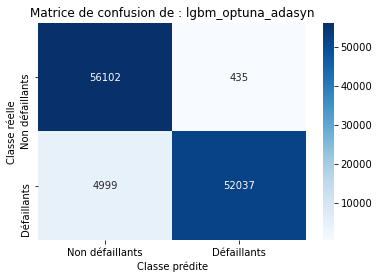

In [338]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_adasyn,
                                        X_train_smote_3, X_valid_smote_3,
                                        y_train_smote_3, y_valid_smote_3,
                                        df_resultats,
                                        'lgbm_optuna_adasyn')

In [339]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_adasyn',
                                        4999, 435, 52037, 56102, df_taux)

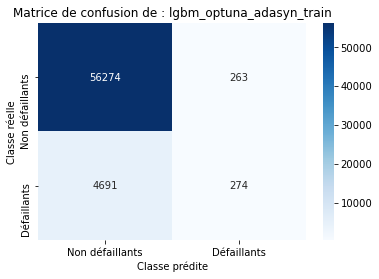

In [340]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_adasyn,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_adasyn_train')

In [341]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_adasyn_train',
                                        4691, 263, 274, 56274, df_taux)

### <span style='background:PowderBlue'>6.7. Bilan - Modélisations</span>

**Les différents taux des matrices de confusion**

In [348]:
df_taux_comp1 = df_taux.sort_values(by='Modèle')

In [376]:
modeles = ['lgbm_bayesian_opt_1', 'lgbm_bayesian_opt_1_bal',
           'lgbm_bayesian_opt_1_bis', 'lgbm_bayesian_opt_1_bis_bal',
           'lgbm_bayesian_opt_2', 'lgbm_bayesian_opt_3',
           'lgbm_bayesian_opt_4', 'lgbm_bayesian_opt_5',
           'lgbm_bayesian_opt_6', 'lgbm_bayesian_opt_7',
           'lgbm_bayesian_opt_8', 'lgbm_bayesian_opt_9',
           'lgbm_baysearch_opt_1', 'lgbm_baysearch_opt_2',
           'lgbm_baysearch_opt_3', 'lgbm_baysearch_opt_4',
           'lgbm_hyperparam_base', 'lgbm_hyperparam_base_bal',
           'lgbm_hyperparam_base_minmax', 'lgbm_hyperparam_base_robust',
           'lgbm_hyperparam_base_std', 'lgbm_hyperparam_base_std_bal',
           'lgbm_optuna_adasyn', 'lgbm_optuna_adasyn_train',
           'lgbm_optuna_opt_1', 'lgbm_optuna_opt_1_bis',
           'lgbm_optuna_opt_2', 'lgbm_optuna_opt_3',
           'lgbm_optuna_opt_4', 'lgbm_optuna_opt_5',
           'lgbm_optuna_opt_F1', 'lgbm_optuna_opt_F5',
           'lgbm_optuna_smote_bord_opt_smote',
           'lgbm_optuna_smote_bord_opt_smote_train',
           'lgbm_optuna_smote_opt_10', 'lgbm_optuna_smote_opt_10_train',
           'lgbm_optuna_smote_opt_6', 'lgbm_optuna_smote_opt_6_train',
           'lgbm_optuna_smote_opt_7', 'lgbm_optuna_smote_opt_7_train',
           'lgbm_optuna_smote_opt_8', 'lgbm_optuna_smote_opt_8_train',
           'lgbm_optuna_smote_opt_9', 'lgbm_optuna_smote_opt_9_train',
           'lgbm_smote_adasyn', 'lgbm_smote_adasyn_train',
           'lgbm_smote_base_1', 'lgbm_smote_base_1_train',
           'lgbm_smote_base_bal', 'lgbm_smote_base_bal_train',
           'lgbm_smote_bord_base_2', 'lgbm_smote_bord_base_2_train',
           'lgbm_smote_combi_base', 'lgbm_smote_combi_base_train',
           'lgbm_smote_hyperparam_base',
           'lgbm_smote_hyperparam_base_train',
           'pycaret_lgbm_hyperopt',
           'pycaret_lgbm_optuna']

In [381]:
jeu_donnees = ['train', 'train', 'train', 'train', 'train', 'train',
               'train', 'train', 'train', 'train', 'train', 'train',
               'train', 'train', 'train', 'train', 'train', 'train',
               'train', 'train', 'train', 'train', 'augmente',
               'train', 'train', 'train', 'train', 'train', 'train',
               'train', 'train', 'train', 'augmente', 'train', 'reduit',
               'train', 'augmente', 'train', 'augmente', 'train',
               'augmente', 'train', 'reduit', 'train', 'reduit', 'train',
               'augmente', 'train', 'augmente', 'train', 'augmente',
               'train', 'reduit', 'train', 'augmente', 'train', 'train',
               'train']

In [383]:
df_taux_comp2 = pd.DataFrame({'Modèle' : modeles,
                              'Jeu_donnees' : jeu_donnees})

In [384]:
# Dataframe de sauvegarde des taux des différentes modélisations
df_taux_comp = df_taux_comp2.merge(df_taux_comp1, on='Modèle',
                                   how='right')

In [385]:
# Tri par Faux Négatifs décroissant (les clients prédits non défaillants
# qui sont défaillants ==> la banque perd le montant du prêt en totalité
# ou en partie) pour le train set
mask = df_taux_comp['Jeu_donnees'] == 'train'
df_taux_comp[mask].sort_values(by='FN').style \
    .highlight_min(subset=['FN', 'FP', 'TN', 'TP'], color='lightgreen',
                   axis=0)

**Constitution des dataframes de comparaison pour les résultats**

In [386]:
df_resultats_comp1 = df_resultats.sort_values(by='Modèle')

In [387]:
metrique = ['roc_auc', 'roc_auc', 'roc_auc', 'roc_auc', 'roc_auc',
            'roc_auc', 'roc_auc',
            'custom', 'custom', 'pr_auc', 'F10', 'roc_auc', 'roc_auc',
            'custom', 'pr_auc', 'F10', 'logloss', 'logloss', 'logloss', 
            'logloss', 'logloss',  'logloss', 'logloss', 'roc_auc',
            'roc_auc', 'roc_auc',  'roc_auc', 'custom', 'pr_auc',
            'F10', 'F1', 'F5', 'roc_auc', 'roc_auc', 'F10', 'F10', 'F10',
            'F10', 'roc_auc', 'roc_auc', 'roc_auc', 'roc_auc', 'roc_auc',
            'roc_auc', 'logloss', 'logloss', 'logloss', 'logloss',
            'logloss', 'logloss', 'logloss', 'logloss', 'logloss',
            'logloss', 'logloss', 'logloss', 'roc_auc', 'roc_auc']

In [389]:
optimisation = ['bayes_opt', 'bayes_opt', 'bayes_opt', 'bayes_opt',
                'bayes_opt', 'bayes_opt', 'bayes_opt', 'bayes_opt',
                'bayes_opt', 'bayes_opt',
                'bayes_opt', 'bayes_opt', 'skopt', 'skopt', 'skopt',
                'skopt', 'aucune', 'aucune', 'minmax', 'robust',
                'std', 'std', 'optuna', 'optuna', 'optuna', 'optuna',
                'optuna', 'optuna', 'optuna', 'optuna', 'optuna', 'optuna',
                'optuna', 'optuna', 'optuna', 'optuna', 'optuna', 'optuna',
                'optuna', 'optuna', 'optuna', 'optuna', 'optuna', 'optuna',
                'smoteover', 'smoteover', 'smoteover', 'smoteover',
                'smoteover', 'smoteover', 'borderlinesmote',
                'borderlinesmote', 'smoteoverunder', 'smoteoverunder',
                'smoteover', 'smoteover', 'hyperopt', 'optuna']

In [394]:
class_weight = ['non', 'oui', 'non', 'oui', 'non', 'oui', 'oui', 'oui',
                'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui',
                'non', 'oui', 'non', 'non', 'non', 'oui', 'non', 'non',
                'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'non',
                'non', 'non', 'non', 'non', 'non', 'non', 'non', 'non',
                'non', 'non', 'non', 'non', 'non', 'non', 'non', 'non',
                'non', 'non', 'non', 'non', 'non', 'non', 'non', 'non',
                'oui', 'oui']

In [397]:
df_resultats_comp2 = pd.DataFrame({'Modèle' : modeles,
                                   'Metrique' : metrique,
                                   'Optimisation' : optimisation,
                                   'Class_weight' : class_weight})

In [398]:
# Dataframe de sauvegarde des résultats de la modélisation
df_resultats_comp = \
    df_resultats_comp2.merge(df_resultats_comp1, on='Modèle', how='left')

In [399]:
# Dataframe de recueil de tous les résultats
df_comparaison = \
    df_taux_comp.merge(df_resultats_comp, on='Modèle', how='left')

In [400]:
# Les vraies répartition de la TARGET dans le jeu de validation
Counter(y_valid)

Counter({0: 56537, 1: 4965})

- Nombre de vrais non-défaillants : 56537 (TN).
- Nombre de vrais défaillants : 4965 (TP).

In [401]:
df_comp = df_comparaison.sort_values(by='FN')
df_comp.style.highlight_min(subset=['FN', 'FP', 'TN', 'TP'],
                            color='lightgreen', axis=0).hide_index()

In [402]:
df_comp.head(4).style.highlight_min(subset=['FN', 'FP', 'TN', 'TP'],
                            color='lightgreen', axis=0).hide_index()

**Bilan des taux FN, FP, TN et TP**

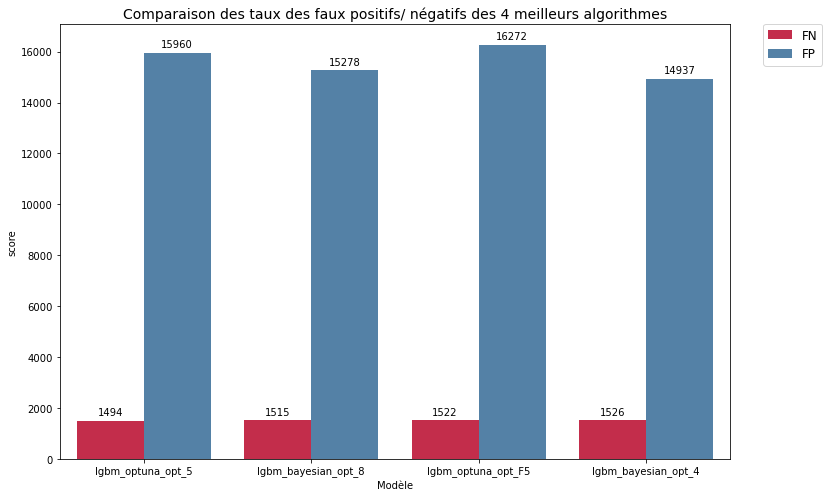

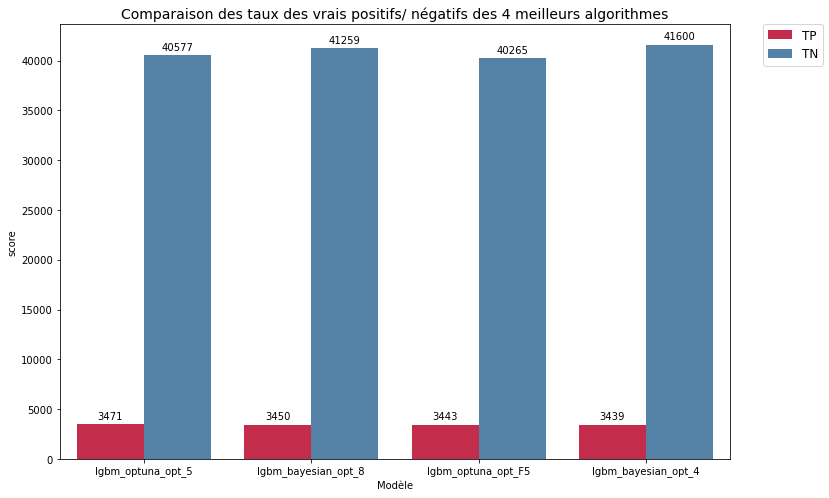

In [403]:
# Comparaison visuelle des 4 algorithmes les plus performants
df_comp_best = df_comp[df_comp['Modèle'].isin(
    ['lgbm_optuna_opt_5', 'lgbm_bayesian_opt_8',
     'lgbm_optuna_opt_F5', 'lgbm_bayesian_opt_4'])]

# Renseignements sur les modèles
df_comp_display = df_comp_best[['Modèle', 'Metrique', 'Optimisation',
                               'Class_weight']].style.hide_index()
display(df_comp_display)

# Faux négatifs/Faux positifs
comparaison_taux_melt_false = \
    pd.melt(df_comp_best, id_vars=['Modèle'], value_name='score',
            value_vars=['FN', 'FP'])
# Visualisation
plt.figure(figsize=(12, 8))
ax= sns.barplot(x=comparaison_taux_melt_false['Modèle'],
                y=comparaison_taux_melt_false['score'],
            hue=comparaison_taux_melt_false['variable'],
            palette=['Crimson', 'SteelBlue', 'Crimson', 'SteelBlue'])
plt.title('Comparaison des taux des faux positifs/ négatifs des 4 meilleurs algorithmes', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 200,
            int(height),
            ha="center") 
plt.show()

# Vrais négatifs/Vrais positifs
comparaison_taux_melt_true = \
    pd.melt(df_comp_best, id_vars=['Modèle'], value_name='score',
            value_vars=['TP', 'TN'])
# Visualisation
plt.figure(figsize=(12, 8))
total = float(len(comparaison_taux_melt_true))
ax = sns.barplot(x=comparaison_taux_melt_true['Modèle'],
                 y=comparaison_taux_melt_true['score'],
                 hue=comparaison_taux_melt_true['variable'],
                 palette=['Crimson', 'SteelBlue', 'Crimson', 'SteelBlue'])
plt.title('Comparaison des taux des vrais positifs/ négatifs des 4 meilleurs algorithmes', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 500,
            int(height),
            ha="center") 
plt.show()

**Bilan** :
***
- Le modèle **lgbm_otuna_opt_5** (LightGBM class_weight='balanced' avec une optimisation bayésienne, la métrique F10-score) détecte :
    - le moins de faux négatifs (des clients détectés non défaillants mais qui ne remboursent pas le prêt) 
    - et le plus de vrais positifs (des clients détéctés défaillants qui sont défaillants),
- Ce modèle détecte un peu plus de faux positifs (des clients qui sont détectés défaillants mais qui ne sont pas défaillants et rembourseraient leur prêt) que le modèle **lgbm_bayesian_opt_4** (LightGBM class_weight='balanced' sans optimisation bayésienne ou optuna avec la métrique par défaut logloss). Mais nous n'avons aucune consigne de notre client sur le niveau de détection des faux positifs.

On peut désormais tenter d'optimiser ce modèle **lgbm_otuna_opt_5** en recherchant le seuil de probabilité optimal ayant un impact sur la décision de classer en classe 0 (non-défaillant) ou 1 (défaillant).

**Bilan des différentes métriques**

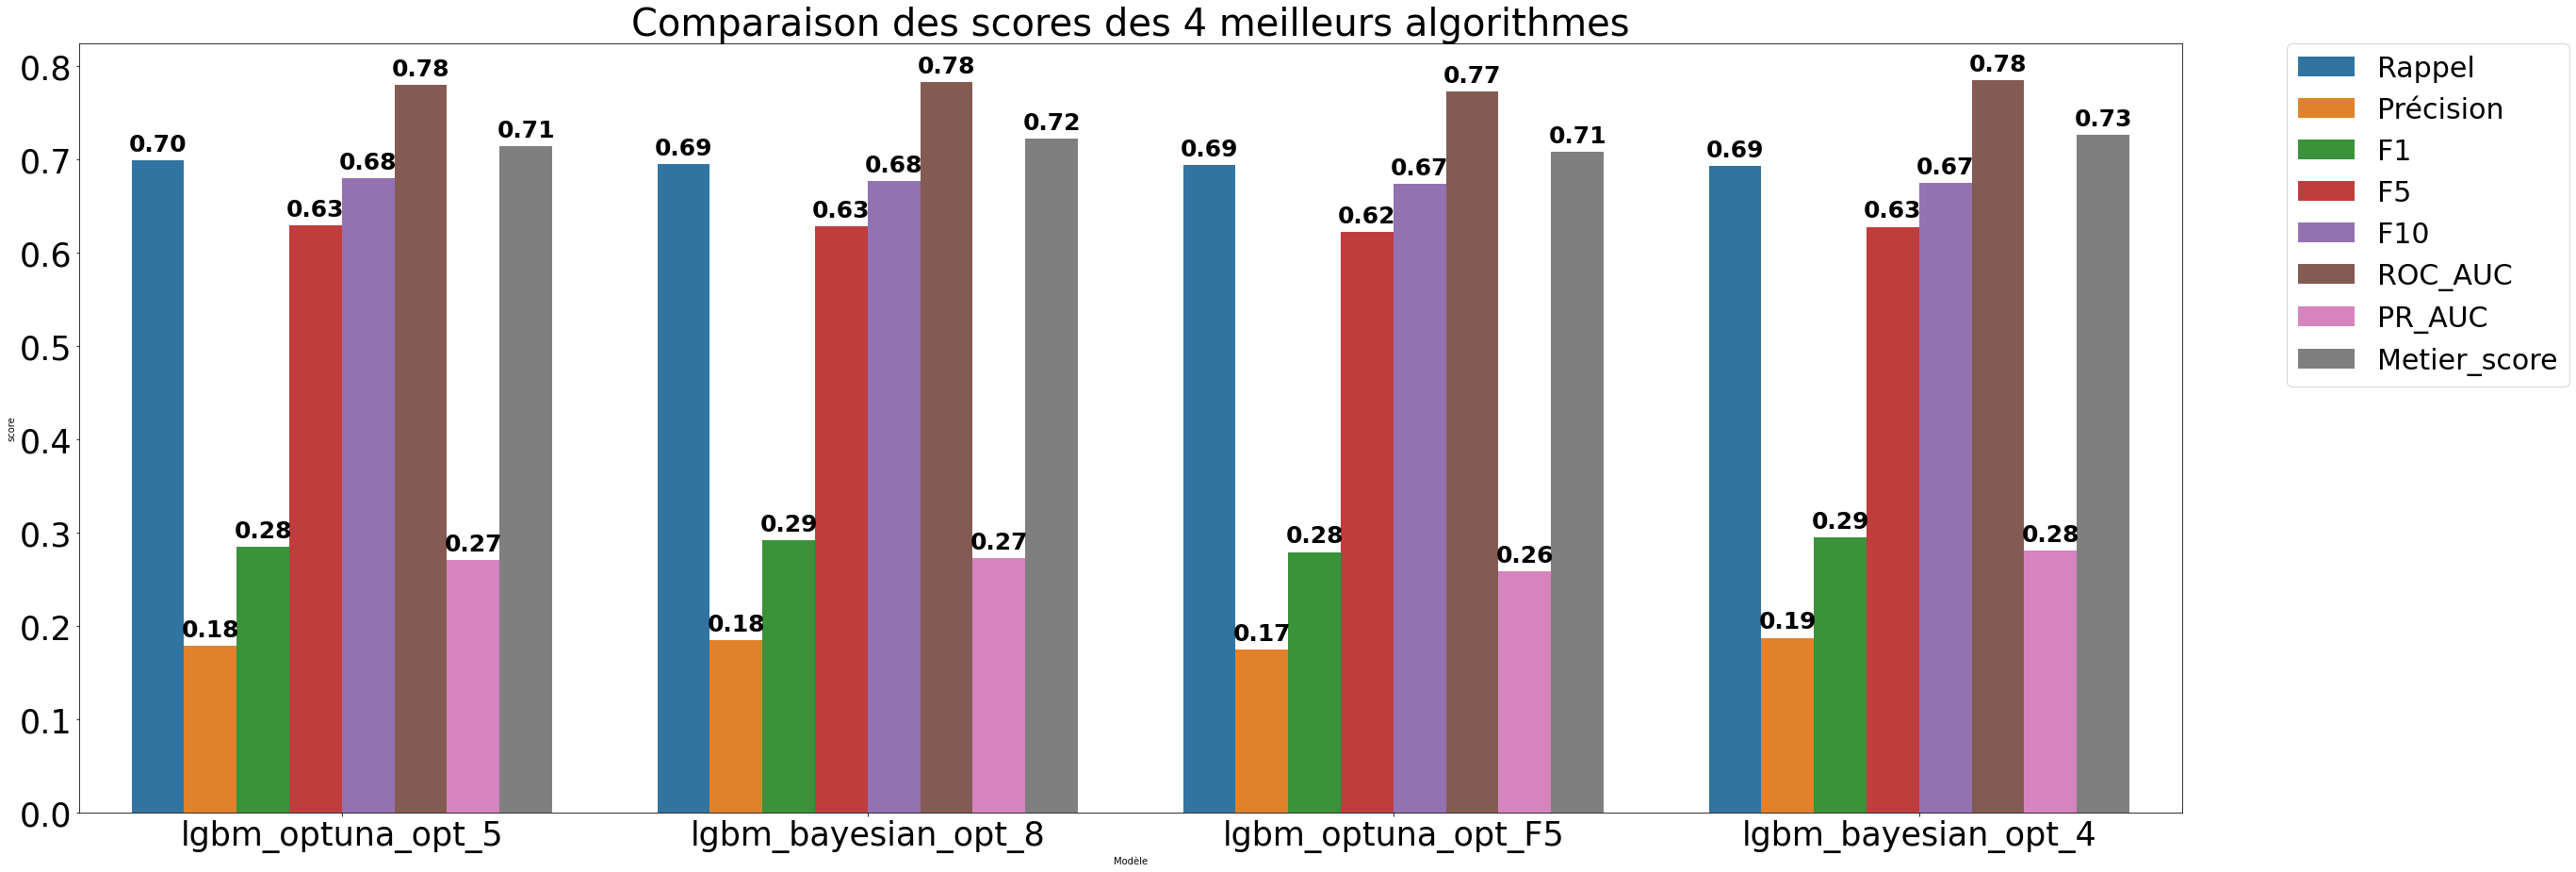

In [406]:
# Comparaison visuelle des 4 algorithmes les plus performants
df_comp_score = df_comp[df_comp['Modèle'].isin(
    ['lgbm_optuna_opt_5', 'lgbm_optuna_opt_F5', 'lgbm_bayesian_opt_4',
     'lgbm_bayesian_opt_8'])]

# Renseignements sur les modèles
df_comp_display = df_comp_score[['Modèle', 'Metrique', 'Optimisation',
                               'Class_weight']].style.hide_index()
display(df_comp_display)

# Scores
comparaison_score_melt = \
    pd.melt(df_comp_score, id_vars=['Modèle'], value_name='score',
            value_vars=['Rappel', 'Précision', 'F1', 'F5', 'F10',
                        'ROC_AUC', 'PR_AUC', 'Metier_score'])
# Visualisation
plt.figure(figsize=(40, 15))
ax= sns.barplot(x=comparaison_score_melt['Modèle'],
                y=comparaison_score_melt['score'],
            hue=comparaison_score_melt['variable'])
plt.title('Comparaison des scores des 4 meilleurs algorithmes',
          fontsize=40)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=25,
            fontweight='bold') 
plt.show()

df_comp_score[['Rappel', 'Précision', 'F1', 'F5', 'F10', 'ROC_AUC',
               'PR_AUC', 'Metier_score']].style.hide_index()

**Bilan** :
***
- Les différentes métriques sont proches pour tous les modèles avec un léger avantage pour le rappel pour le modèle **lgbm_otuna_opt_5** qui s'explique pour le nombre beta=10 qui favorise la détection des classes positives.

### <span style='background:PowderBlue'>6.8. Recherche de seuil de probabilité optimal</span>

In [414]:
df_res_seuil = pd.DataFrame({})

**Seuil de probabilité optimal du modèle lgbm_optuna_opt_5**

In [408]:
# Chargement du meilleur modèle
fic_lgbm_optuna_opt_5 = \
    '../sauvegarde/modelisation/modele_lgbm_optuna_opt_5.pickle'
with open(fic_lgbm_optuna_opt_5, 'rb') as df_mod2:
    lgbm_optuna_opt_5 = pickle.load(df_mod2)
lgbm_optuna_opt_5

LGBMClassifier(class_weight='balanced', colsample_bytree=0.65731418761953,
               force_col_wise=True, max_depth=9, min_child_samples=96,
               min_child_weight=0.5685528790757488, num_leaves=13,
               objective='binary', reg_alpha=1.7033609851586964e-06,
               reg_lambda=0.012745771755334187, subsample=0.8190208924749053,
               subsample_freq=1, verbosity=-1)

**Première métrique métier**

Score métrique métier maximal : 0.7991936550503738
Seuil maximal : 0.76


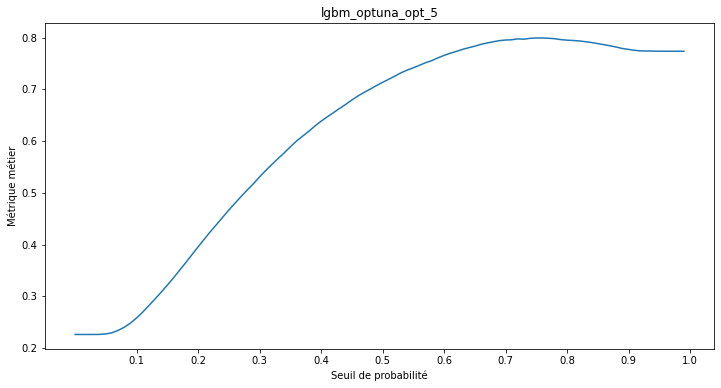

In [409]:
# taux_tn=1, taux_fp=0, taux_fn=-10, taux_tp=0
outils_model.determiner_seuil_probabilite(lgbm_optuna_opt_5,
                                          X_valid, y_valid,
                                          'lgbm_optuna_opt_5')

**Scores du modèle en prenant en compte le seuil**

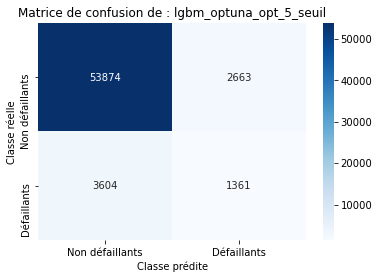

In [415]:
df_res_seuil = \
    outils_model.process_classification_seuil(lgbm_optuna_opt_5, 0.76,
                                             X_train, X_valid, y_train,
                                             y_valid, df_res_seuil,
                                            'lgbm_optuna_opt_5_seuil')

**Bilan** :
- La métrique métier n'est pas efficace puisqu'on détecte plus de vrais négatifs (prédits non-défaillants mais défaillants).

**Deuxième métrique métier**

Score F10 maximal : 0.9002192150871984
Seuil maximal : 0.12


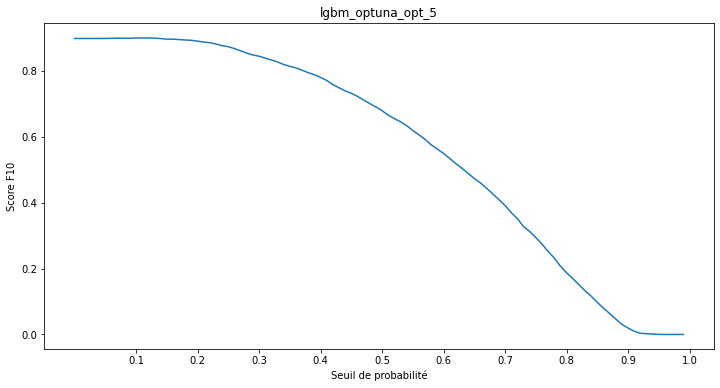

In [411]:
# Score F10 en fonction du seuil
outils_model.determiner_seuil_probabilite_F10(lgbm_optuna_opt_5,
                                              X_valid, y_valid,
                                             'lgbm_optuna_opt_5')

**Scores du modèle en prenant en compte le seuil**

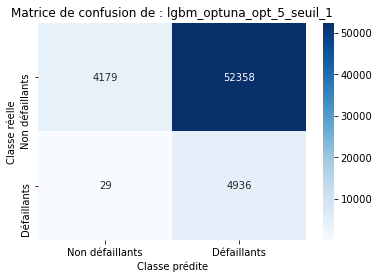

In [416]:
df_res_seuil = \
    outils_model.process_classification_seuil(lgbm_optuna_opt_5, 0.12,
                                              X_train, X_valid, y_train,
                                              y_valid, df_res_seuil,
                                             'lgbm_optuna_opt_5_seuil_1')

- Le taux de FN est très faible mais cela signifie que le prêt n'est plus accordé à personne ! Ce n'est pas le but de la banque qui doit gagner de l'argent avec les intérêts des prêts accordés.
- Le compromis faux négatifs et faux positifs devra être discuté avec nos clients pour régler au mieux le seuil de probabilité avec le nombre de faux négatifs/positifs à atteindre. 
- Sans client disponible et sans consigne dans le projet, le seuil par défaut à 0.5 sera conservé et le modèle final sera **lgbm_optuna_opt_5**.

In [417]:
# Sauvegarde du meilleur modèle dans best_model
fic_best_model = \
    '../sauvegarde/modelisation/best_model.pickle'
with open(fic_best_model, 'wb') as f:
    pickle.dump(lgbm_optuna_opt_5, f, pickle.HIGHEST_PROTOCOL)

## <span style='background:Thistle'>7. Interprétabilité du modèle</span>

In [17]:
# Chargement du meilleur modèle
fic_best_model = '../sauvegarde/modelisation/best_model.pickle'
with open(fic_best_model, 'rb') as df_best_model:
    best_model = pickle.load(df_best_model)
best_model

LGBMClassifier(class_weight='balanced', colsample_bytree=0.65731418761953,
               force_col_wise=True, max_depth=9, min_child_samples=96,
               min_child_weight=0.5685528790757488, num_leaves=13,
               objective='binary', reg_alpha=1.7033609851586964e-06,
               reg_lambda=0.012745771755334187, subsample=0.8190208924749053,
               subsample_freq=1, verbosity=-1)

### <span style='background:PowderBlue'>7.1. LightGBM - Features importances</span>

**Features importances**

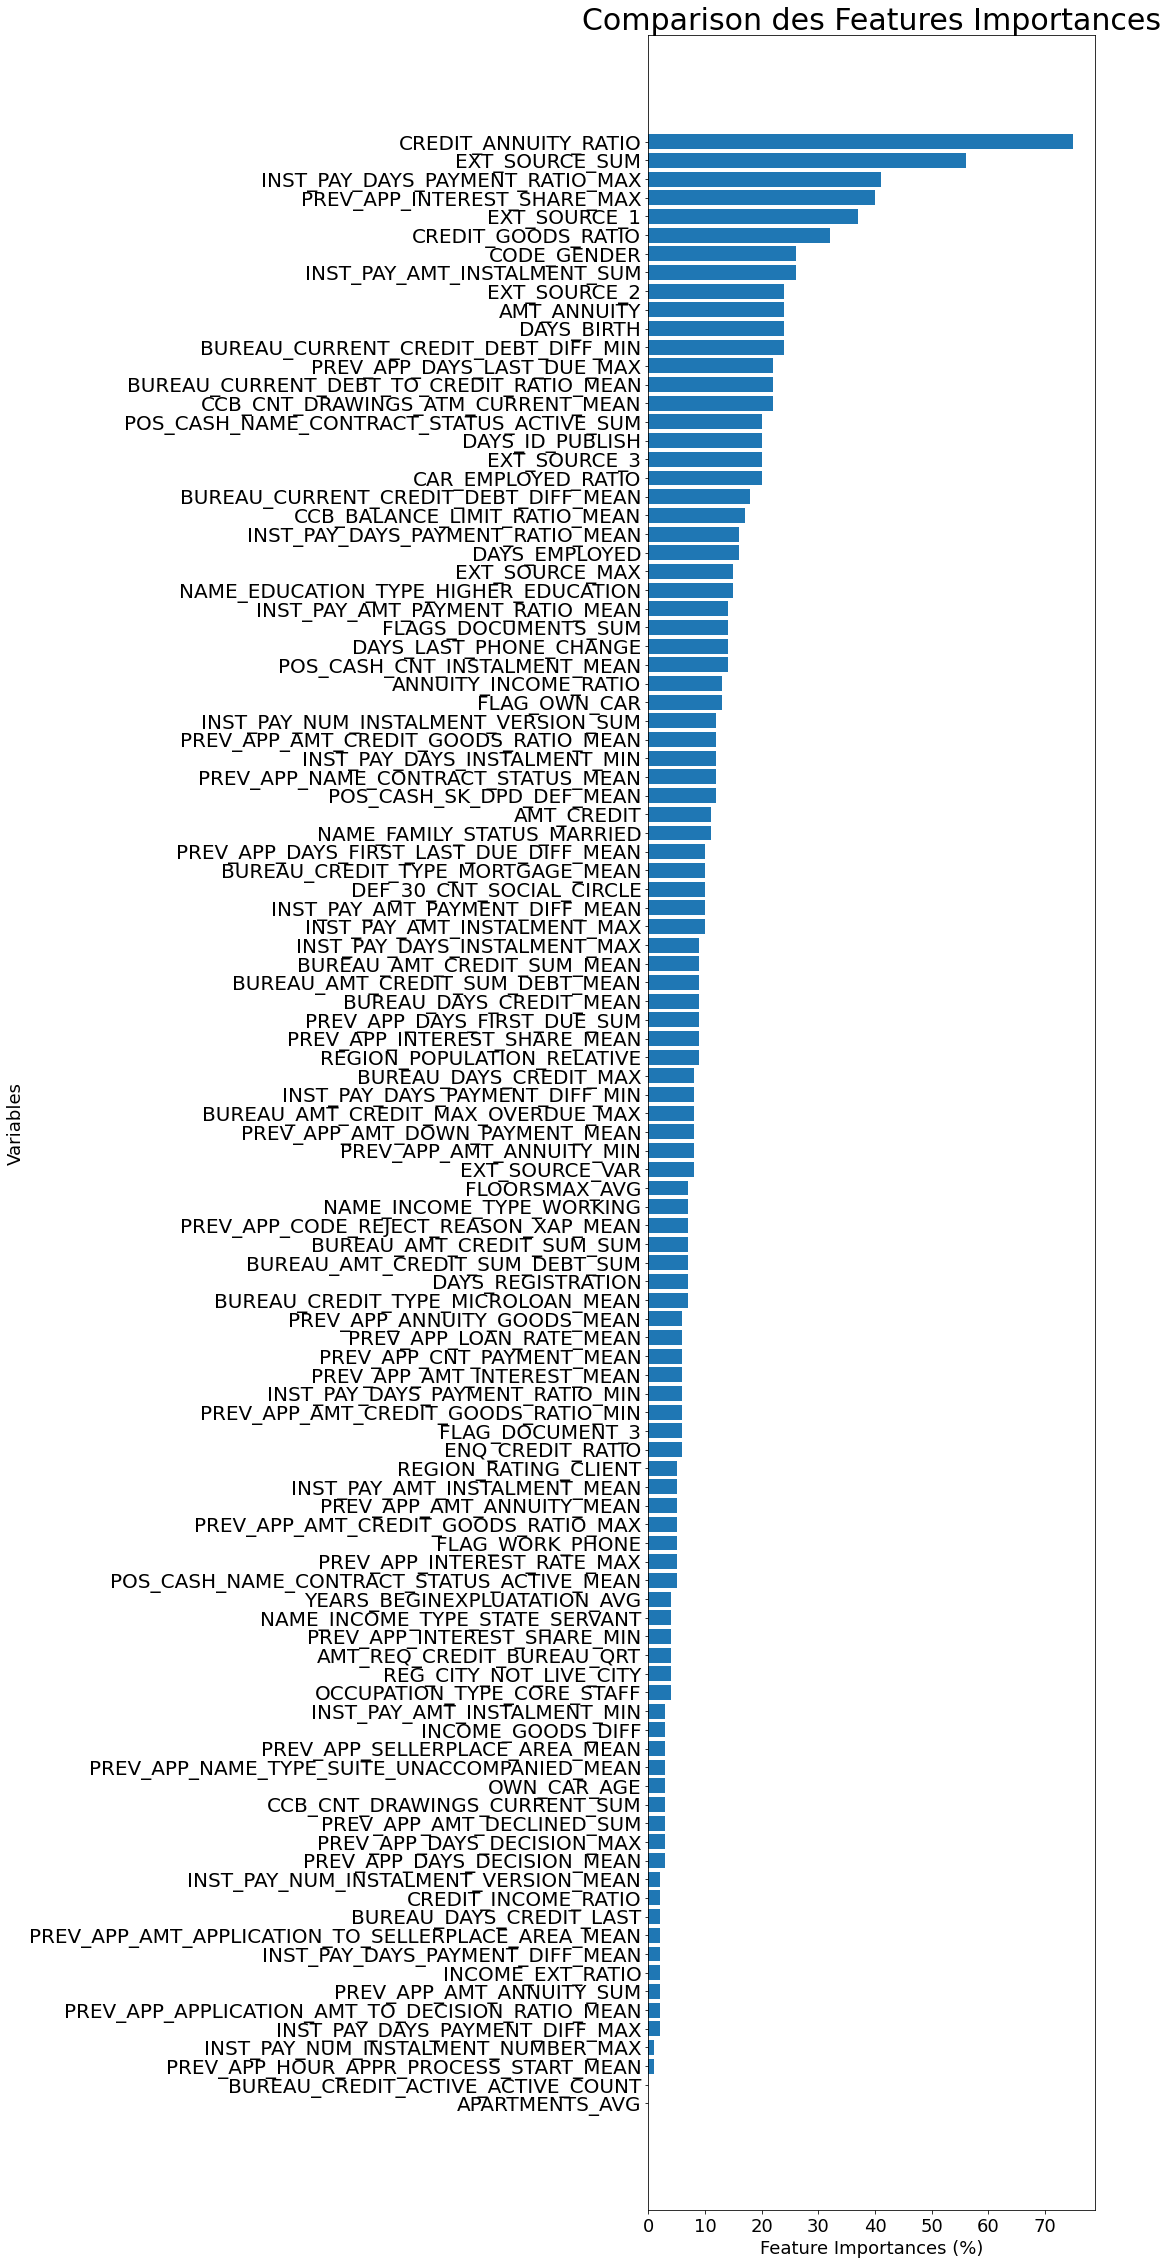

In [36]:
feature_importance_values = best_model.feature_importances_
feature_names = list(X_train.columns)
outils_model.plot_features_importance(feature_importance_values,
                                      feature_names, (8, 40))

**Répartition des features importances**

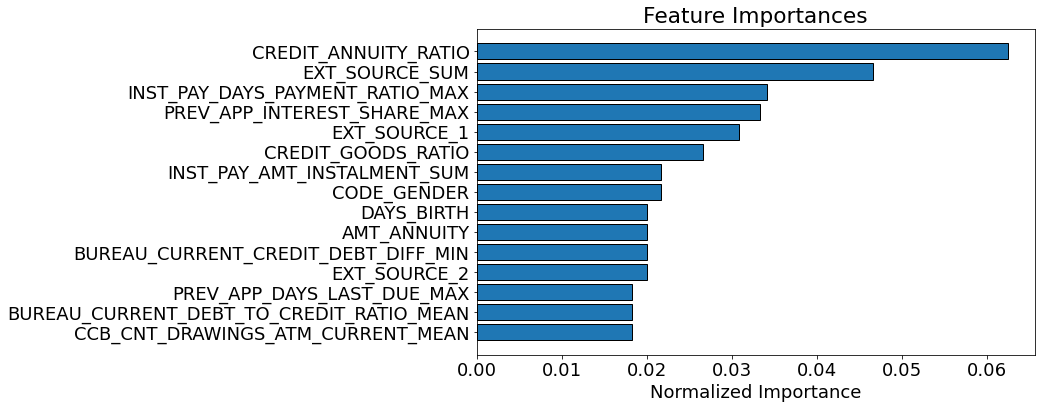

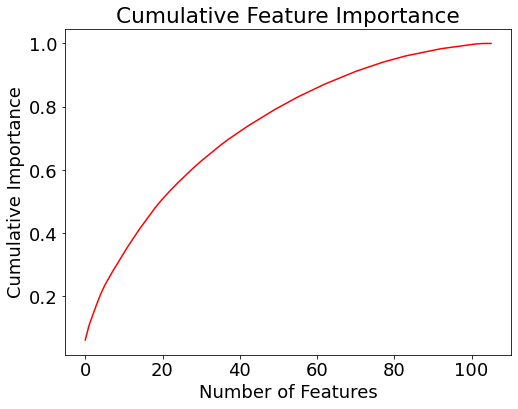

69 variables nécessaires pour 0.90 de cummulative imortance


In [21]:
# Impact des features importance cumulées
feature_importance_values = best_model.feature_importances_
feature_names = list(X_train.columns)
feature_importances = pd.DataFrame({'feature': feature_names,
                                    'importance': feature_importance_values})
# Show the feature importances for the new features
df_featimp = \
    outils_model.plot_cumultative_feature_importance(feature_importances)

In [421]:
df_featimp

index                                            feature  importance  importance_normalized  cumulative_importance
0        0                               CREDIT_ANNUITY_RATIO          75                 0.0625                 0.0625
1        9                                     EXT_SOURCE_SUM          56                 0.0467                 0.1092
2       58                    INST_PAY_DAYS_PAYMENT_RATIO_MAX          41                 0.0342                 0.1433
3       56                        PREV_APP_INTEREST_SHARE_MAX          40                 0.0333                 0.1767
4       55                                       EXT_SOURCE_1          37                 0.0308                 0.2075
5       54                                 CREDIT_GOODS_RATIO          32                 0.0267                 0.2342
6       48                        INST_PAY_AMT_INSTALMENT_SUM          26                 0.0217                 0.2558
7       63                                        CODE_GENDER          26                 0.0217                 0.2775
8       59                                         DAYS_BIRTH          24                 0.0200                 0.2975
9       57                                        AMT_ANNUITY          24                 0.0200                 0.3175
10      52                BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN          24                 0.0200                 0.3375
11      53                                       EXT_SOURCE_2          24                 0.0200                 0.3575
12      60                         PREV_APP_DAYS_LAST_DUE_MAX          22                 0.0183                 0.3758
13      62           BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN          22                 0.0183                 0.3942
14      67                  CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN          22                 0.0183                 0.4125
15      51                                    DAYS_ID_PUBLISH          20                 0.0167                 0.4292
16      46                                 CAR_EMPLOYED_RATIO          20                 0.0167                 0.4458
17      69           POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM          20                 0.0167                 0.4625
18      49                                       EXT_SOURCE_3          20                 0.0167                 0.4792
19      50               BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN          18                 0.0150                 0.4942
20      34                       CCB_BALANCE_LIMIT_RATIO_MEAN          17                 0.0142                 0.5083
21      42                   INST_PAY_DAYS_PAYMENT_RATIO_MEAN          16                 0.0133                 0.5217
22      61                                      DAYS_EMPLOYED          16                 0.0133                 0.5350
23      28               NAME_EDUCATION_TYPE_HIGHER_EDUCATION          15                 0.0125                 0.5475
24      73                                     EXT_SOURCE_MAX          15                 0.0125                 0.5600
25      14                    INST_PAY_AMT_PAYMENT_RATIO_MEAN          14                 0.0117                 0.5717
26      71                             DAYS_LAST_PHONE_CHANGE          14                 0.0117                 0.5833
27      16                                FLAGS_DOCUMENTS_SUM          14                 0.0117                 0.5950
28      76                       POS_CASH_CNT_INSTALMENT_MEAN          14                 0.0117                 0.6067
29      25                                       FLAG_OWN_CAR          13                 0.0108                 0.6175
30      45                               ANNUITY_INCOME_RATIO          13                 0.0108                 0.6283
31      77                       INST_PAY_DAYS_INSTALMENT_MIN          12                 0.0100                 0.6383
32      23                           POS_CASH

- 65 variables sont nécessaires pour représenter 90% des features importances et 36 variables pour 70%.

**Arbre de décision de LightGBM**

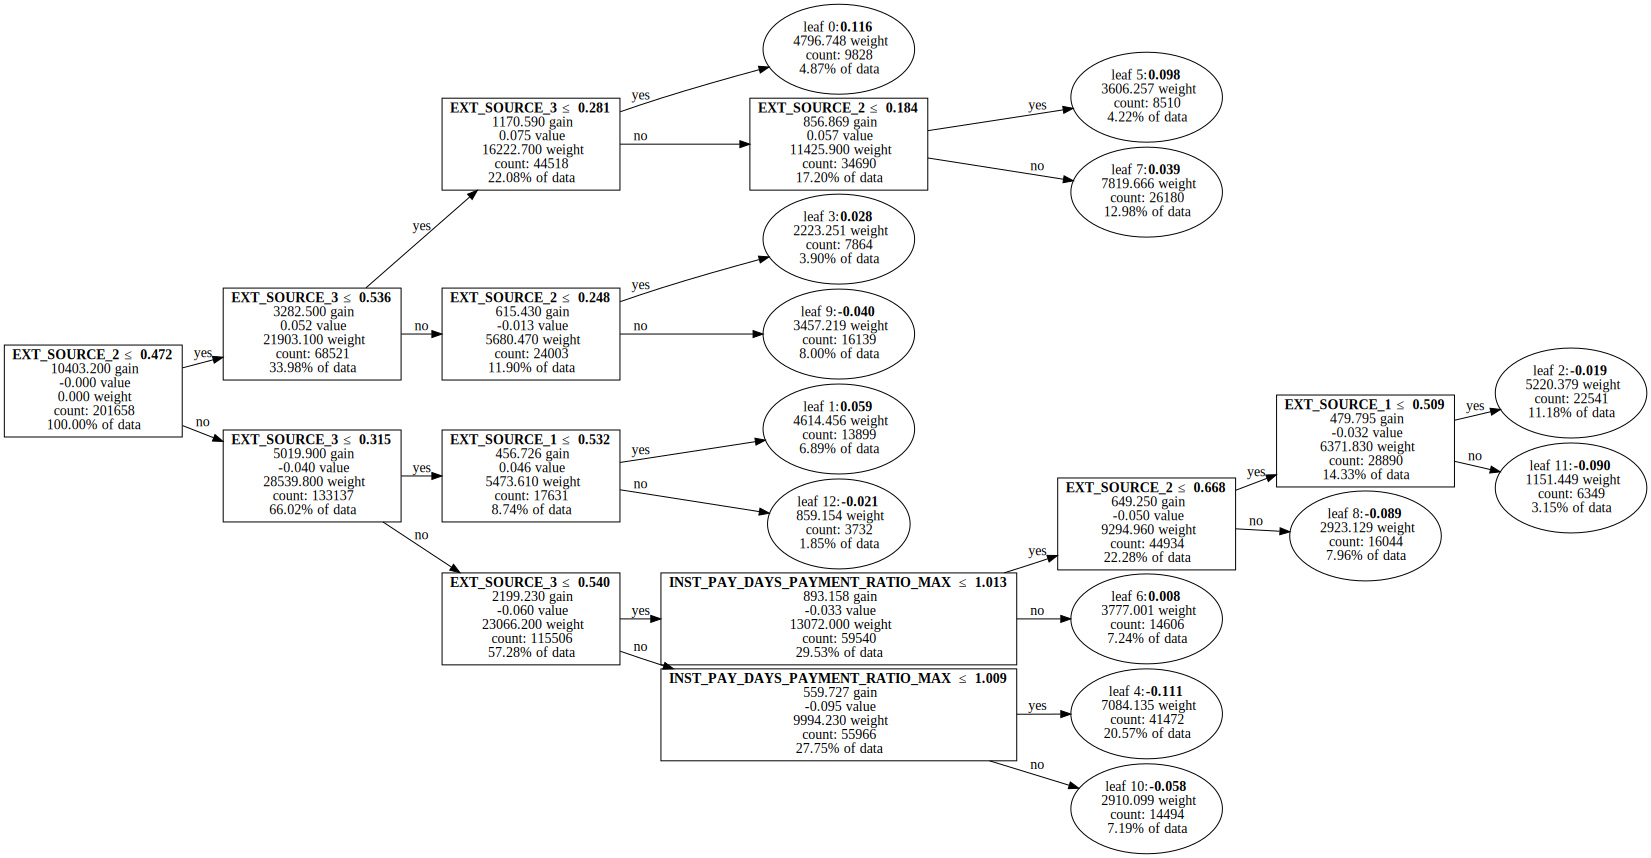

In [422]:
lgb.create_tree_digraph(best_model, tree_index=0,
                        show_info=['split_gain', 'internal_value',
                                   'internal_count', 'internal_weight',
                                   'leaf_count', 'leaf_weight', 'data_percentage'])

### <span style='background:PowderBlue'>7.2. SHAP</span>

- La méthode SHAP (SHapley Additive exPlanations) consiste à calculer la valeur de Shapley pour toutes les variables de tous les individus c’est-à-dire la moyenne de l’impact d’une variable (sur la sortie, donc la prédiction) pour toutes les combinaisons de variables possibles.
- La somme des effets de chaque variable expliquera la prédiction.

[Source](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30) [Source](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d) [Source](https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83) [Source](https://medium.com/swlh/push-the-limits-of-explainability-an-ultimate-guide-to-shap-library-a110af566a02) [Source](https://www.kaggle.com/dansbecker/shap-values)

**Interprétabilité globale**

**Summary plot**

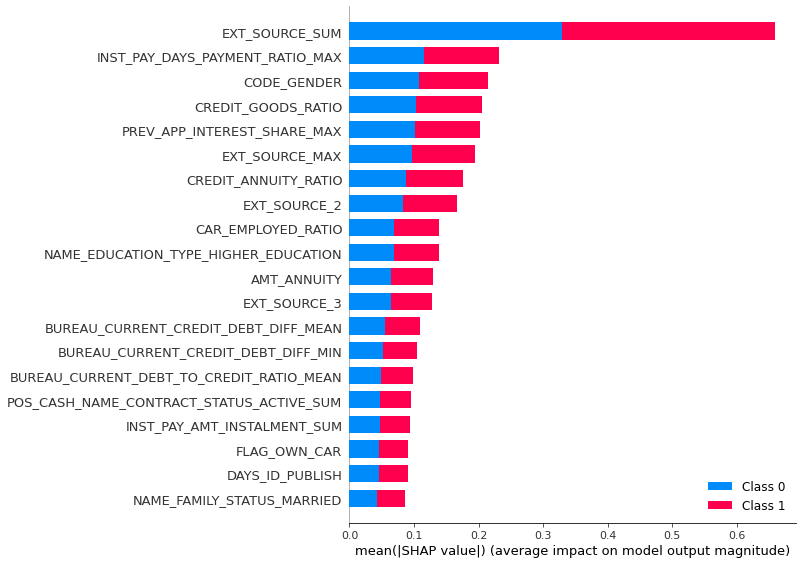

In [38]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_valid)
# Summary plot
shap.summary_plot(shap_values, X_valid)

**Summary plot** : 

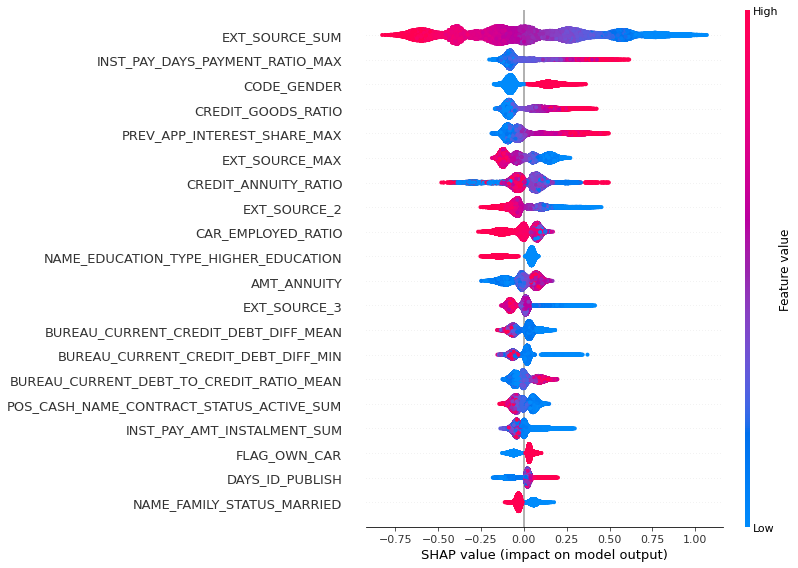

In [424]:
shap.summary_plot(shap_values[1], X_valid, show=False)

In [37]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train, check_additivity=False)

100%|===================| 245673/246005 [09:28<00:00]        

**Bar plot** : l'importance globale des caractéristiques, où l'importance globale de chaque caractéristique est considérée comme la valeur absolue moyenne pour cette caractéristique sur tous les échantillons donnés.

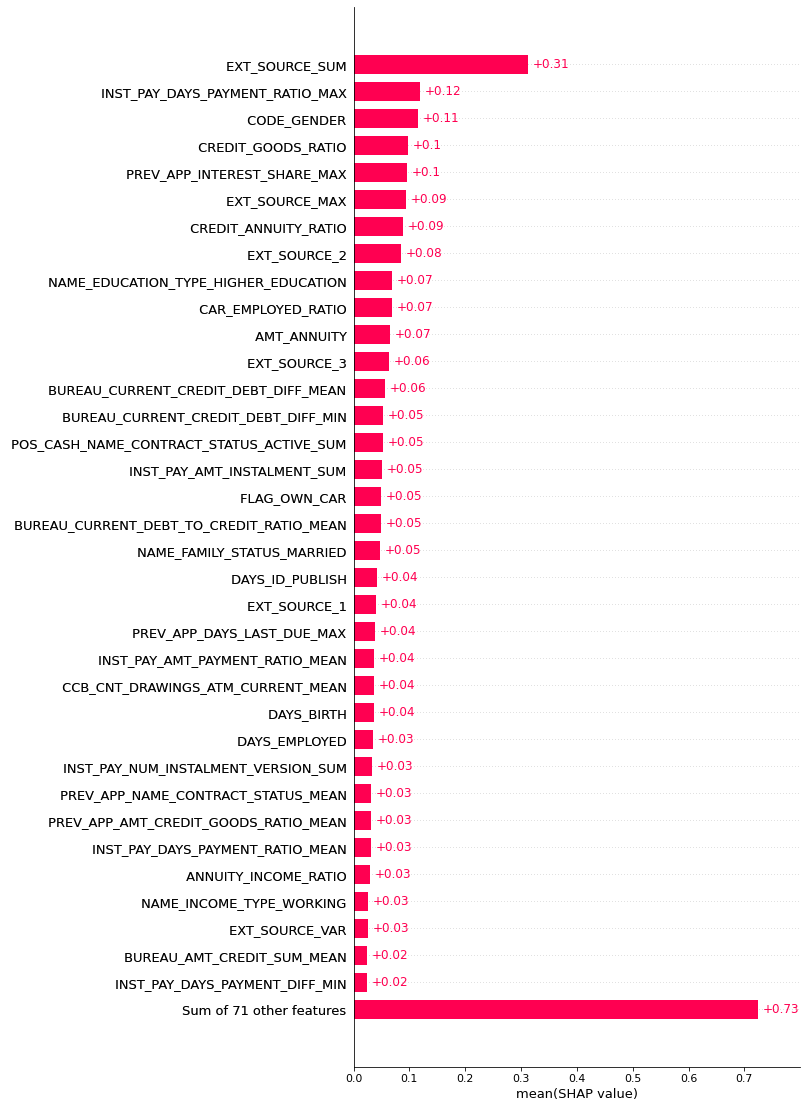

In [426]:
shap.plots.bar(shap_values, max_display=36)

**Beeswarm** : 
- ce graphique est conçu pour afficher un résumé dense en informations de la manière dont les principales caractéristiques d'un ensemble de données influencent la sortie du modèle. 
- Chaque instance de l'explication donnée est représentée par un seul point sur chaque graphique de caractéristiques. La position x du point est déterminée par la valeur SHAP (shap_values.value[instance,feature]) de cette caractéristique, et les points s'empilent le long de chaque ligne de caractéristique pour montrer la densité. 
- La couleur est utilisée pour afficher la valeur originale d'une caractéristique (shap_values.data[instance,feature]). 

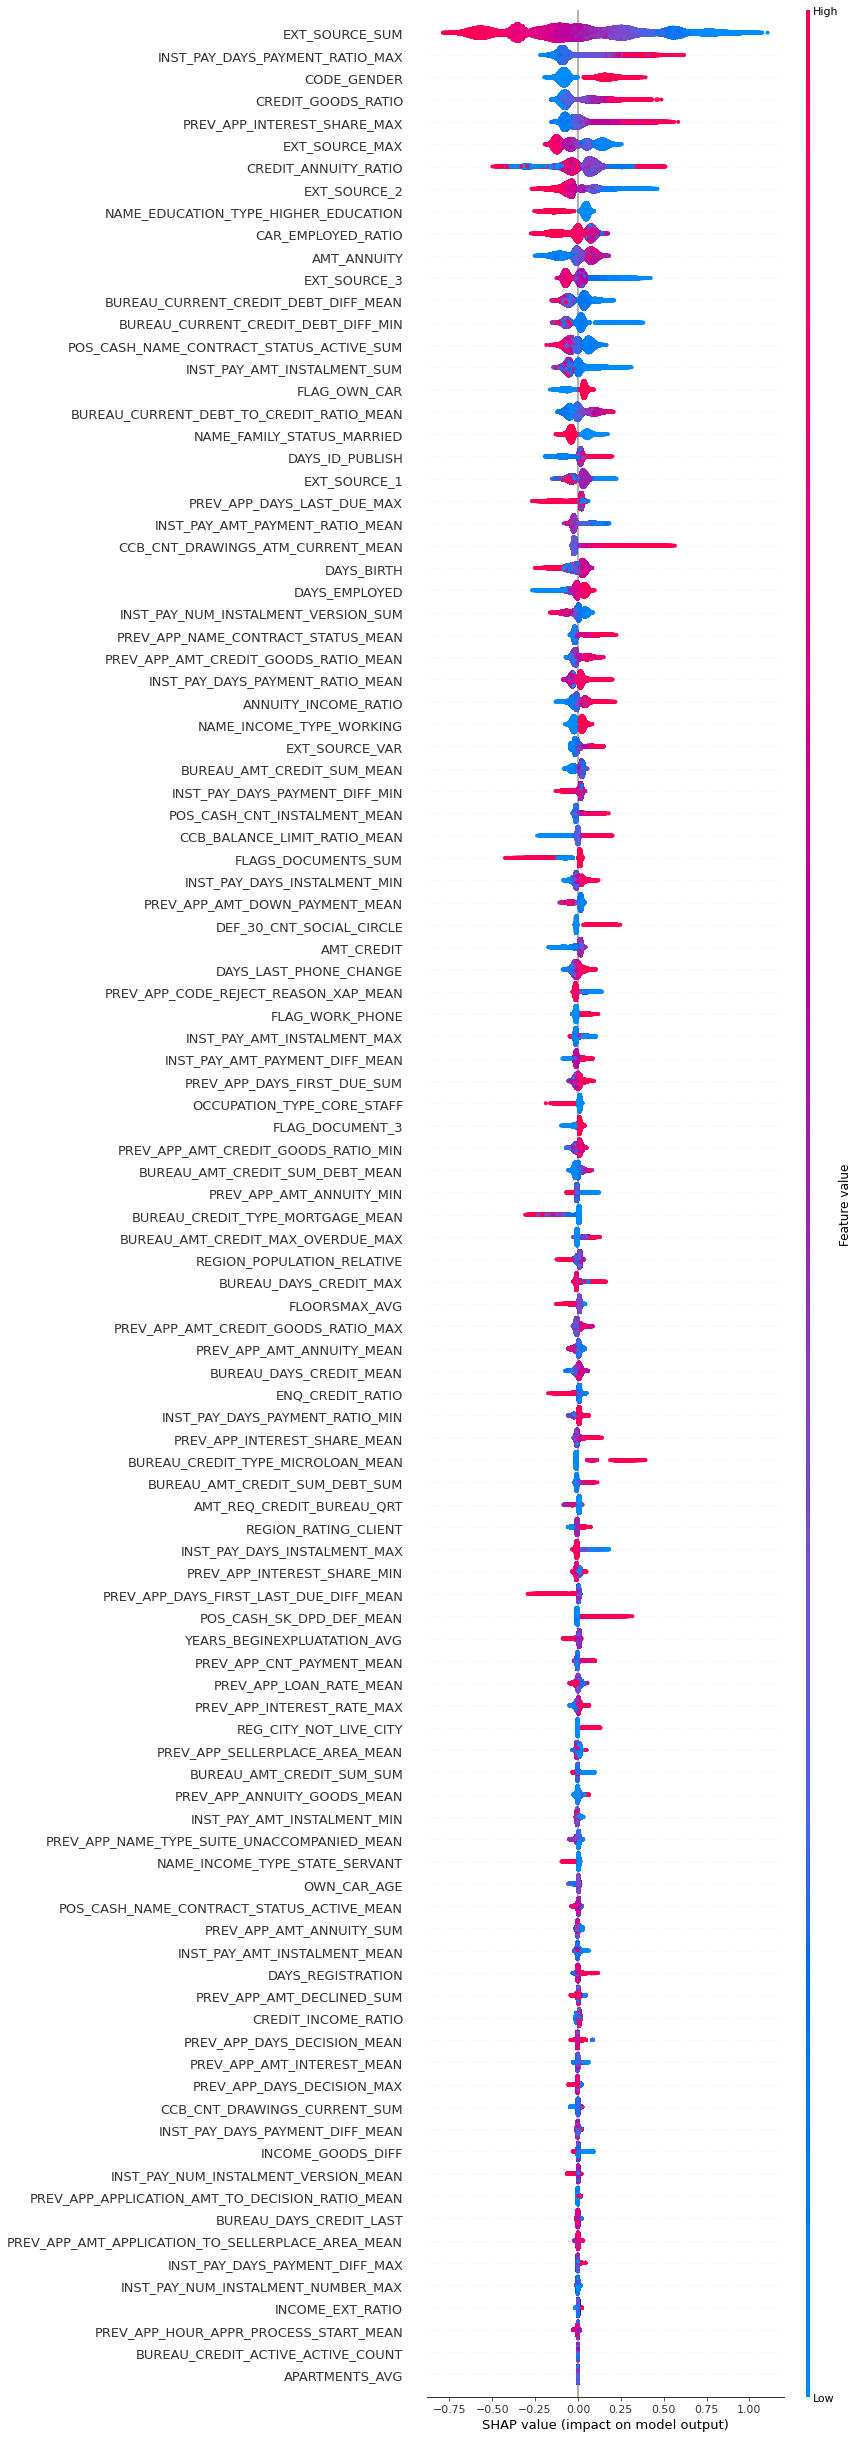

In [427]:
shap.plots.beeswarm(shap_values)

- Dans le graphique ci-dessous, nous pouvons voir que la variable EXT_SOURCE_SUM est la caractéristique la plus importante en moyenne, et que les hautes valuers (en rouge) ont tendance avoir un impact négatif donc classe 1 défaillant alors que les basses valeurs ont tendance à avoir un impact postif donc classe 0 non-défaillant...

***
Le meilleur modèle est sélectionné et extrait. La suite concernera la préparation des données nécessaires au dashboard et sera traitée dans le notebook P7_01_06_DASHBOARD.ipynb.
***